# Deep Q-Learning Workshop

## Einführung

2013 zeigte DeepMind wie sie mit ein und denselben Machine Learning Algorithmus lernen können viele verschiedene Atari Spiele zu spielen. Diese Algorithmus ist das *Deep-Q-Learning*. Wie gut er Spiele lernen kann zeigt DeepMind gerne anhand von Breakout.

In [1]:
from IPython.display import HTML
HTML('<iframe width="800" height="560" src="https://www.youtube.com/embed/TmPfTpjtdgg?rel=0&amp;showinfo=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

In diesem Workshop werden wir diesen Algorithmus kennen lernen, zunächst für einige einfache Spiele umsetzen und uns zum Schluss Breakout vornehmen. 

Als erstes sehen wir uns das OpenAI Gym genauer an. Dies ist die Simulation in welcher neben den Atari Spielen auch physikalische Experimente durchgeführt werden können. Dann werden wir *Deep-Q-Learning* implementieren und lernen einen Stab zu balancieren oder ein doppeltes Pendel nach oben zu schwingen. Daraufhin werden wir noch zwei Verbesserungen implementieren, den *Experience Replay Memory* und *Double-DQN*. Damit lassen wir den Algorithmus lernen einen SpaceX Booster auf dem Droneship zu landen. Zuletzt setzen wir das *Deep* in *Deep-Q-Learning* um und erstellen ein Modell, das nur von den Pixeln des Spieles Atari Breakout lernt, dieses zu spielen.

### Die Paper

Den Deep-Q-Learning Algorithmus hat DeepMind in dem Paper [Playing Atari with Deep Reinforcement Learning](http://arxiv.org/abs/1312.5602) vorgestellt. Später wurde dieser mit der Double-DQN Verbesserung in einem Paper in dem Nature Magazin veröffentlicht: [Human-level control through deep reinforcement learning](http://dx.doi.org/10.1038/nature14236).

#### Weiterführend
Über die Jahre wurden viele kleine Weiterentwicklungen des DQN-Algorithmus vorgestellt. Die vielversprechenden sind in dem [Rainbow: Combining Improvements in Deep Reinforcement Learning](http://arxiv.org/abs/1710.02298) Paper zusammengefasst und dieses Paper ist sicher ein guter Einstiegspunkt, um sich in diese Weiterentwicklungen zu vertiefen.


TODO:
- Jupyter Notebook Einführung
- Python Einführung
- Numpy Basics

## Imports

Wir benutzen einige Packages. Bitte stell sicher, dass alle Packages wie in der Readme beschrieben installiert wurden.

In [2]:
# The gym
import gym
from gym.wrappers import Monitor

# The typical imports
import numpy as np
import itertools
import glob
import re
import os, datetime


# Deep Learning Tools
import keras
from keras import backend as K
from keras.layers.merge import multiply

# Displaying Tools
import matplotlib.pyplot as plt
%matplotlib notebook
from tqdm import tqdm_notebook as tqdm
from ipywidgets import widgets
from IPython.display import display
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

import tensorboard_logging
# Utils from other notebooks
import import_ipynb
import Ringbuffer
import utils

/Users/fabianh/anaconda/envs/gym/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/fabianh/anaconda/envs/gym/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


importing Jupyter notebook from Ringbuffer.ipynb
importing Jupyter notebook from utils.ipynb


## Das OpenAi Gym kennen lernen

[OpenAI Gym](https://gym.openai.com/)

In [3]:
environment = 'CartPole-v1'
env = gym.make(environment)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
env.metadata

{'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}

In [5]:
env.action_space

Discrete(2)

In [6]:
env.observation_space

Box(4,)

In [7]:
# Create a breakout environment
# Reset it, returns the starting frame
frames = []
frame = env.reset()

In [8]:
frame

array([ 0.01930694,  0.00294449, -0.02466461, -0.04628247])

In [9]:
is_done = False
while not is_done:
  # Perform a random action, returns the new frame, reward and whether the game is over
  frame, reward, is_done, _ = env.step(env.action_space.sample())
  # Render
  frames.append(env.render(mode = 'rgb_array'))
env.close()


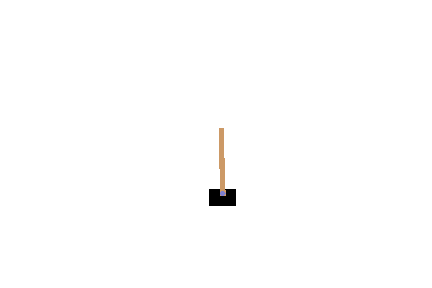
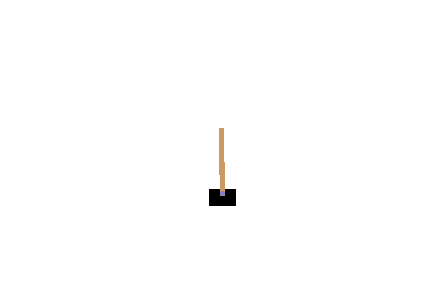
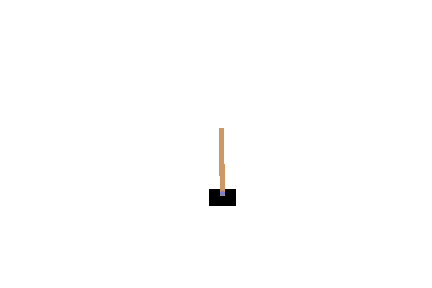
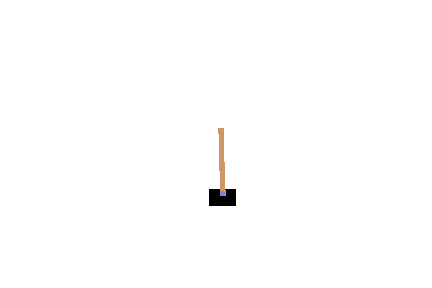
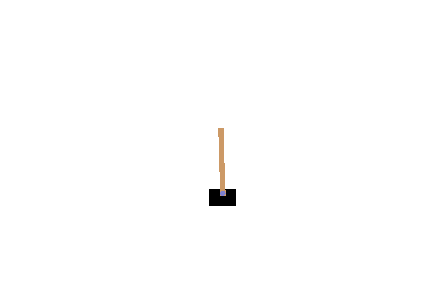
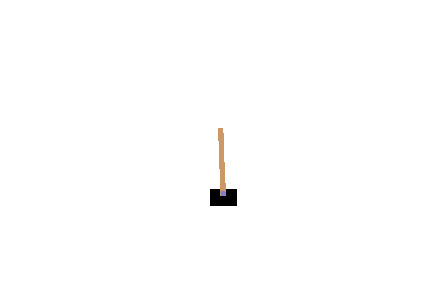
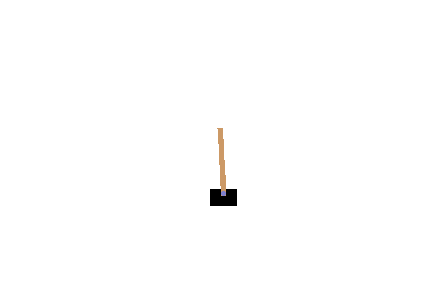
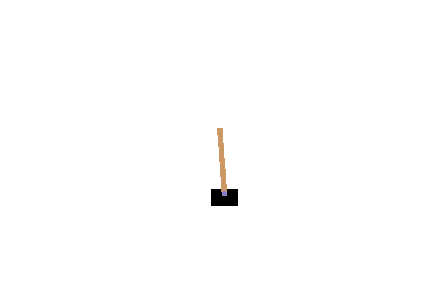
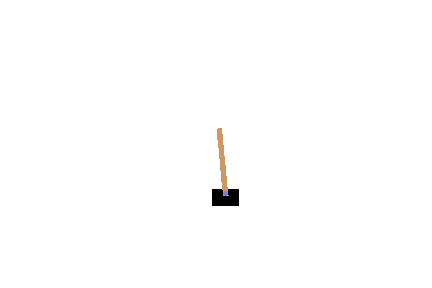
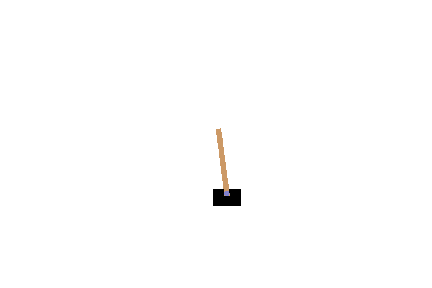
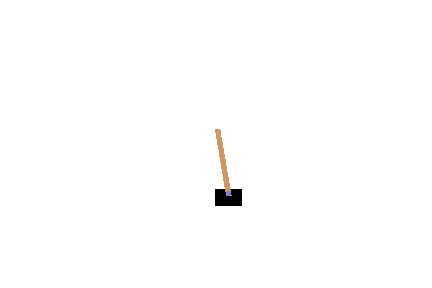
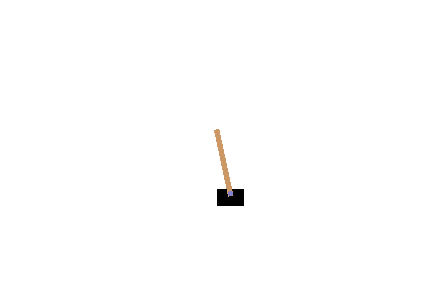

In [10]:
utils.display_frames_as_gif(frames)

### Selbst den Stab balancieren

Mit dem folgenden Code kannst du selbst einmal probieren den Stab zu balancieren. Unter der Grafik werden zwei Buttons für die zwei möglichen Aktionen angezeigt. Jedes mal wenn du einen Button klickst, wird ein Schritt in der Simulation mit der entsprechenden Aktion durchgeführt. Sobald der Stab zu weit kippt wird die Simulation automatisch neu gestartet.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


<IPython.core.display.Javascript object>


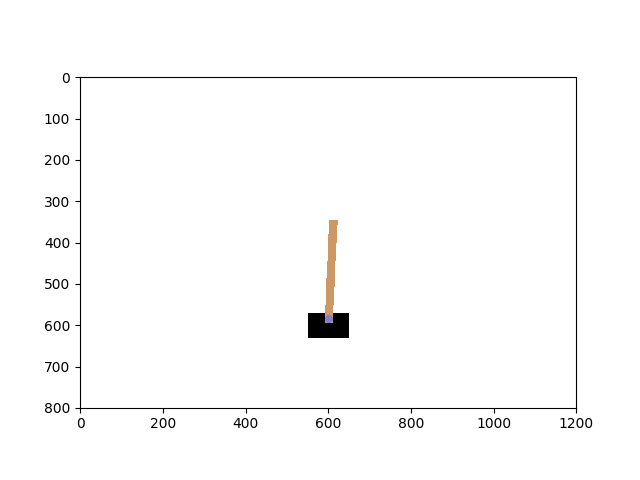

Button(description='<', style=ButtonStyle())

Button(description='>', style=ButtonStyle())

In [11]:
%matplotlib notebook
def leftclicked(something):
    """ Apply a force to the left of the cart"""
    onclick(0)

def rightclicked(something):
    """ Apply a force to the right of the cart"""
    onclick(1)
    
def display_buttons():
    """ Display the buttons you can use to apply a force to the cart """
    left = widgets.Button(description="<")
    right = widgets.Button(description=">")
    display(left, right)
    
    left.on_click(leftclicked)
    right.on_click(rightclicked)

# Create the environment and display the initial state
env = gym.make('CartPole-v0')
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
fig,ax = plt.subplots()
im = ax.imshow(firstframe) 

# Show the buttons to control the cart
display_buttons()


# Function that defines what happens when you click one of the buttons
frames = []
def onclick(action):
    global frames
    observation, reward, done, info = env.step(action)
    frame = env.render(mode = 'rgb_array')
    im.set_data(frame)
    frames.append(frame)
    print("Observation: {}. Reward: {}. Done: {}. Info: {}.".format(observation, reward, done, info), end='\r')
    if done:
        env.reset()
        print("\nDone!")

Nun können wir uns deinen Balanceversuch noch etwas flüssiger anschauen:

In [12]:
env.close()
if frames:
    utils.display_frames_as_gif(frames)

## Q-Learning Intuition

TODO
Hier sollte ein grundlegendes Verständnis für den DQN Algorithmus und einige Begriffe verschafft werden.


Diese vier evtl schon oben beim Gym.

- agent
- environment
- action
- state


- policy
- discounting
- optimal action value function Q*(s,a)
- Bellman equation
- model-free
- e-greedy strategy
- experience replay



## Die Einzelteile

Wie wir in der Q-Learning Intution gesehen haben besteht der Algorithmus aus mehreren einzelteilen. Diese wollen wir nun implementieren.

### Die Action Value  Function
Oder auch das Machine Learning Modell

In [13]:
def gym_model(n_actions, input_shape):
    
    # With the functional API we need to define the inputs.
    frames_input = keras.layers.Input(input_shape, name='frames')
    actions_input = keras.layers.Input((n_actions,), name='mask')

    flat = keras.layers.Flatten()(frames_input)
    hidden = keras.layers.Dense(16, activation='relu')(flat)
    hidden = keras.layers.Dense(16, activation='relu')(hidden)
    hidden = keras.layers.Dense(16, activation='relu')(hidden)
    output = keras.layers.Dense(n_actions)(hidden)

    # Finally, we multiply the output by the mask!
    filtered_output = multiply([output, actions_input])

    model = keras.models.Model(inputs=[frames_input, actions_input], outputs=filtered_output)
    optimizer = optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.95, epsilon=0.01)
    model.compile(optimizer, loss="mse")
    return model

In the paper [Human-level control through deep reinforcement
learning](http://www.davidqiu.com:8888/research/nature14236.pdf) DeepMind suggests using a separate network to predict target values and only update that network every 10000 iterations. 

In [14]:
def copy_model(model):
    model_copy = keras.models.clone_model(model)
    model_copy.set_weights(model.get_weights())
    return model_copy

### Discounting mit der Bellman Equation

In [15]:
def discount_bellman(rewards, next_Q_values, is_terminal, discount_factor):
    return rewards + np.invert(is_terminal).astype(np.float32) * discount_factor * np.max(next_Q_values, axis=1)

### Die Epsilon Greedy Strategie

In [16]:
def get_epsilon_for_iteration(iteration, max_iteration, max_q, min_q):
    if(iteration >= max_iteration):
        return min_q
    else:
        return ((min_q - max_q) / max_iteration) * iteration + max_q

In [17]:
get_epsilon_for_iteration(0, 1000000, 1.0, 0.1)

1.0

In [18]:
get_epsilon_for_iteration(999999,  1000000, 1.0, 0.1)

0.10000089999999995

In [19]:
get_epsilon_for_iteration(1000000,  1000000, 1.0, 0.1)

0.1

### Die Wahl der richtigen Aktion

In [20]:
def choose_best_action(model, state, action_space_size):
    # Make a "batch" out of the state.
    state_ext = np.expand_dims(state, axis=0)
    # Create a mask consisting out of ones for the model imput.
    action_mask = np.ones((state.shape[-1], action_space_size))
    logits = model.predict([state_ext,action_mask])[0]
    # TODO: do not use argmax but multinomal (needs a softmax layer?)
    return np.argmax(logits)

In [21]:
def e_greedy_choose_best_action(epsilon, model, state, action_space):
    if np.random.random() < epsilon:
        action = action_space.sample()
    else:
        action = choose_best_action(model, state, action_space.n)
    return action
        

In [22]:
def one_hot_encode(action, action_space_size):
    return keras.utils.np_utils.to_categorical(action, num_classes=action_space_size)

### Der State

The paper suggests to input the last four frames to the network, so it can figure out what the speed, directetion and acceleration of an object is. At the beginning of each game, we will initialise a buffer with 4 times the very first frame. Each game step we will remove the oldest frame and append the new frame. To do that we will implement functions that help updating the buffer.

In [23]:
def init_state_buffer(size, frame):
    return np.stack([frame] * size, axis = 1)

def update_state_buffer(state_buffer, new_frame):
    return np.append(state_buffer[:,1:], np.expand_dims(new_frame, axis=1), axis = 1)

In [24]:
def preprocess(state):
    return state

# Training Loop

### Hyperparams

In [25]:
MINIBATCH_SIZE = 32
REPLAY_MEMORY_SIZE = 5000 
AGENT_HISTORY_LENGTH = 4
DISCOUNT_FACTOR = 0.99
REPLAY_START_SIZE = 100
MAXIMUM_ITERATIONS = 5000

### Init

In [29]:
env = gym.make(environment)
memory = Ringbuffer.RingBuf(REPLAY_MEMORY_SIZE)
model = gym_model(env.action_space.n, (env.observation_space.shape[0],AGENT_HISTORY_LENGTH))

logdir = os.path.join("logs", datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
logger = tensorboard_logging.Logger(logdir)
iteration = 0
start_episode = 0

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Train Model while playing

In [30]:
def q_iteration(env, model, discount_factor, batch_size, iteration, state, replay_memory):

    epsilon = get_epsilon_for_iteration(iteration, 1000, 1.0, 0.1)
    
    action = e_greedy_choose_best_action(epsilon, model, state, env.action_space)
    one_hot_action = one_hot_encode(action, env.action_space.n)

    new_frame, reward, is_done, _ = env.step(action)
    new_frame = preprocess(new_frame)
    next_state = update_state_buffer(state, new_frame)
   
    memory.add(state, one_hot_action, next_state, reward, is_done)
    state = next_state
    
    states_batch, action_batch, next_states_batch, reward_batch, done_batch = memory.sample_batch(batch_size)
    
    next_Q_values_batch = model.predict([next_states_batch, np.ones(action_batch.shape)])
    Q_values_batch = discount_bellman(reward_batch, next_Q_values_batch, done_batch, discount_factor)
    
    model.fit([states_batch, action_batch], action_batch * Q_values_batch[:, None],
        epochs=1, batch_size=len(states_batch), verbose=0)
    
    return state, is_done, reward

In [31]:
env = gym.make(environment)
for episode in tqdm(itertools.count(start=start_episode)):
    total_reward = 0
    is_done = False
    first_state = preprocess(env.reset())
    state = init_state_buffer(AGENT_HISTORY_LENGTH, first_state)

    while not is_done:
        state, is_done, reward = q_iteration(env, model, DISCOUNT_FACTOR, MINIBATCH_SIZE, iteration, state, memory)
        iteration += 1
        total_reward += reward
        
    logger.log_scalar("total_reward", total_reward, iteration)
        
if iteration >= MAXIMUM_ITERATIONS:
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/fabianh/anaconda/envs/gym/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/fabianh/anaconda/envs/gym/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/fabianh/anaconda/envs/gym/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



KeyboardInterrupt: 

## Play a game

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.



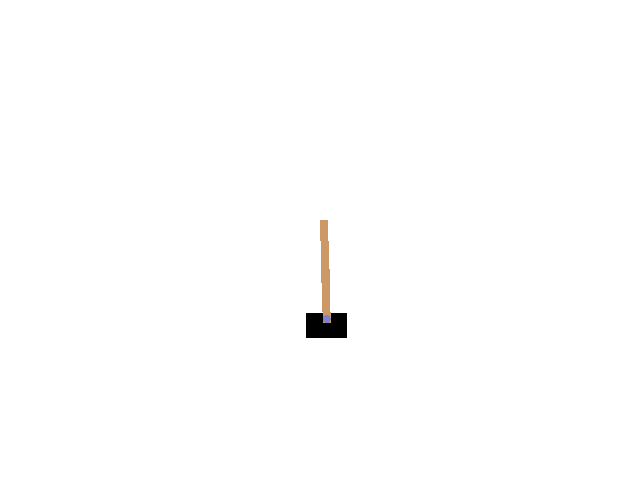
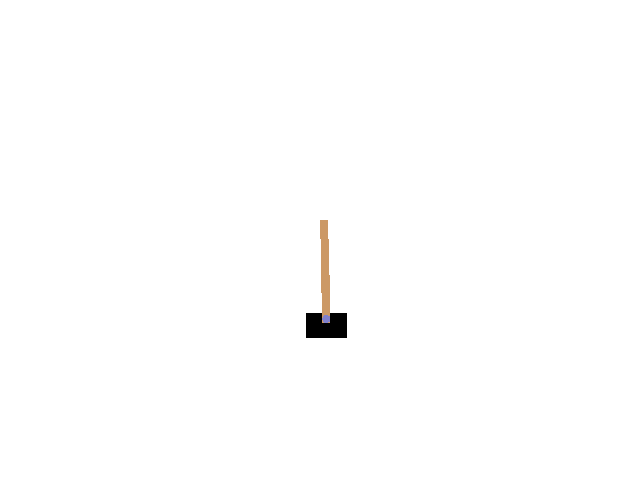
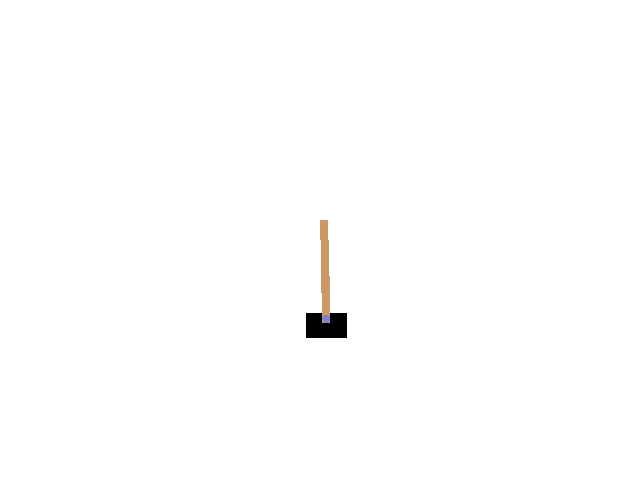
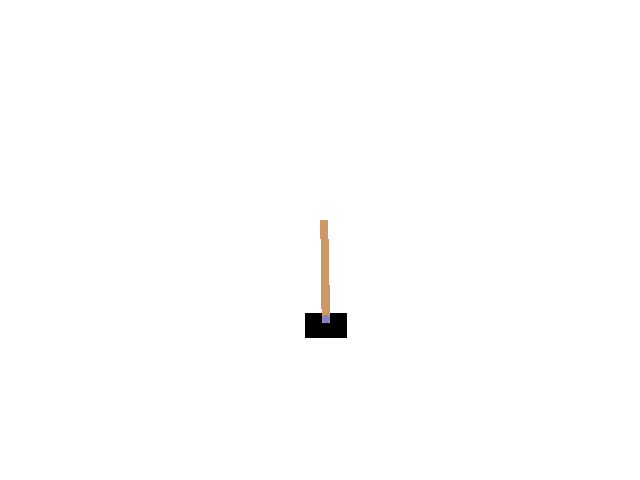
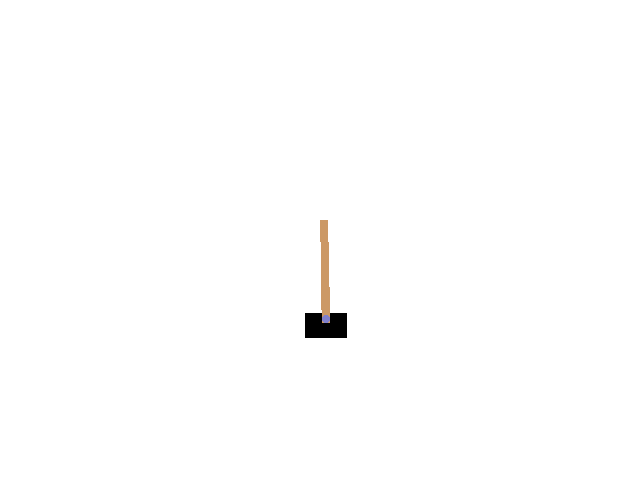
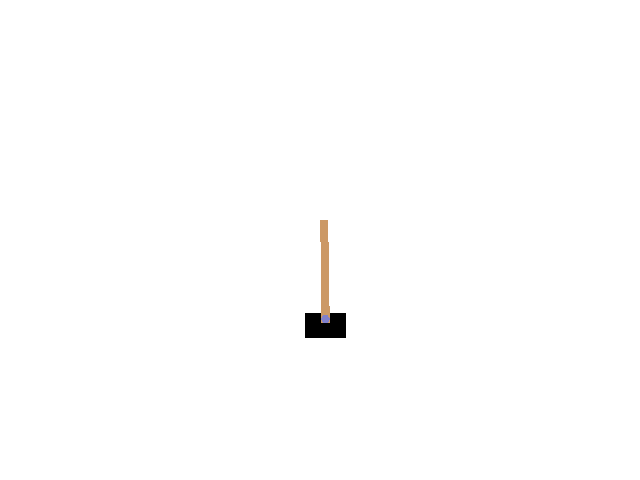
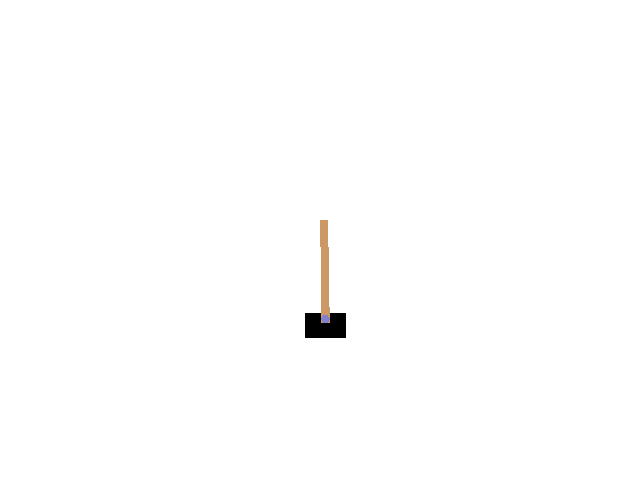
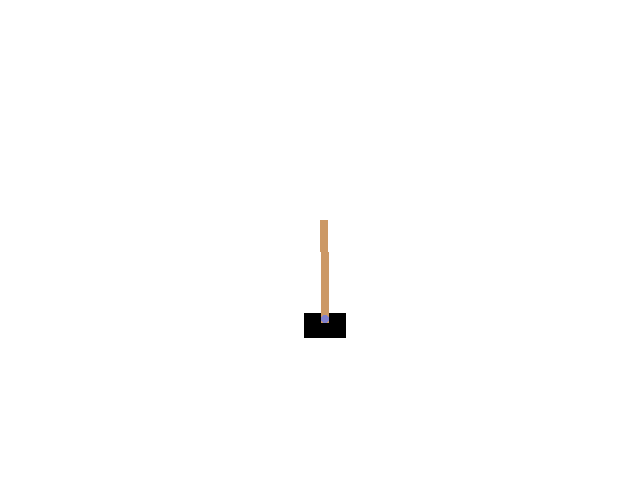
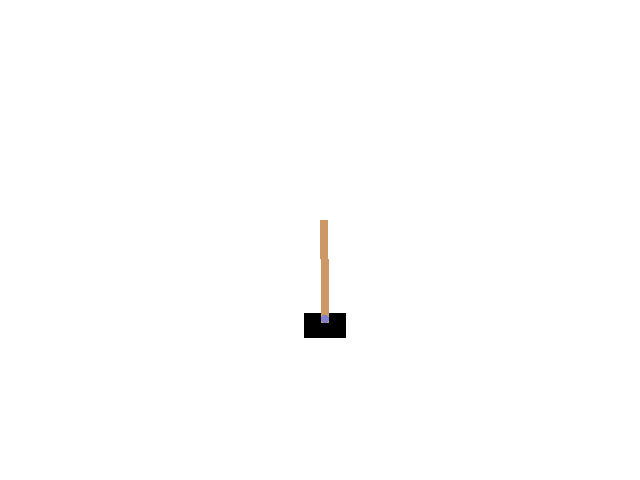
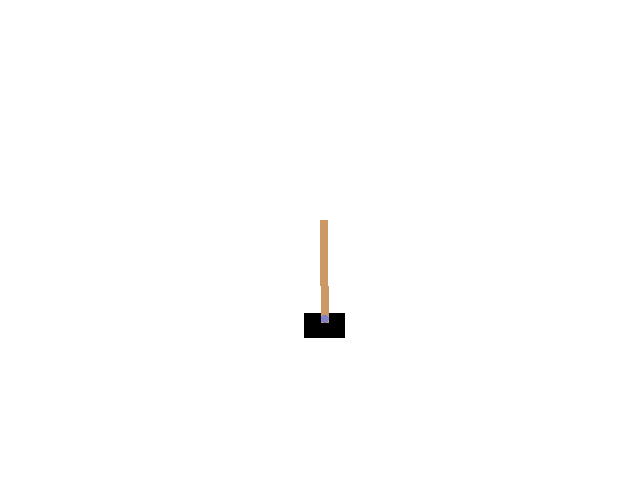
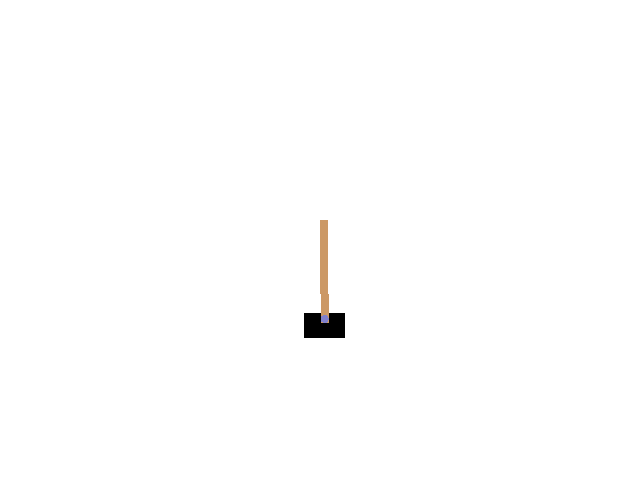
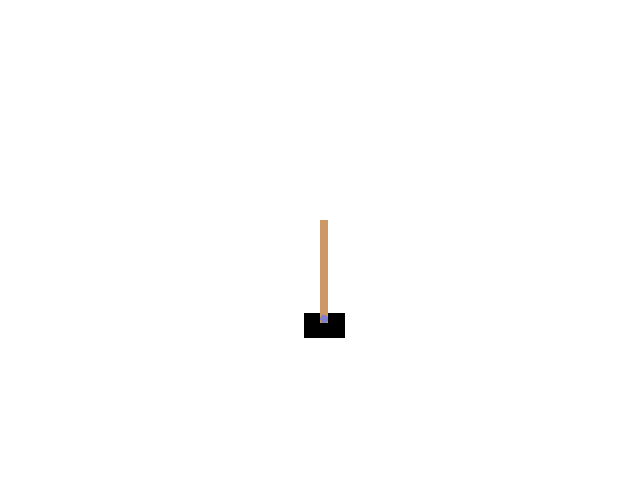
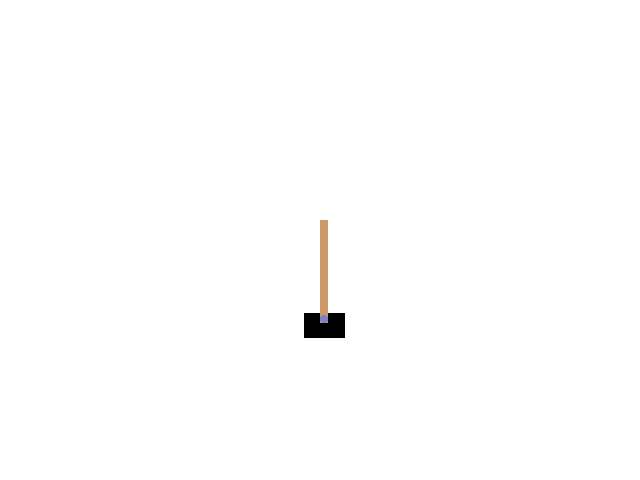
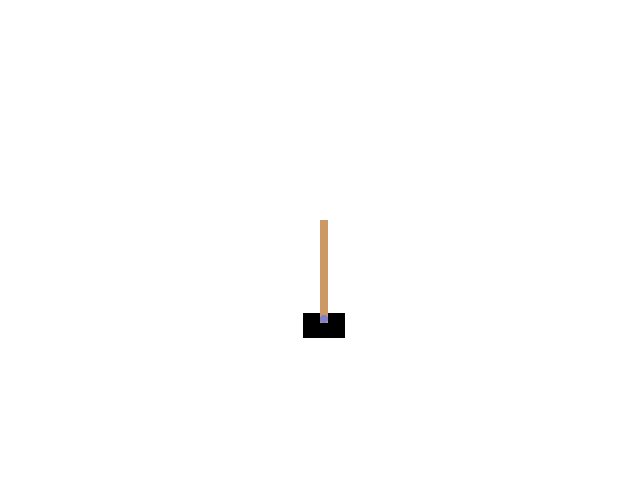
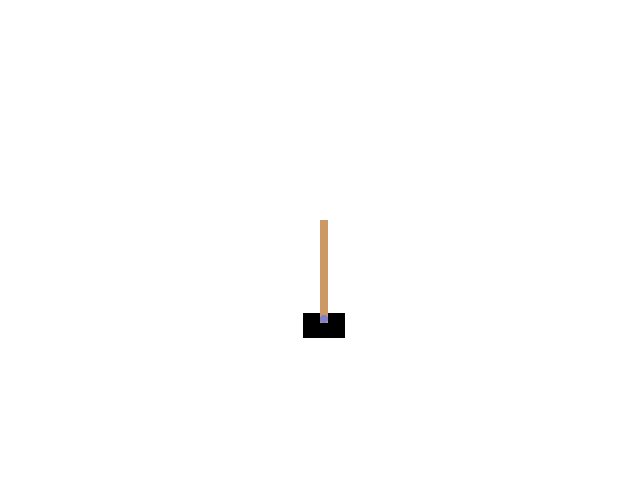
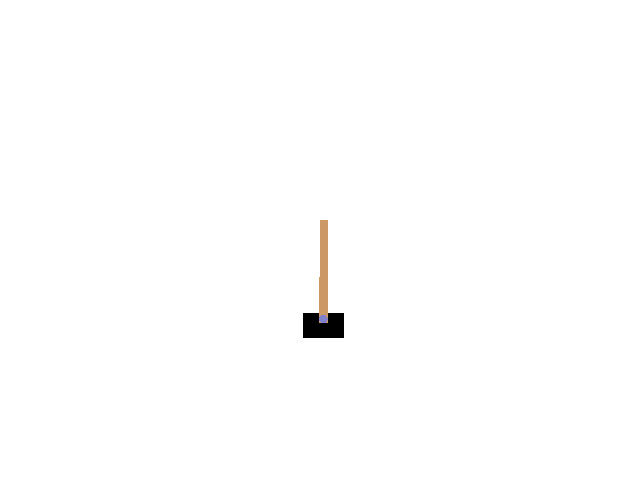
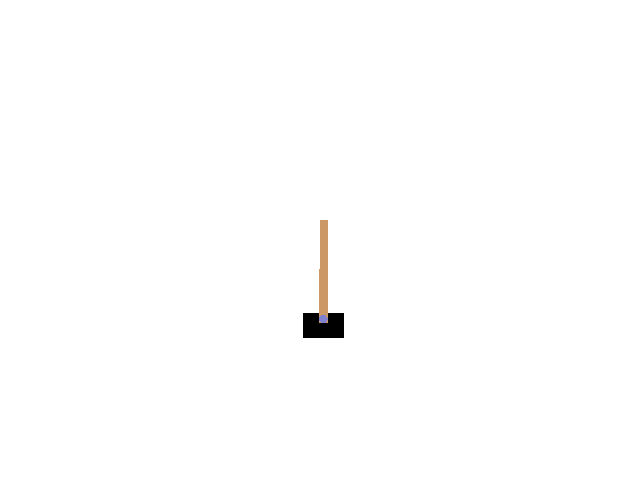
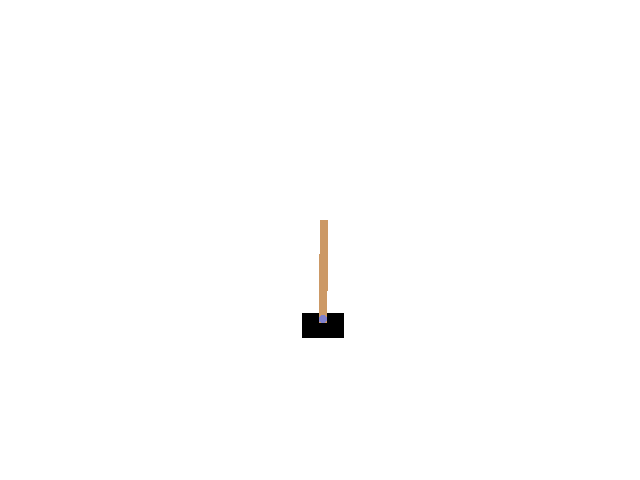
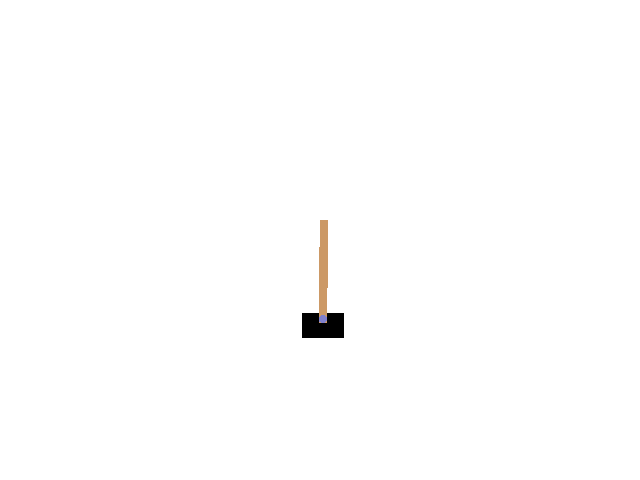
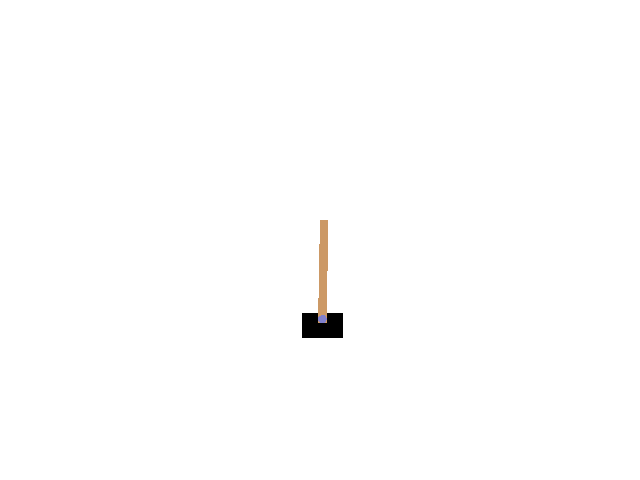
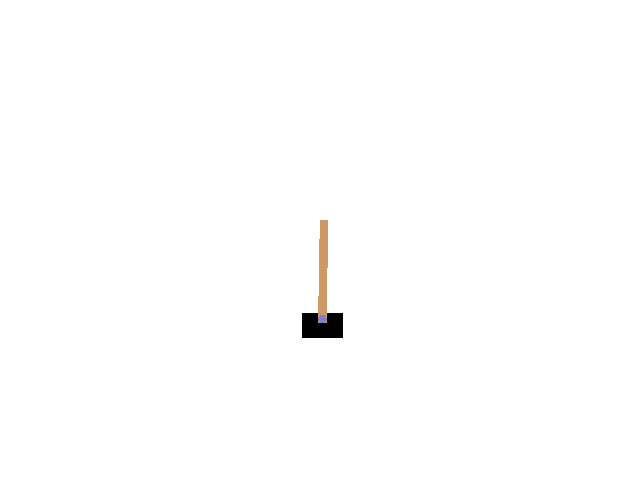
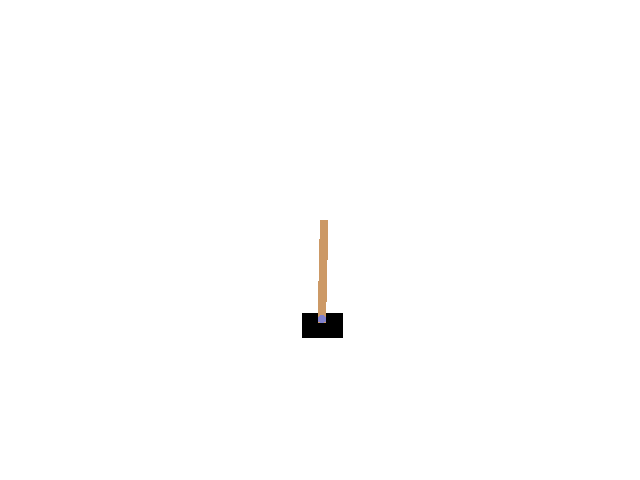
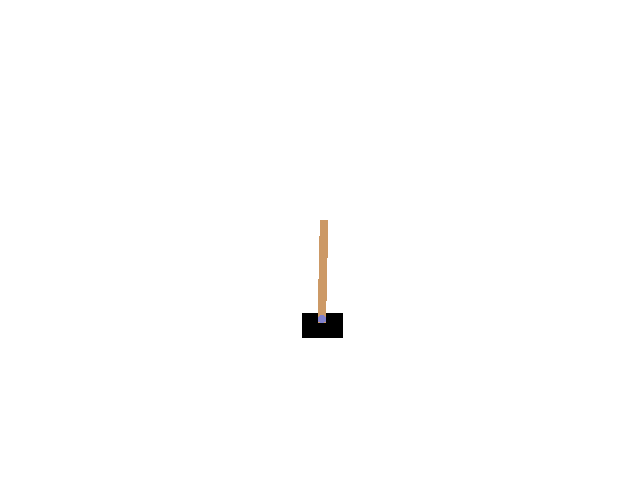
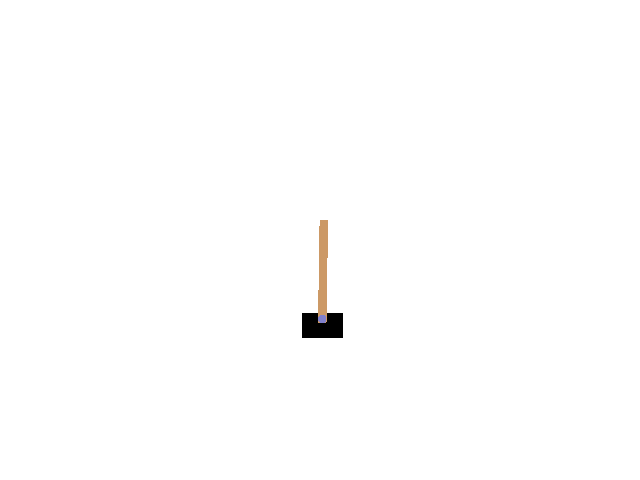
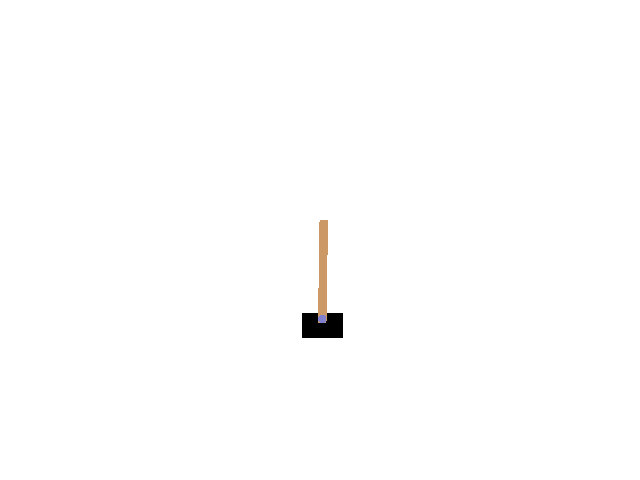
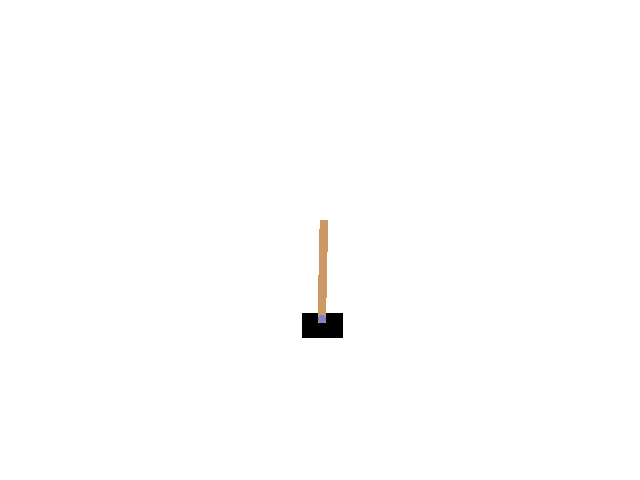
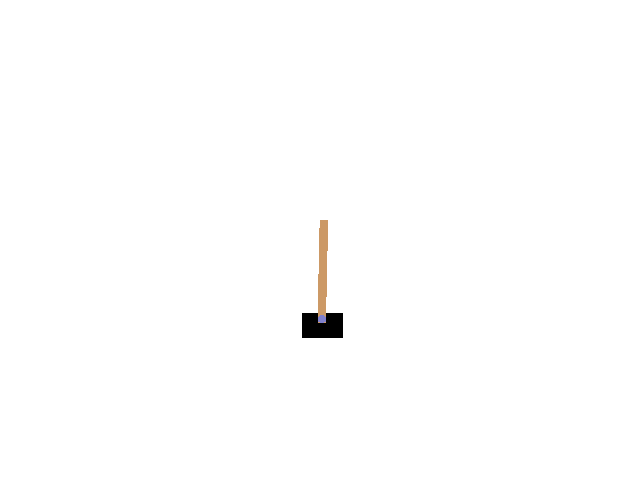
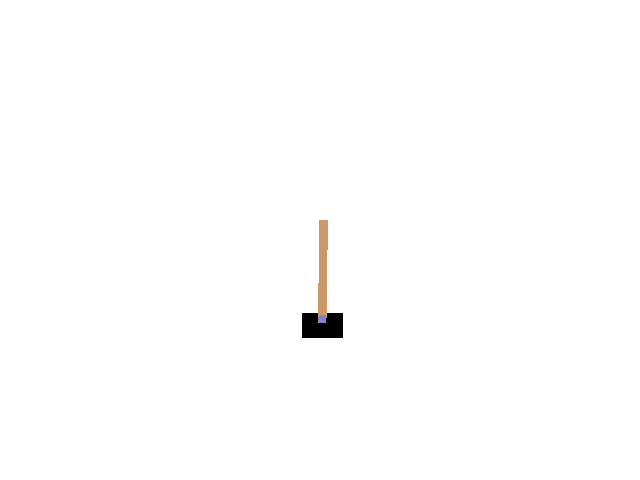
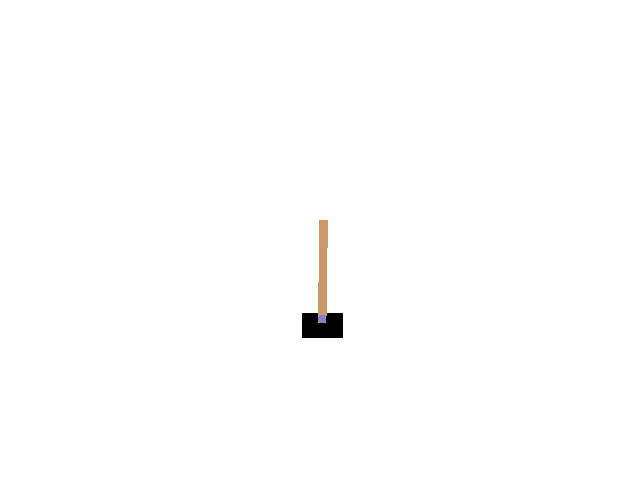
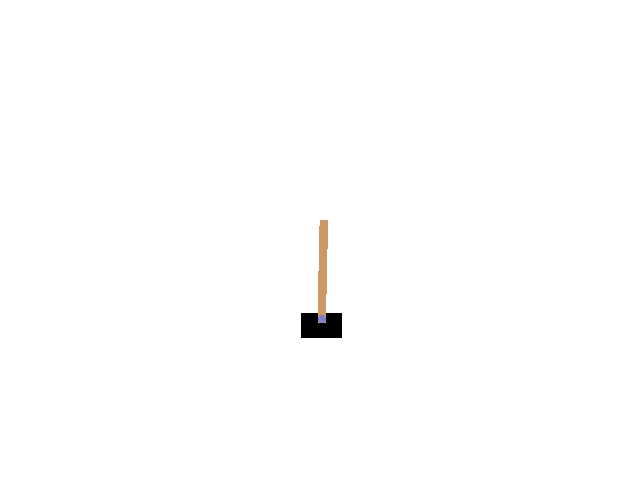
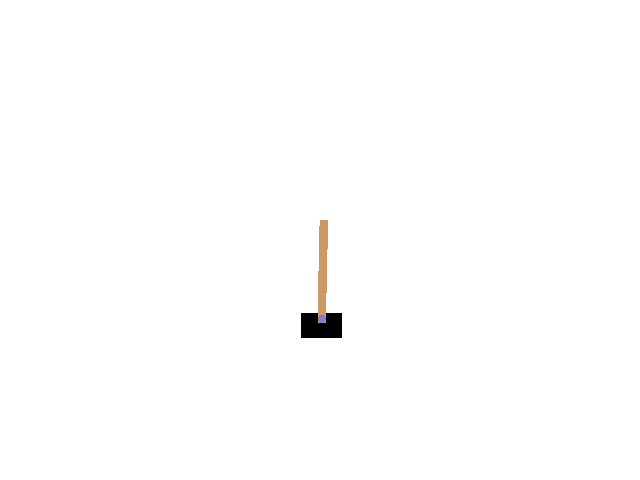
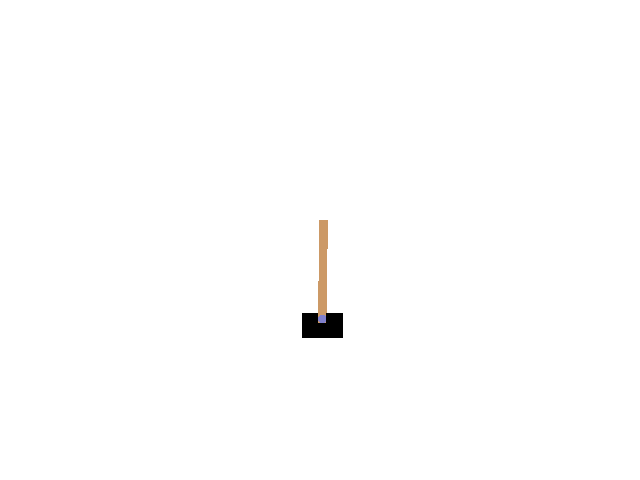
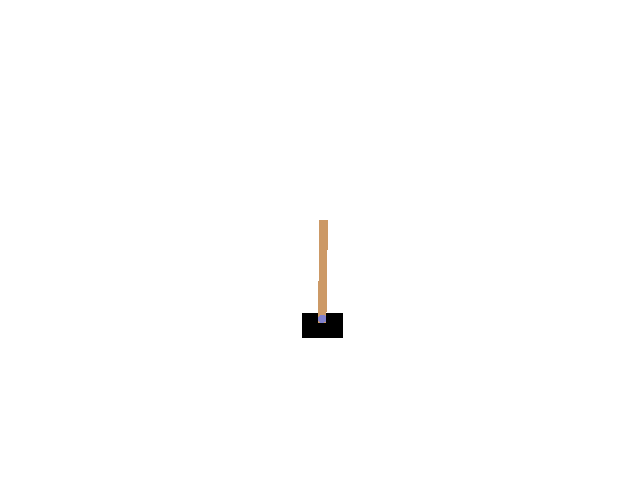
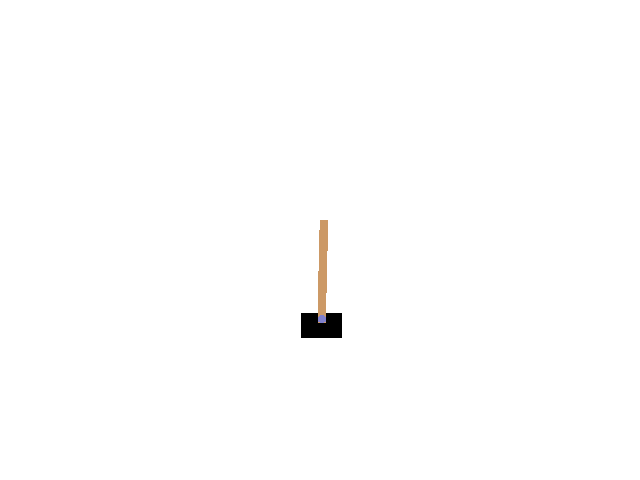
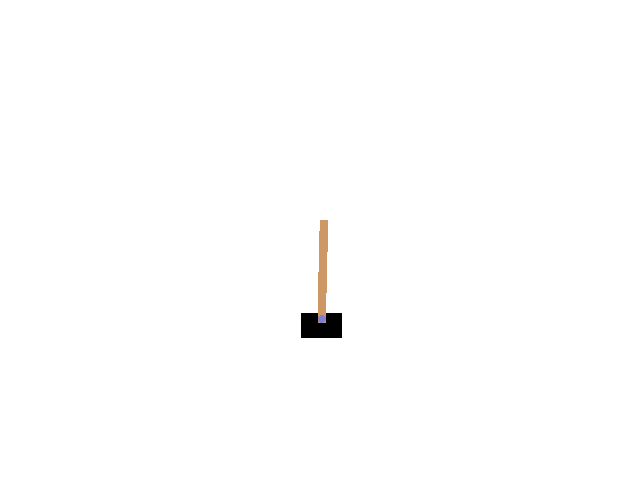
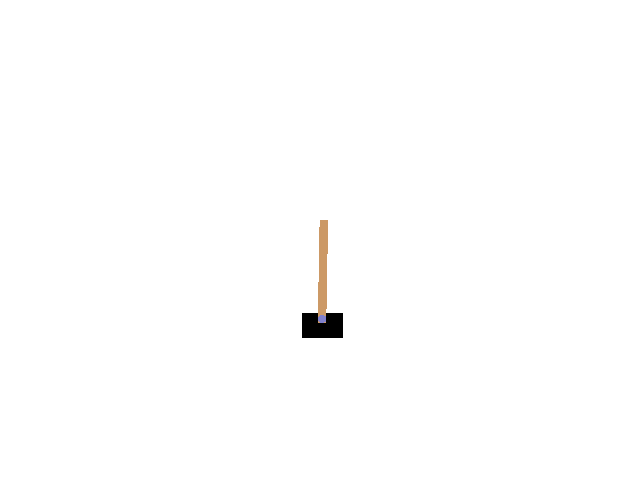
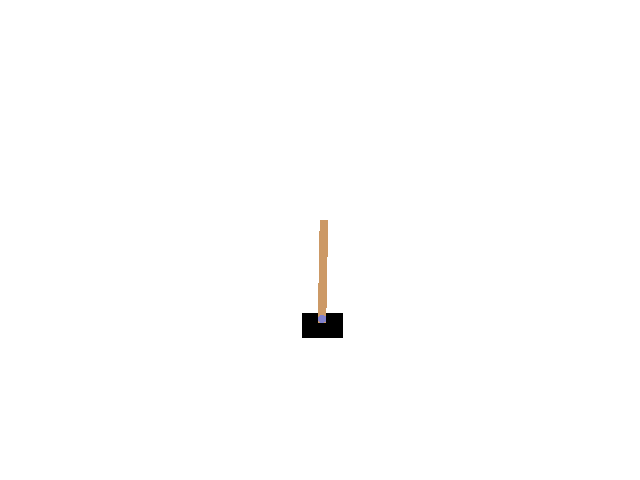
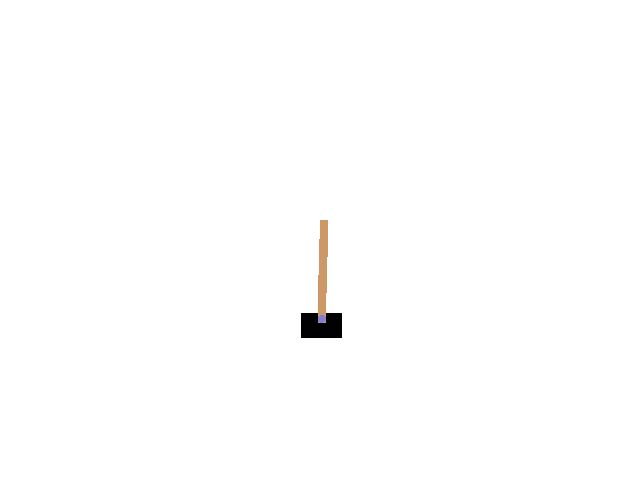
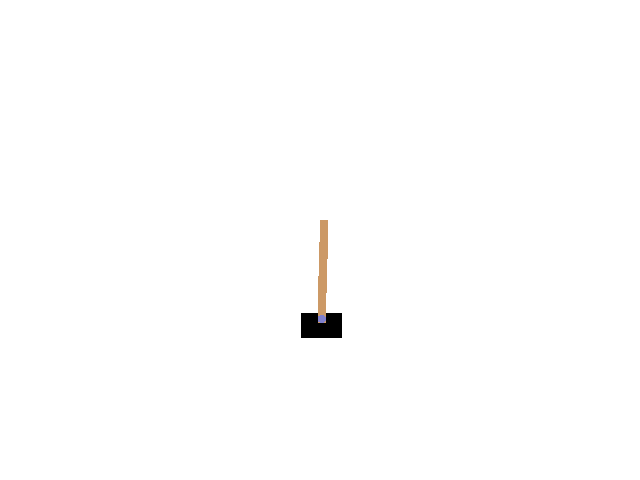
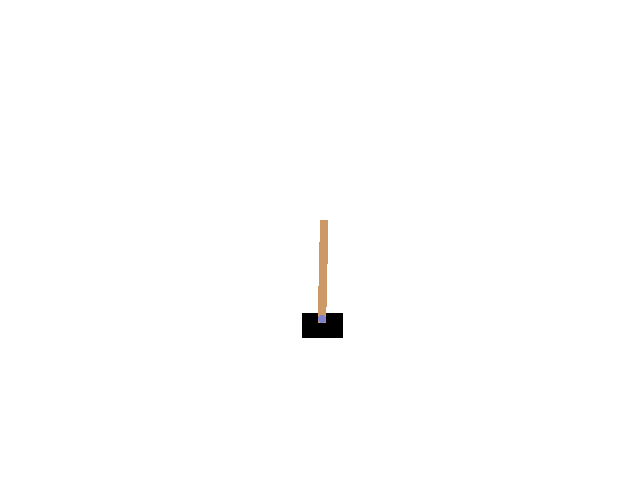
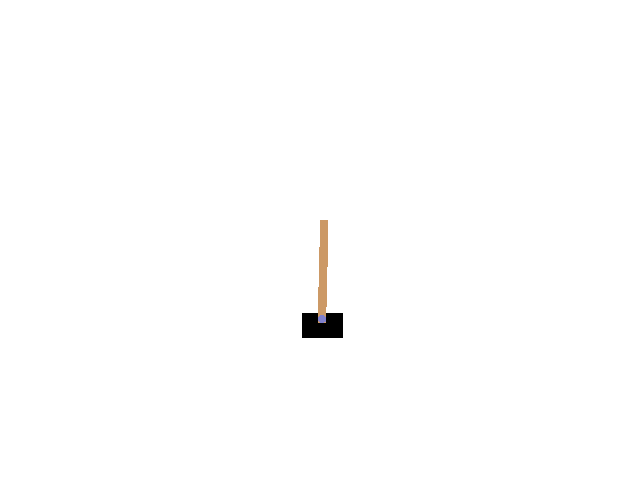
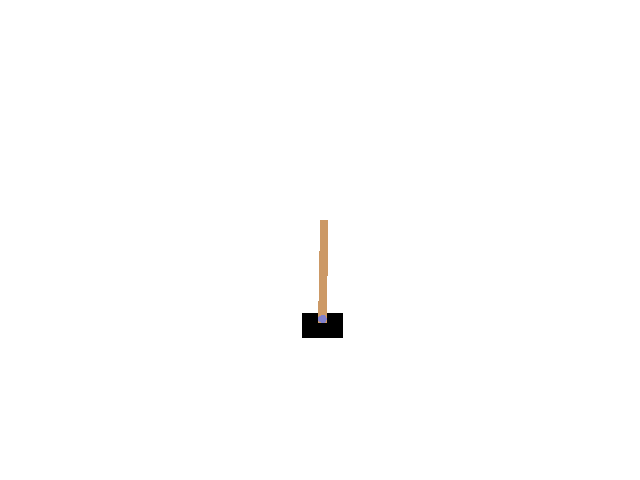
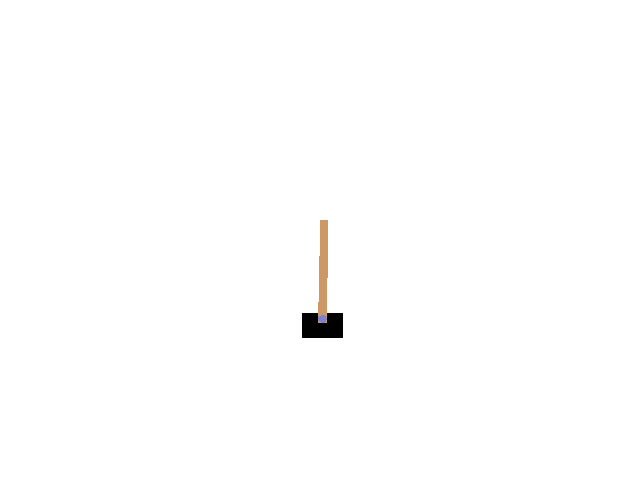
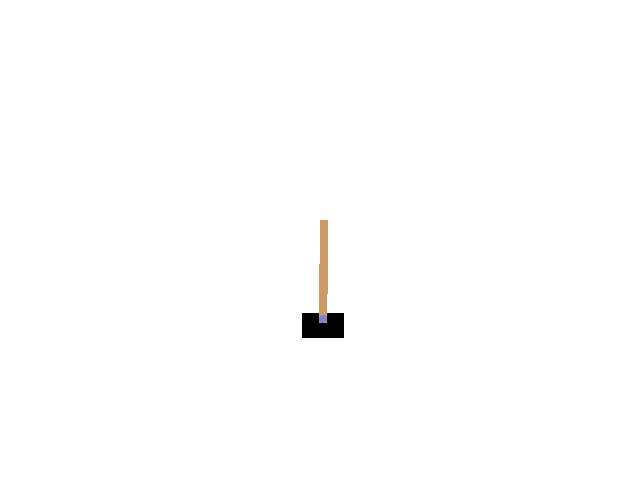
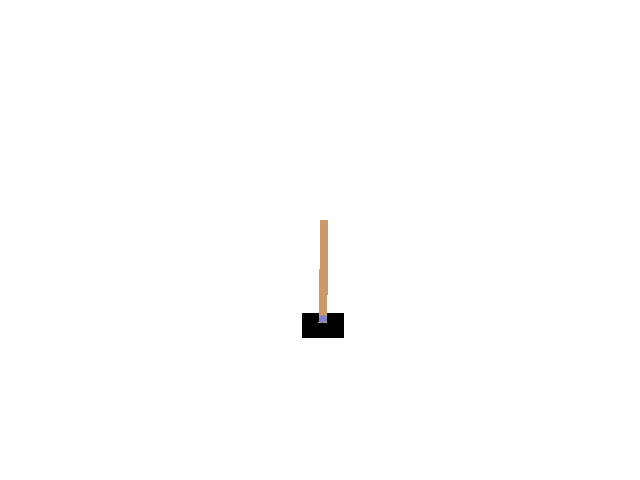
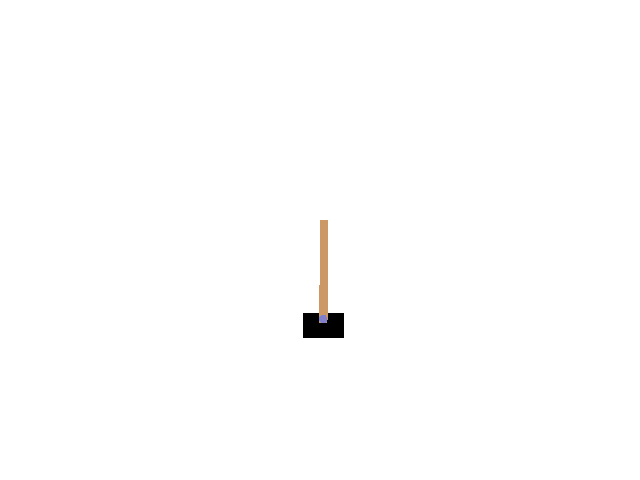
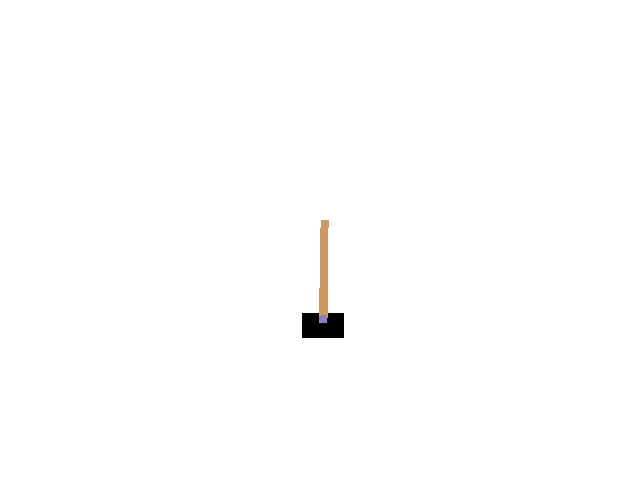
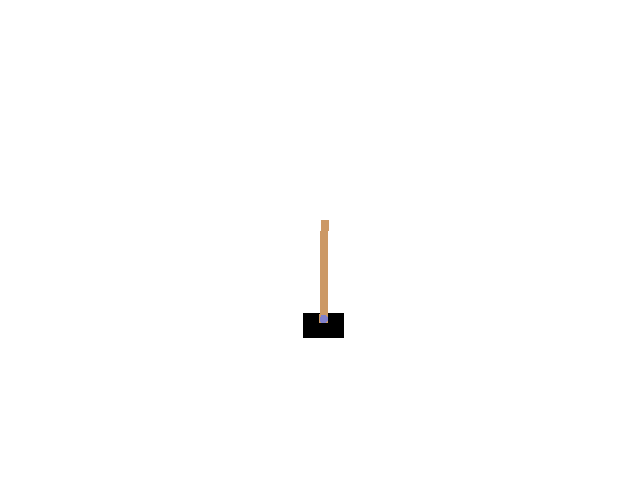
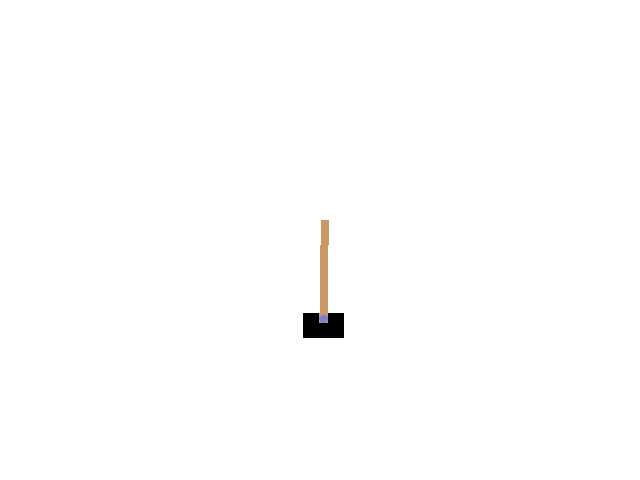
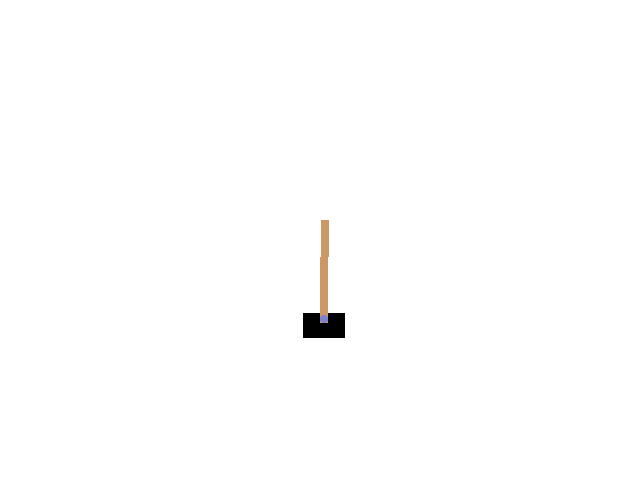
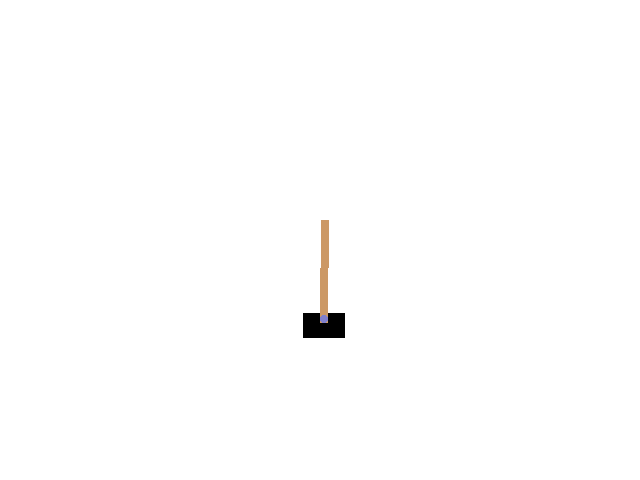
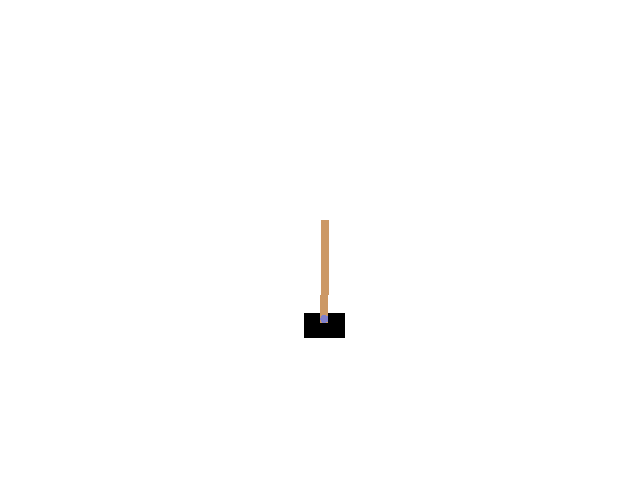
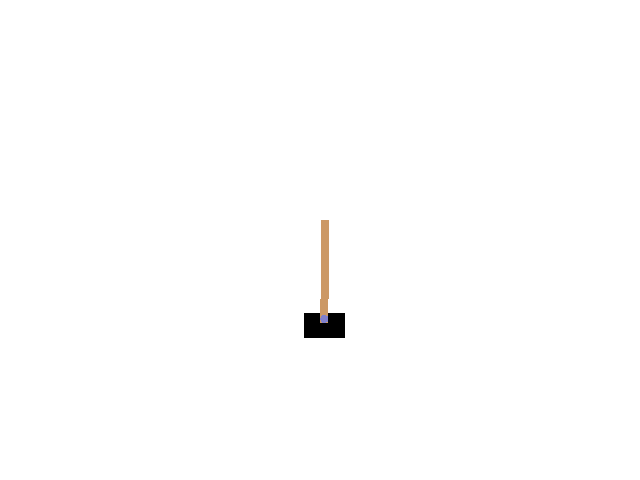
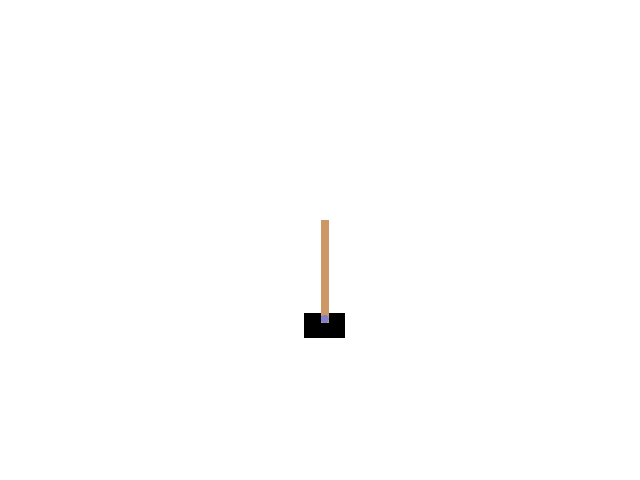
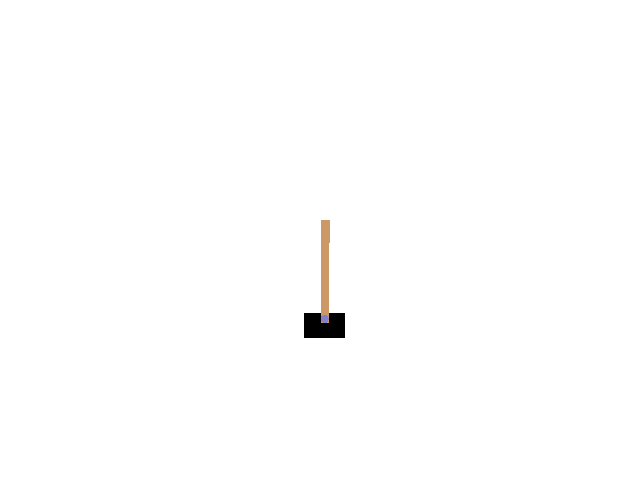
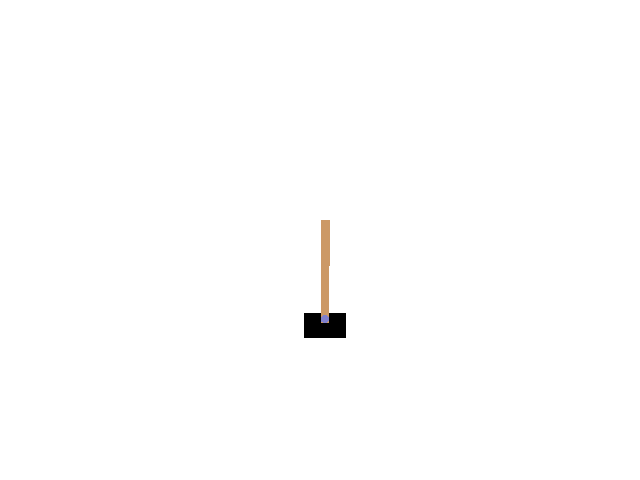
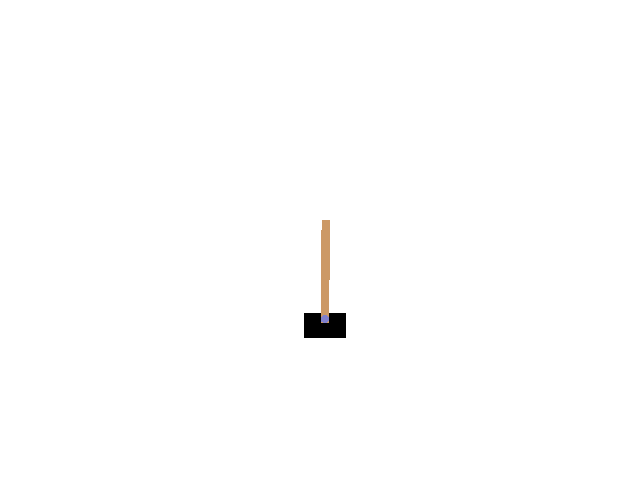
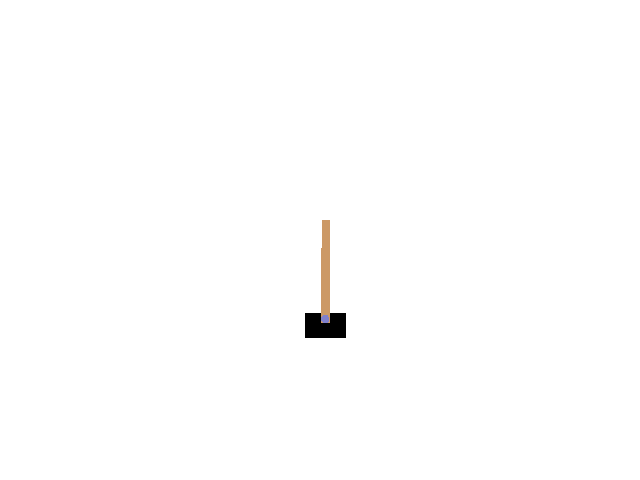
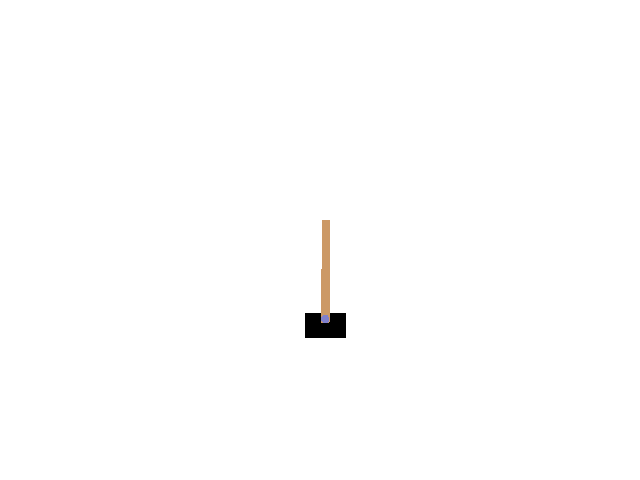
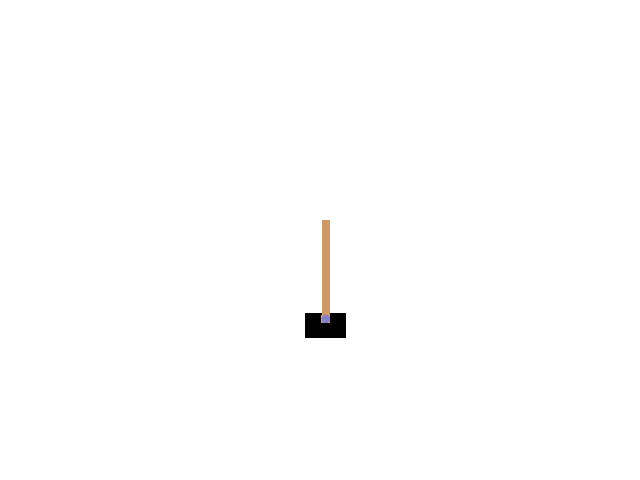
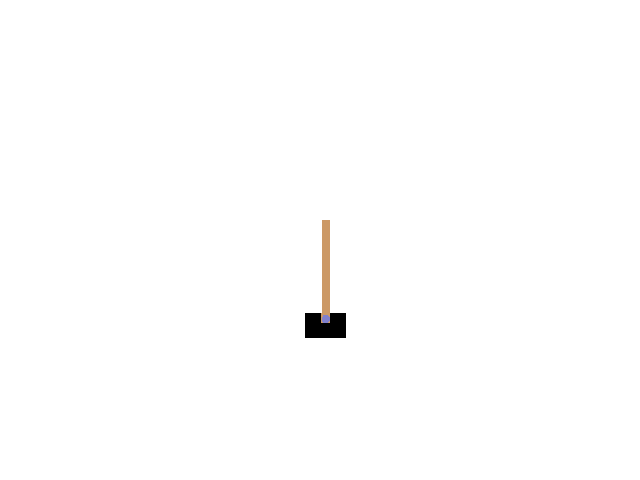
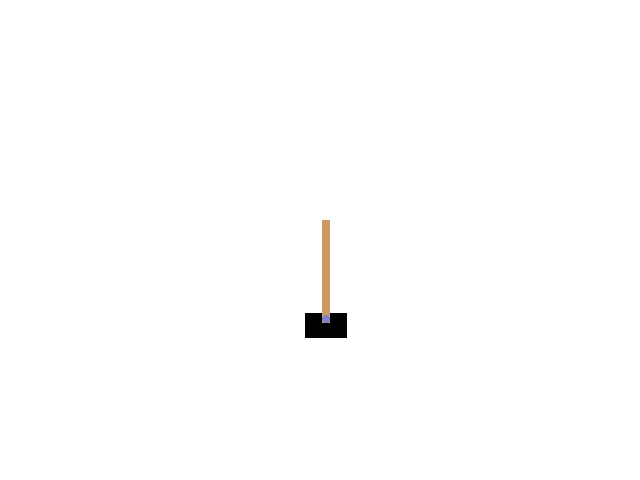
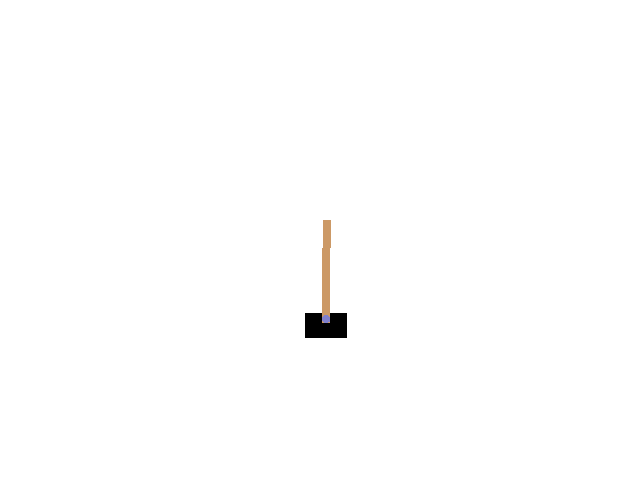
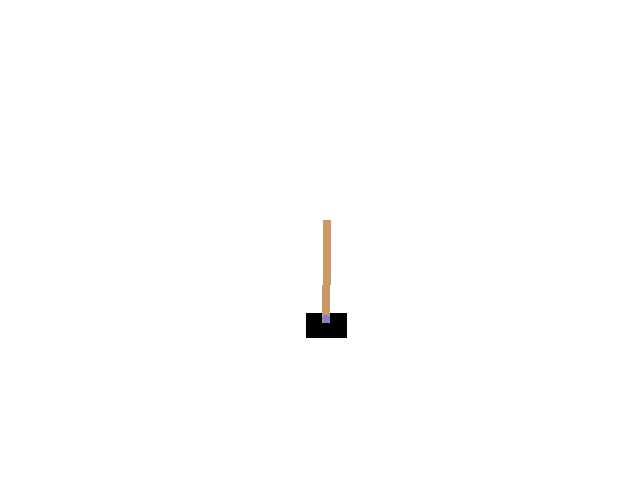
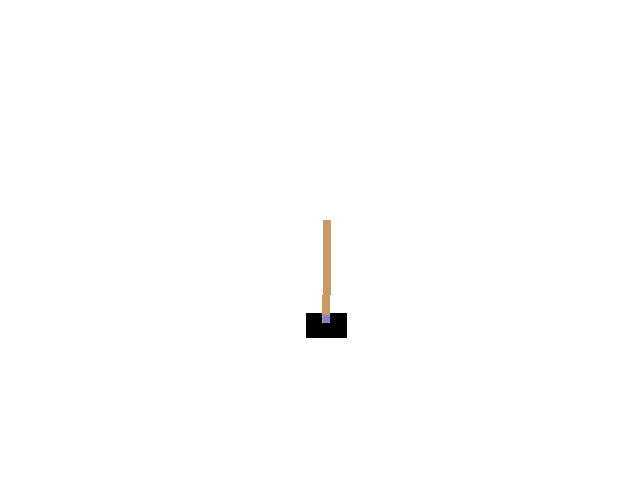
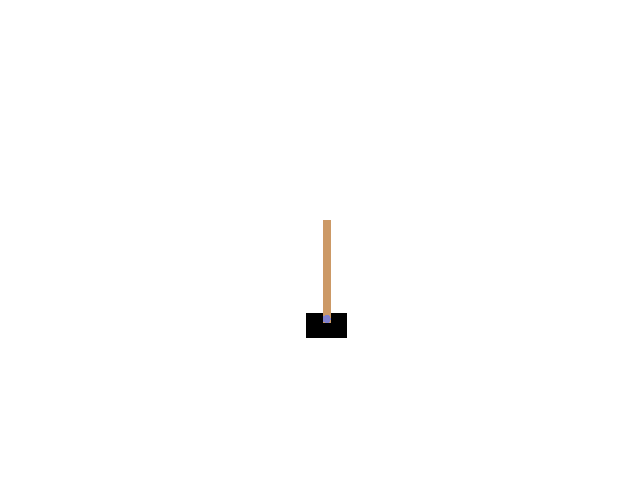
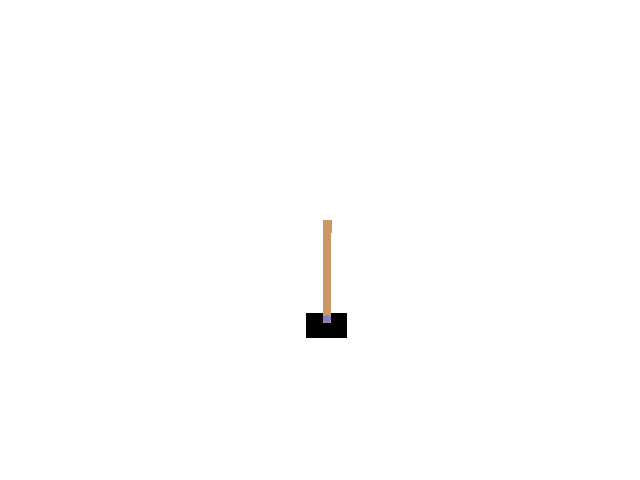
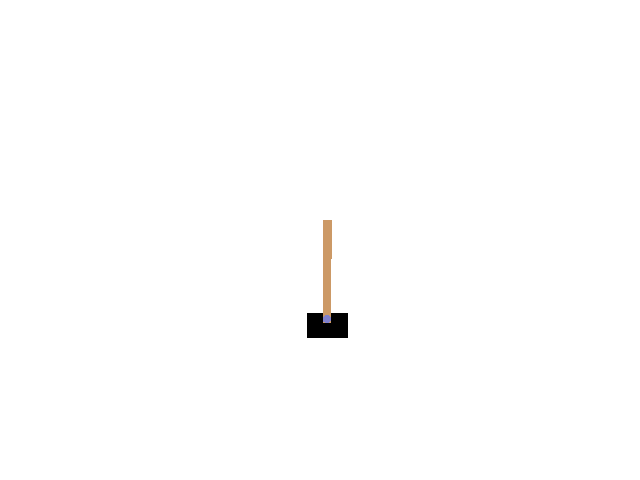
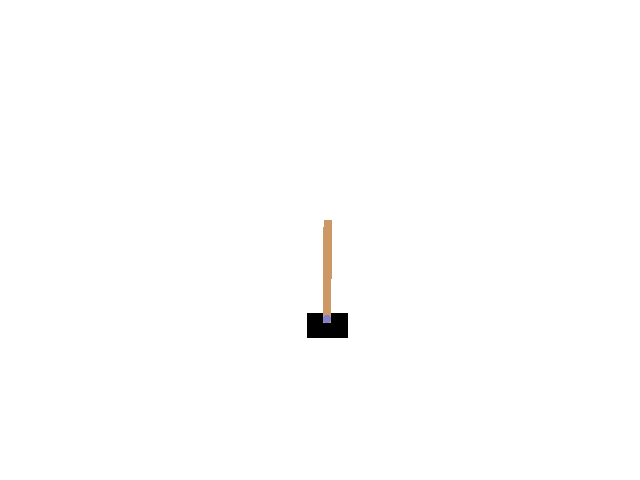
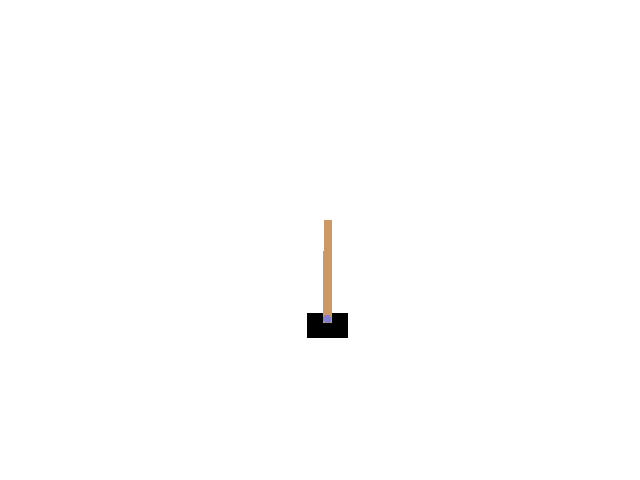
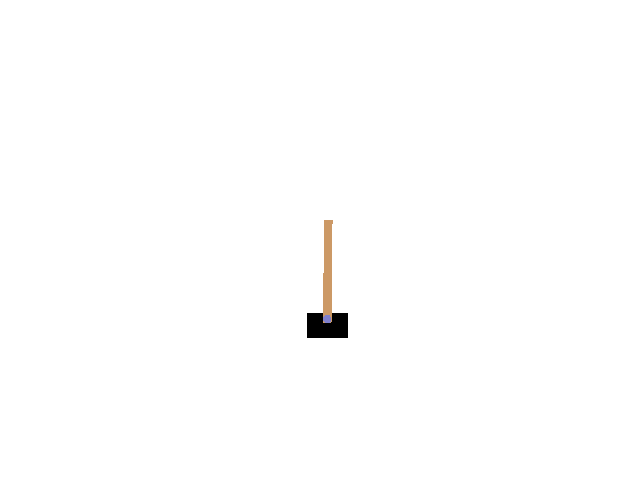
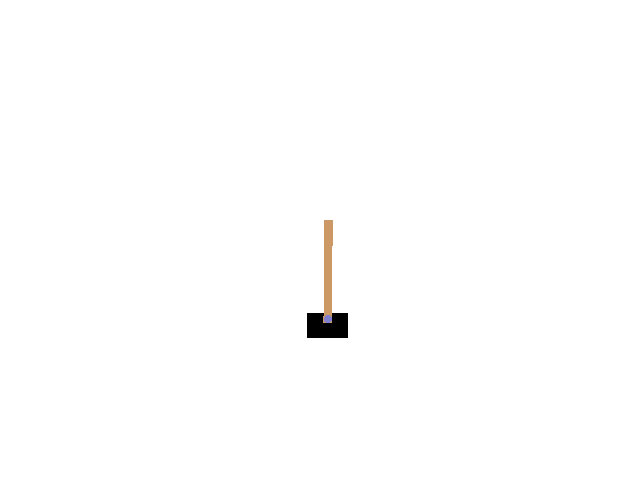
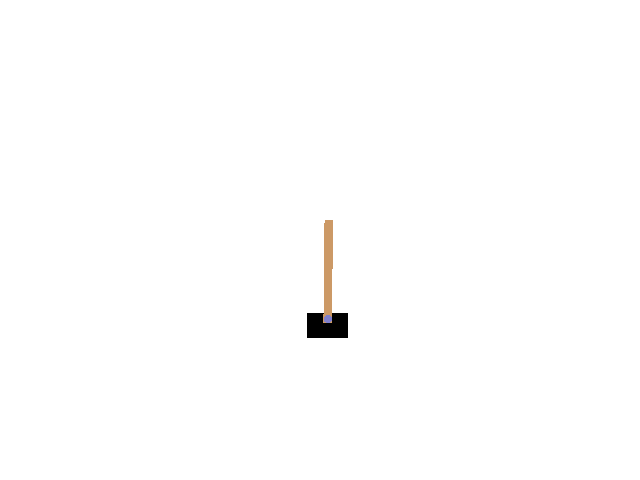
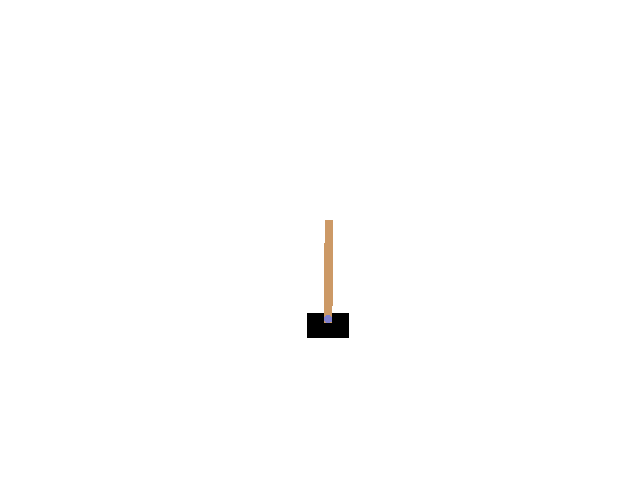
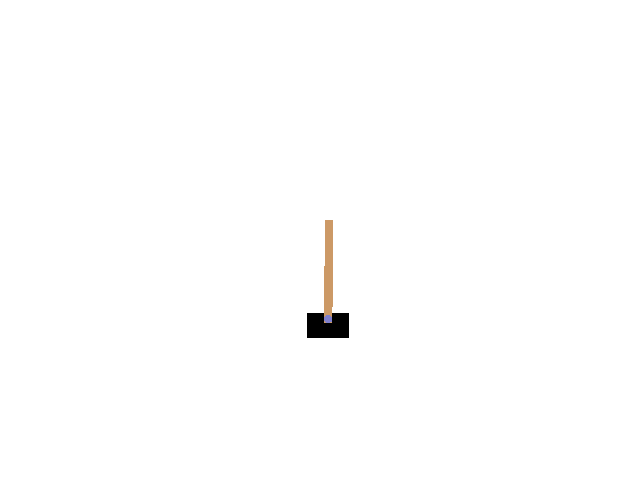
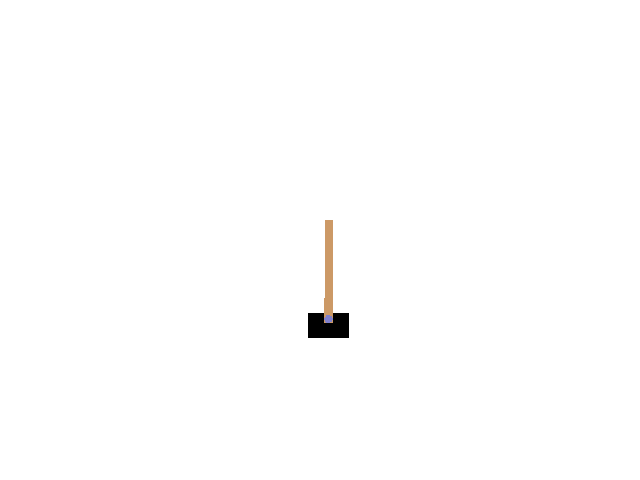
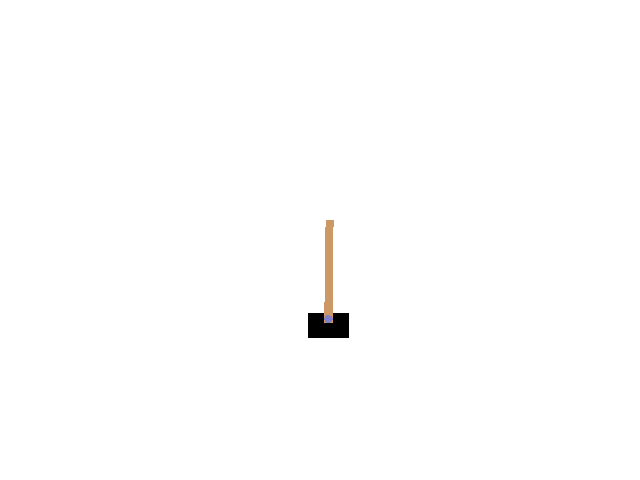
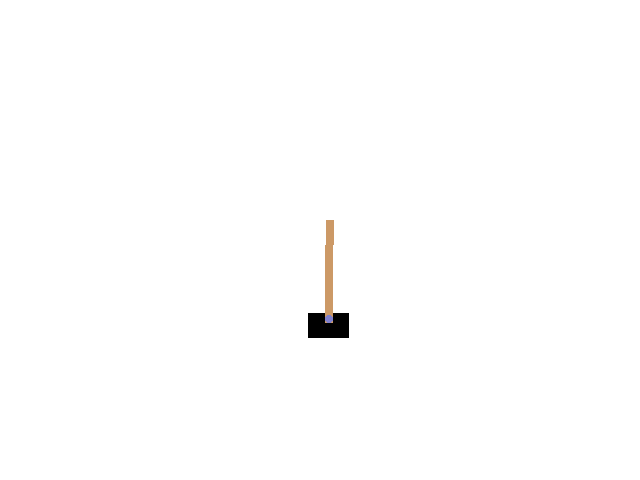
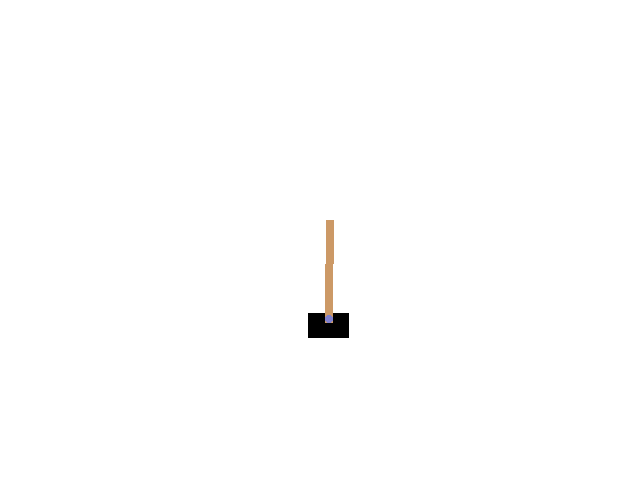
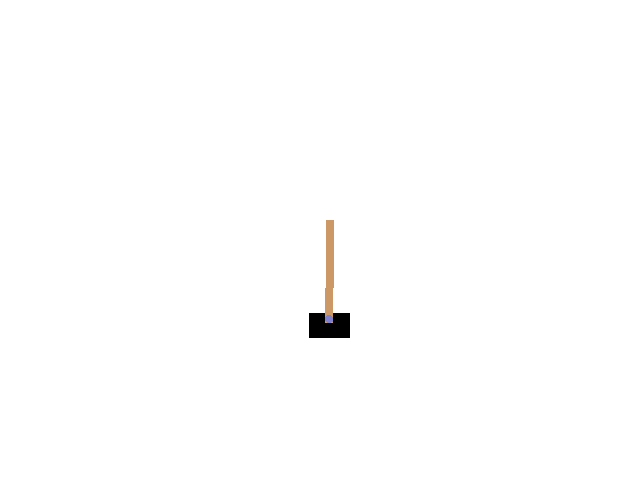
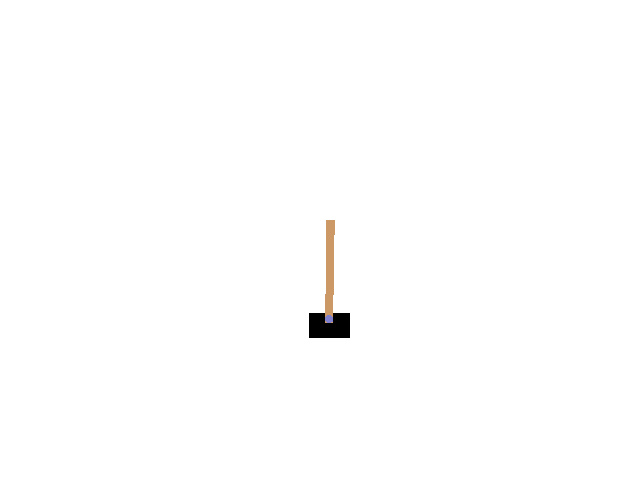
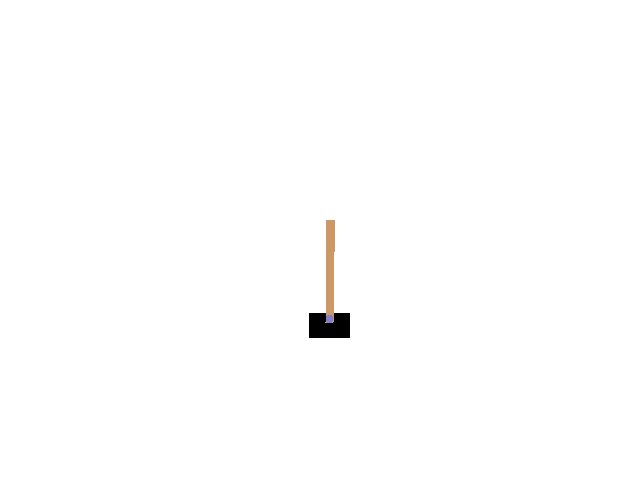
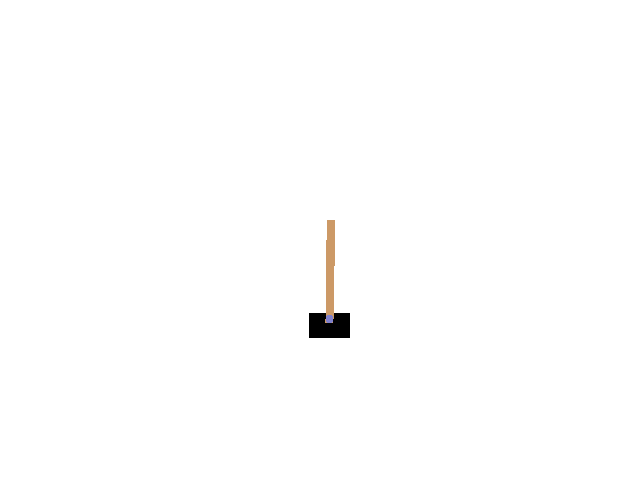
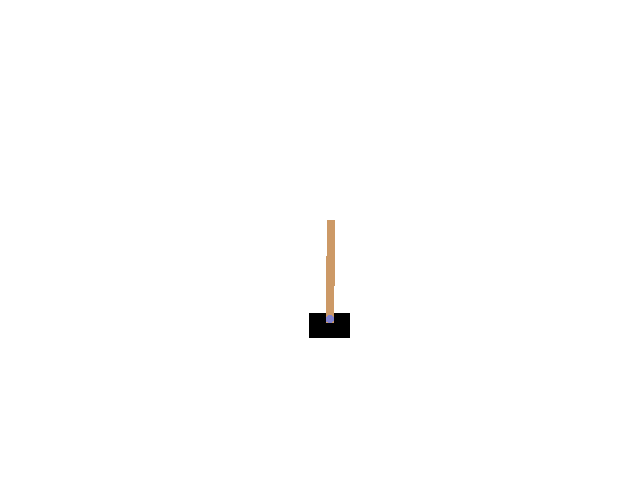
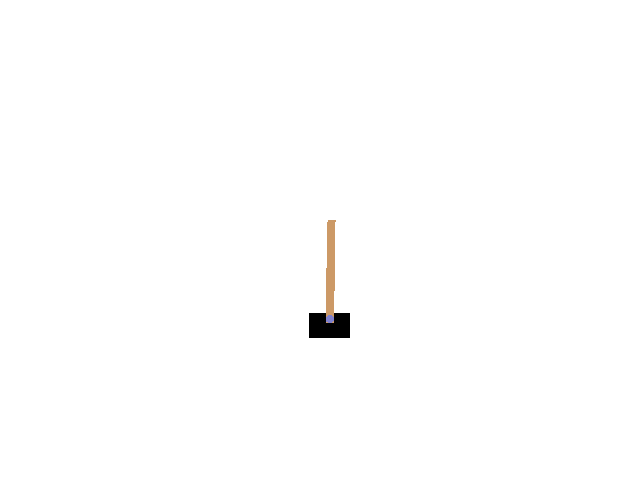
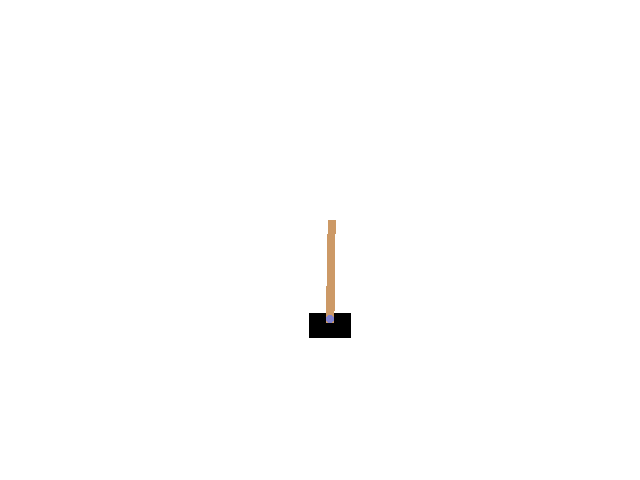
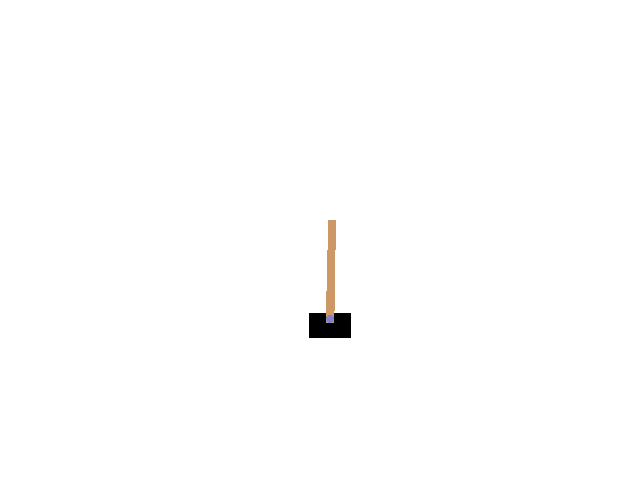
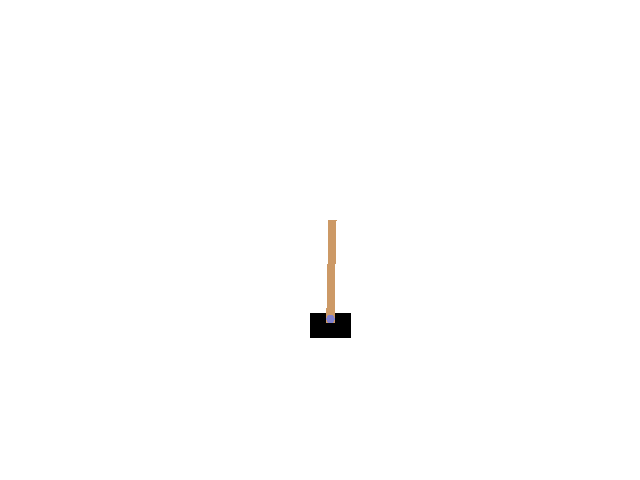
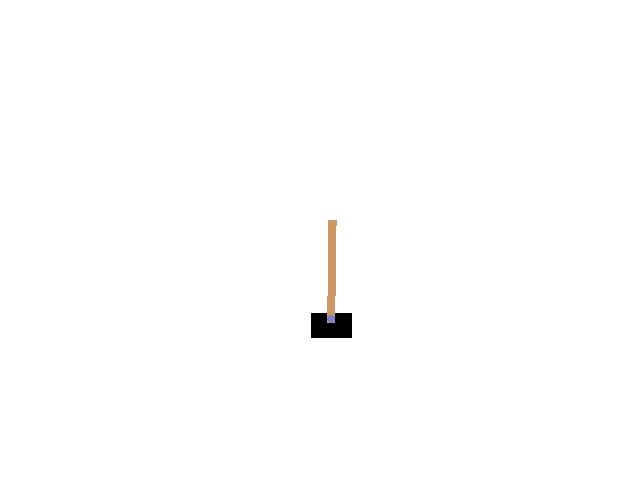
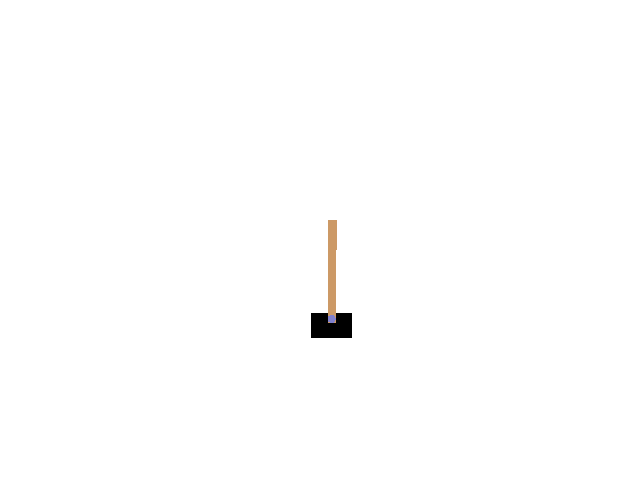
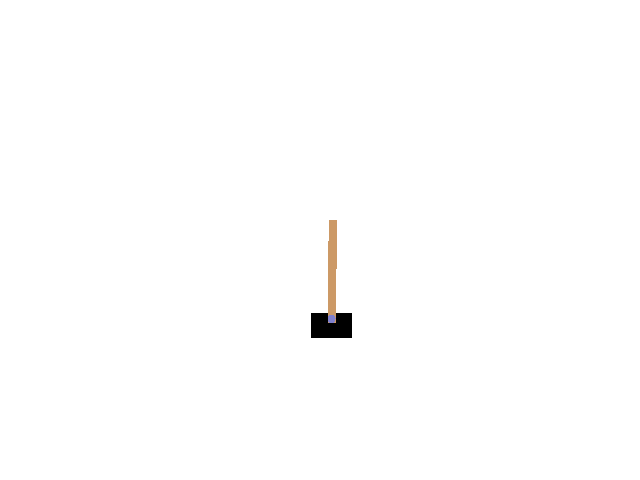
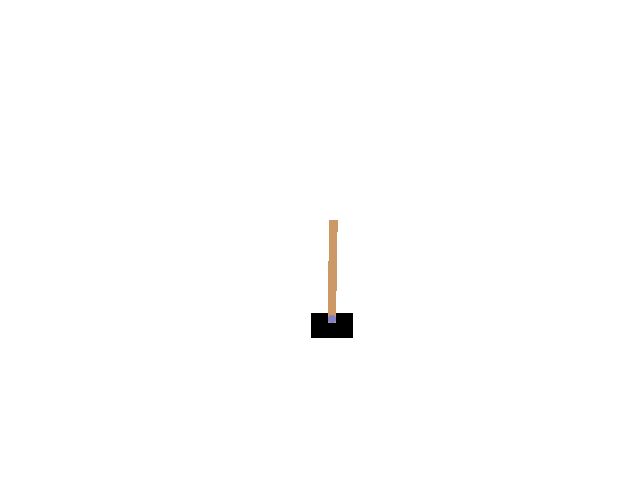
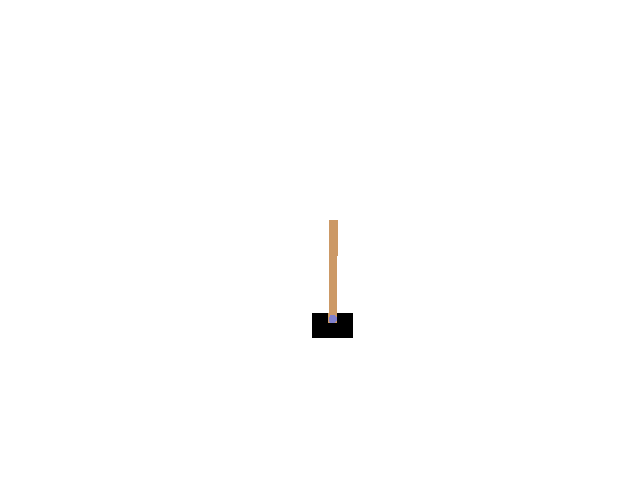
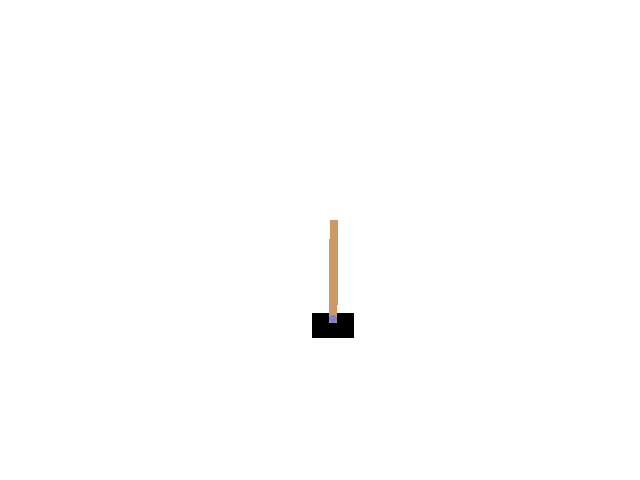
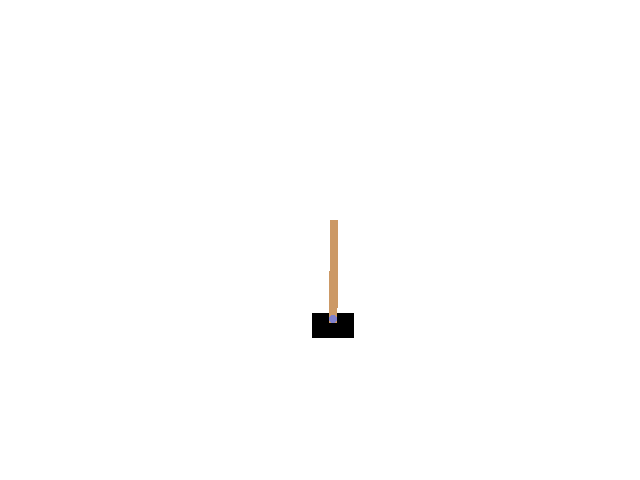
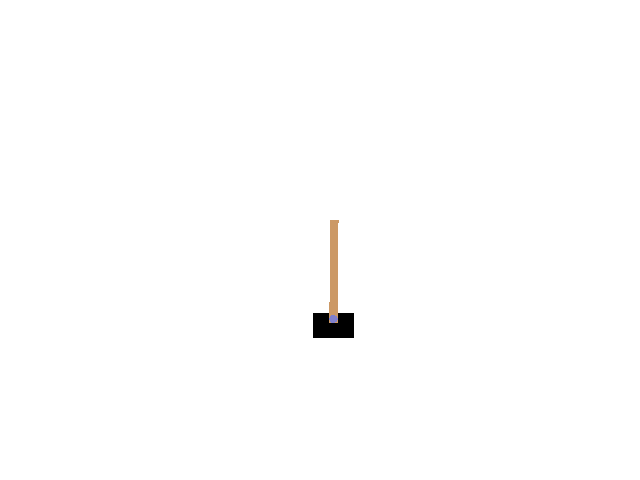
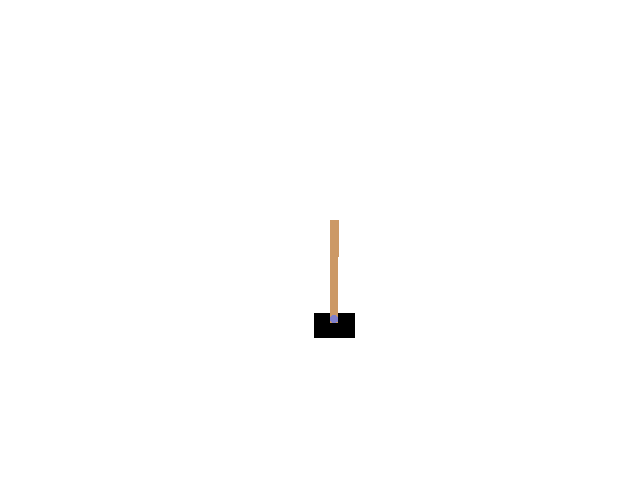
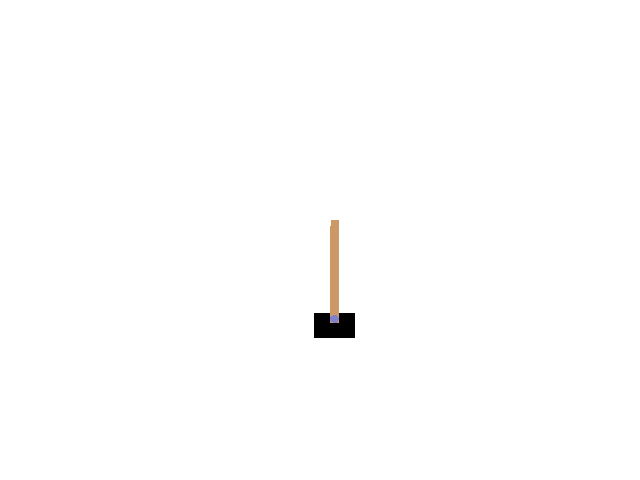
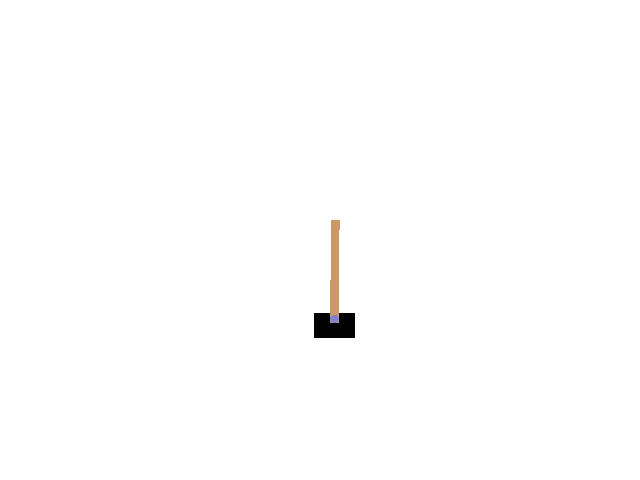
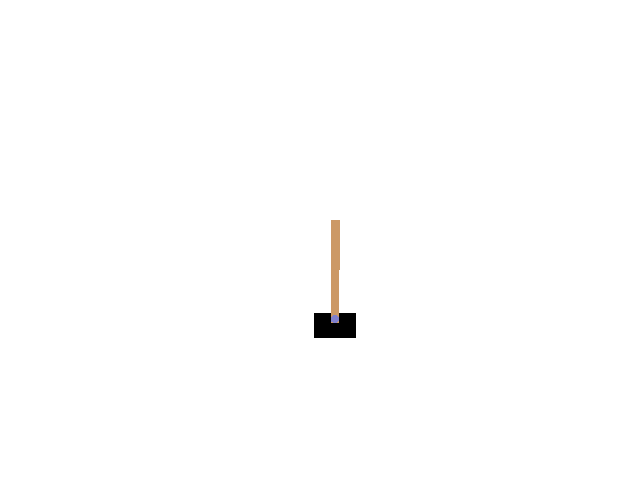
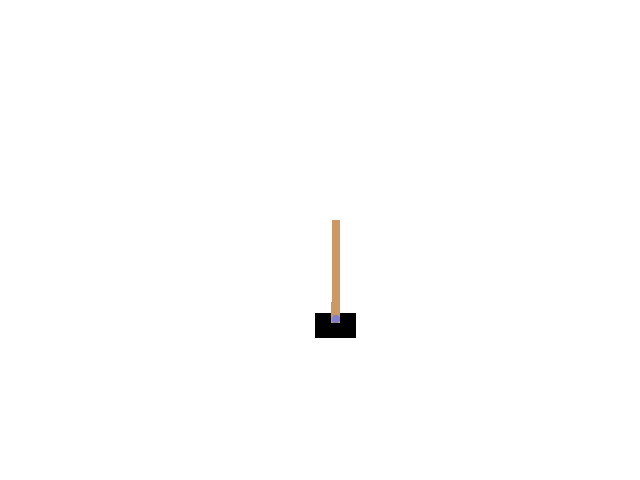
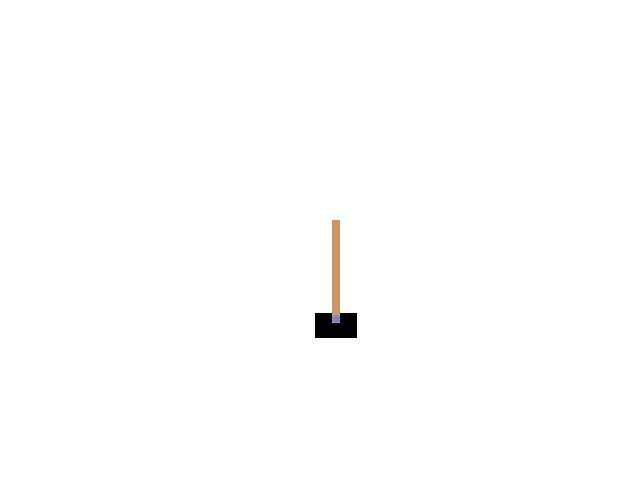
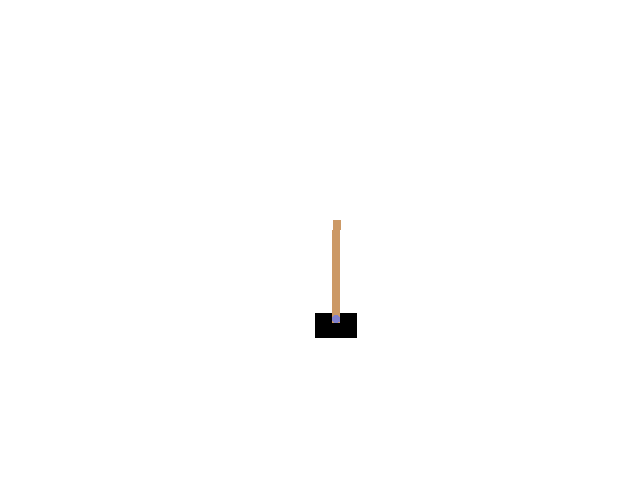
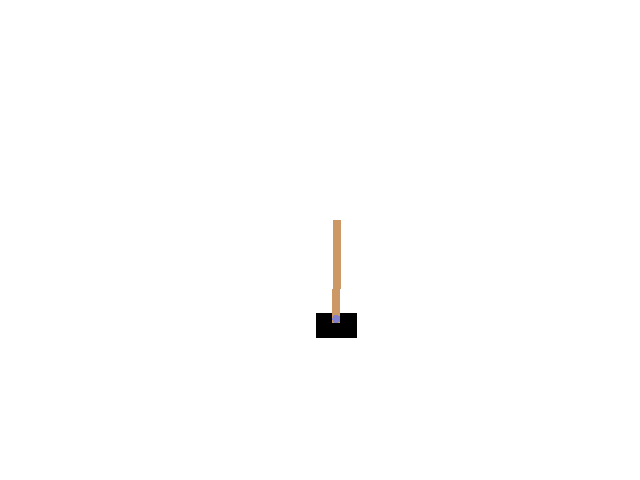
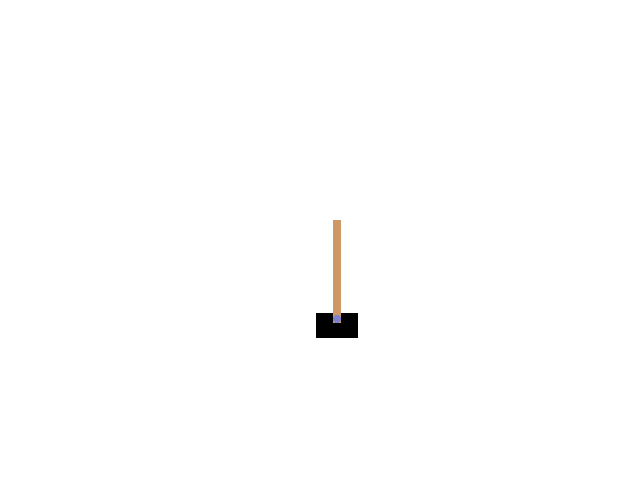
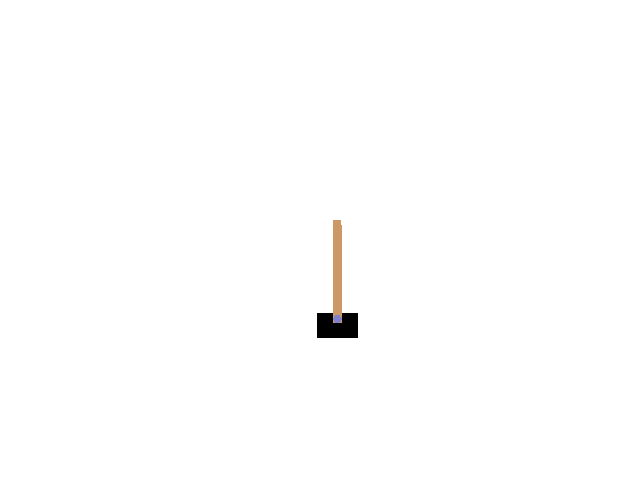
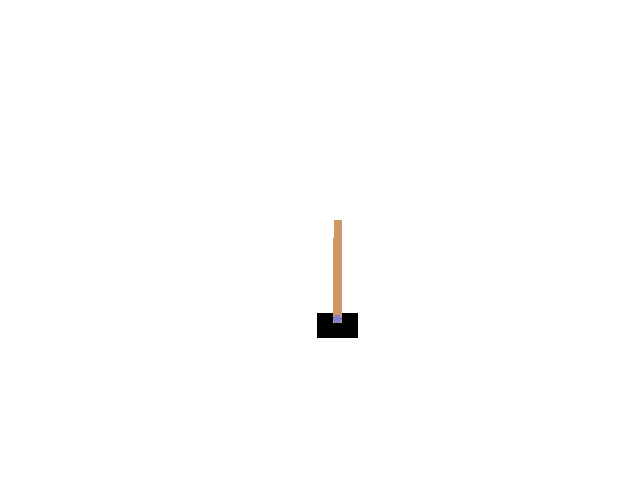
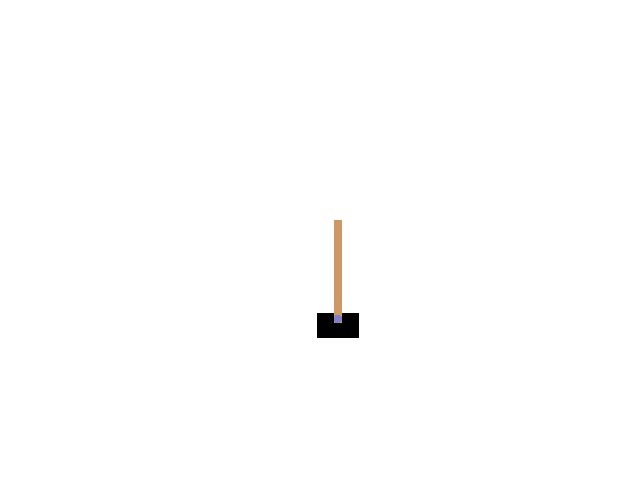
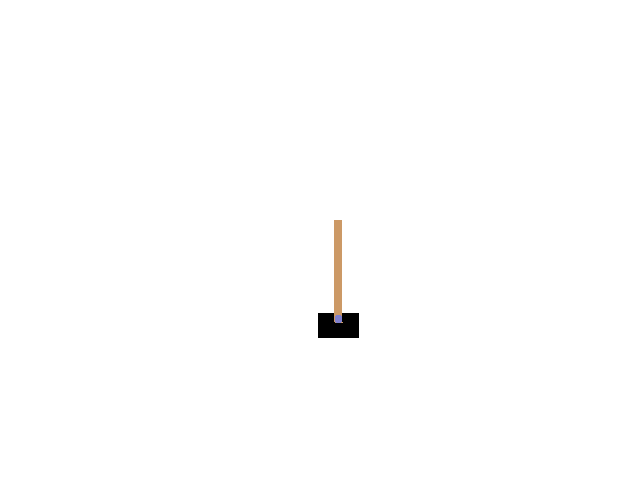
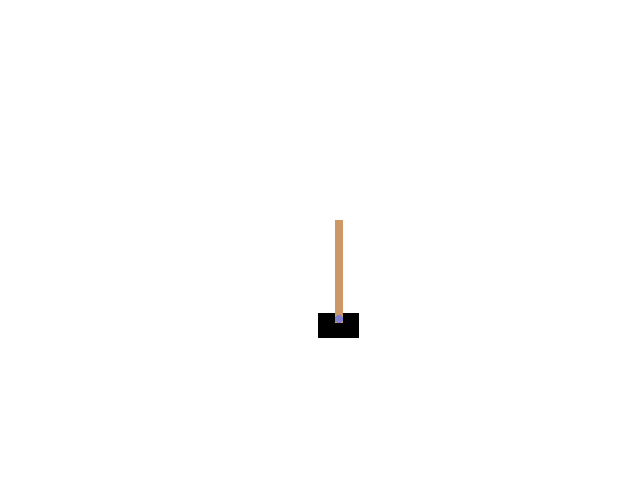
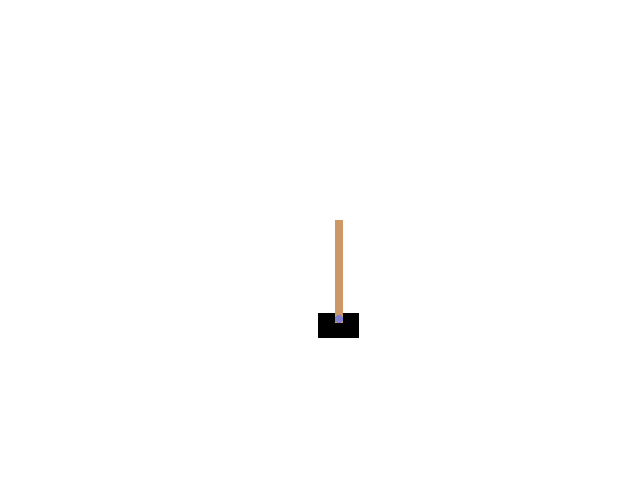
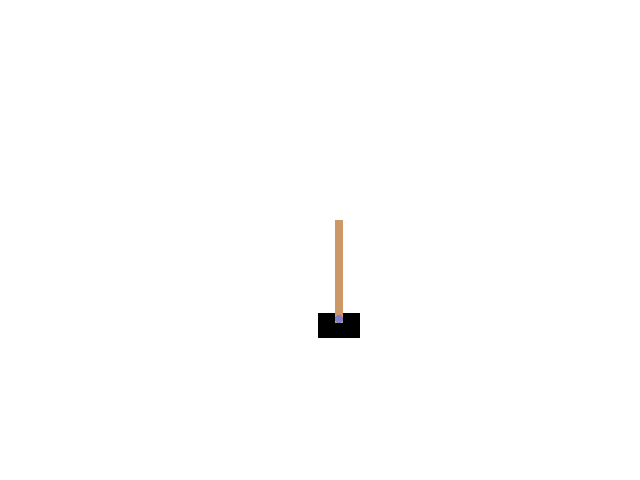
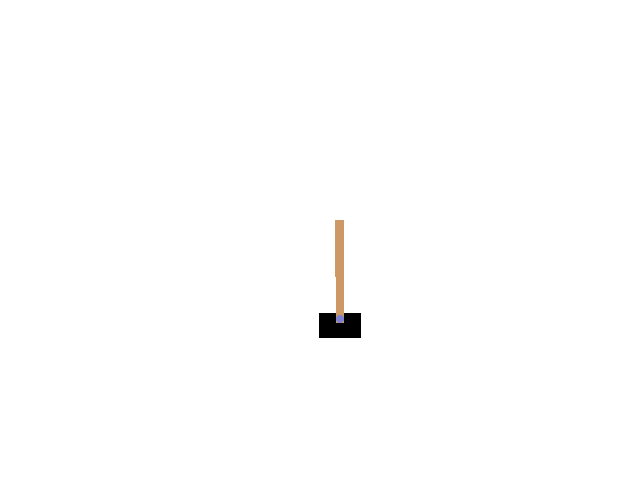
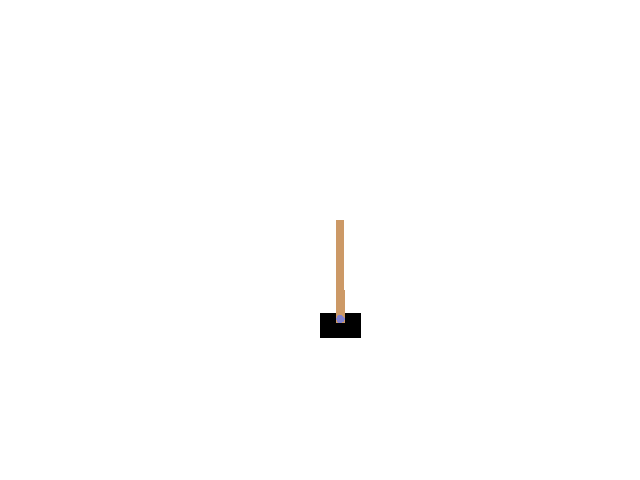
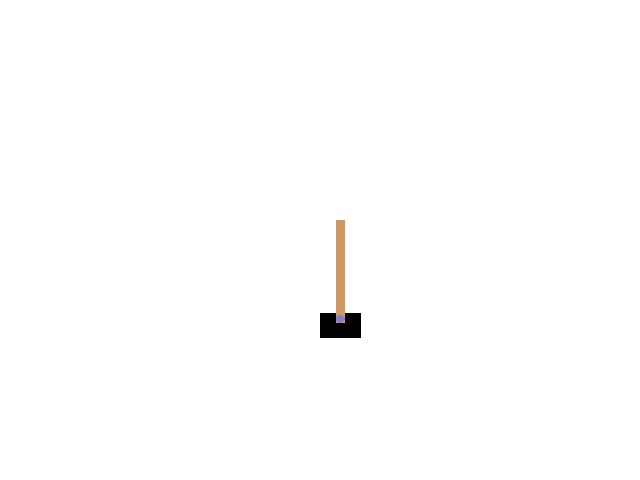
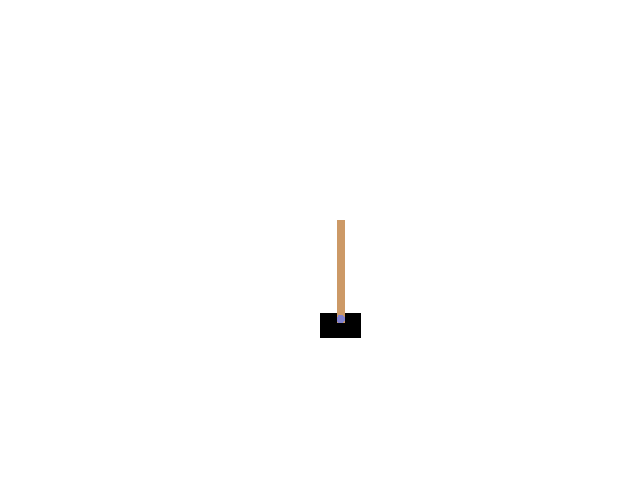
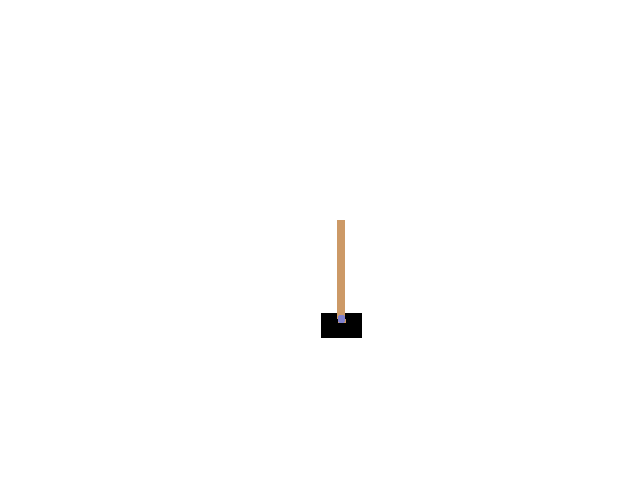
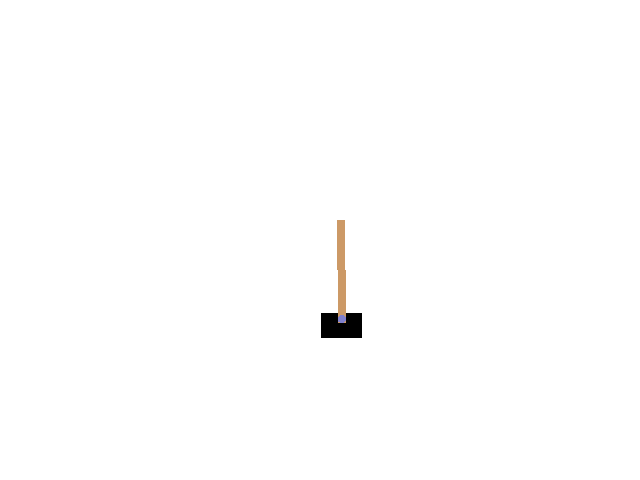
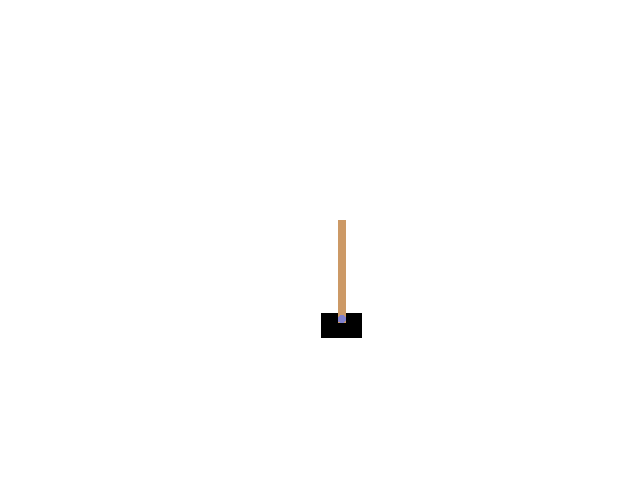
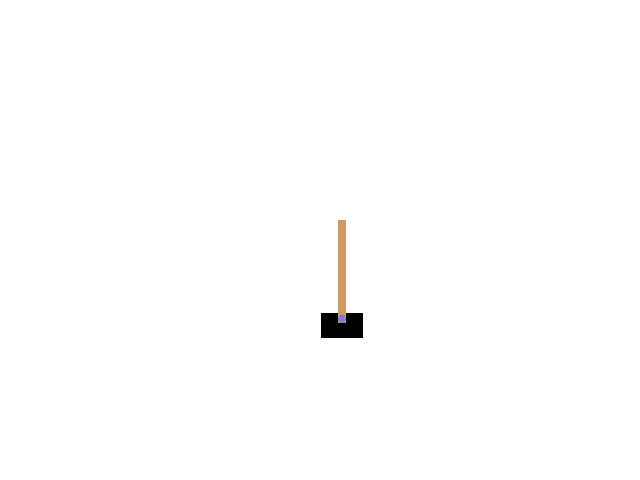
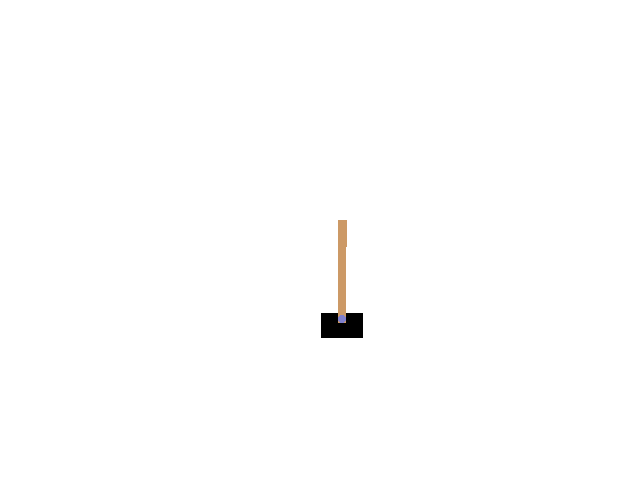
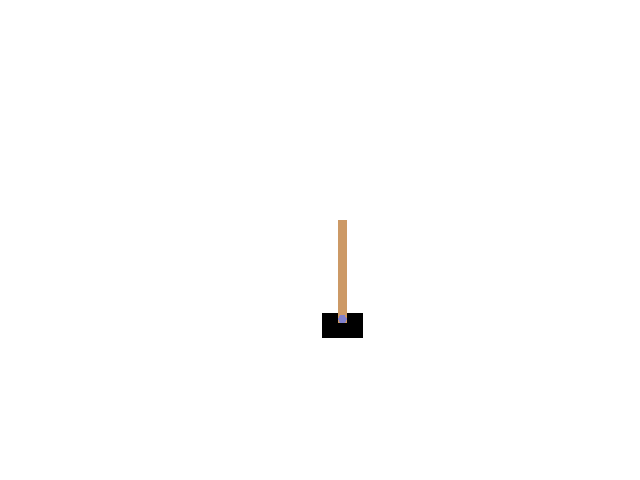
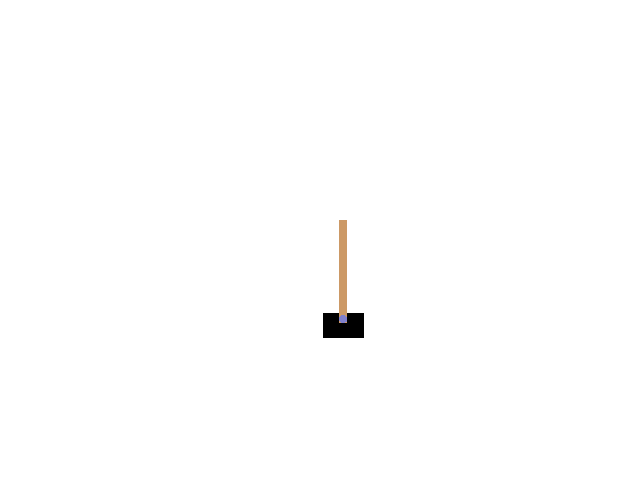
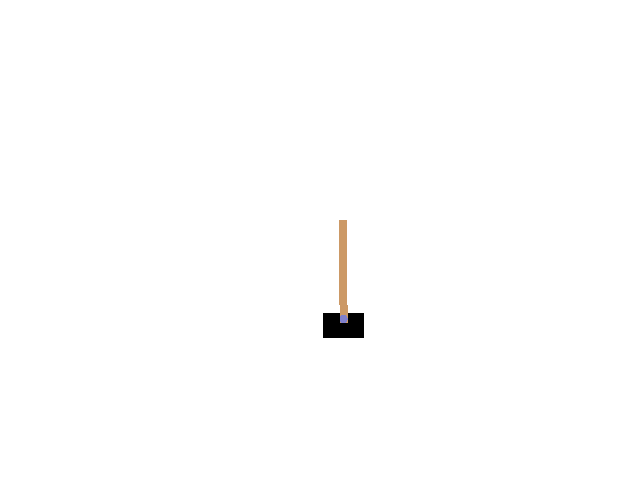
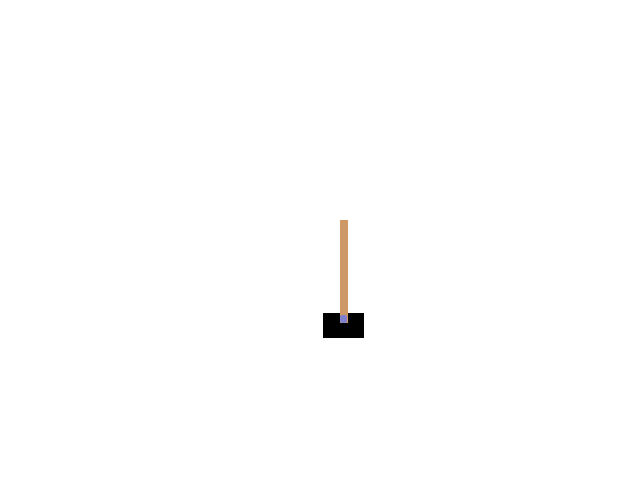
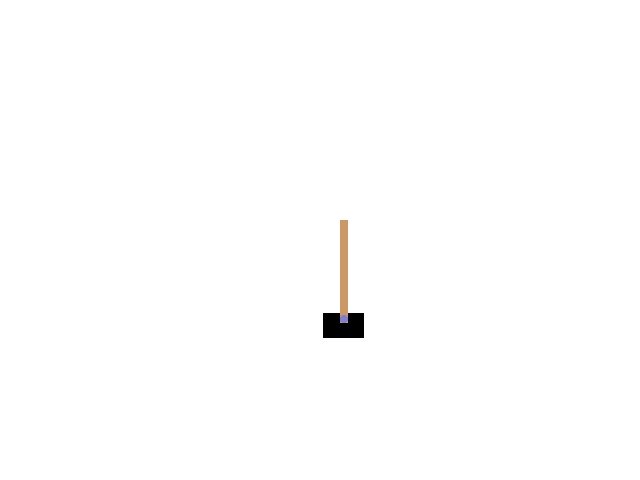
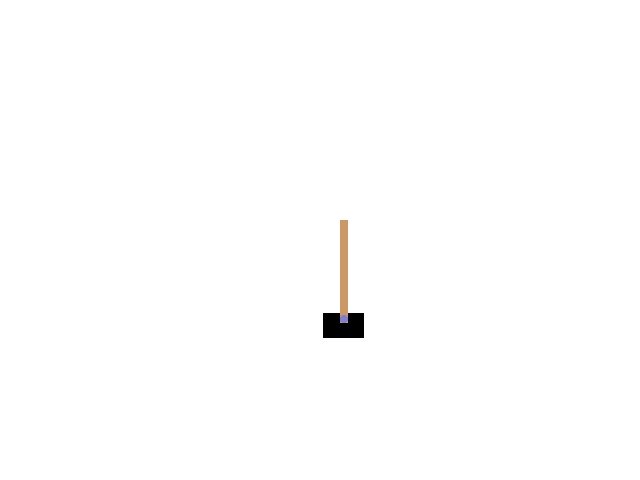
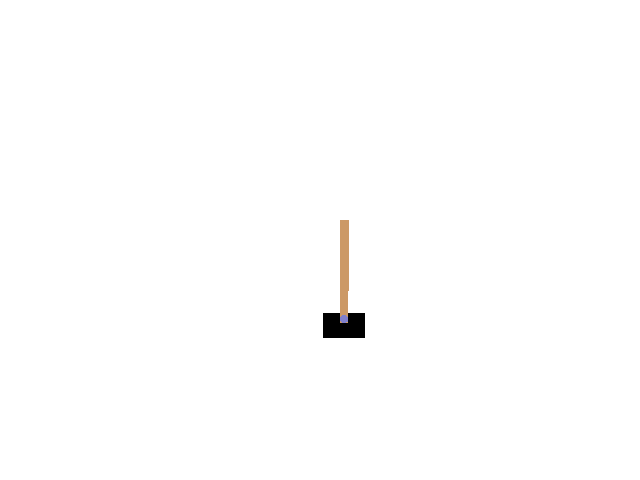
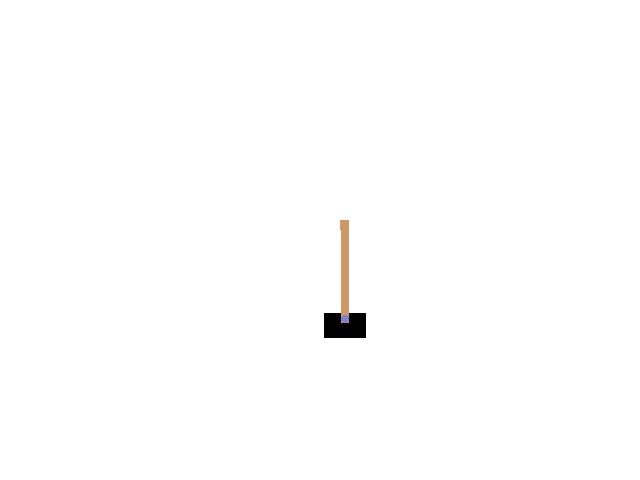
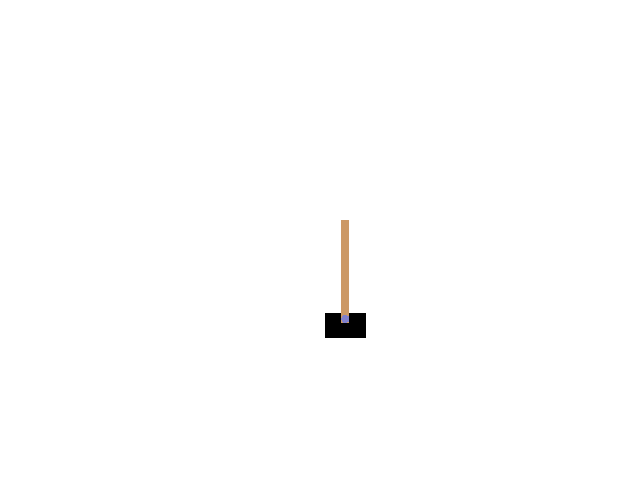
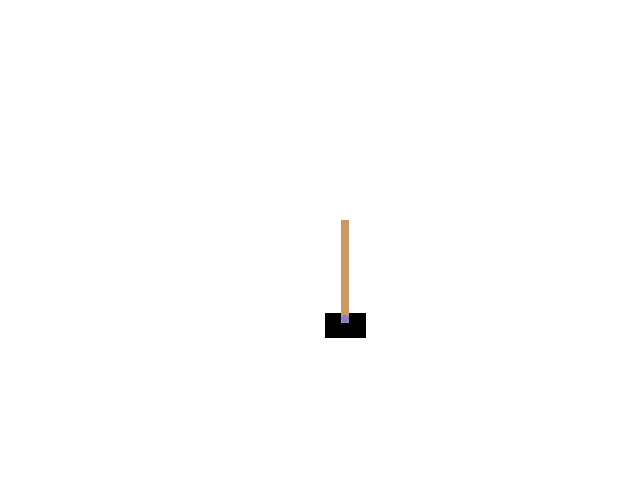
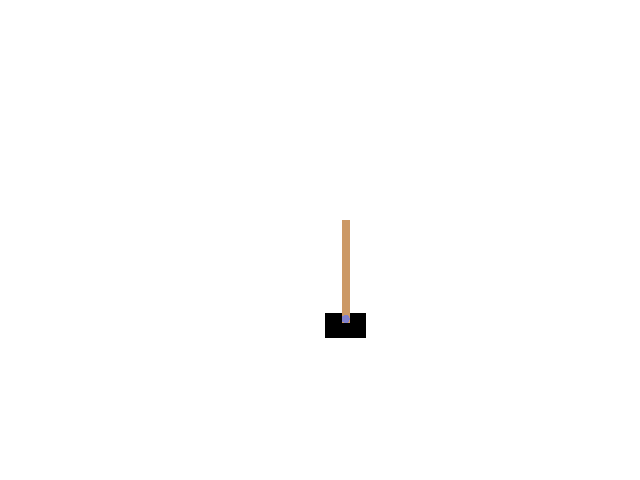
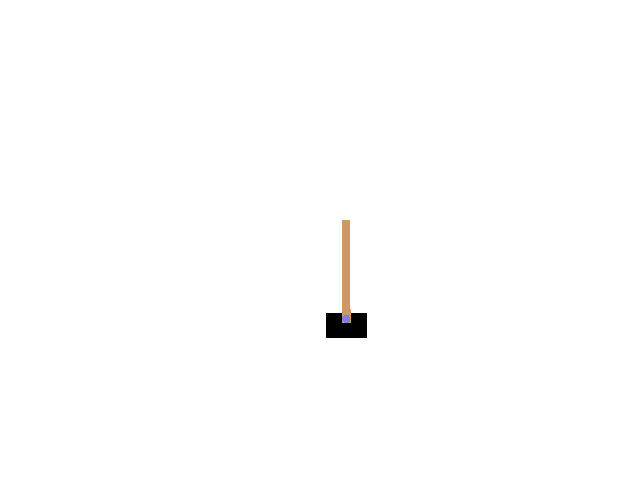
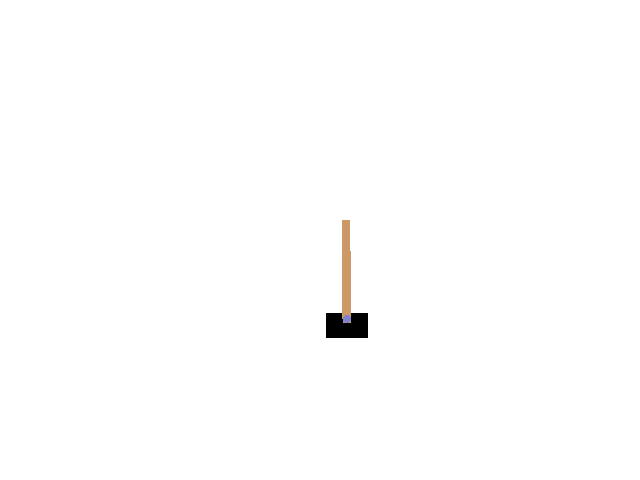
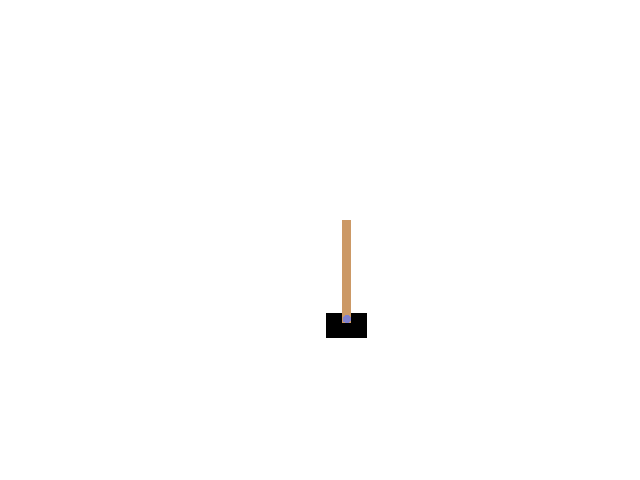
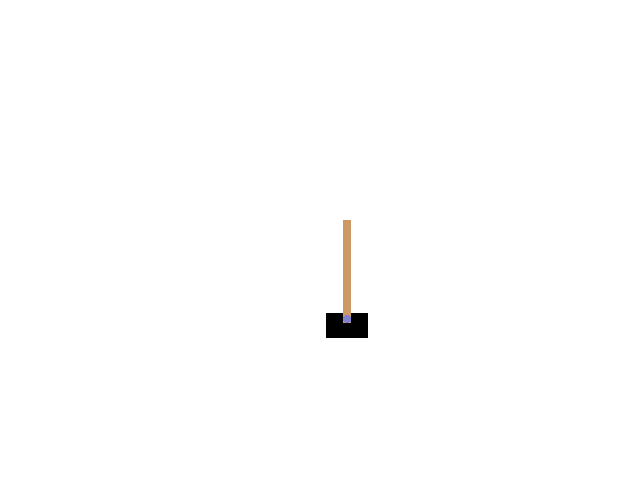
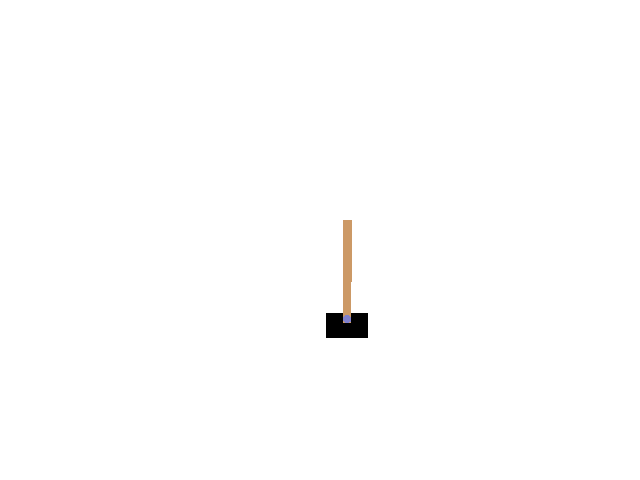
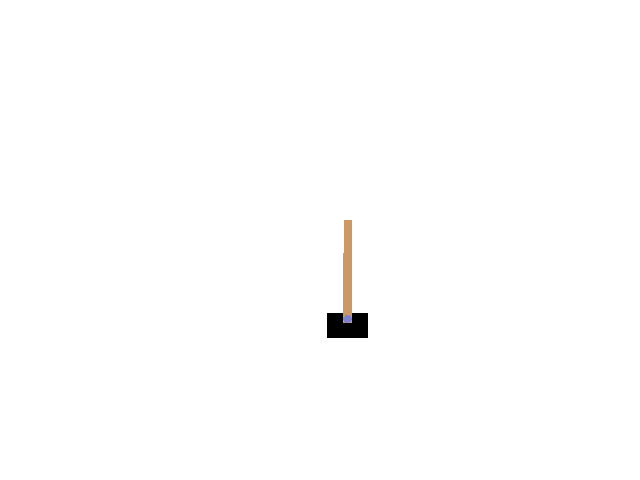
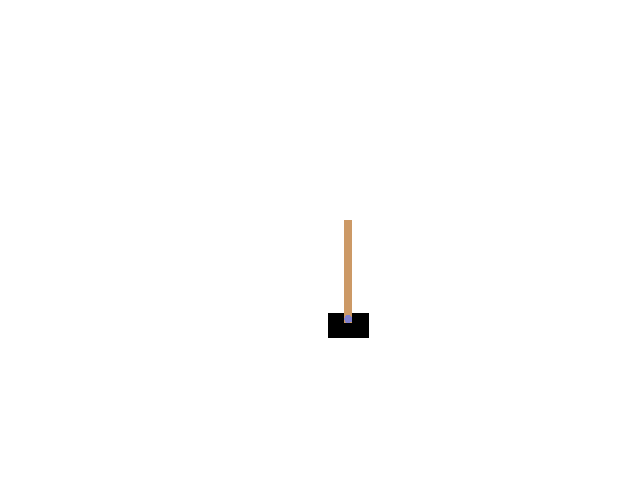
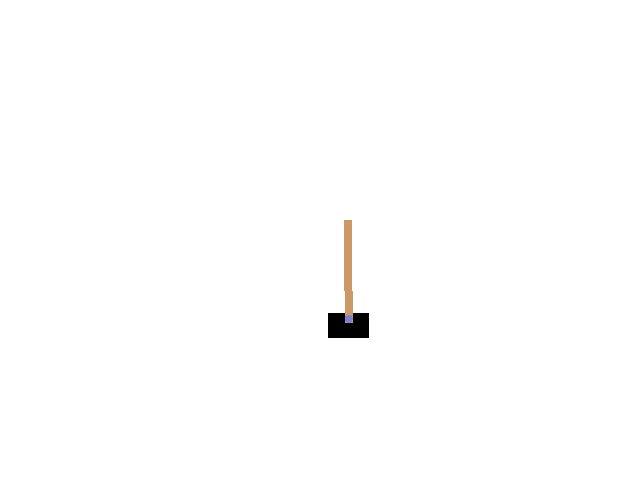
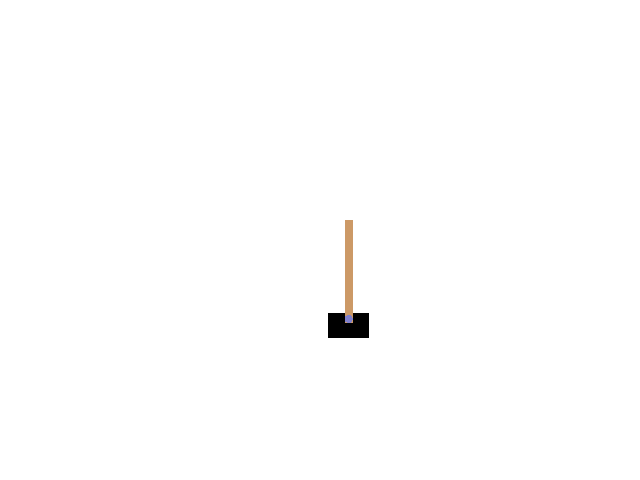
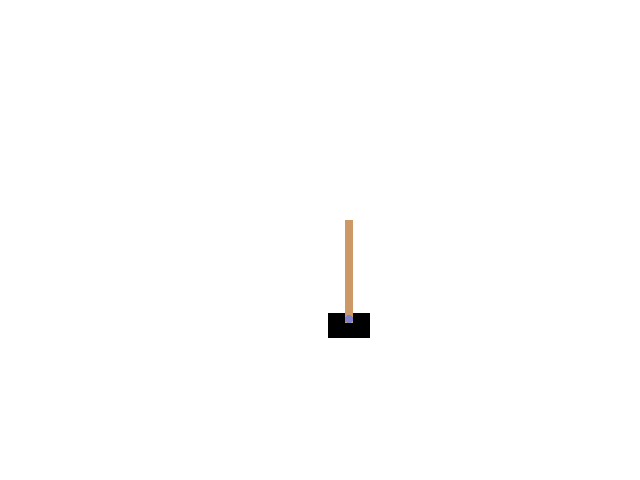
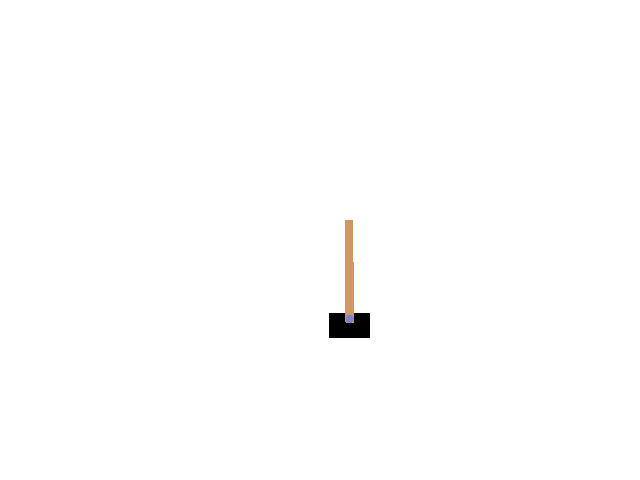
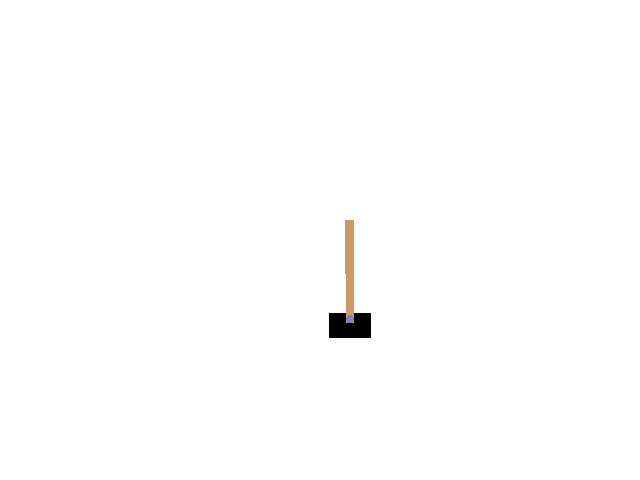
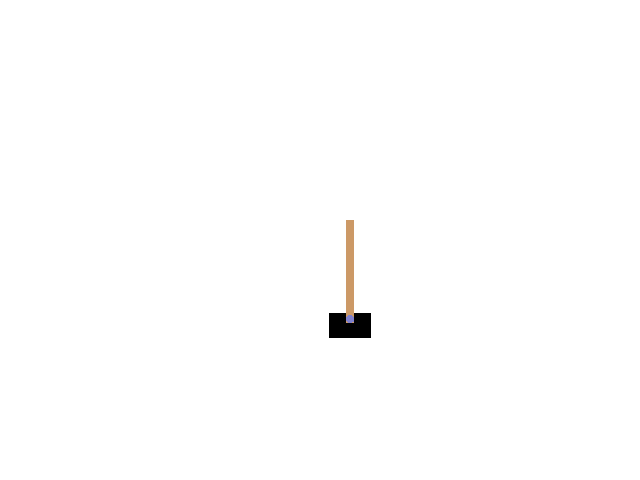
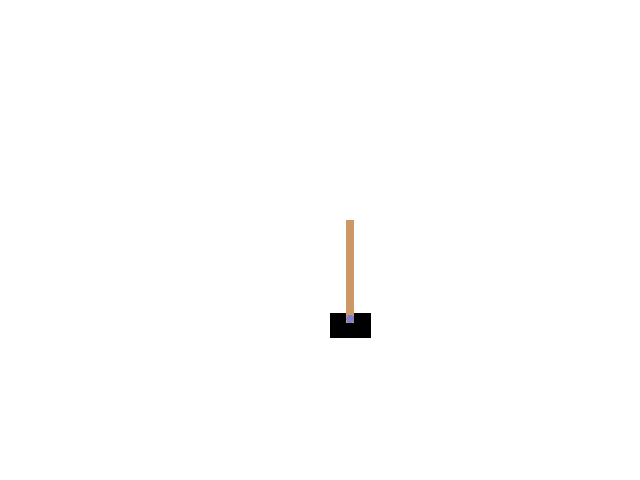
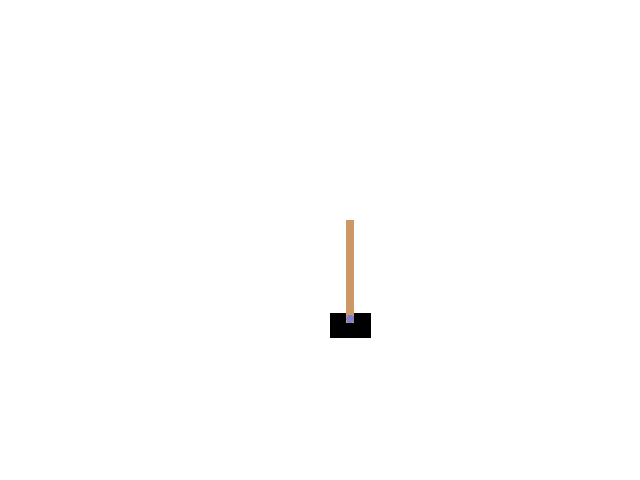
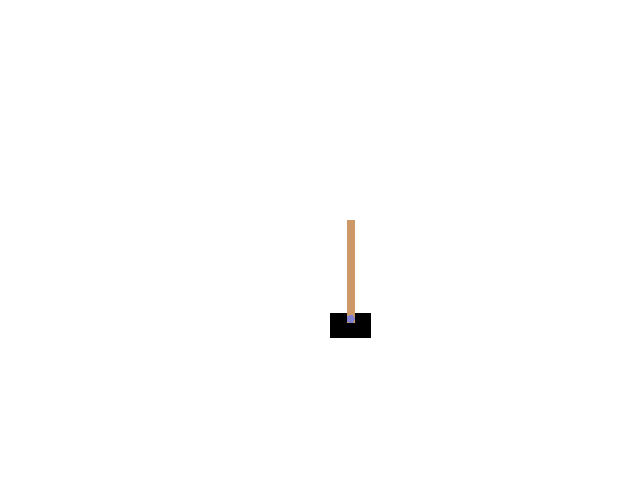
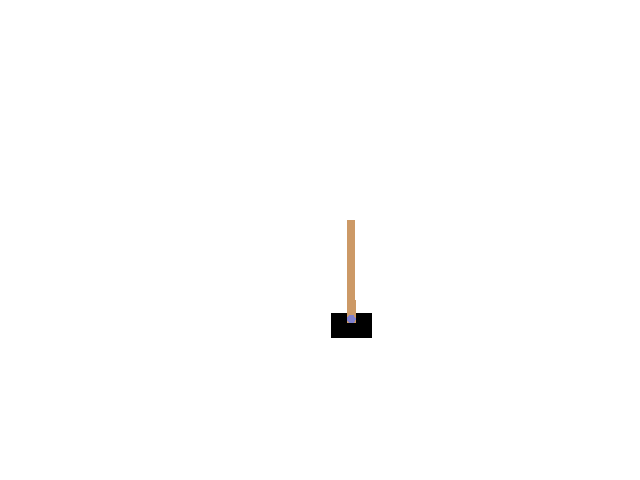
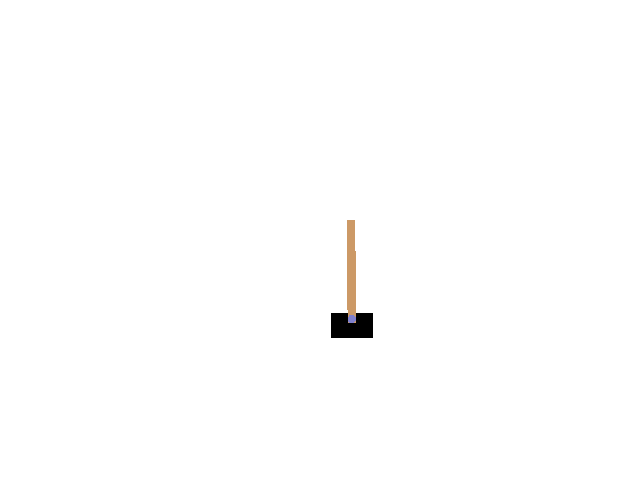
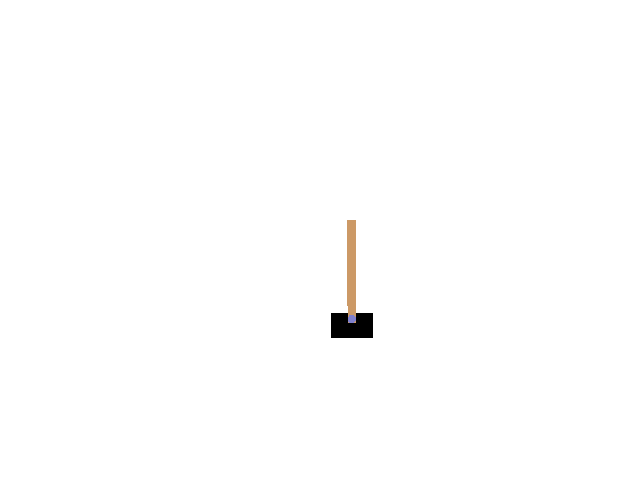
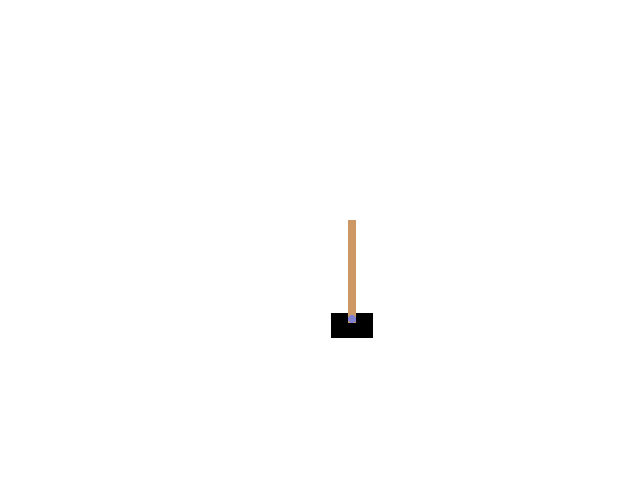
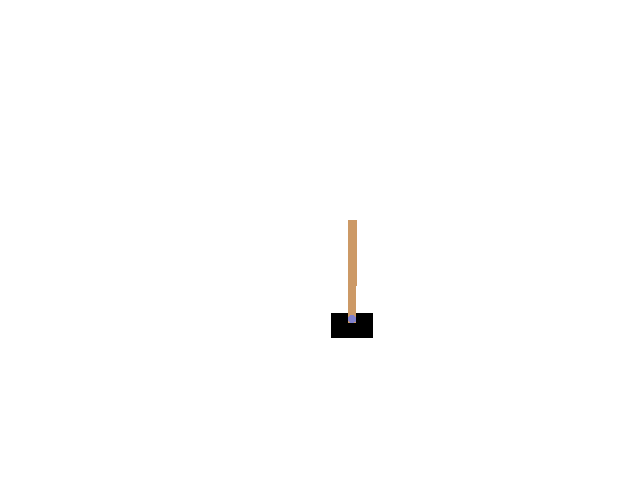
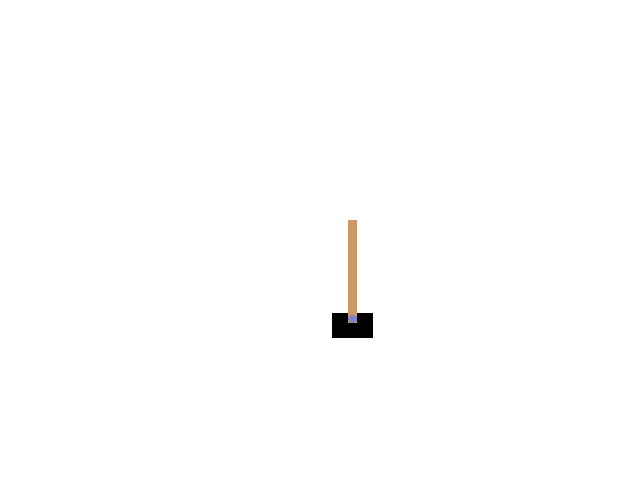
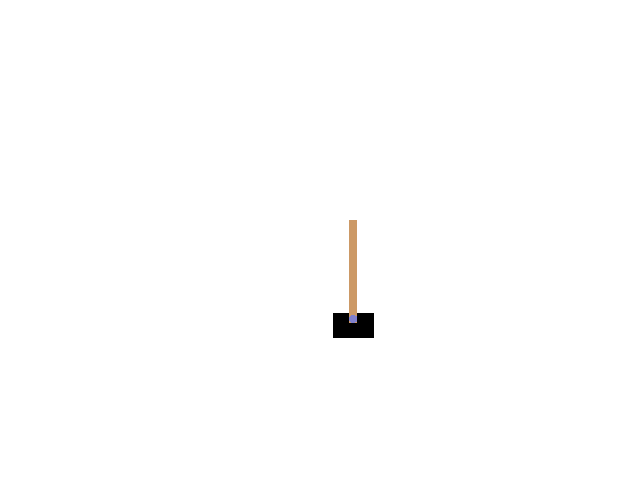
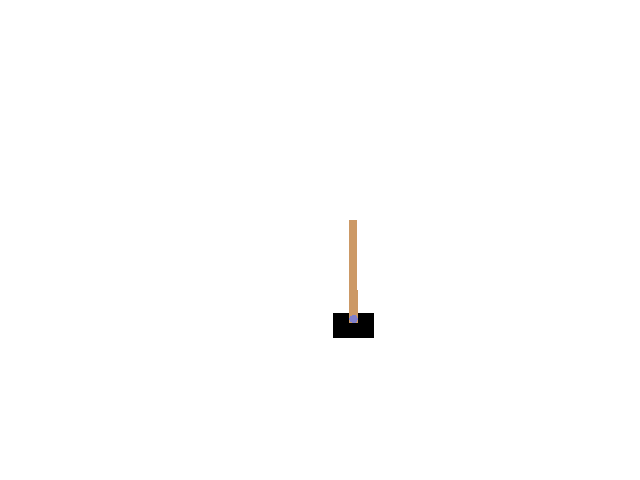
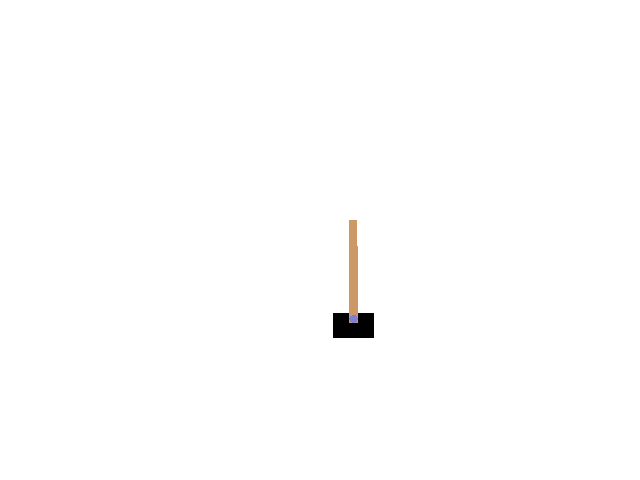
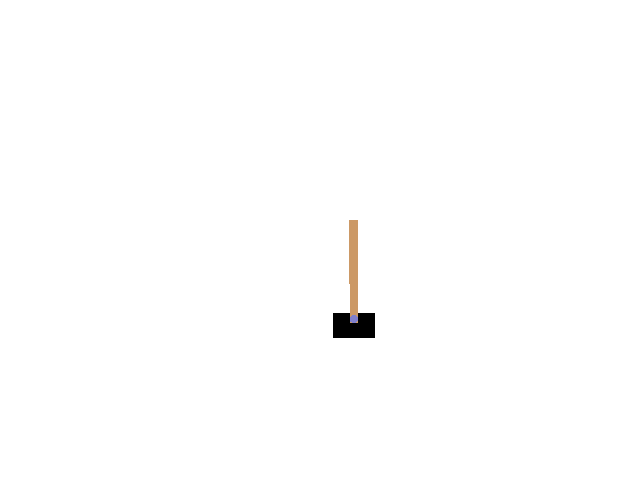
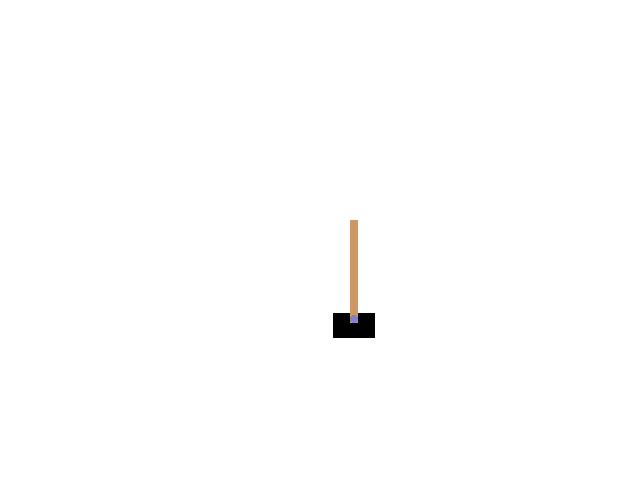
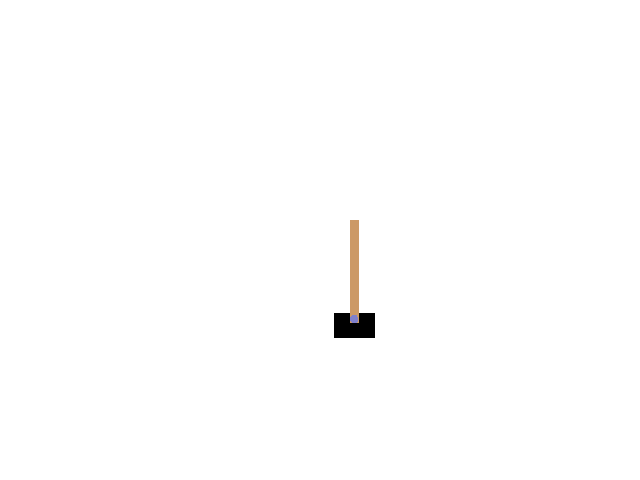
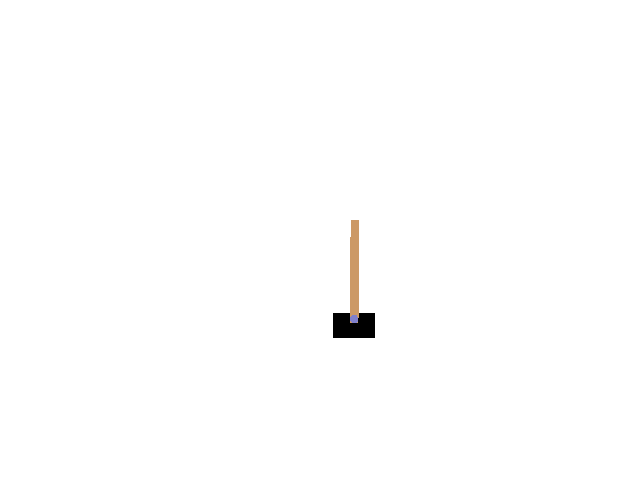
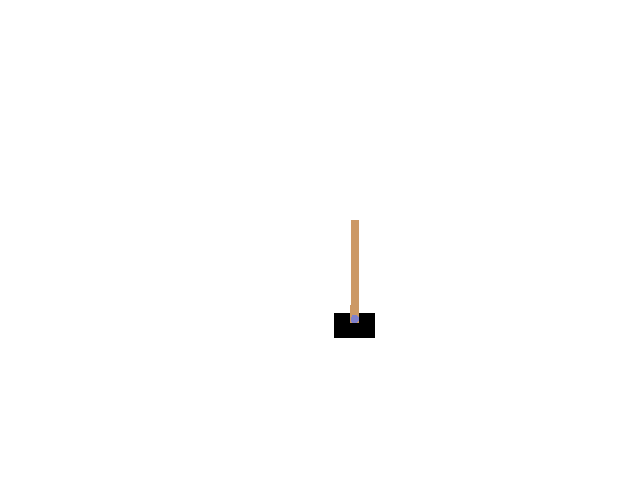
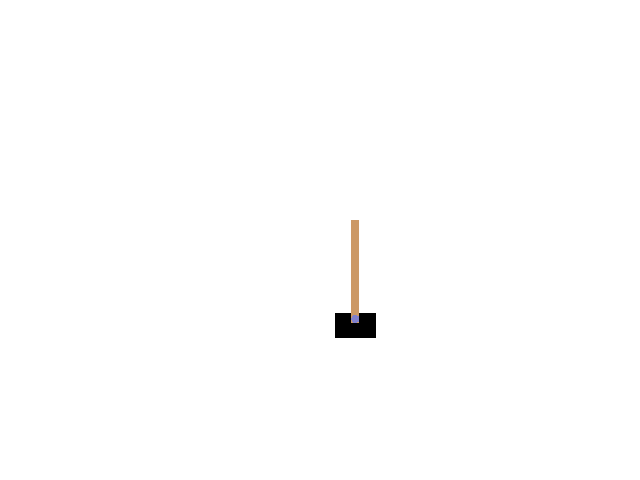
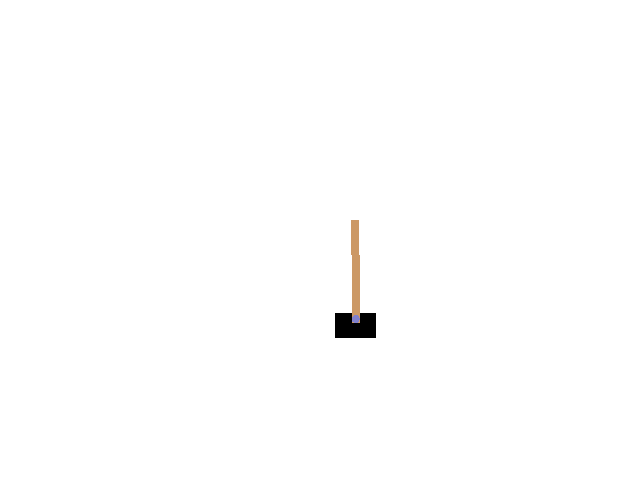
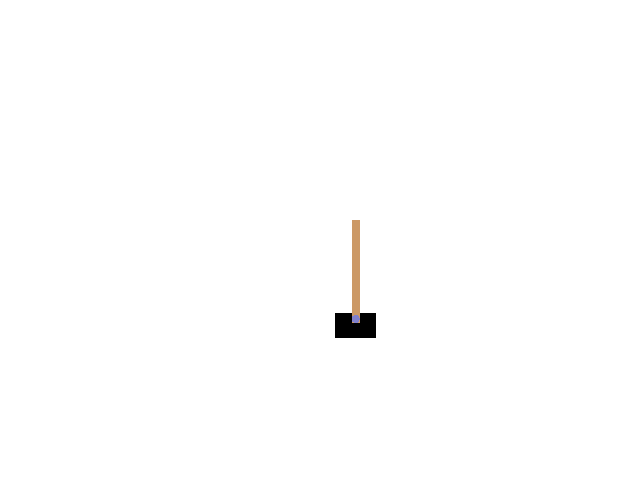
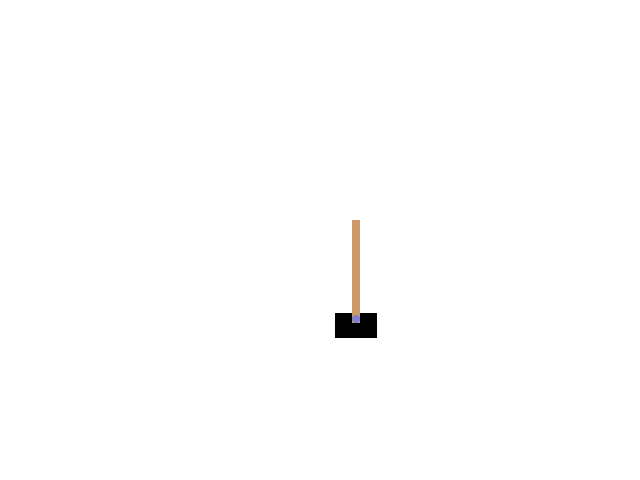
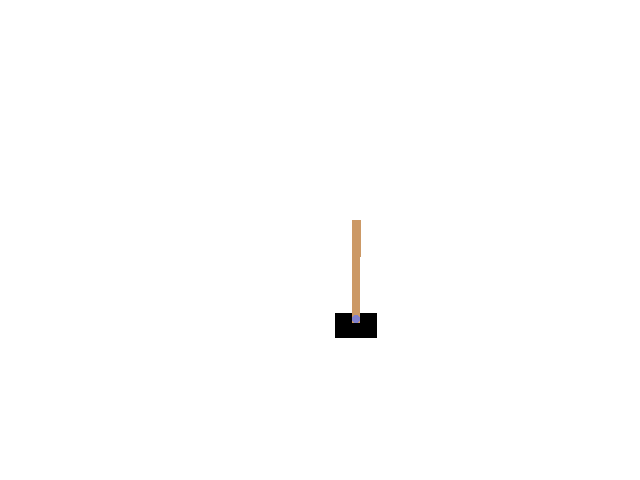
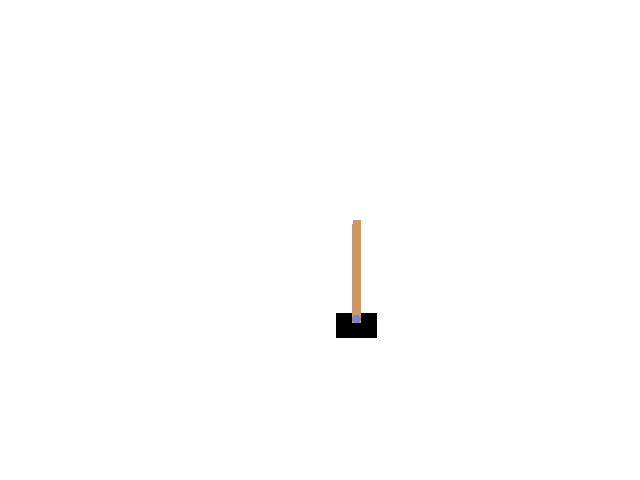
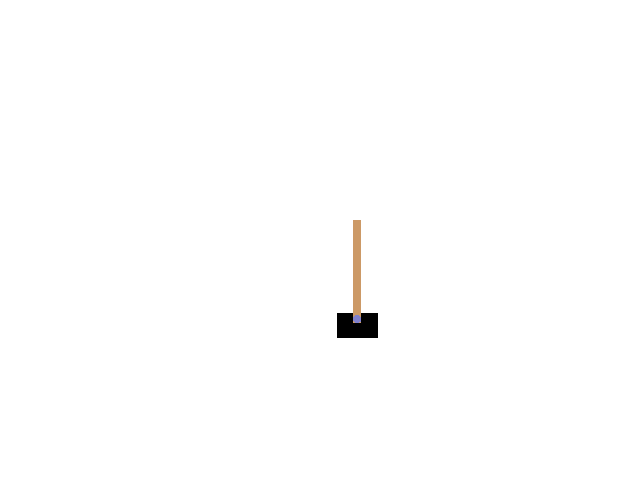
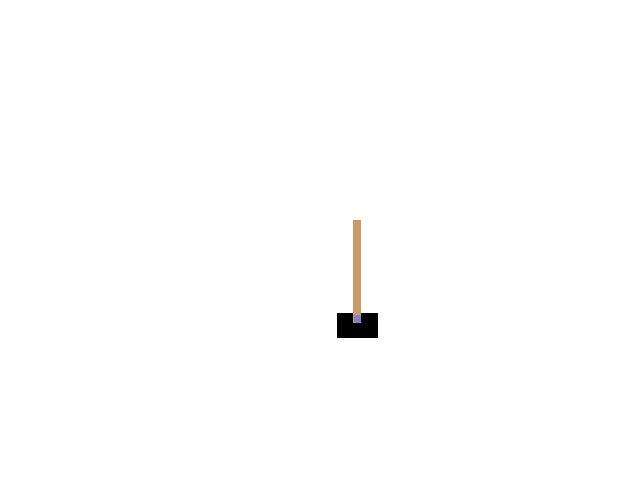
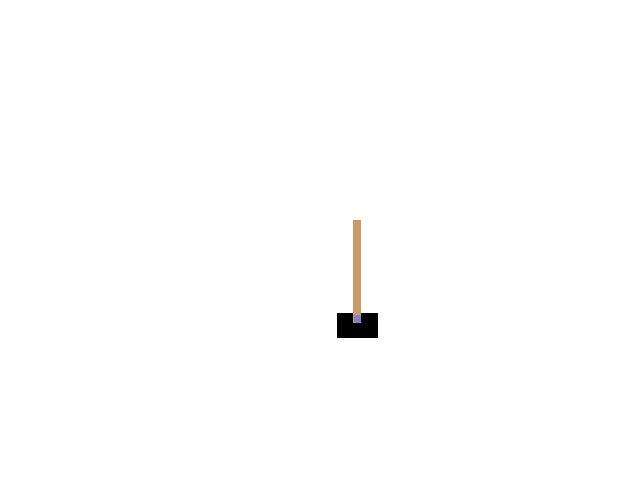
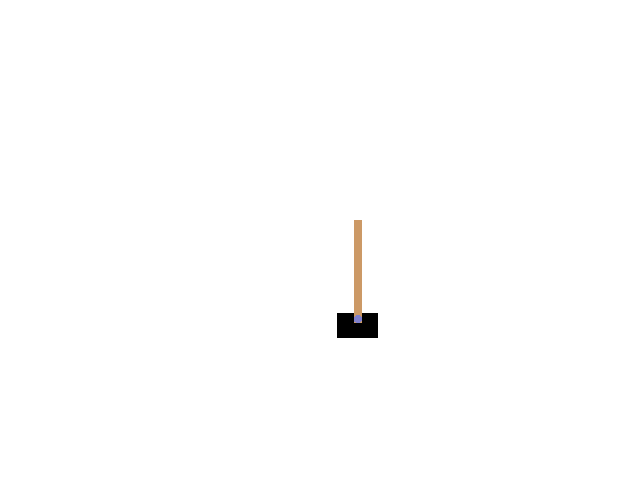
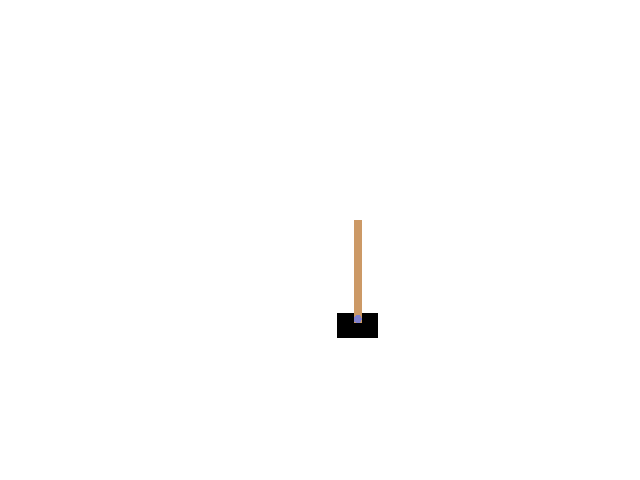
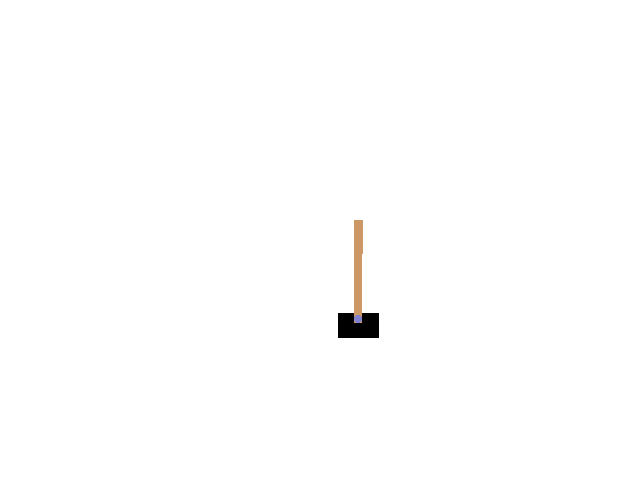
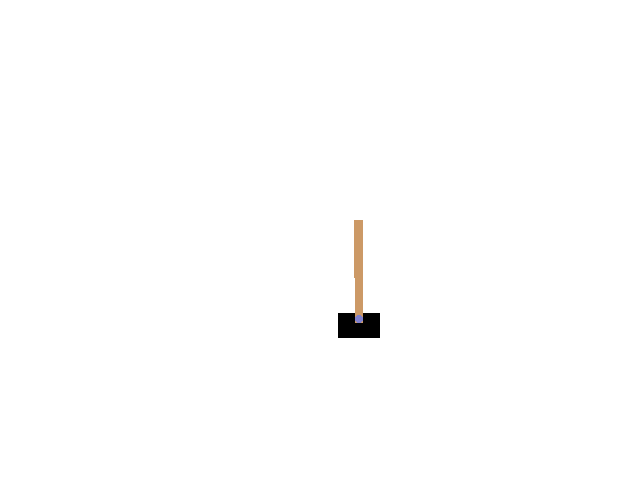
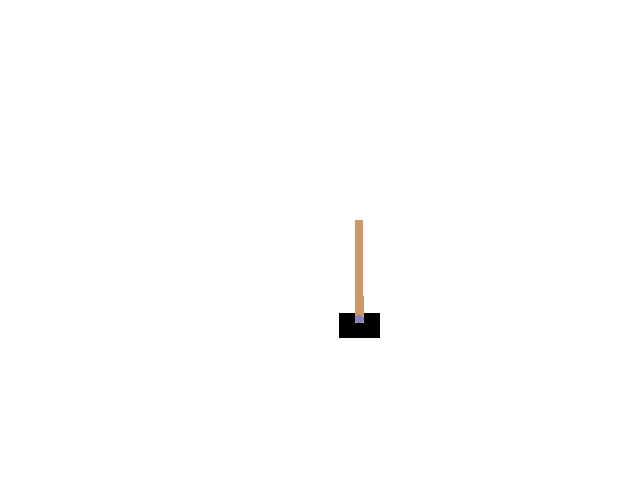
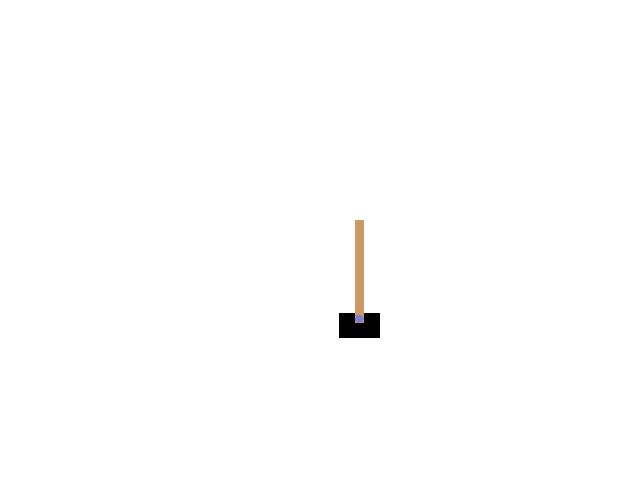
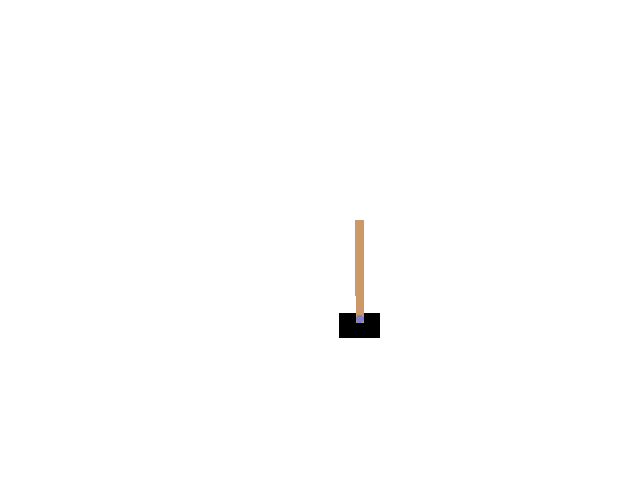
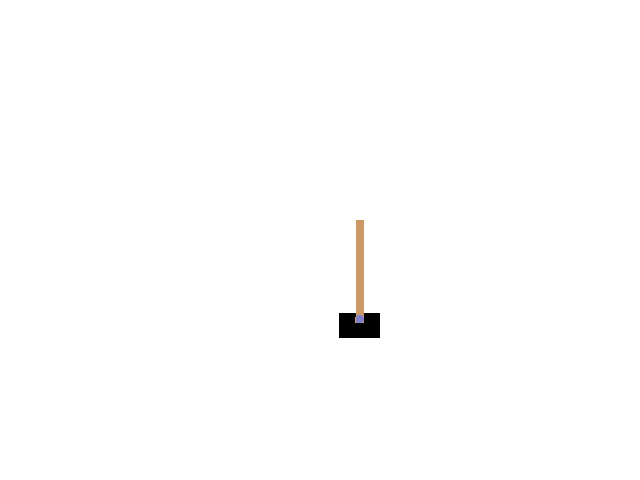
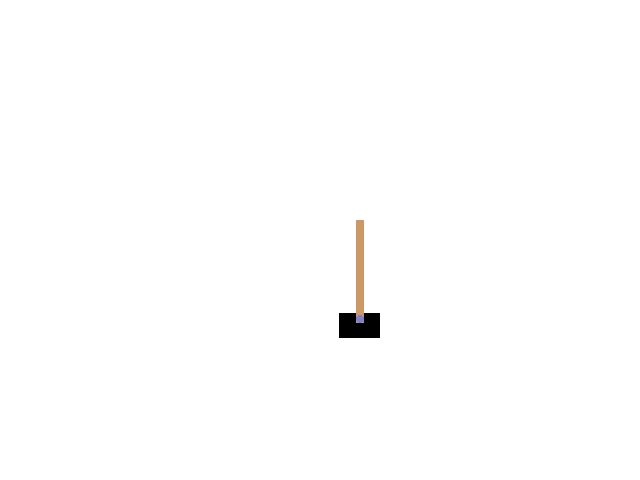
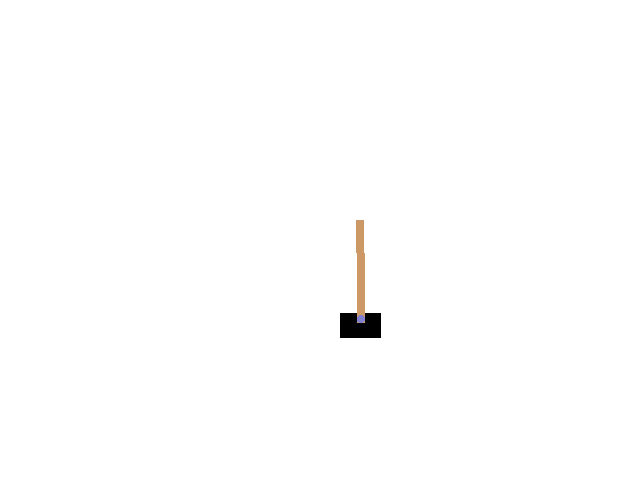
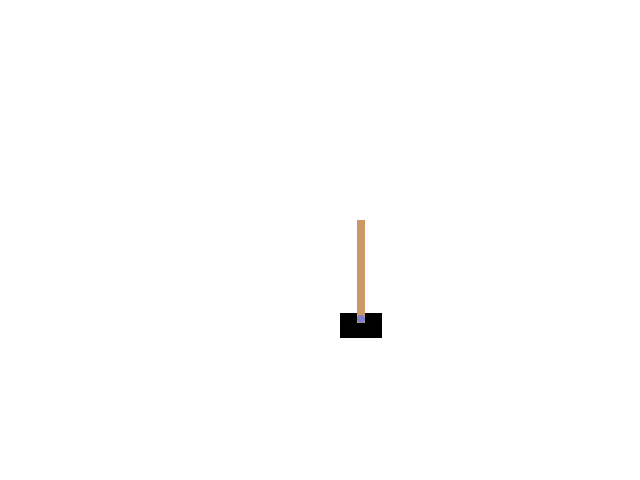
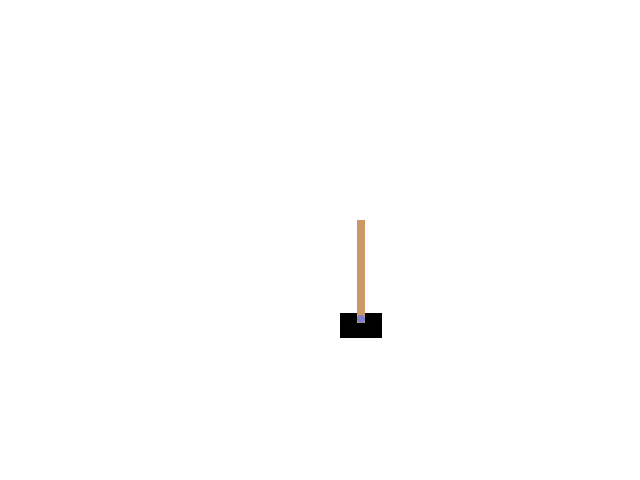
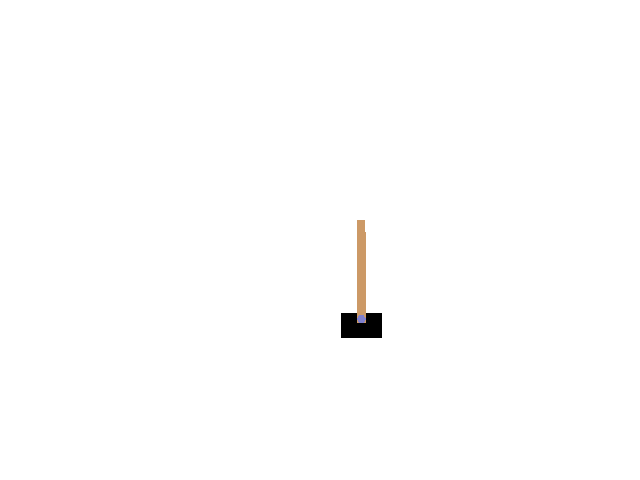
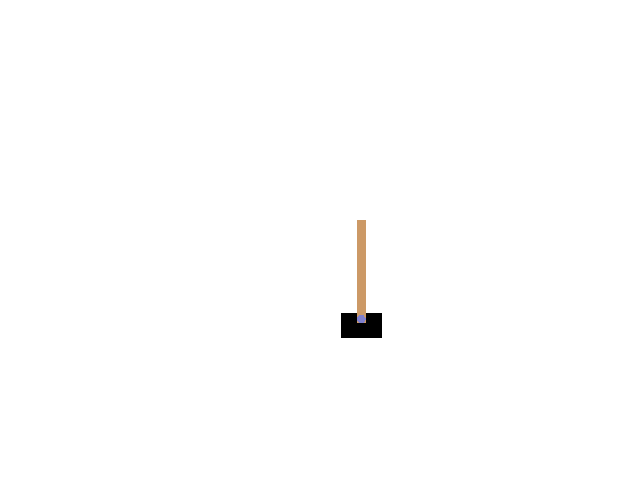
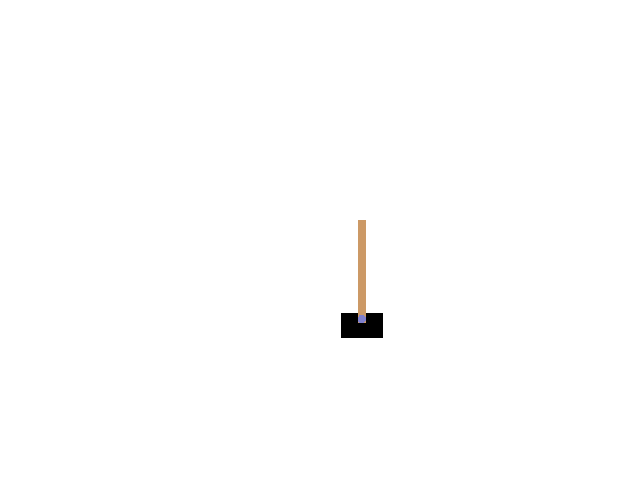
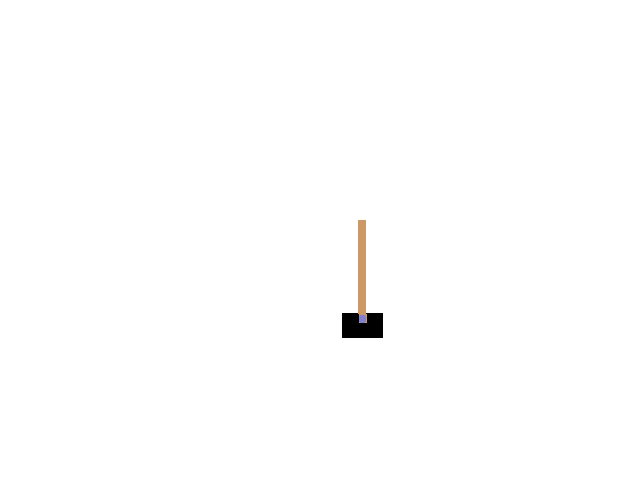
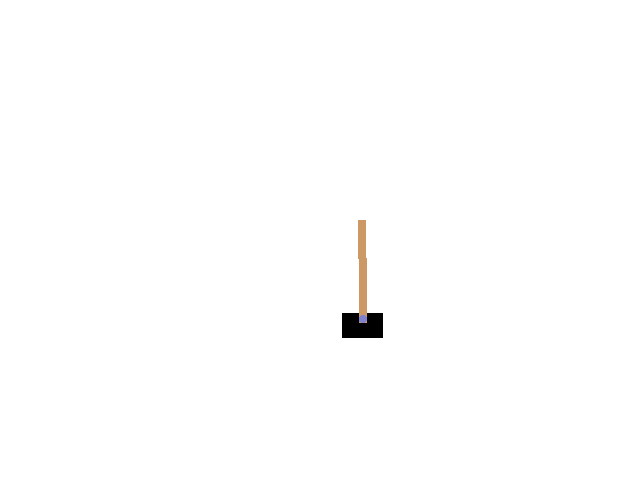
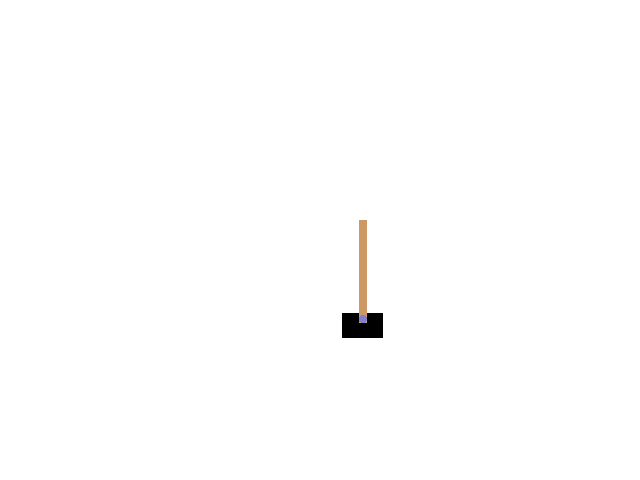
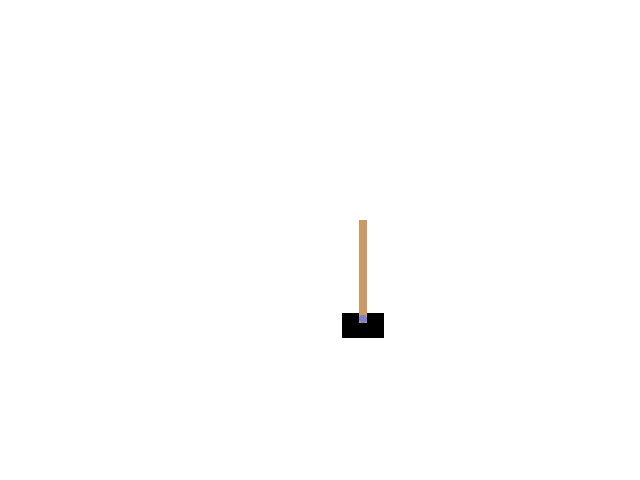
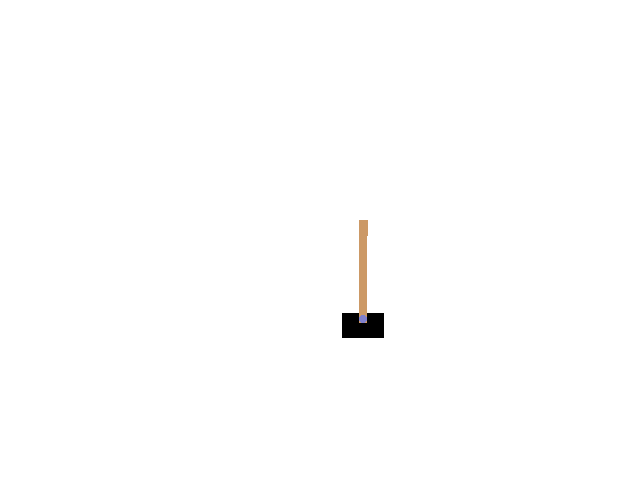
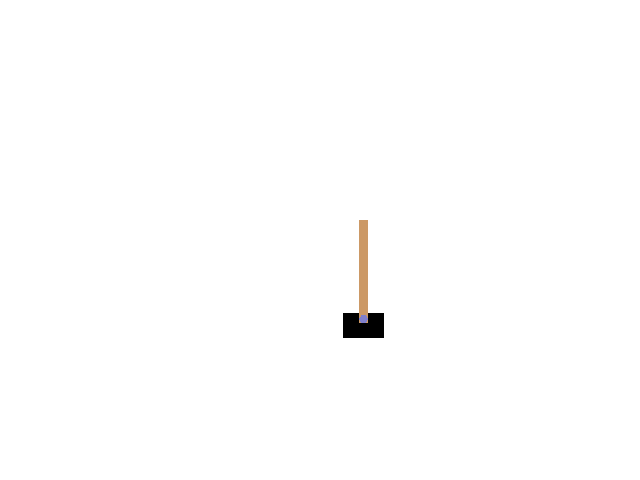
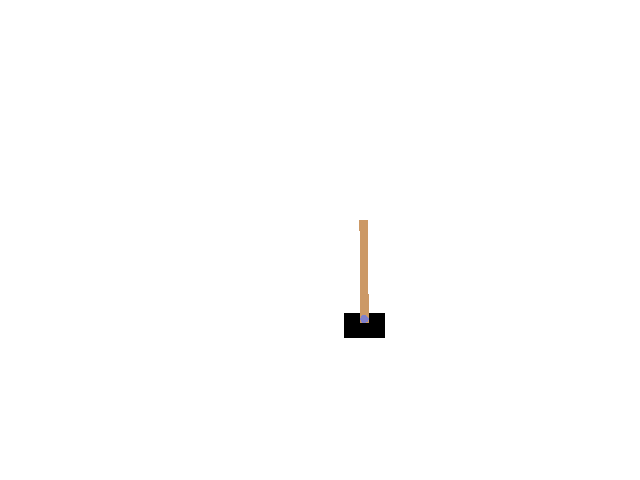
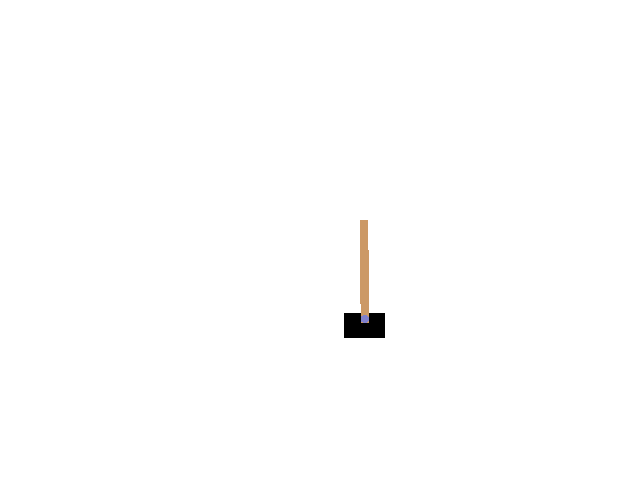
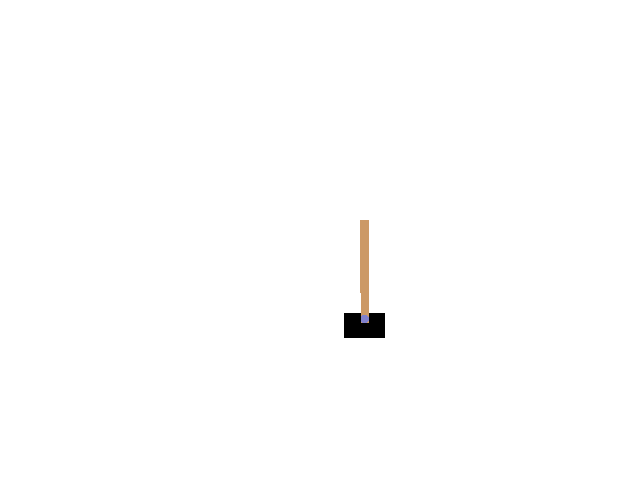
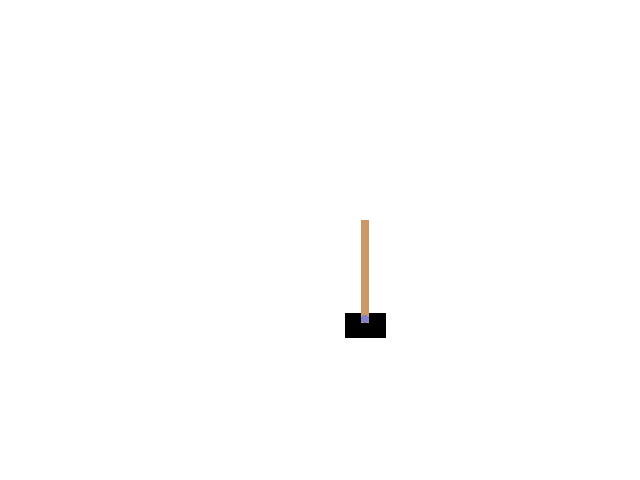
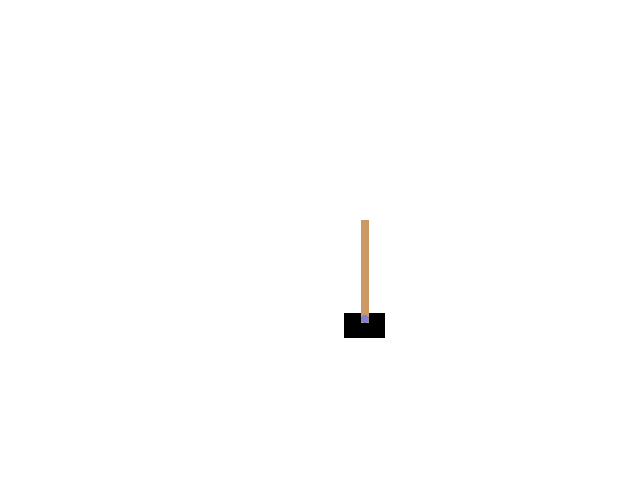
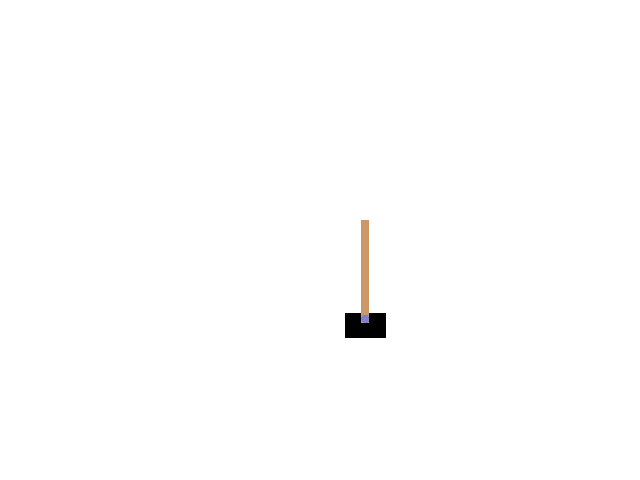
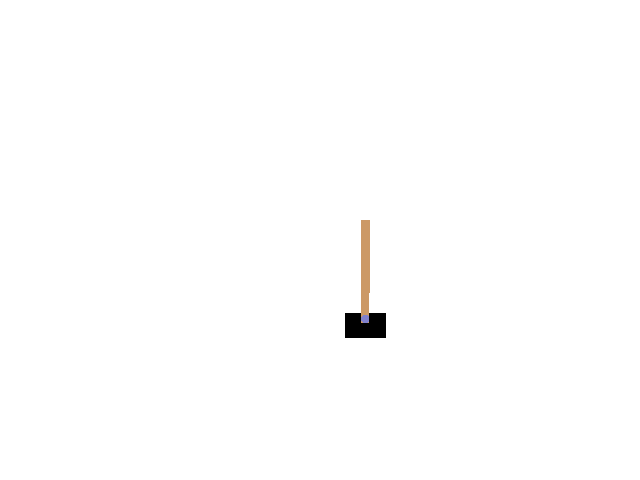
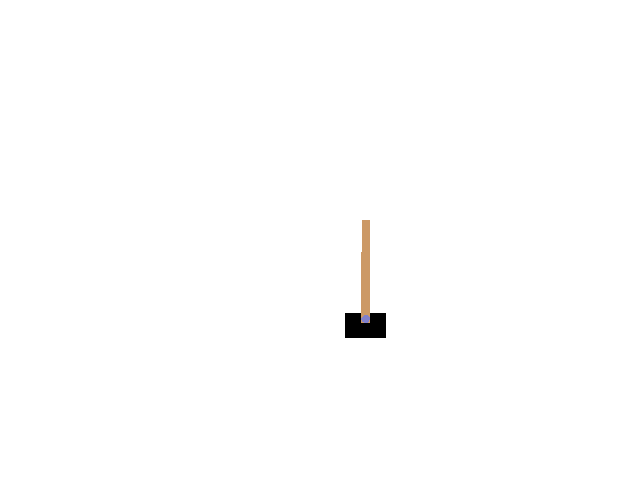
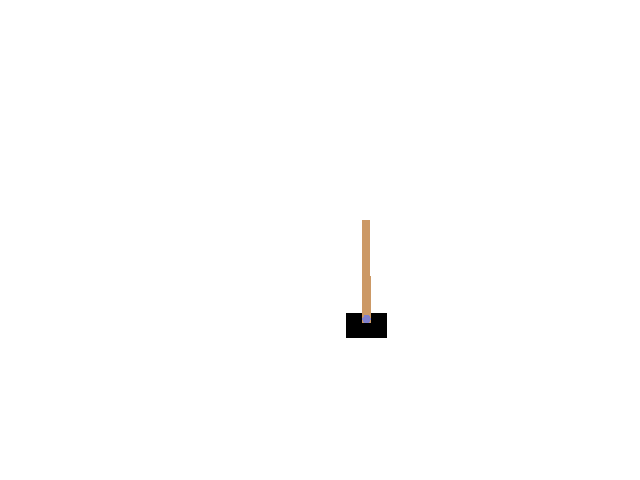
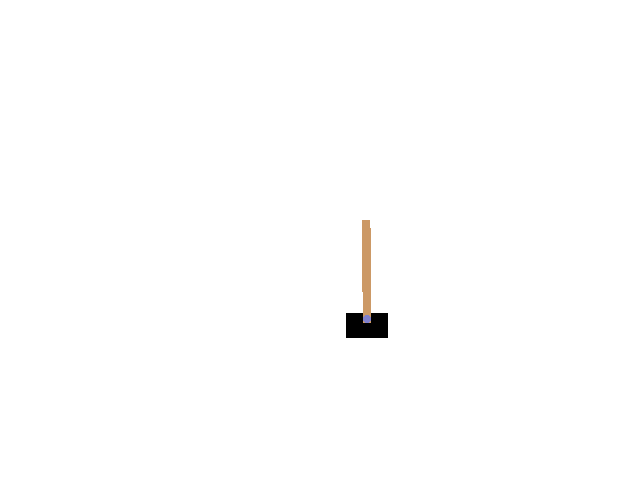
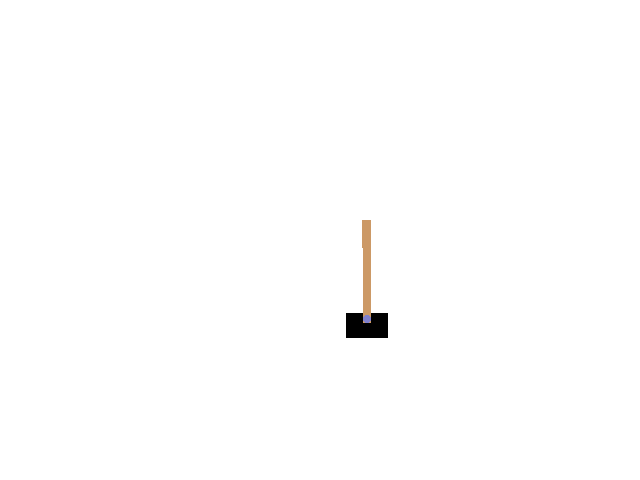
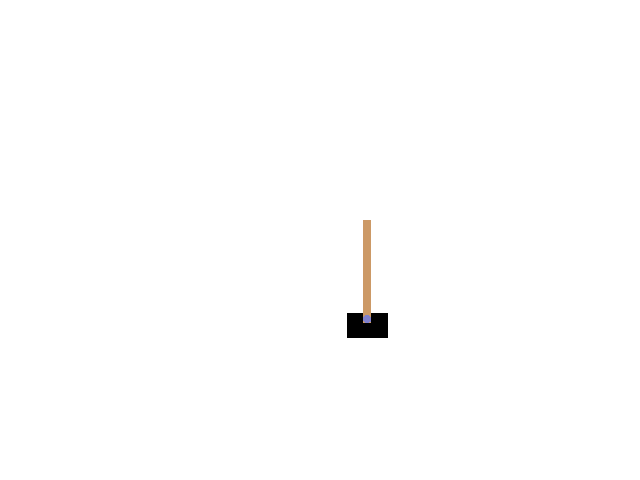
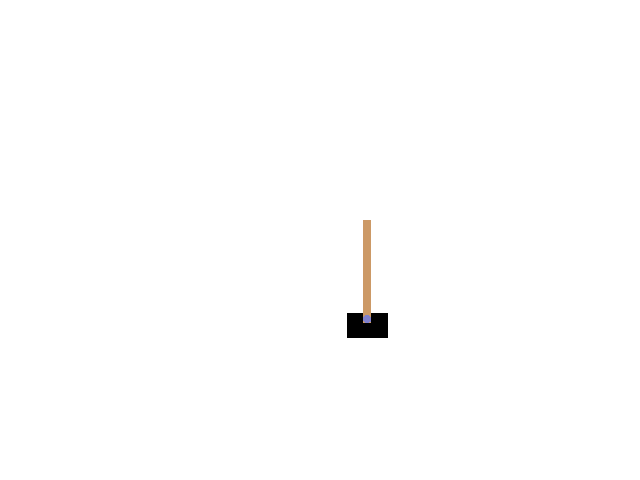
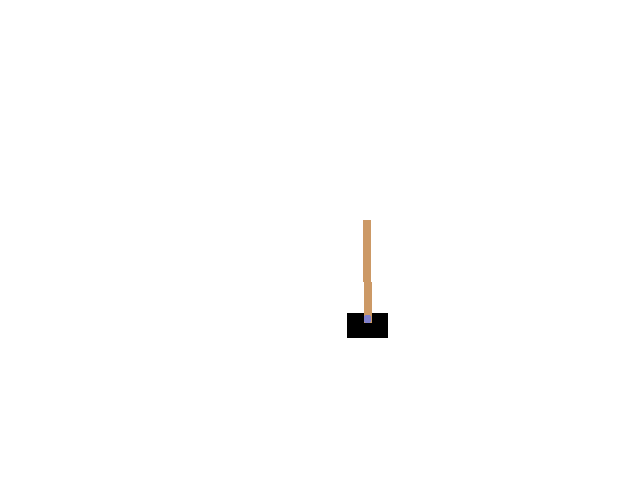
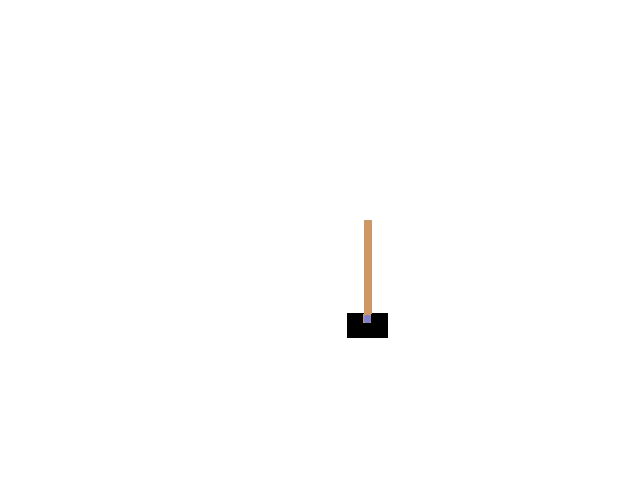
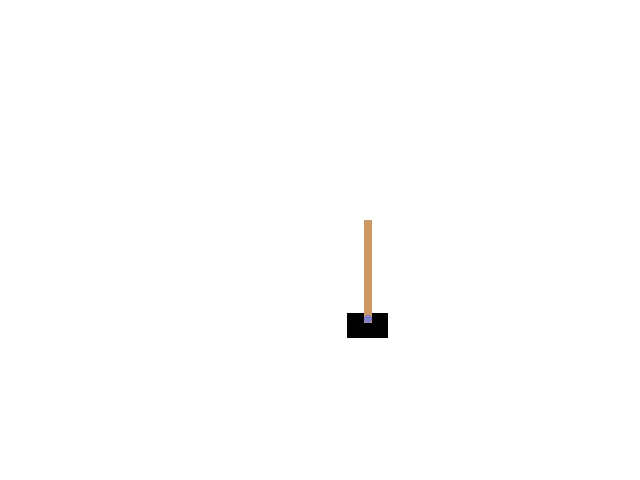
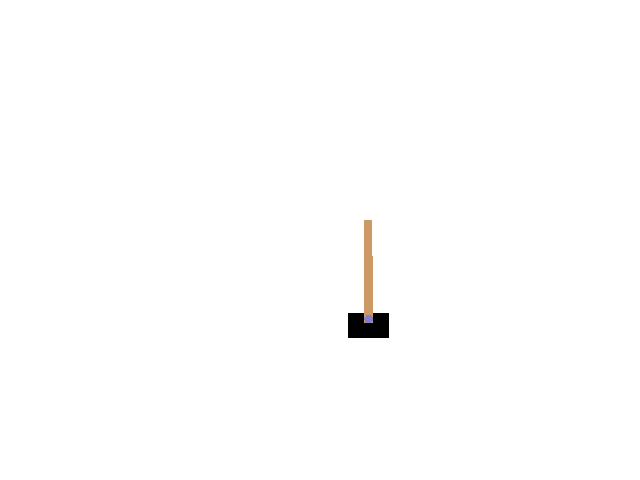
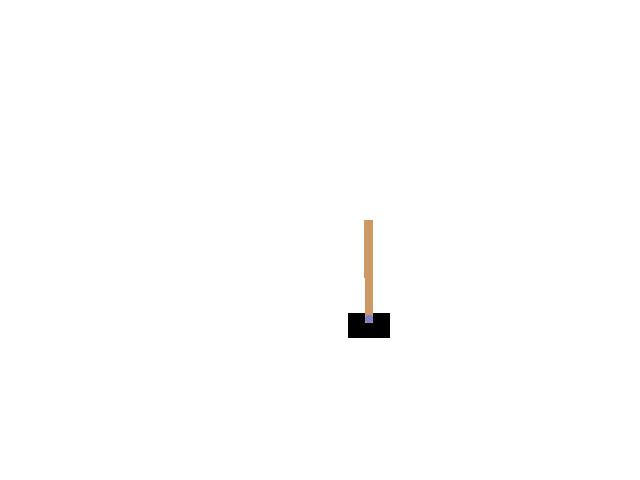
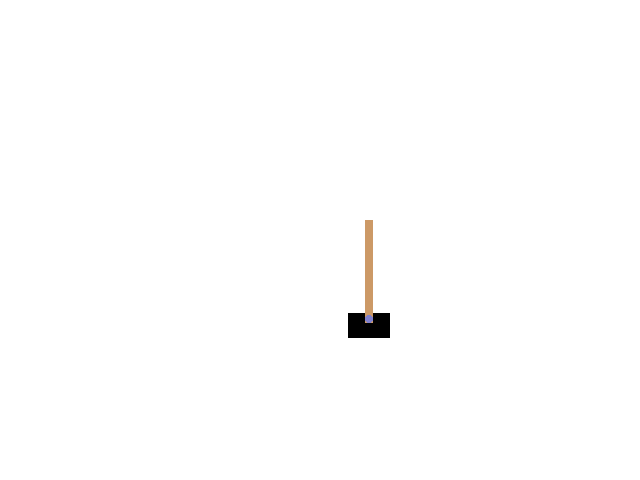
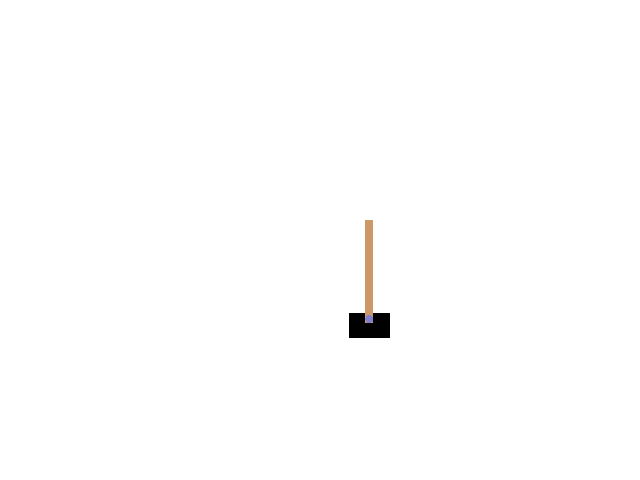
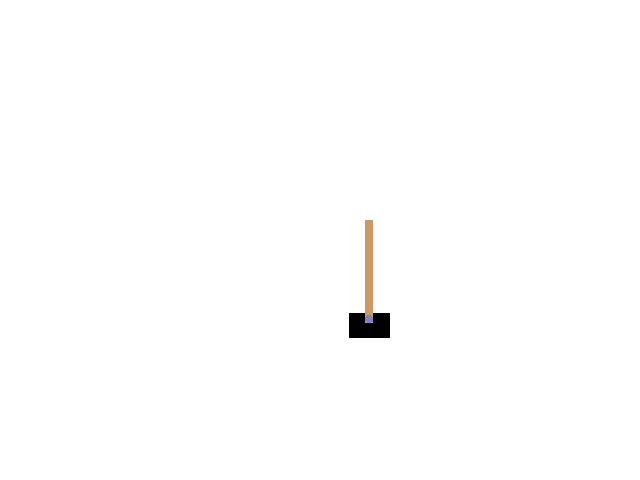
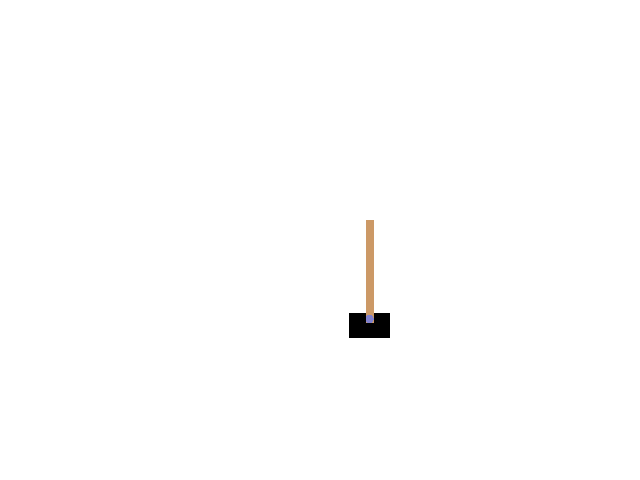
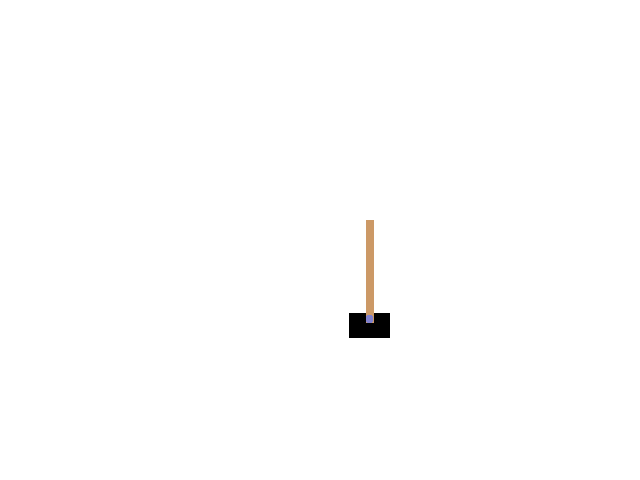
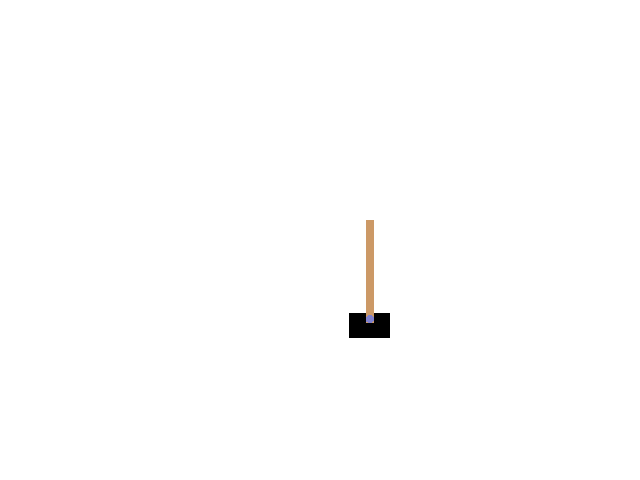
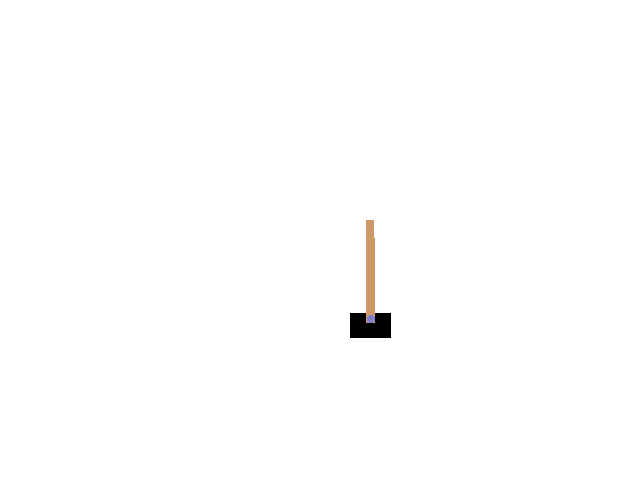
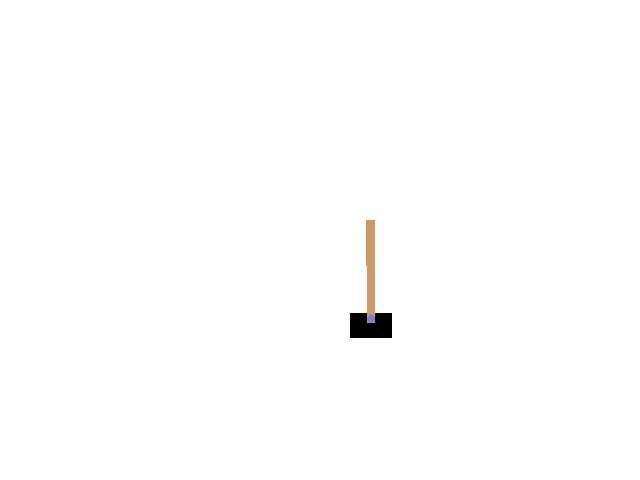
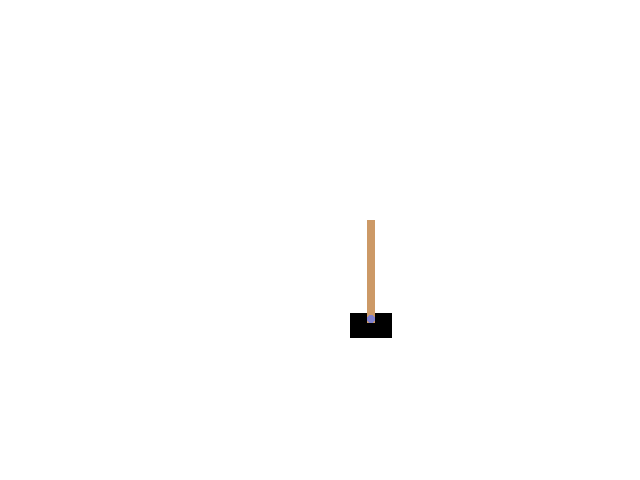
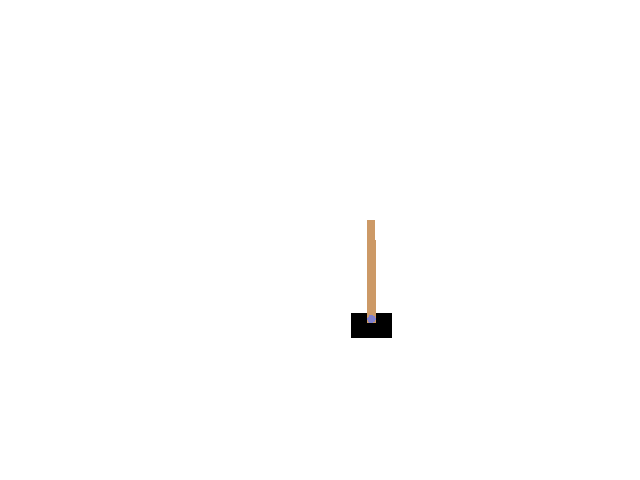
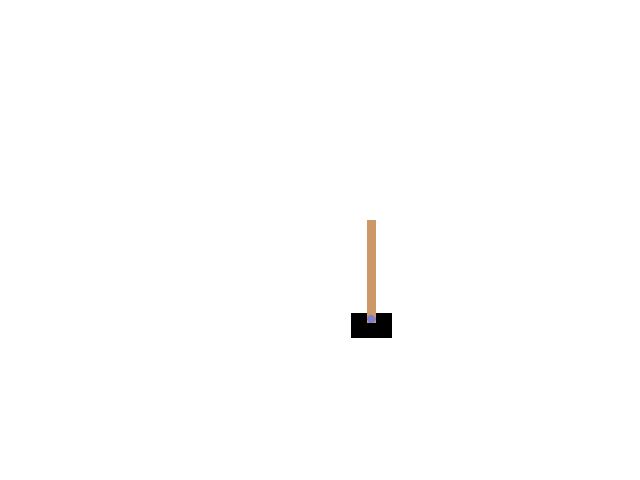
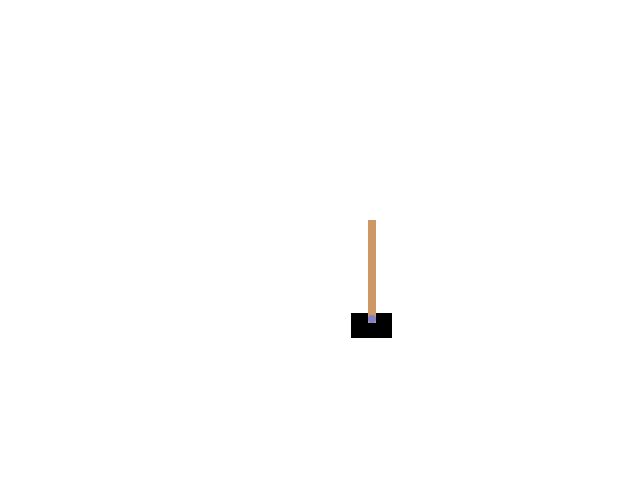
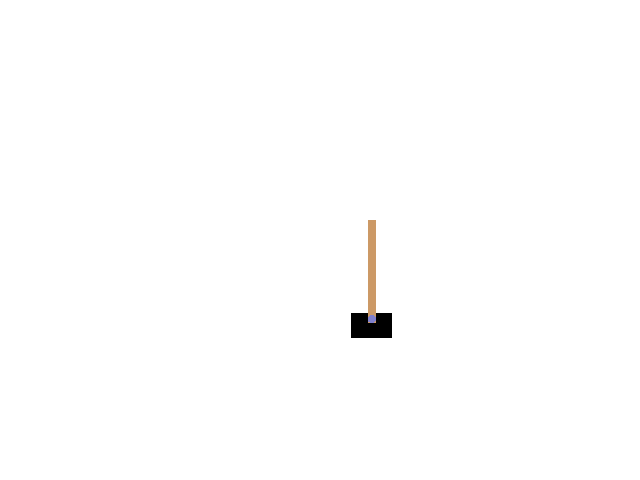
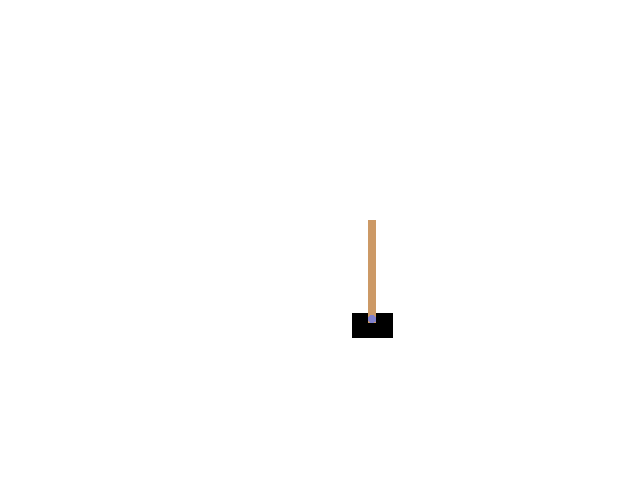
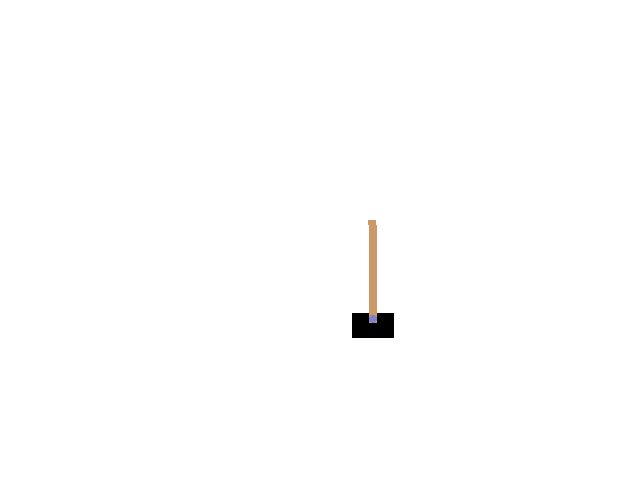
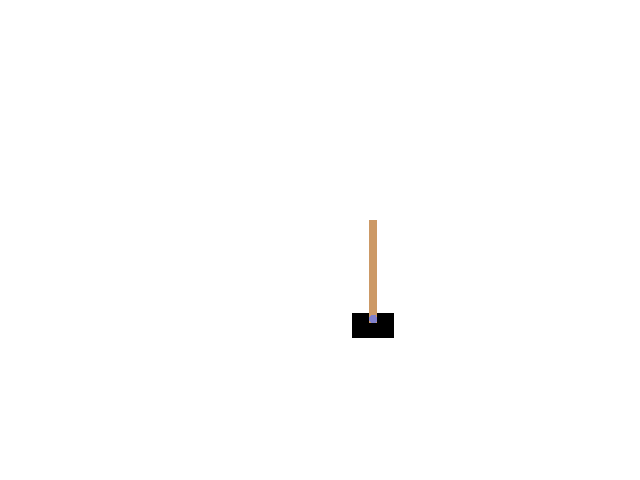
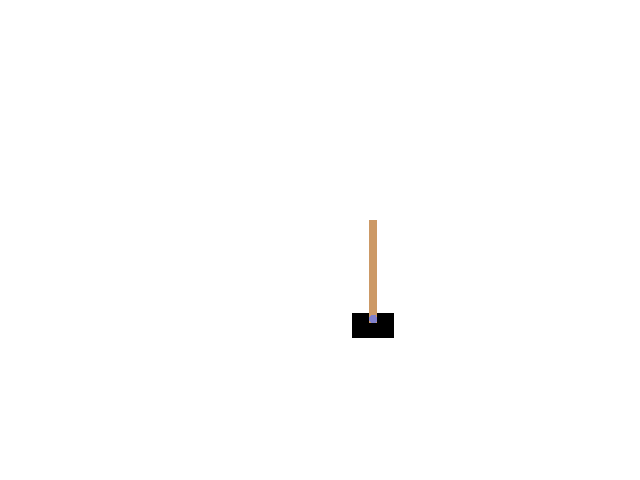
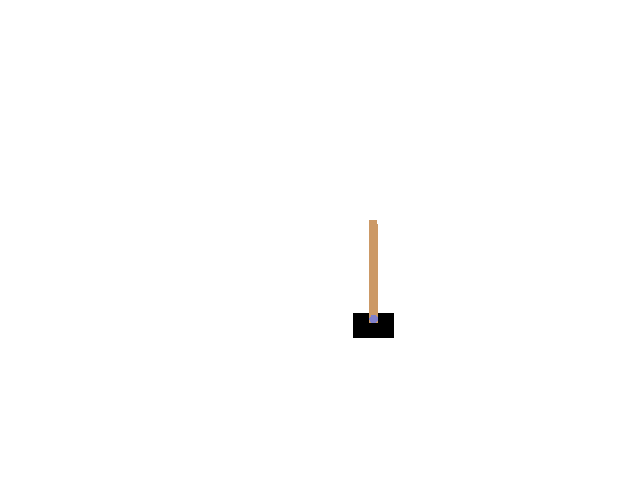
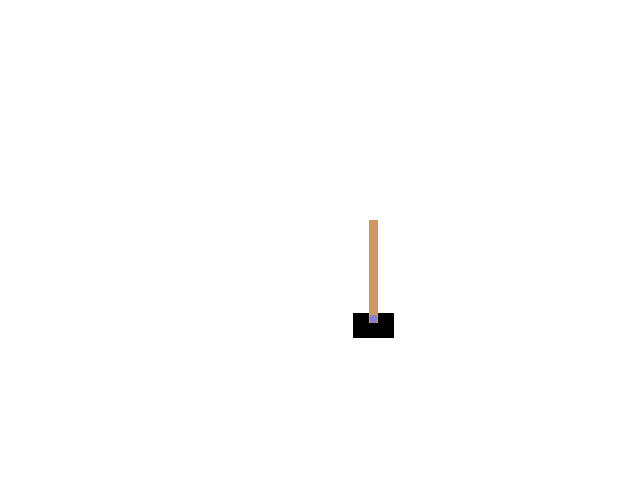
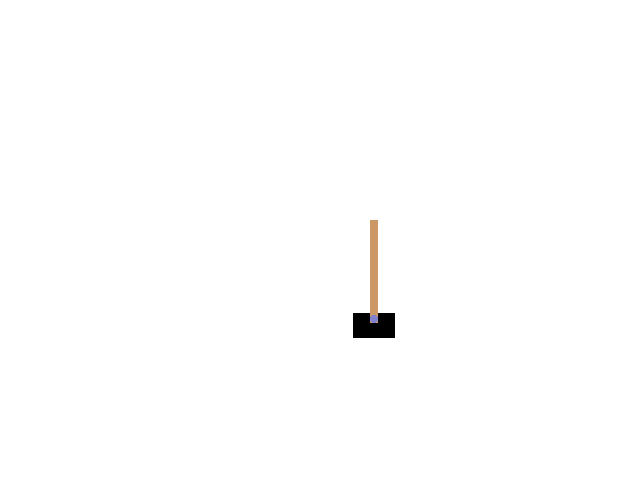
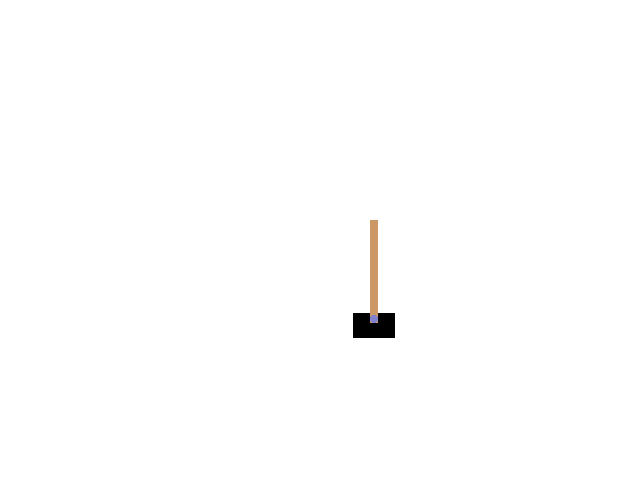
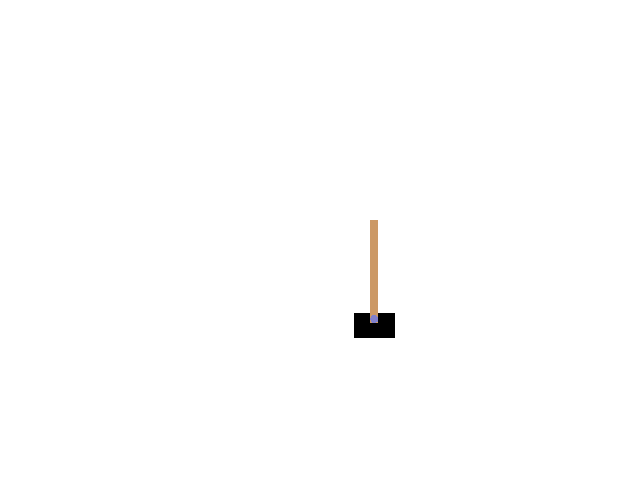
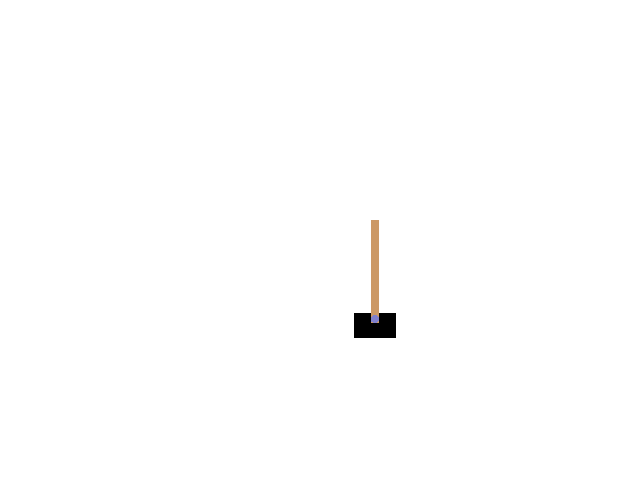
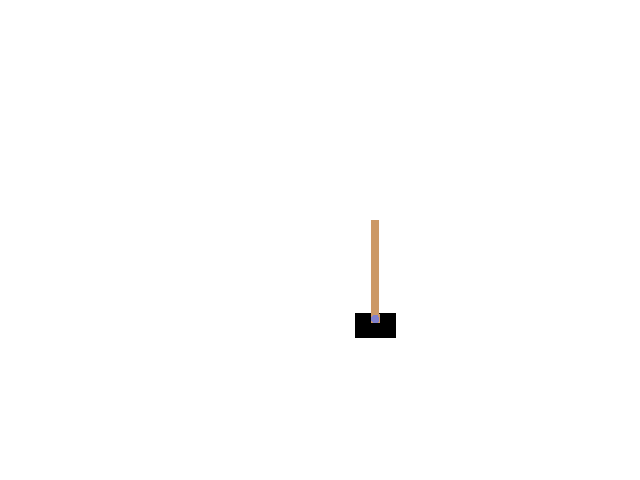
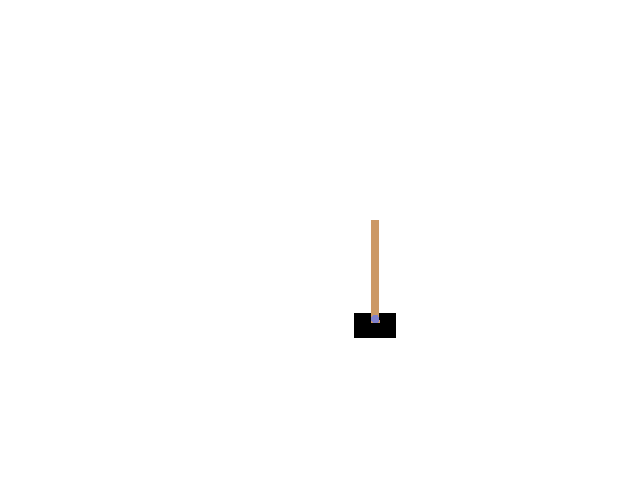
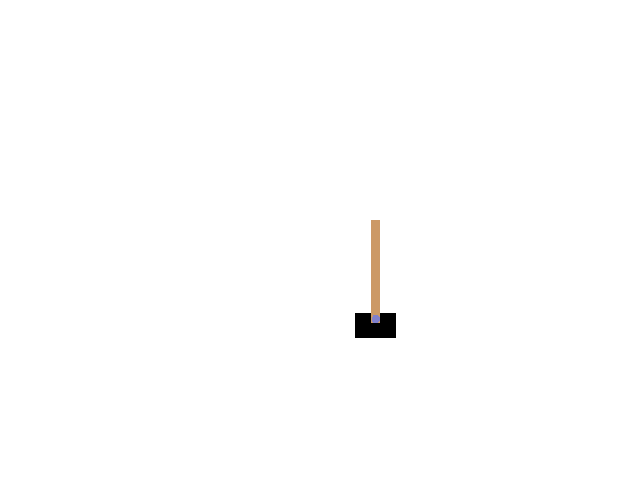
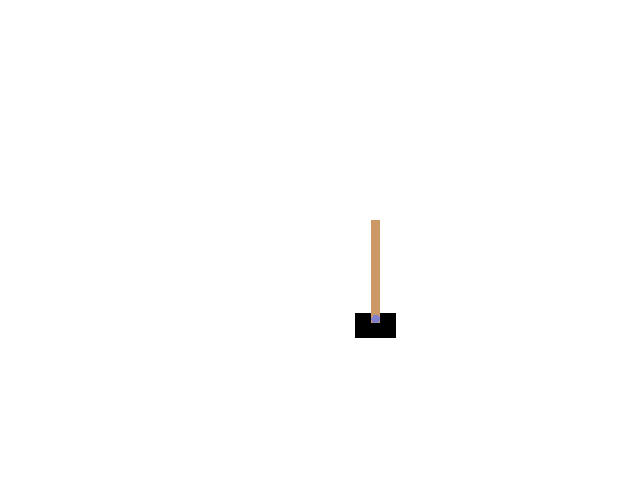
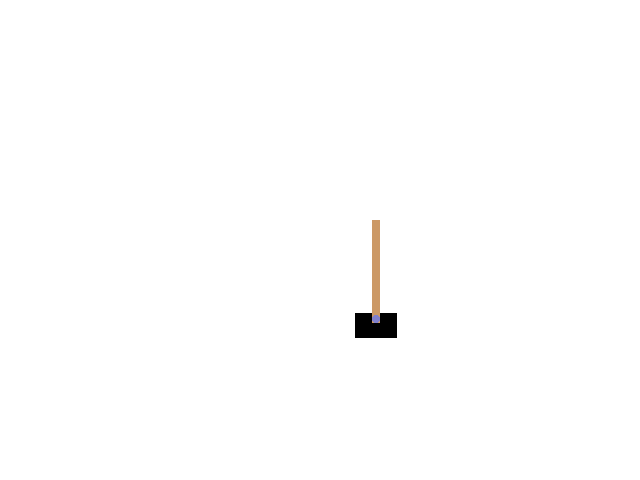
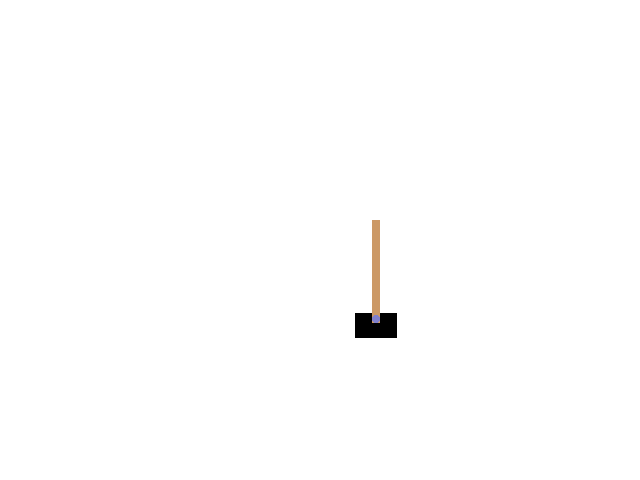
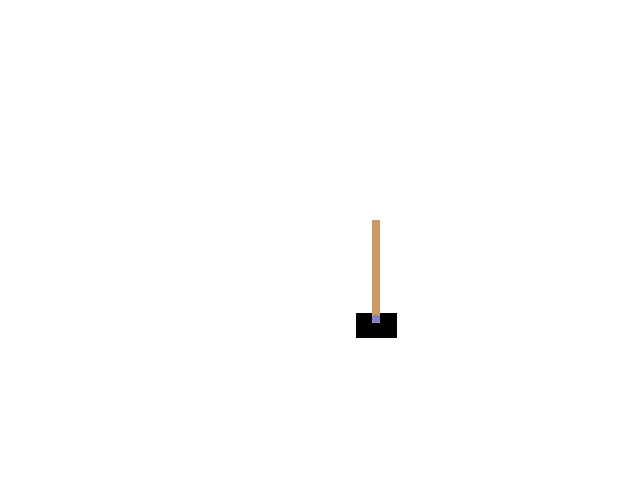
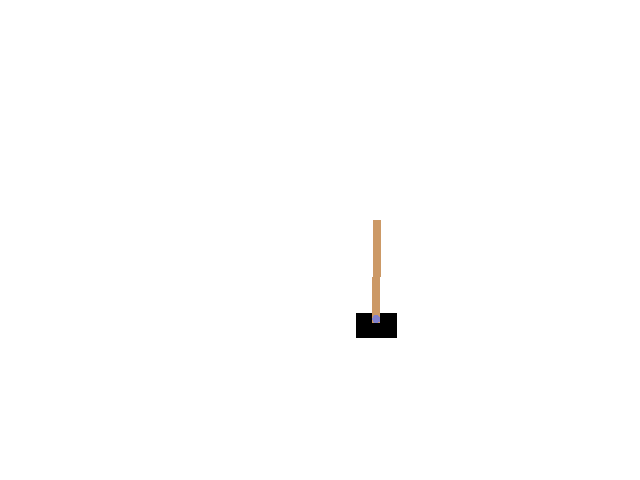
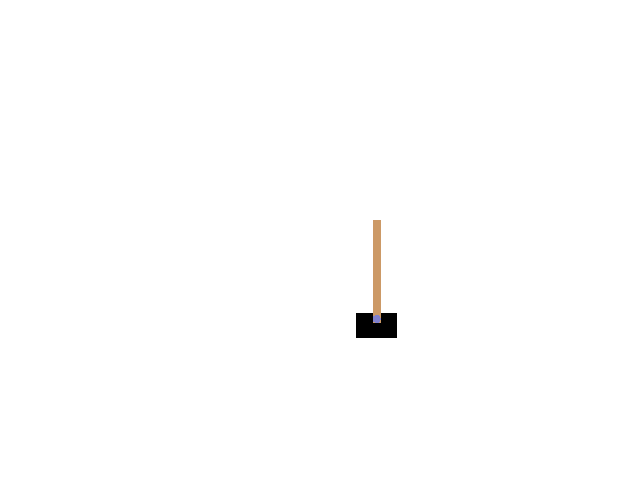
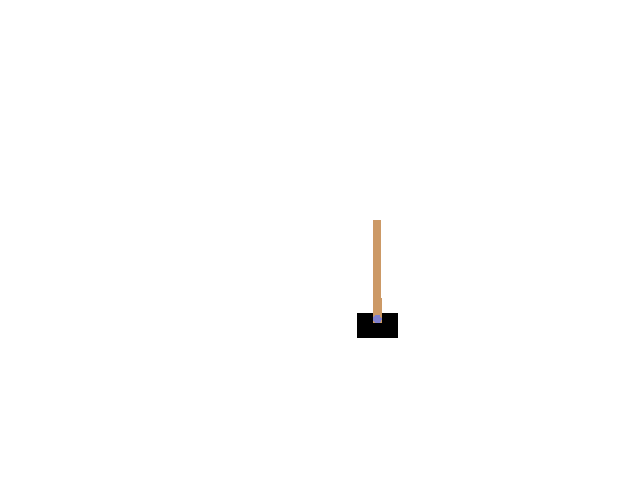
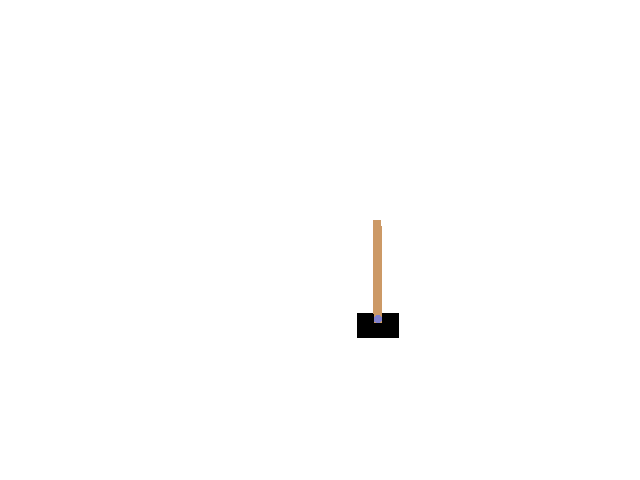
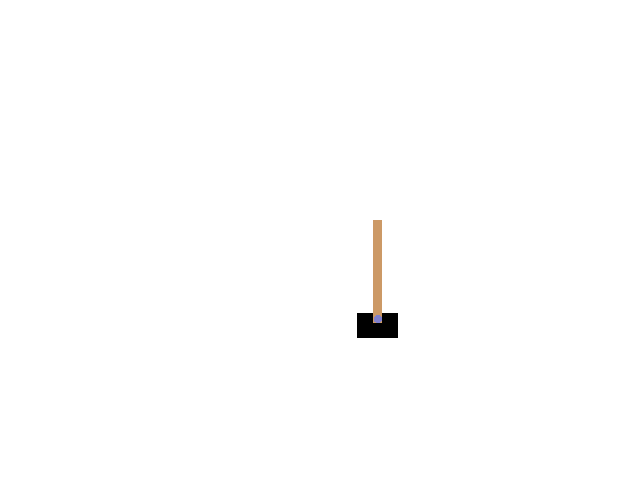
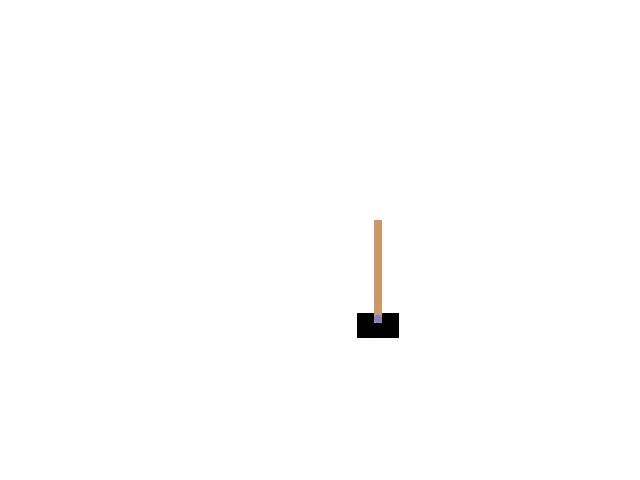
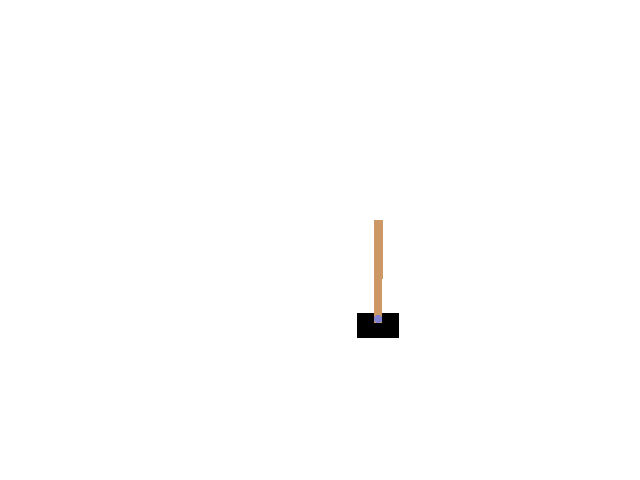
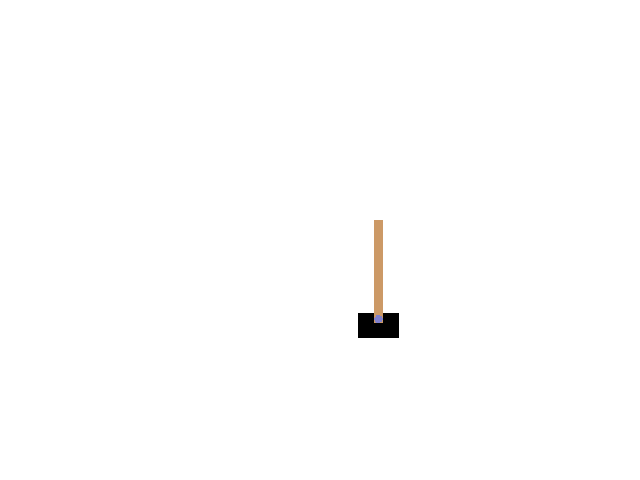
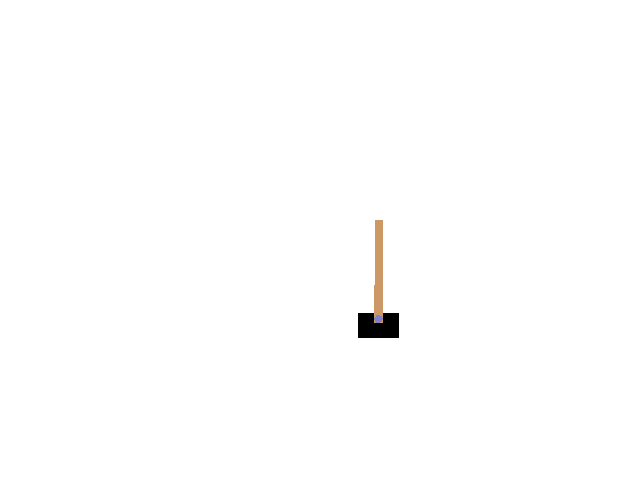
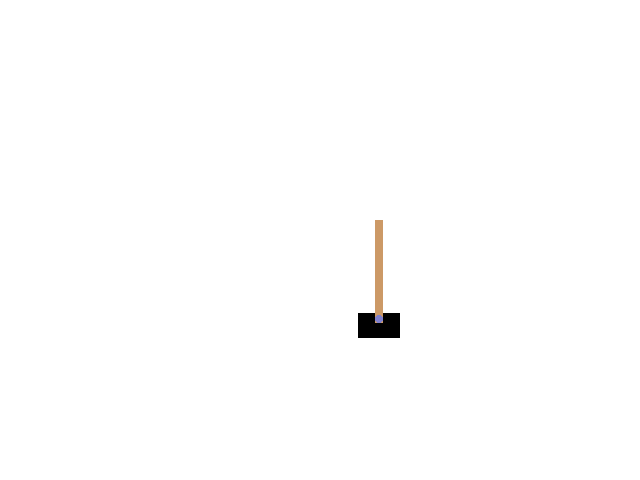
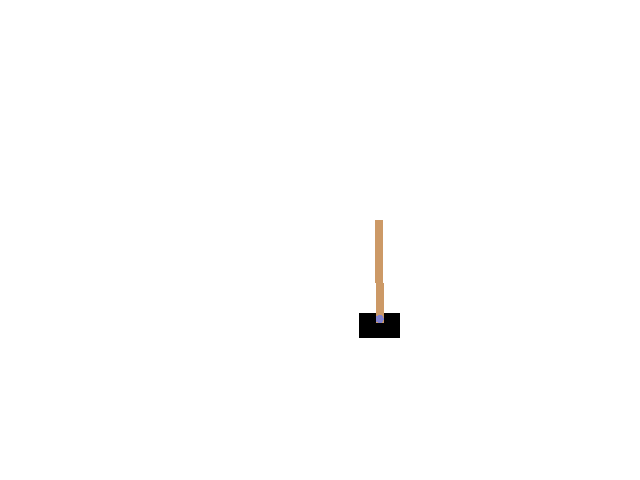
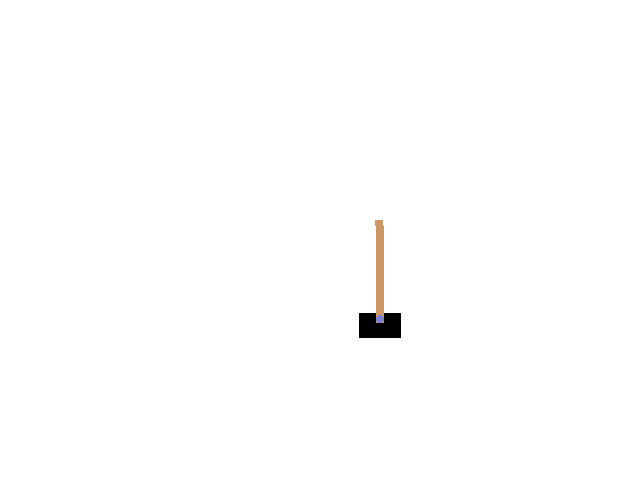
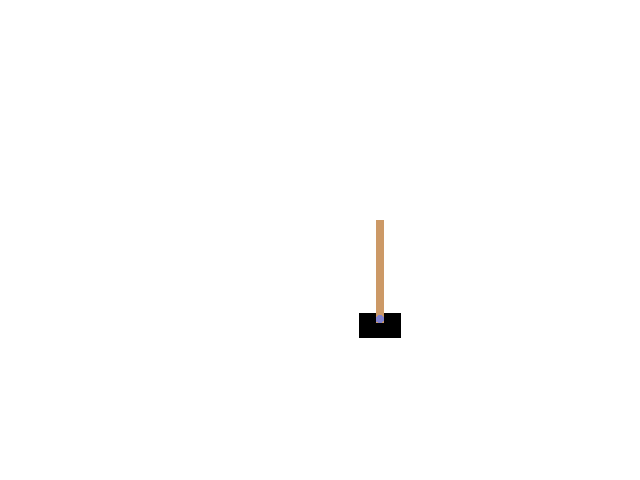
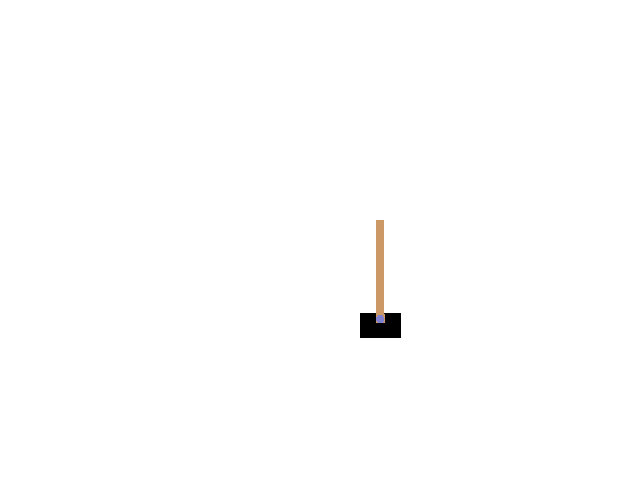
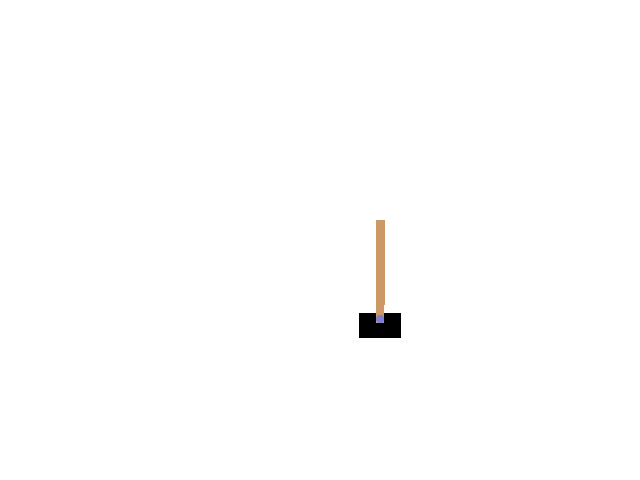
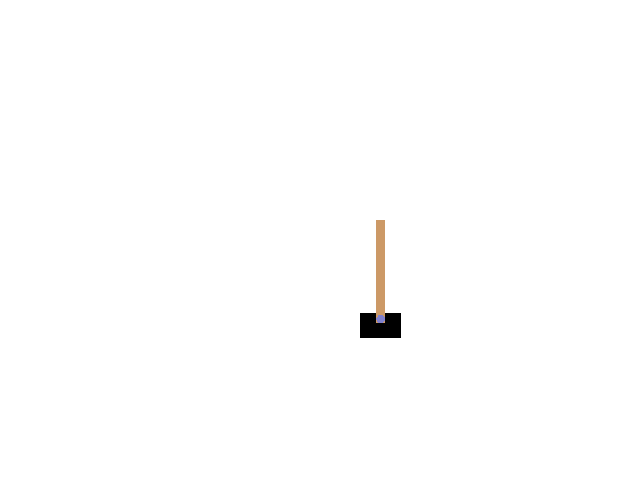
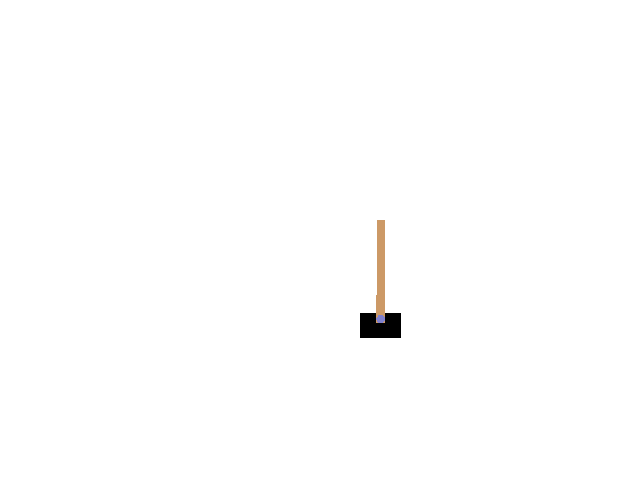
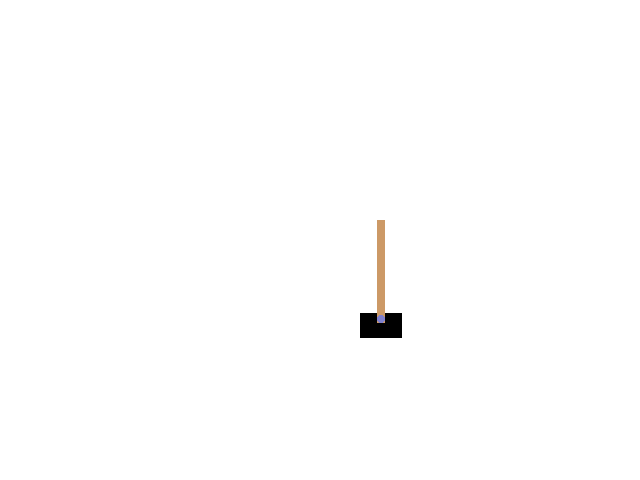
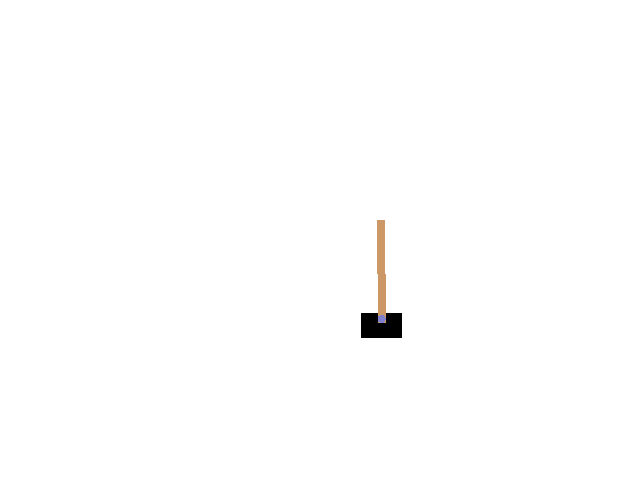
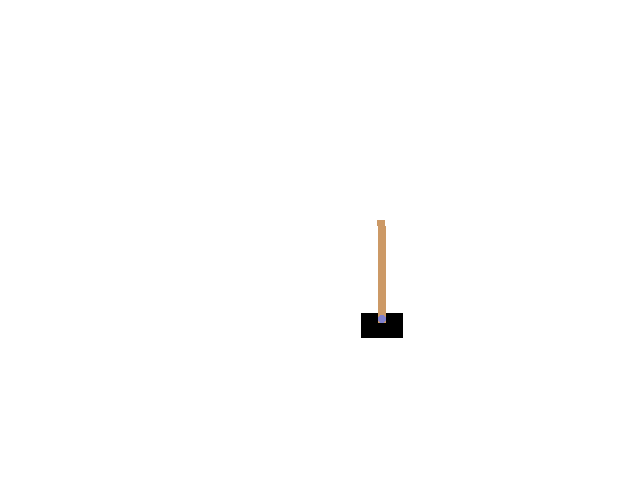
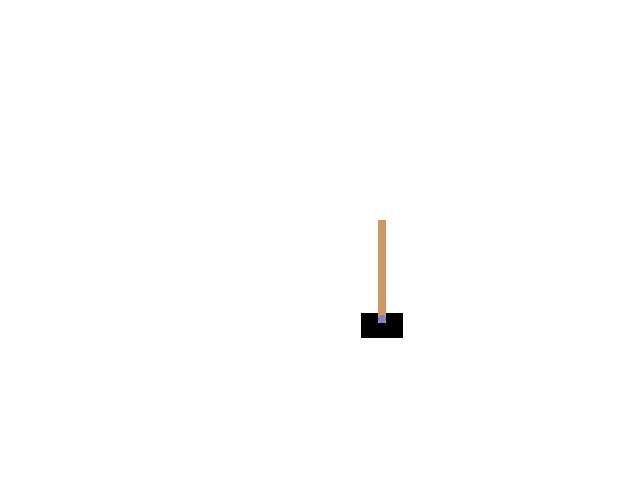
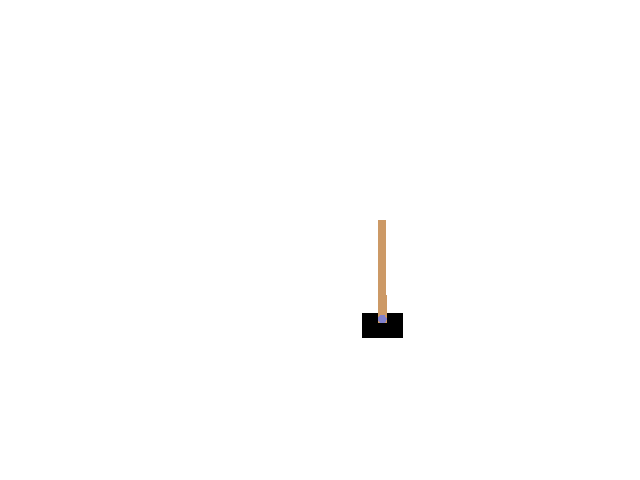
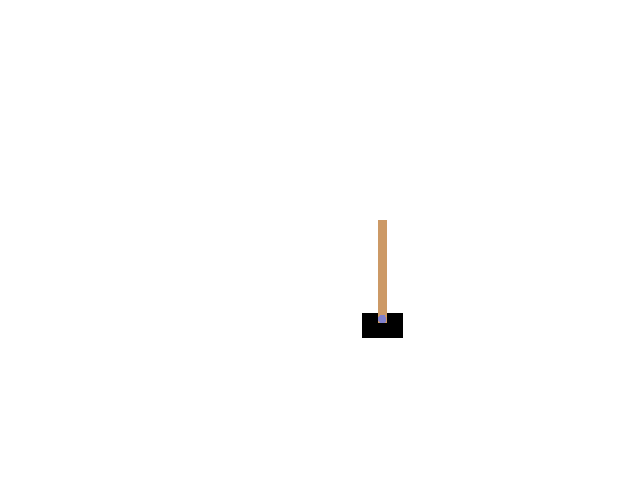
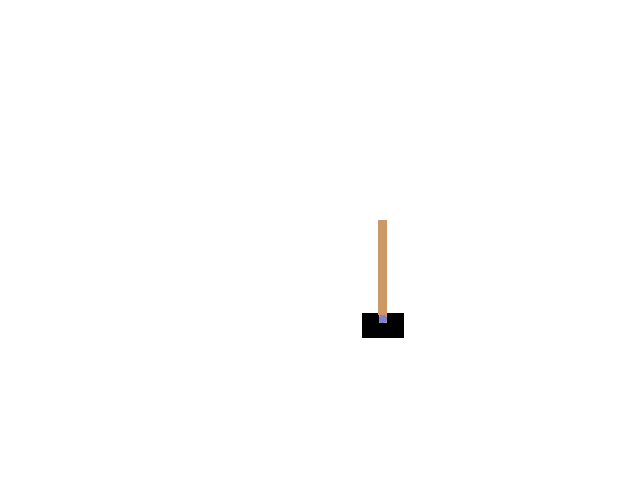
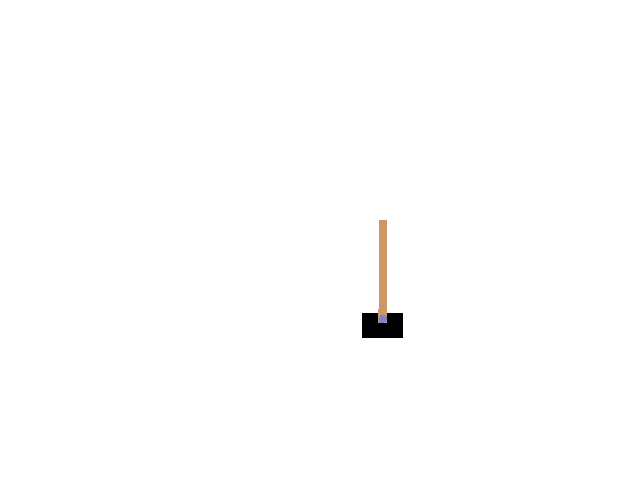
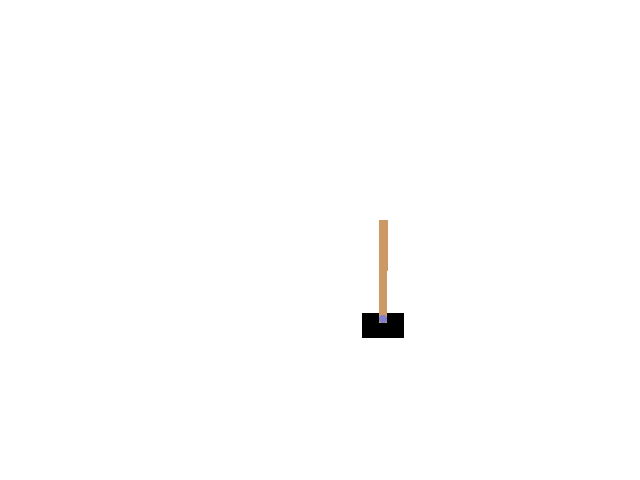
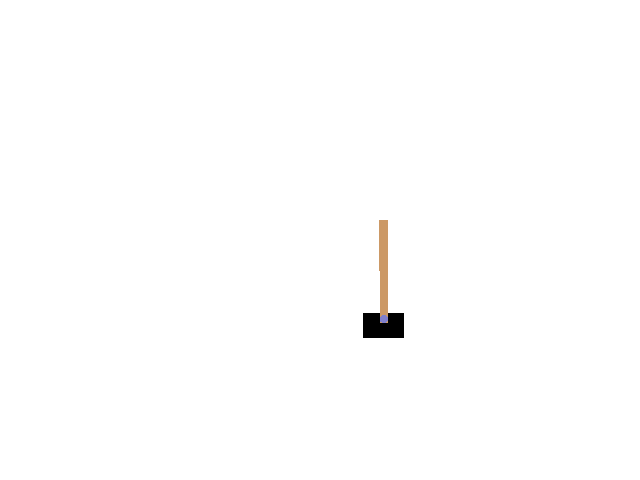
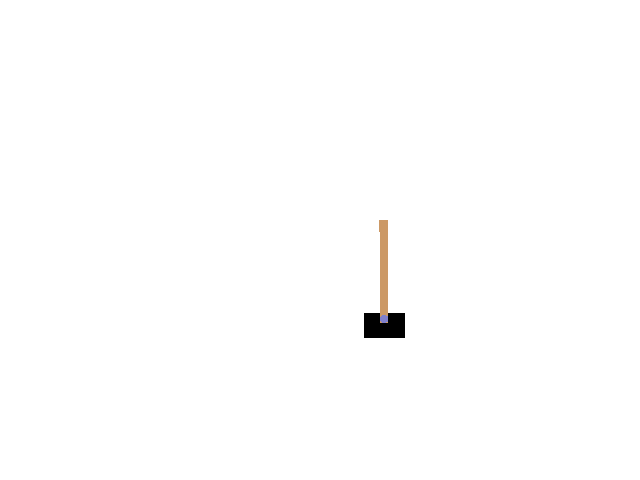
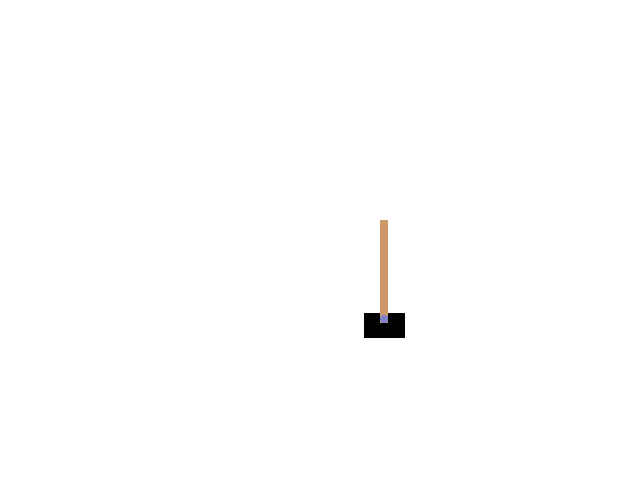
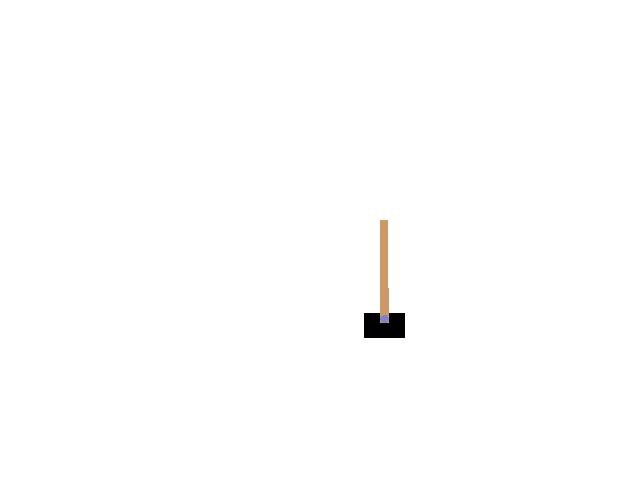
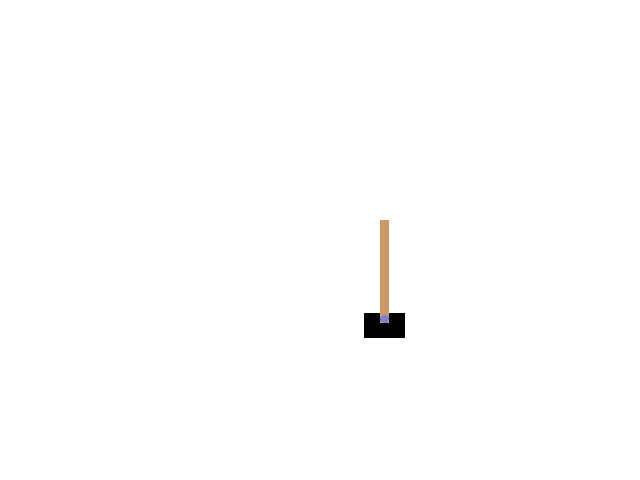
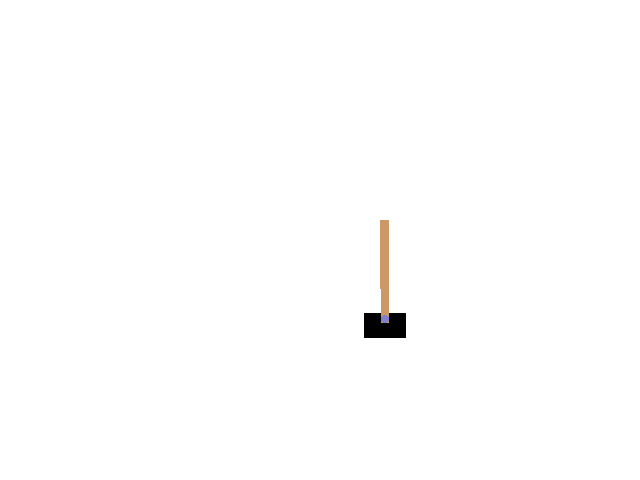
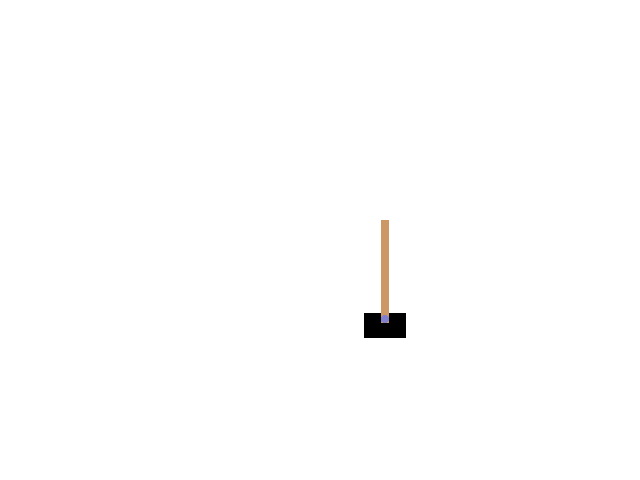
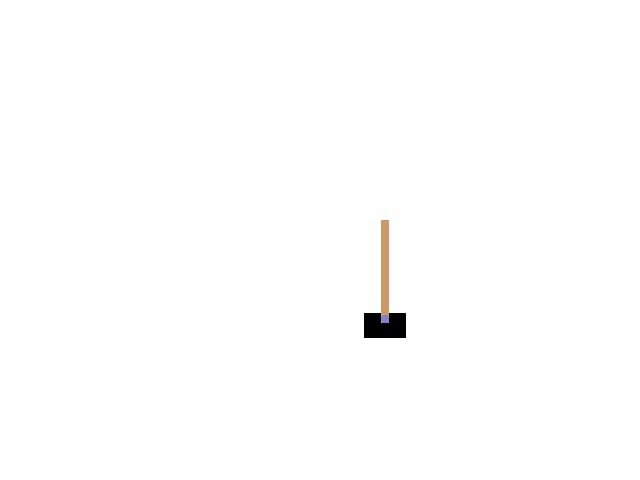
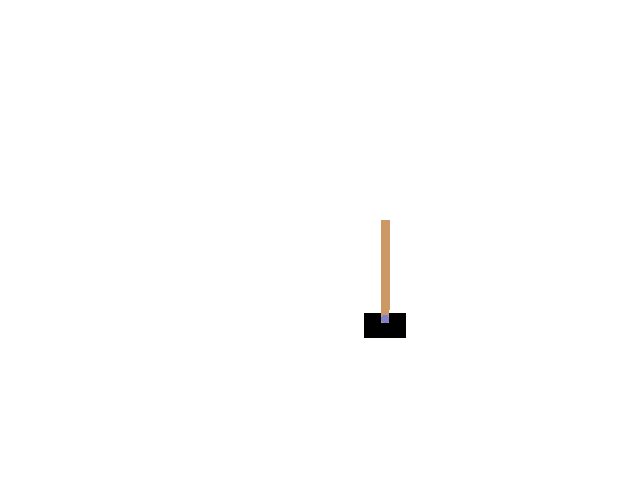
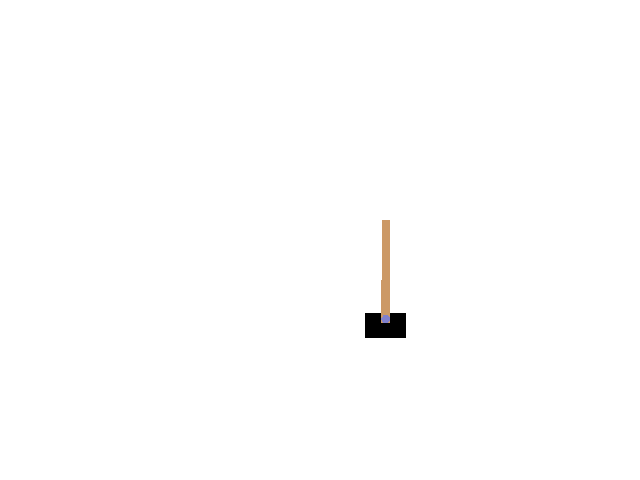
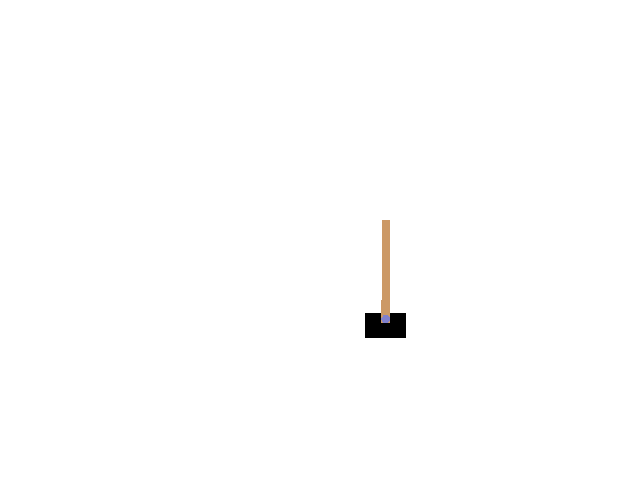
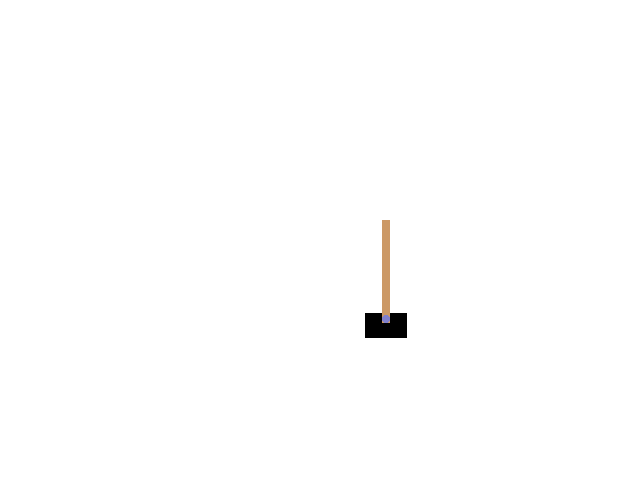
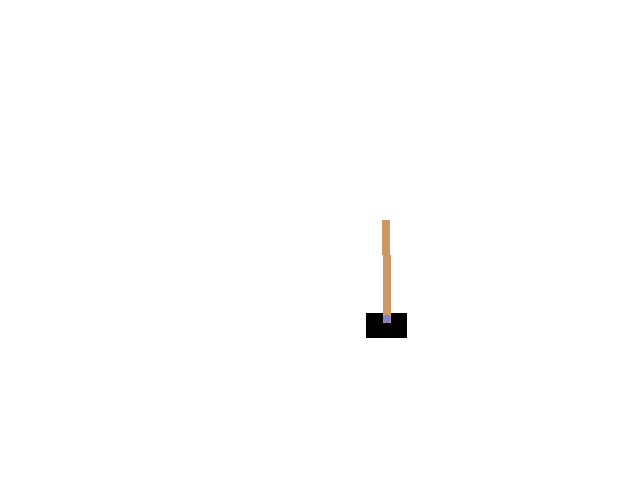
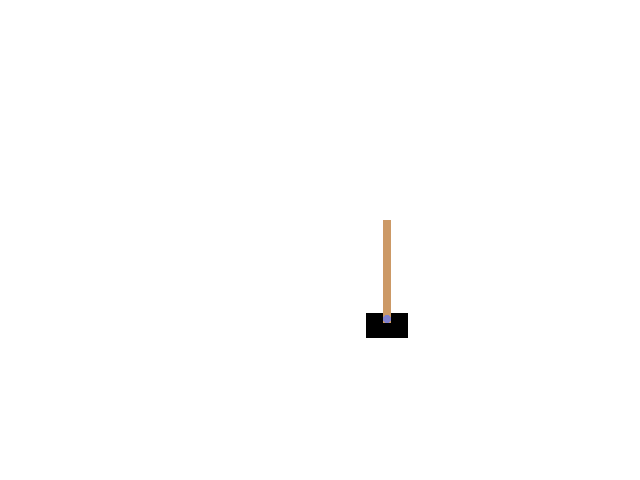
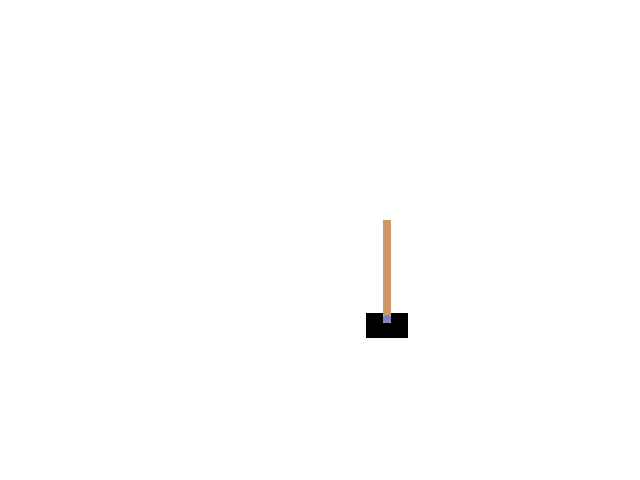
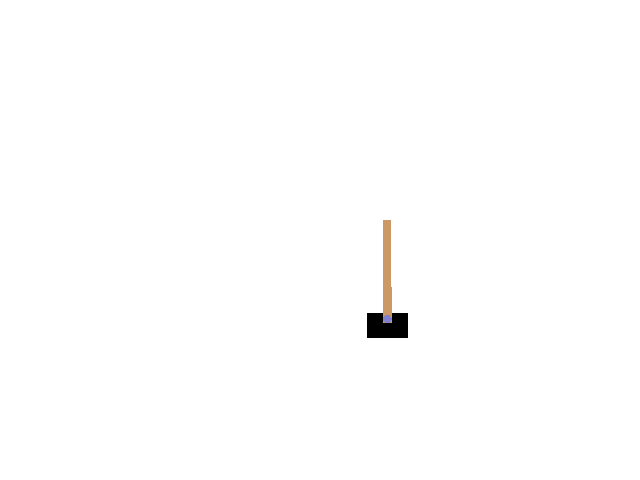
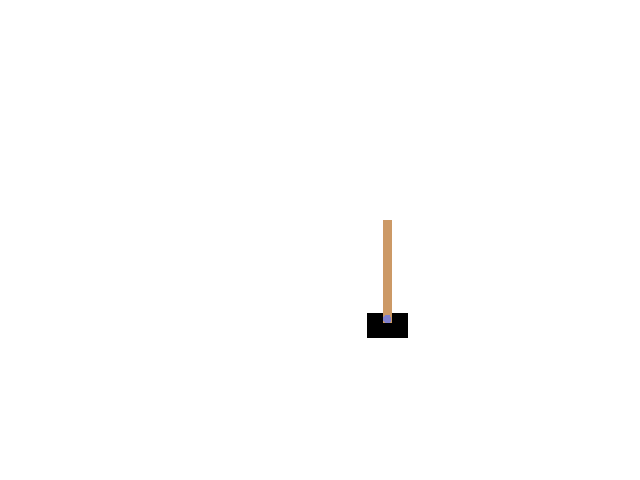
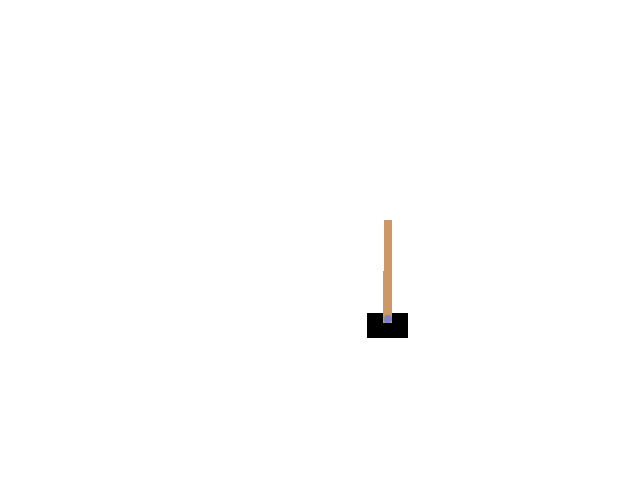
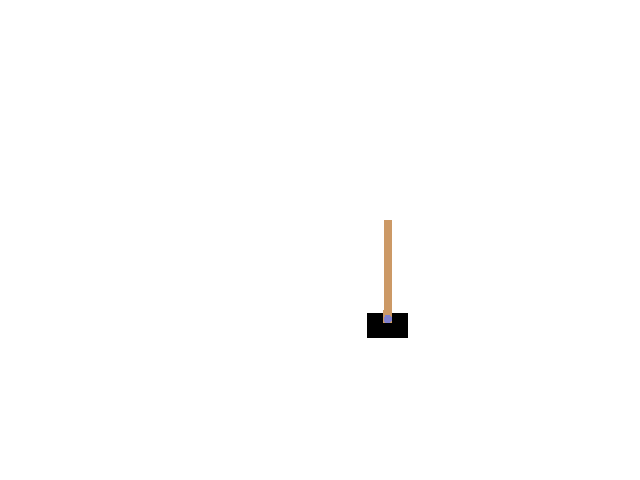
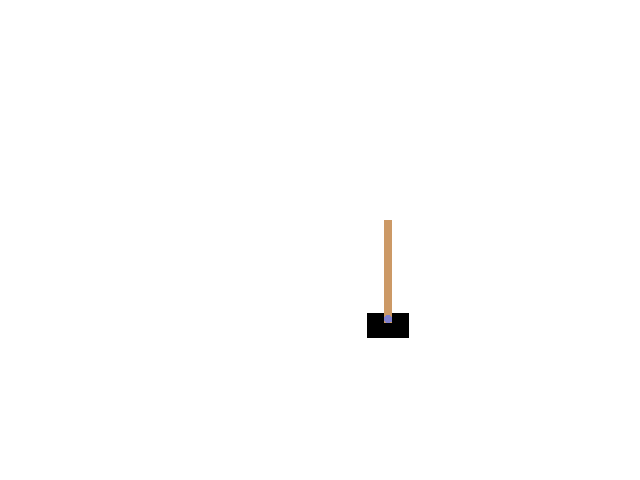
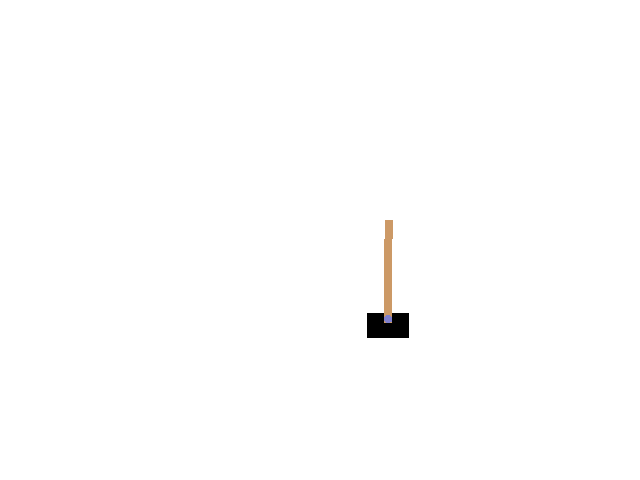
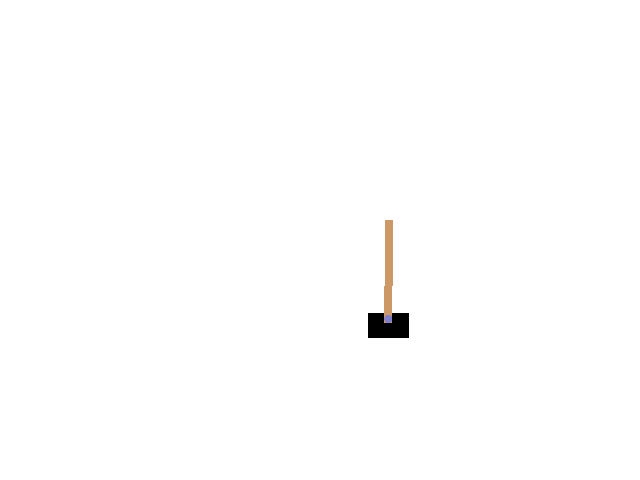
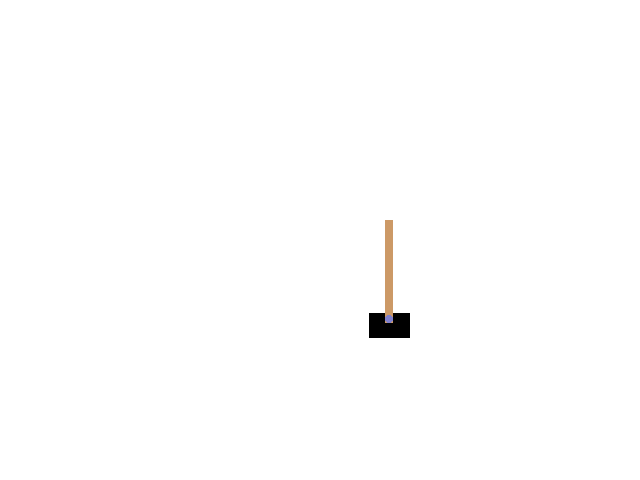
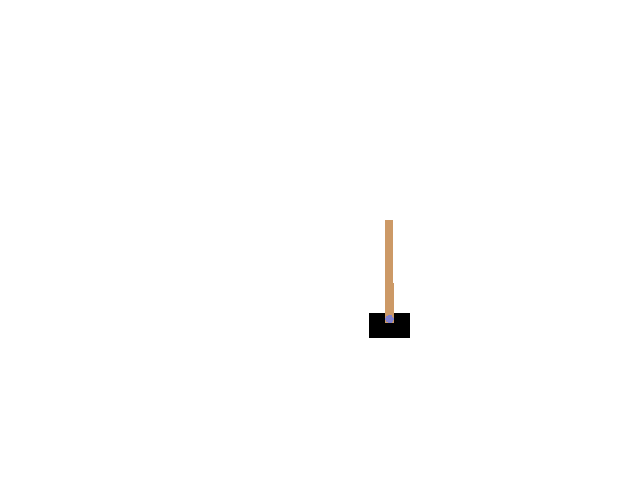
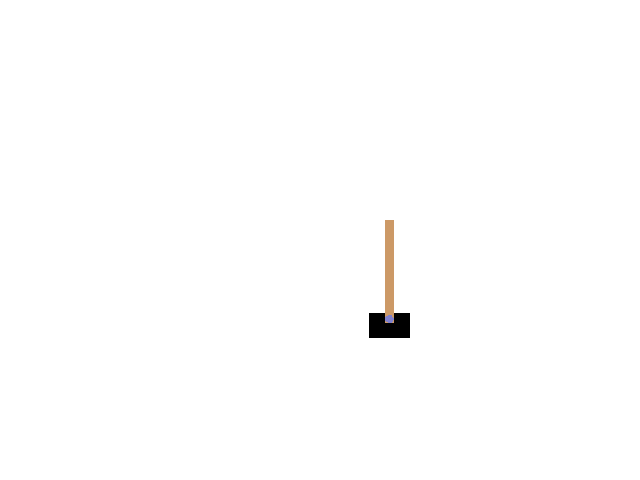
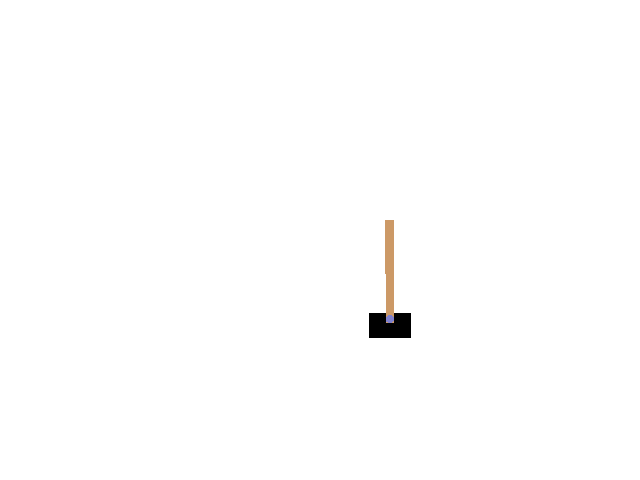
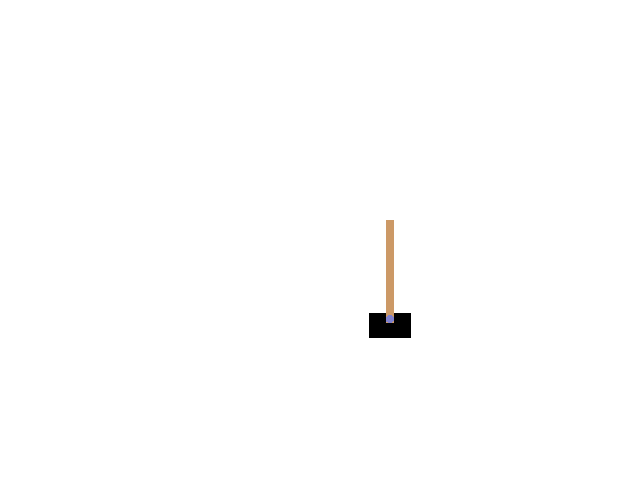
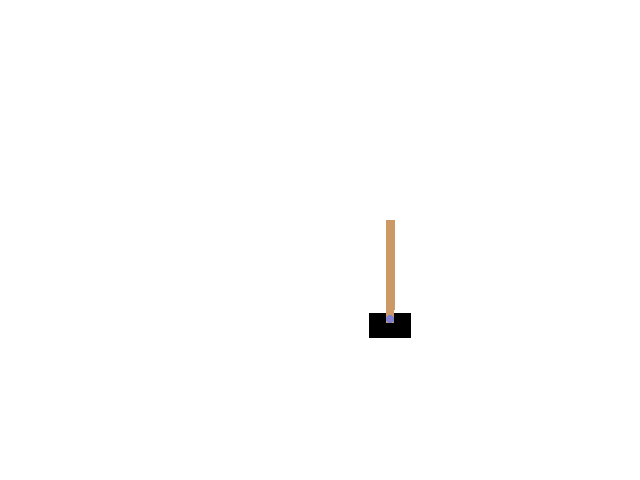
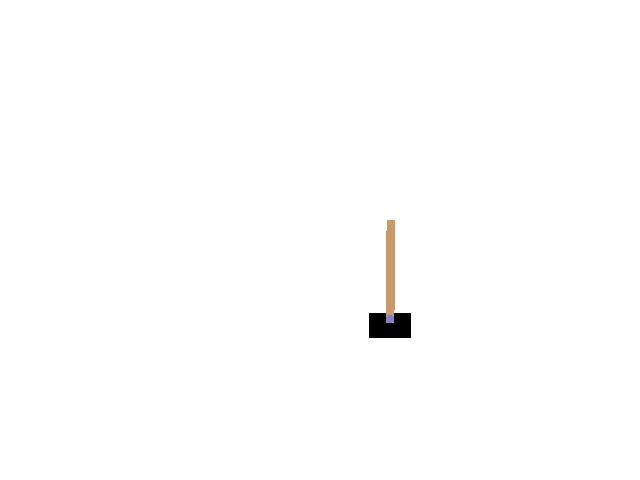
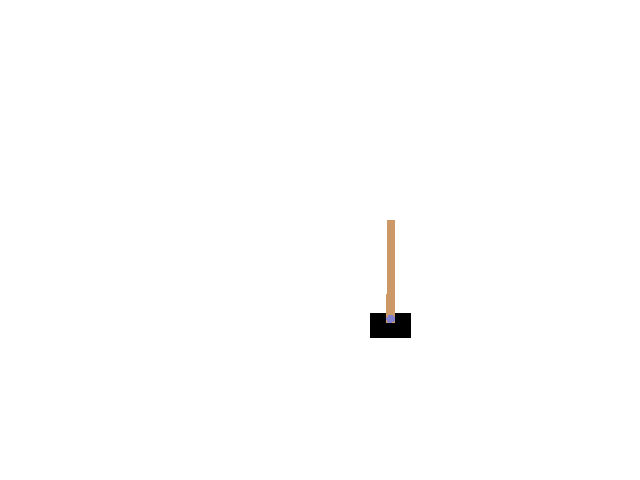
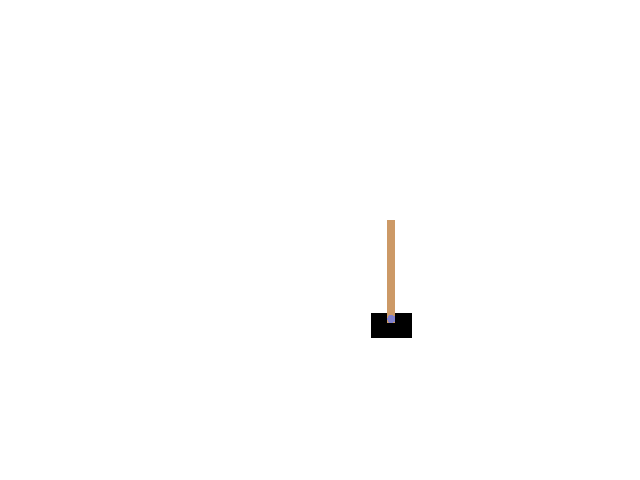
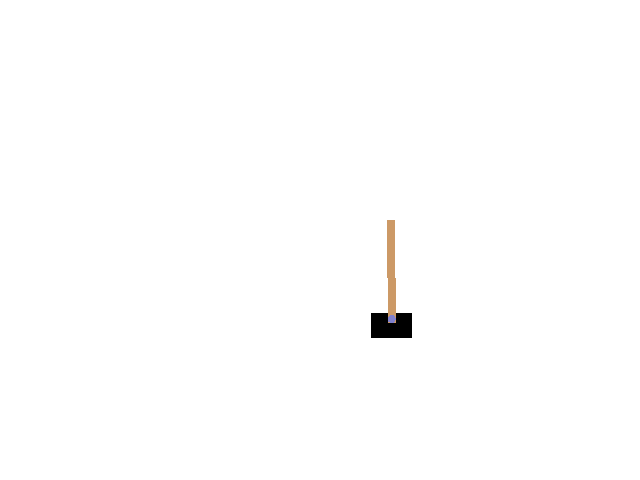
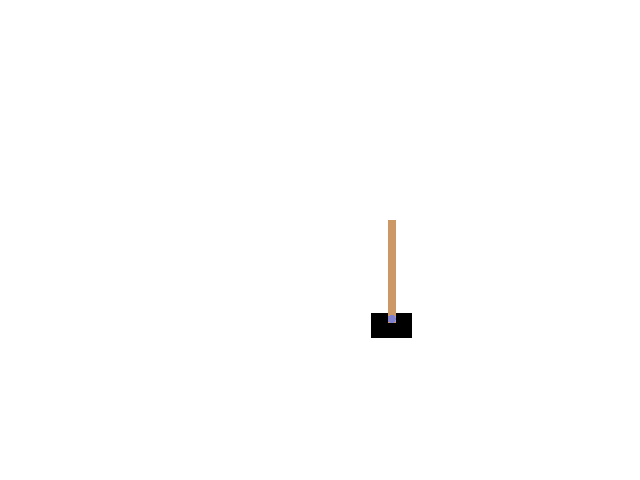
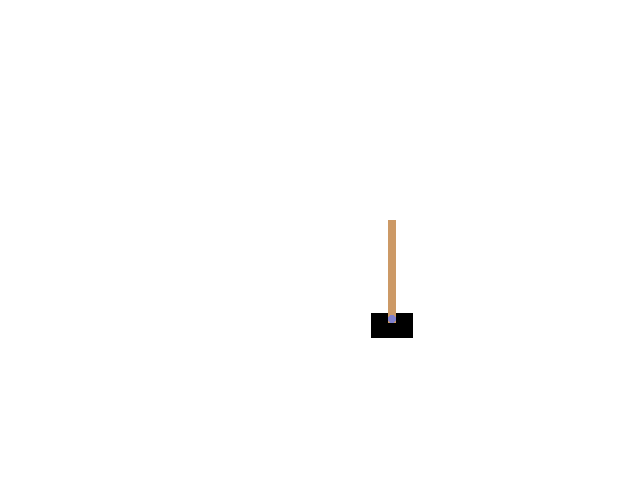
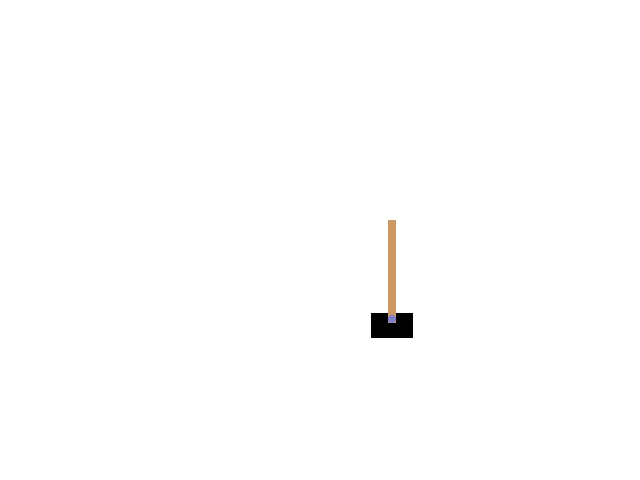
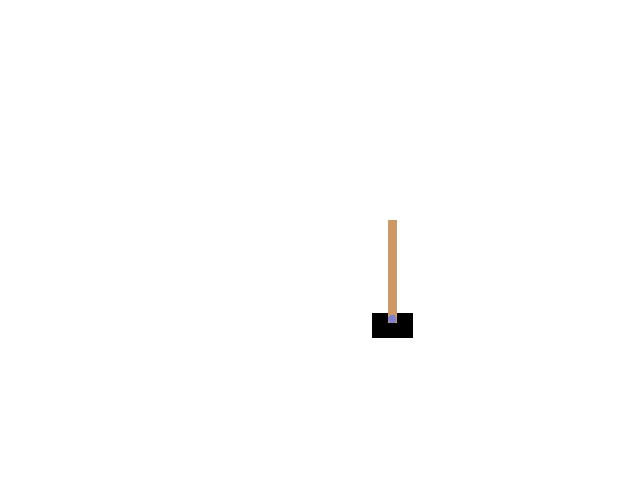
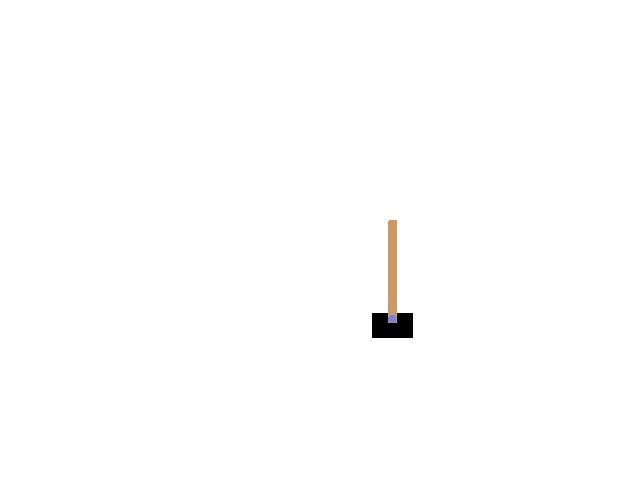
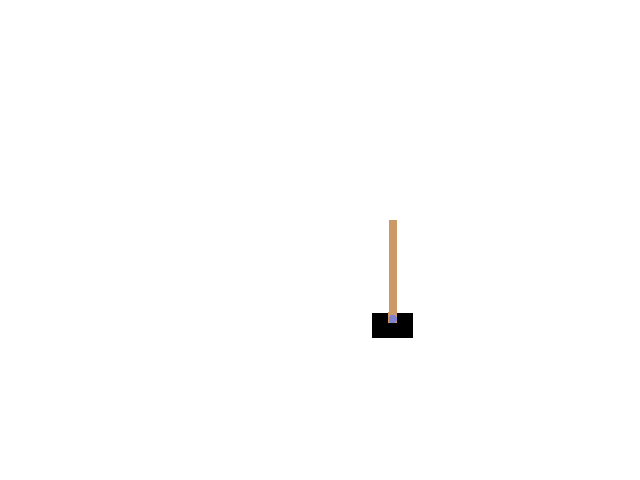
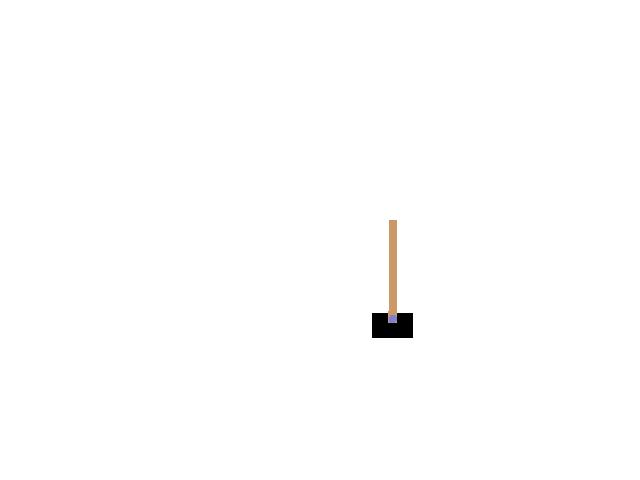
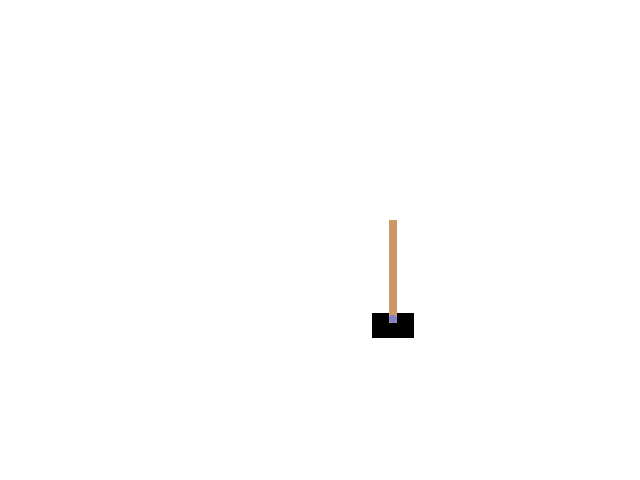
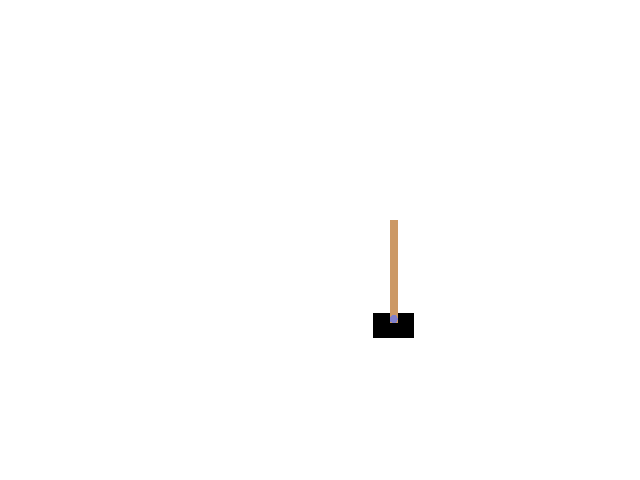
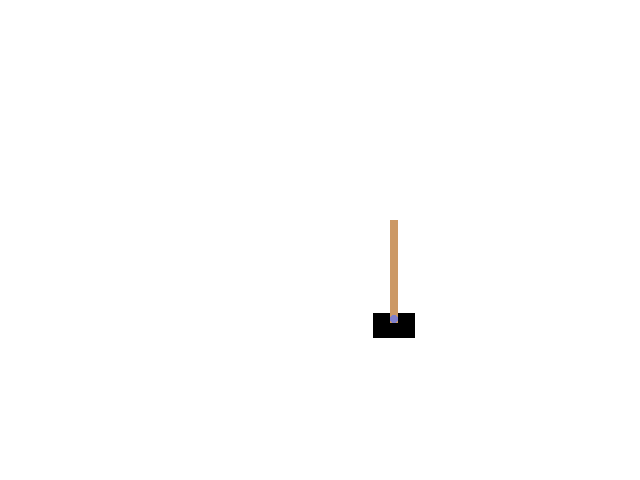
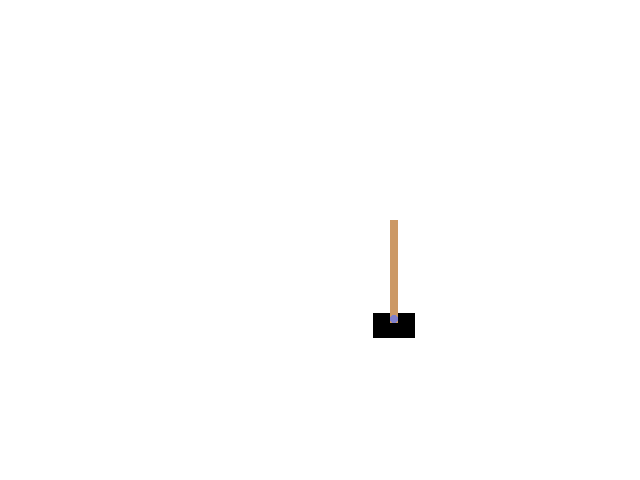
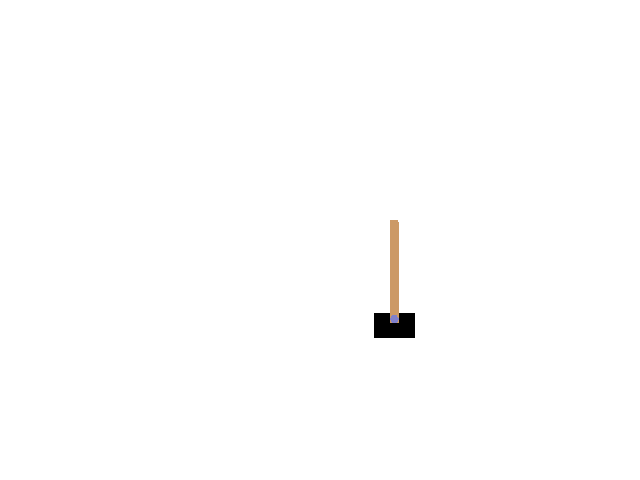
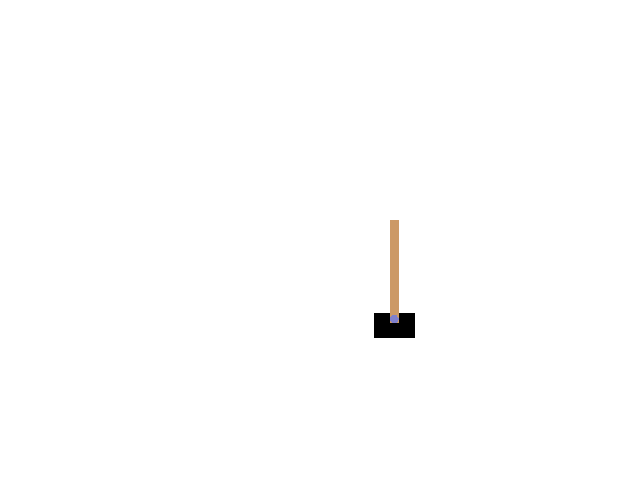
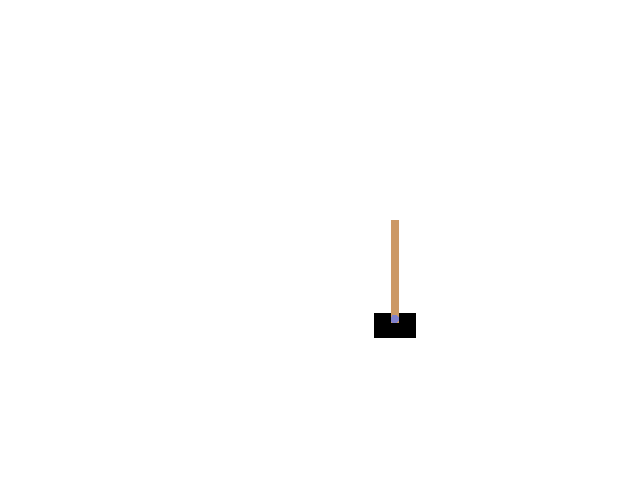
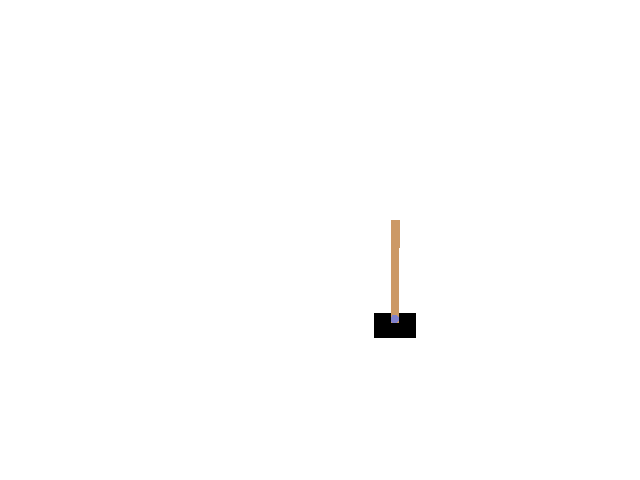
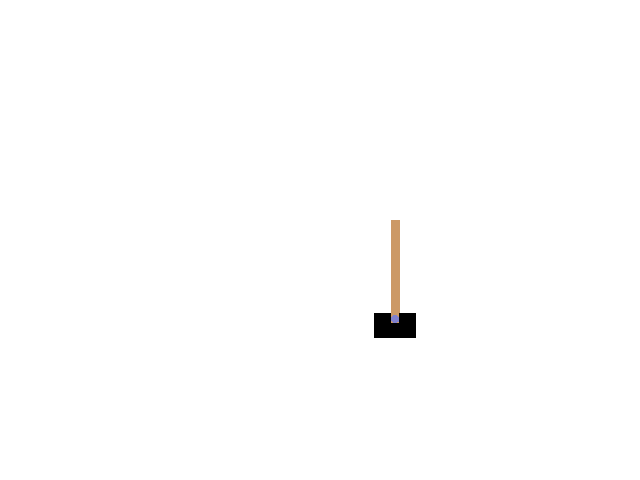
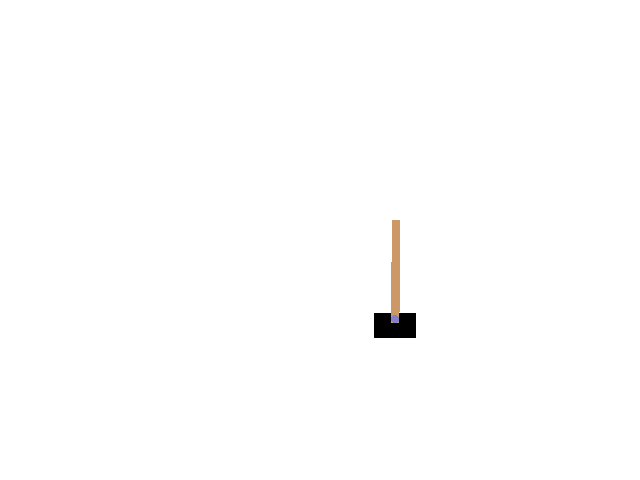
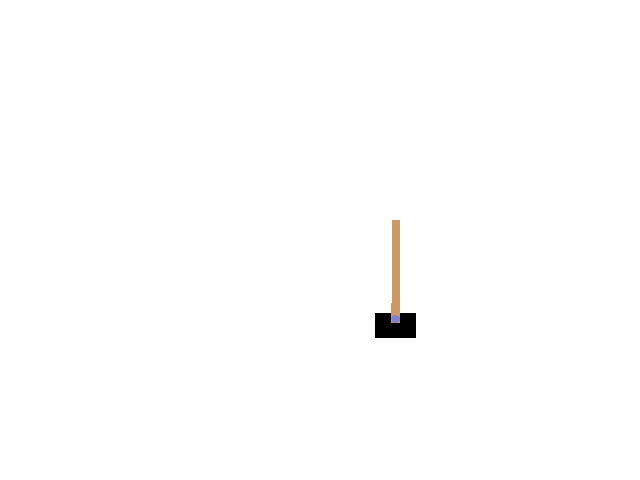
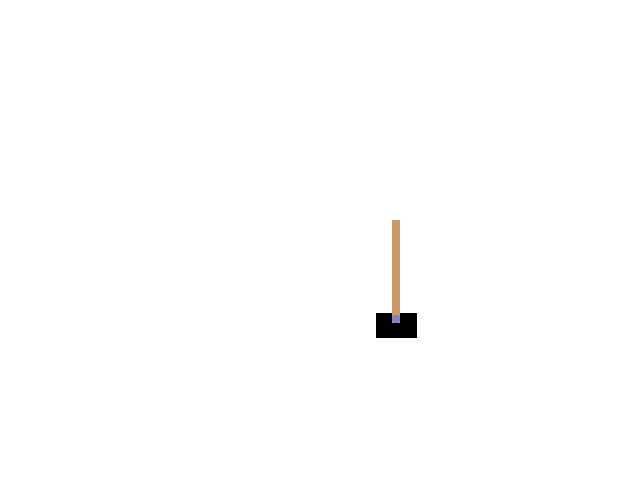
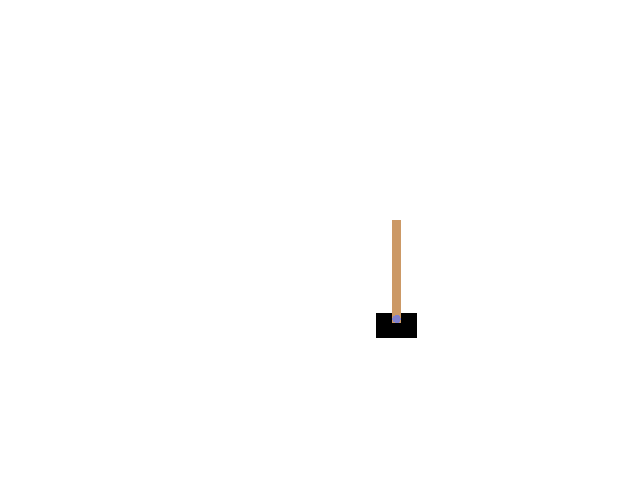
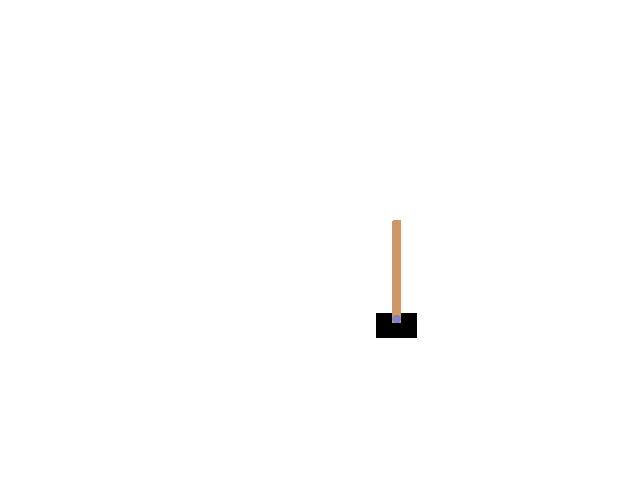
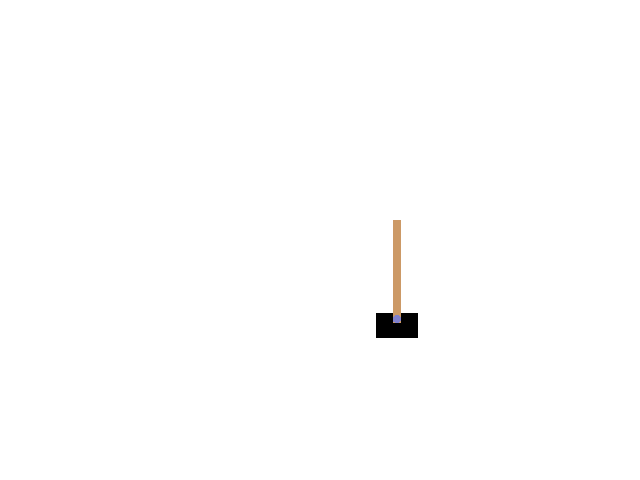
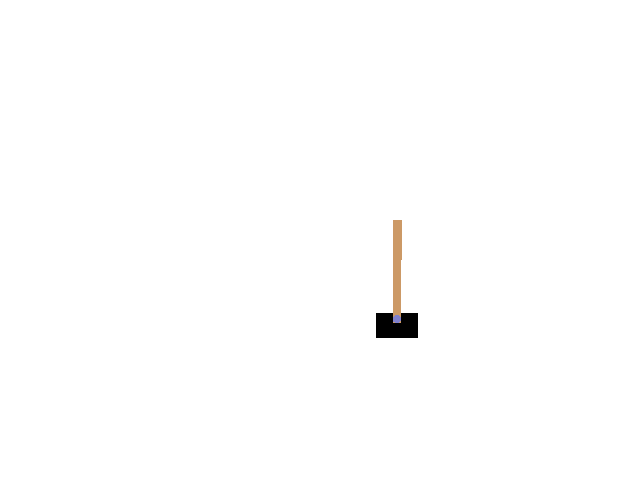
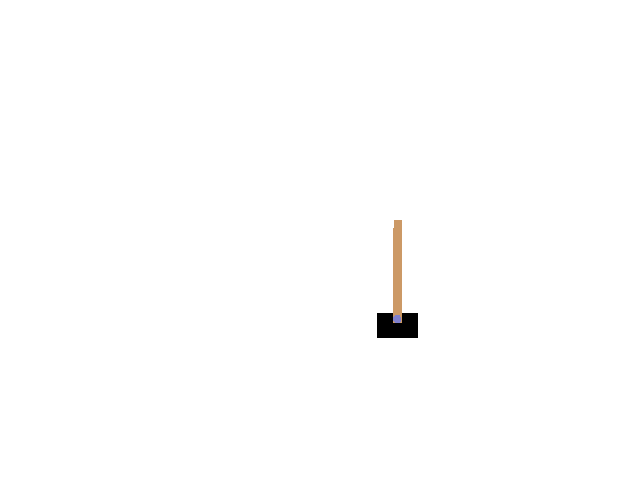
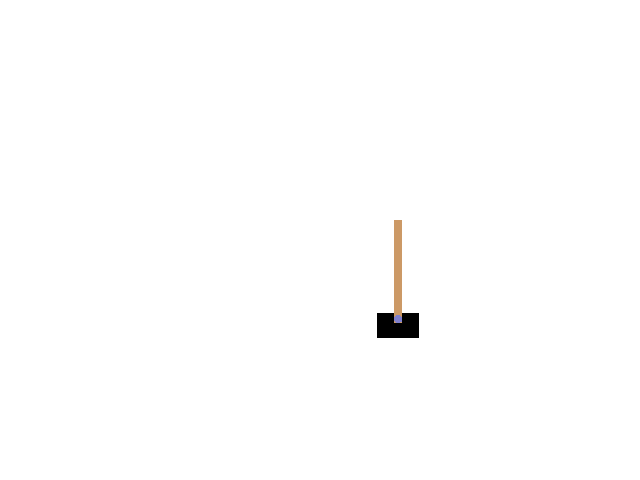
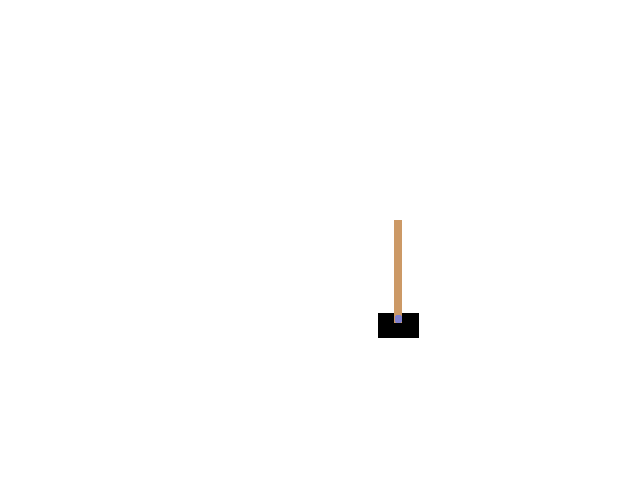
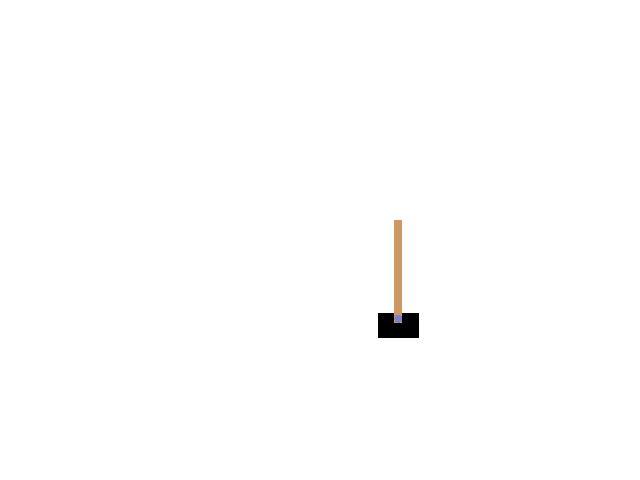
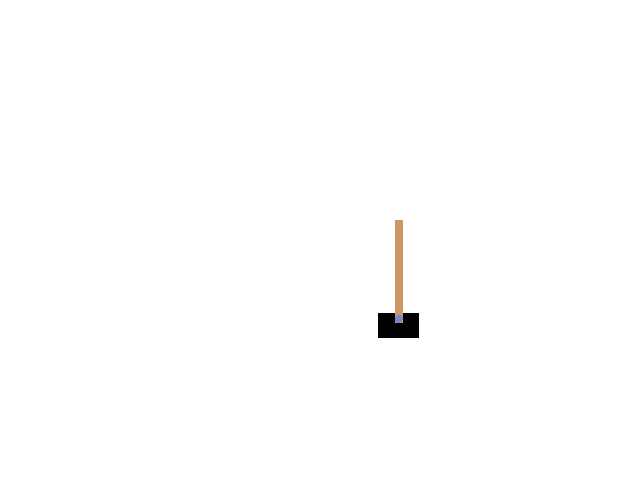
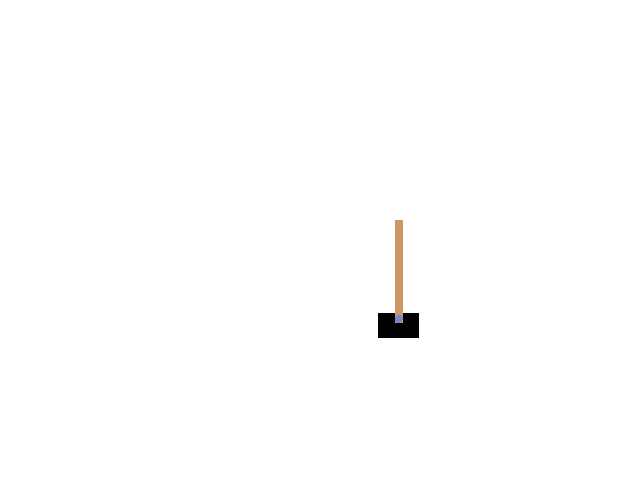
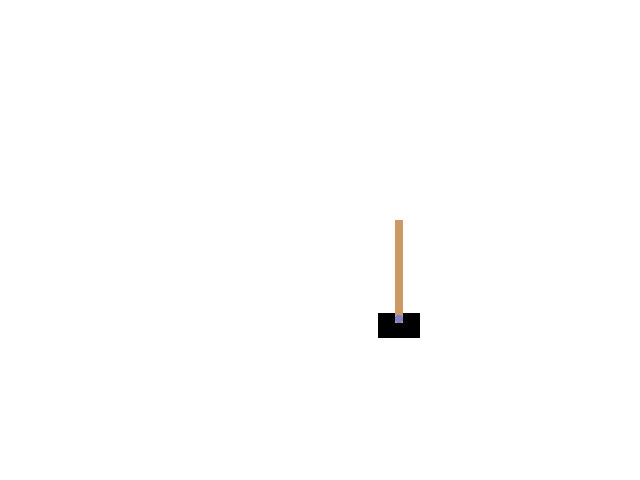
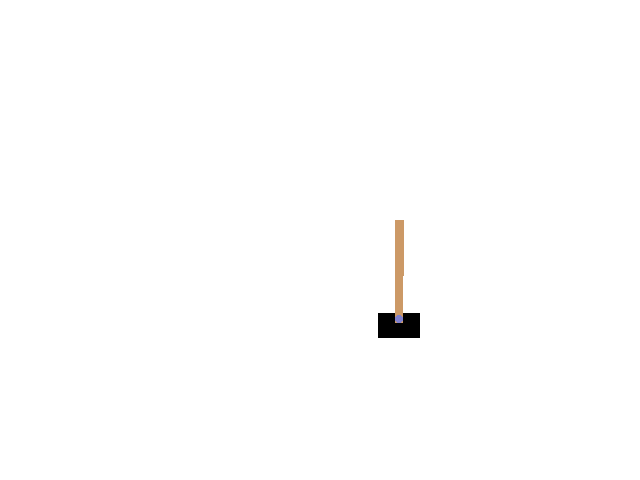
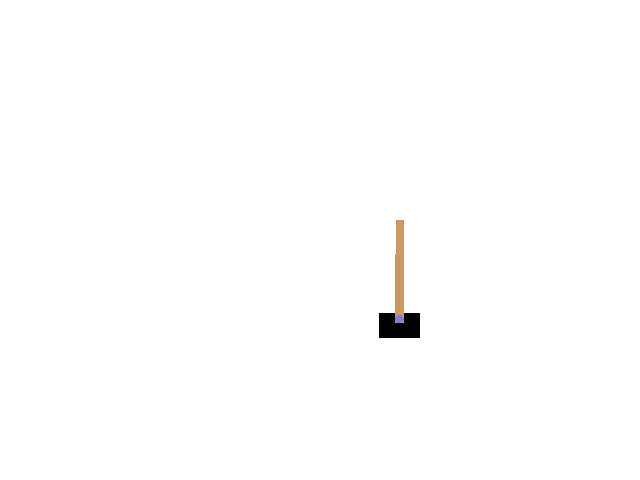
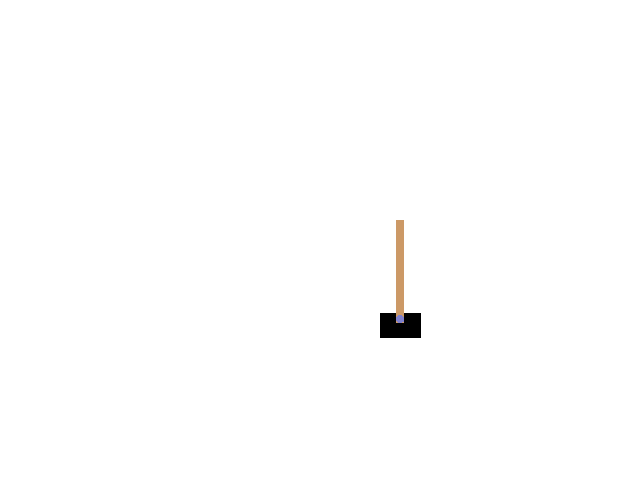
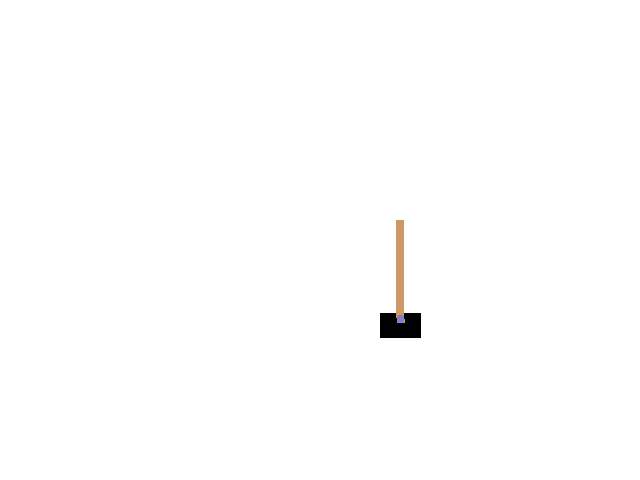
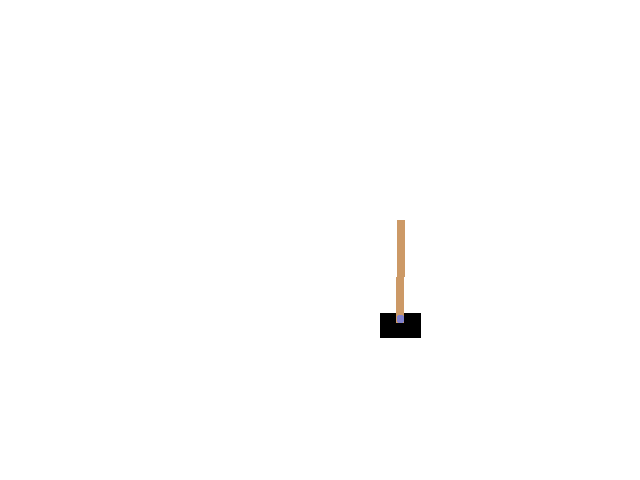
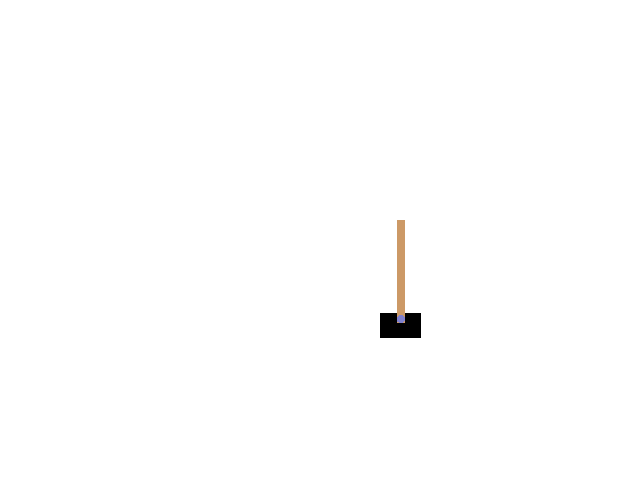
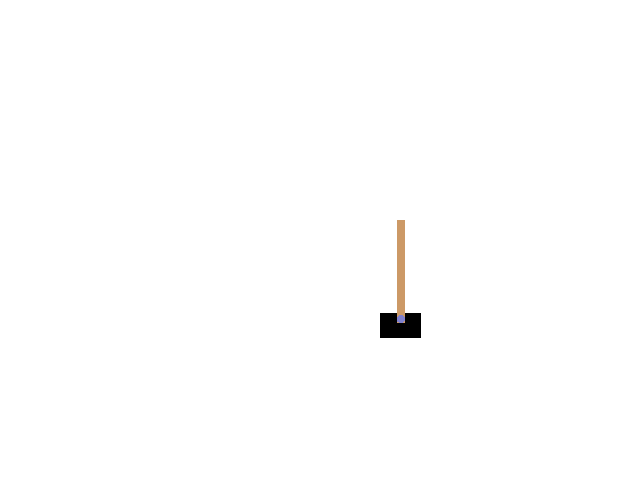
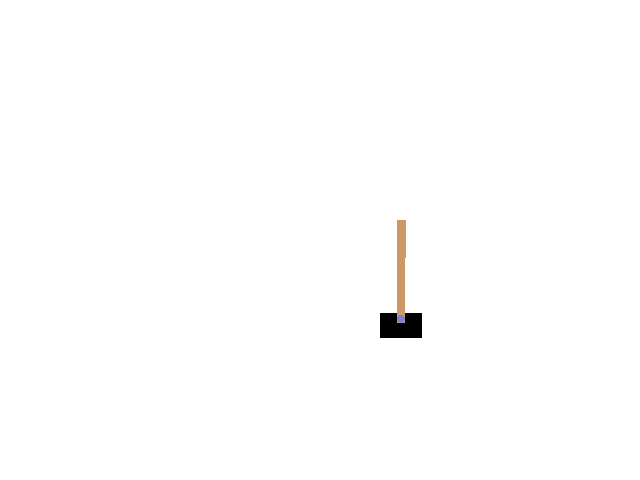
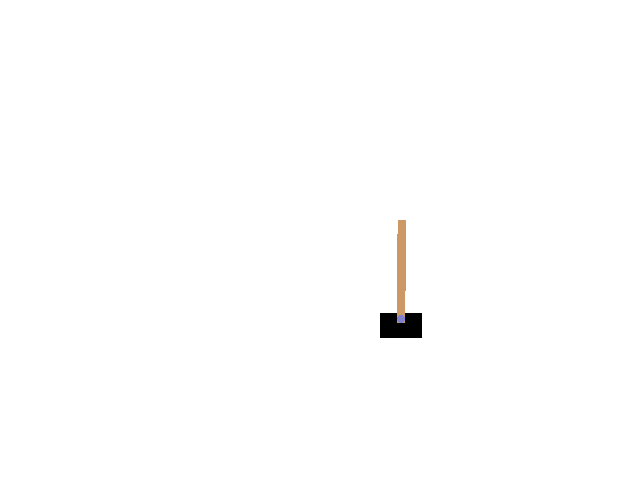
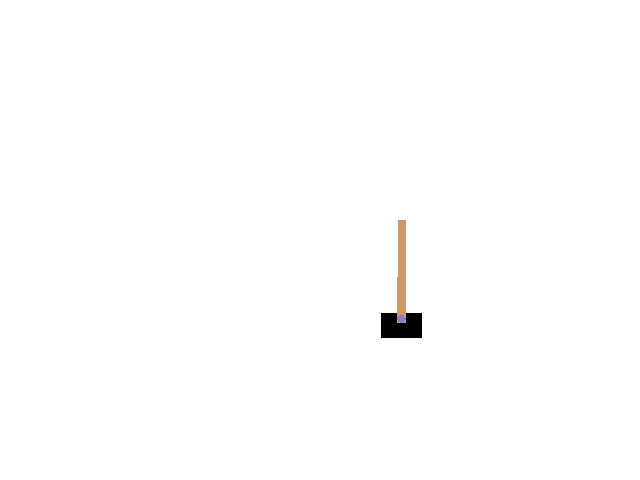
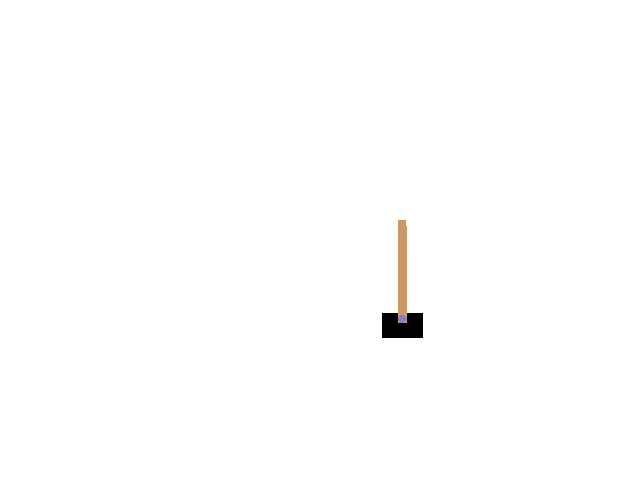
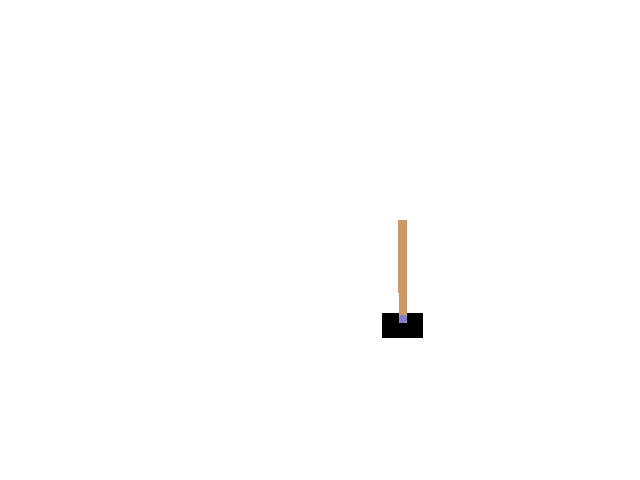
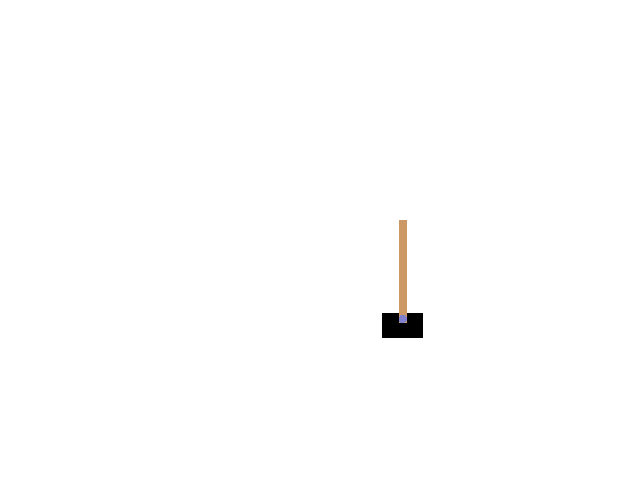
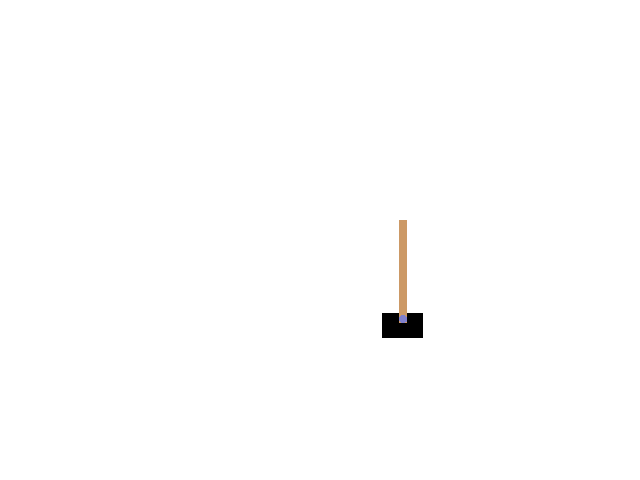
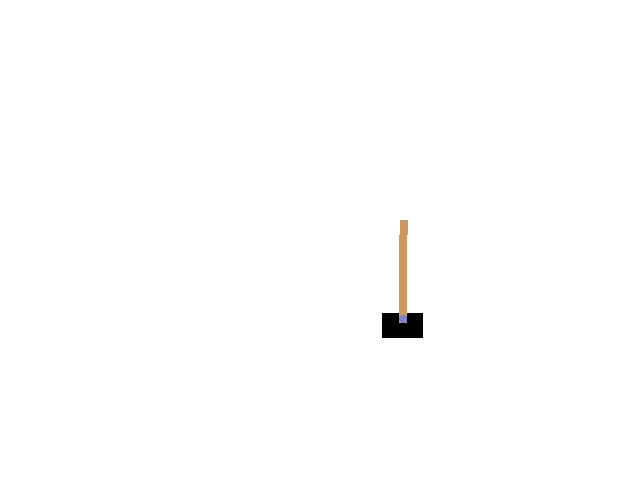
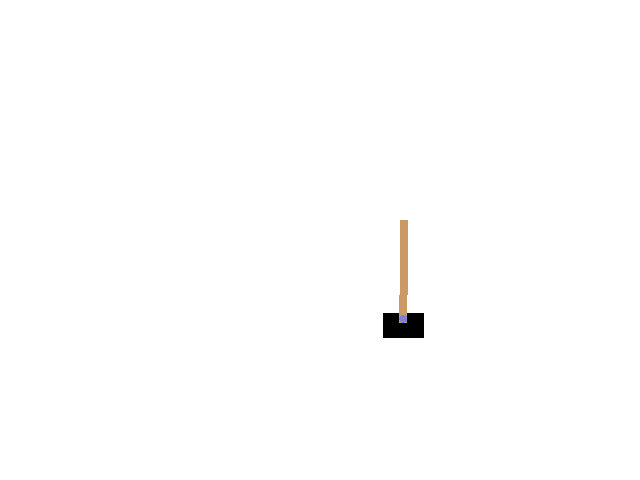
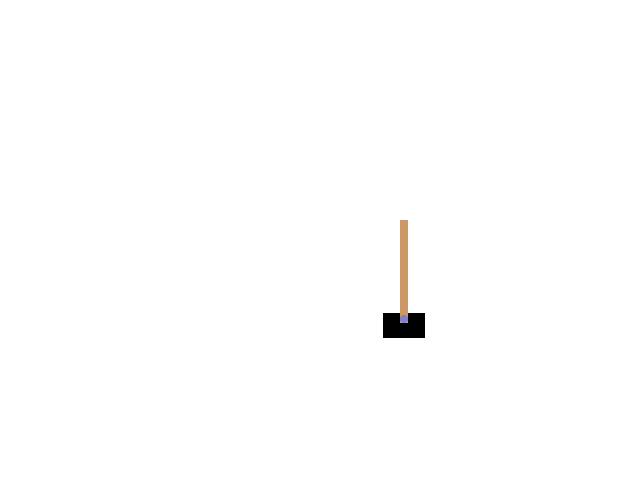
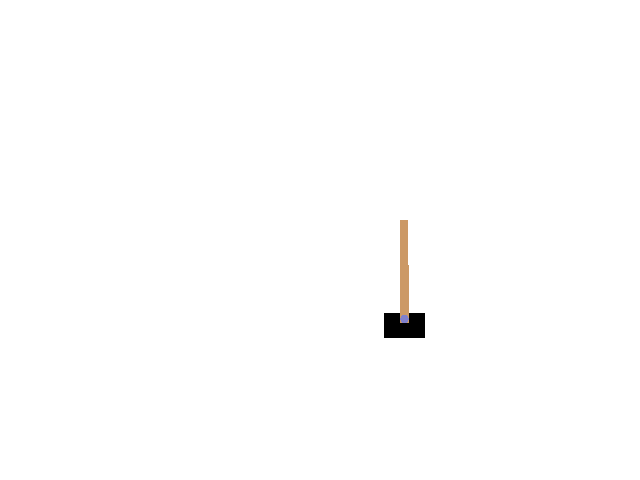
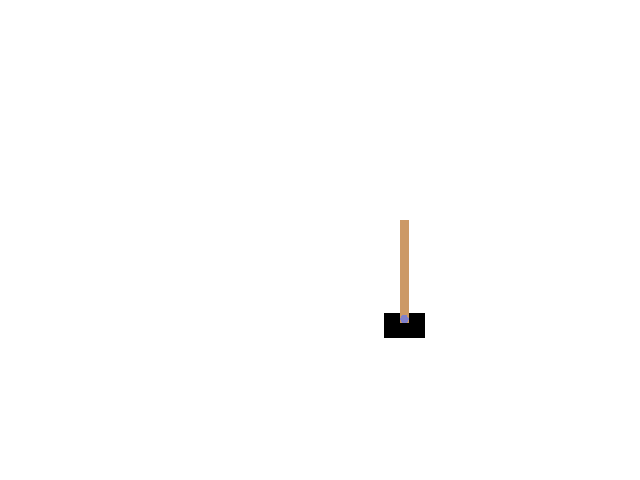
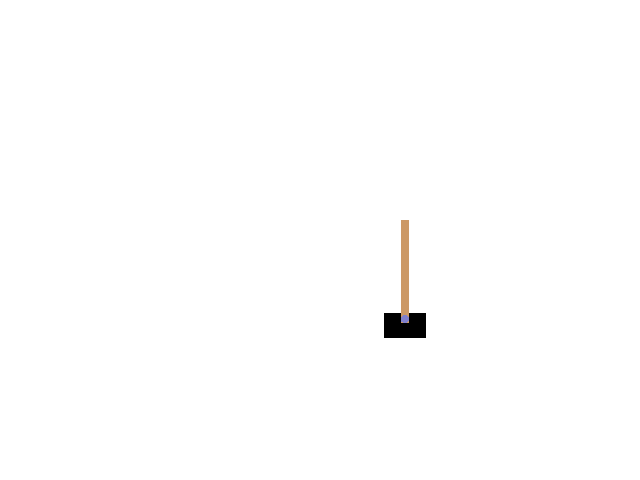
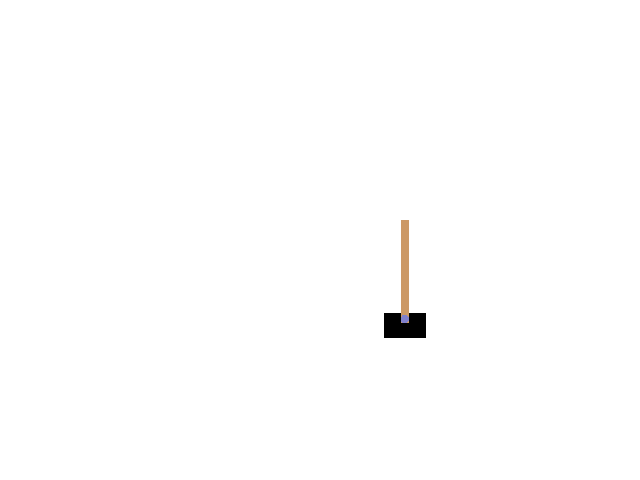
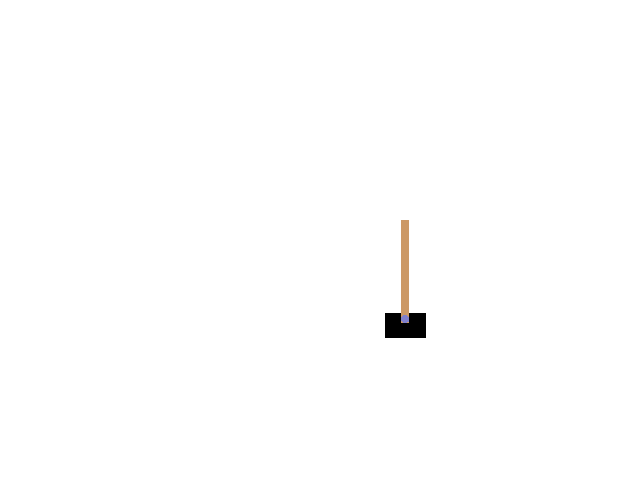
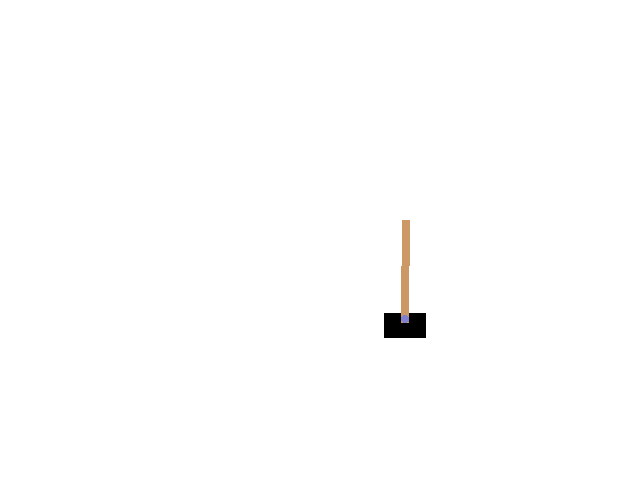
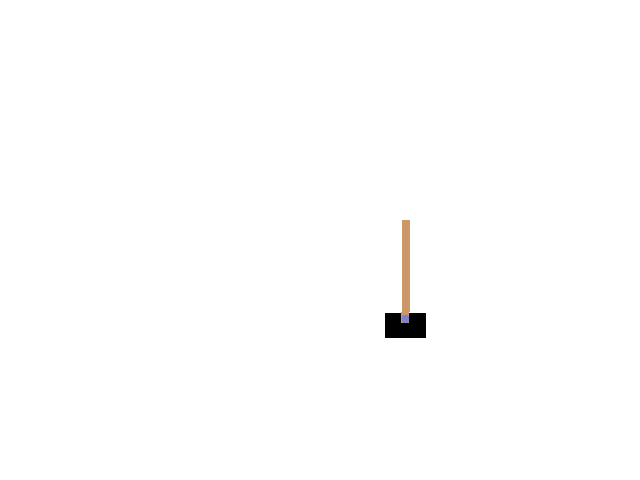
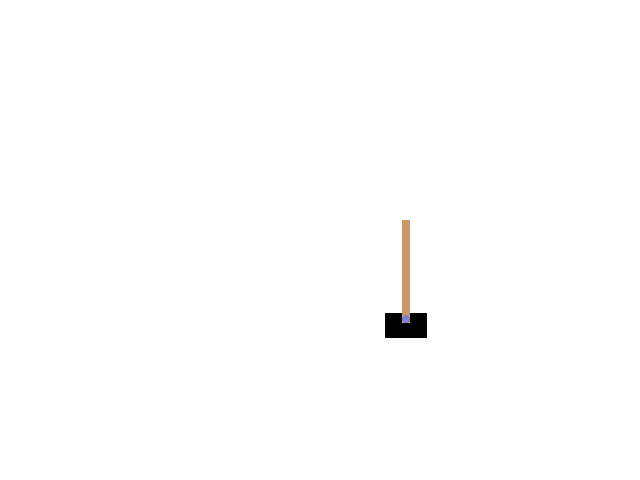
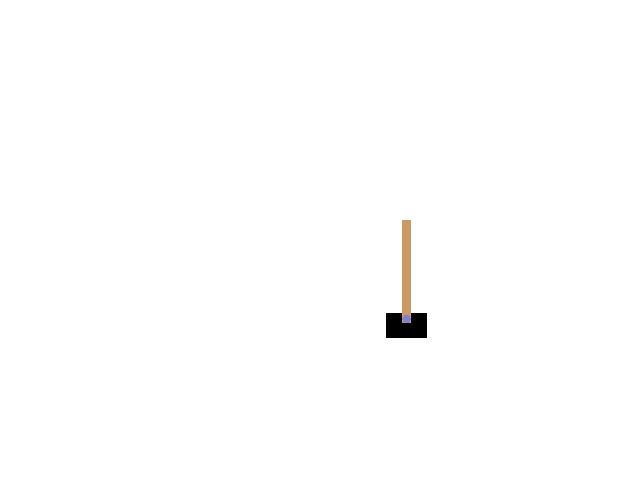
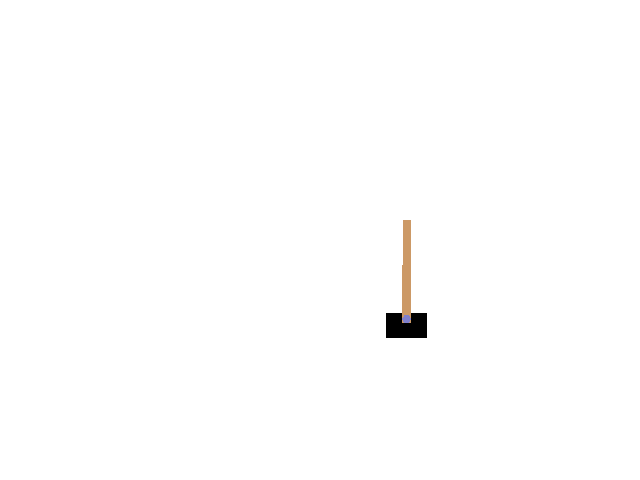
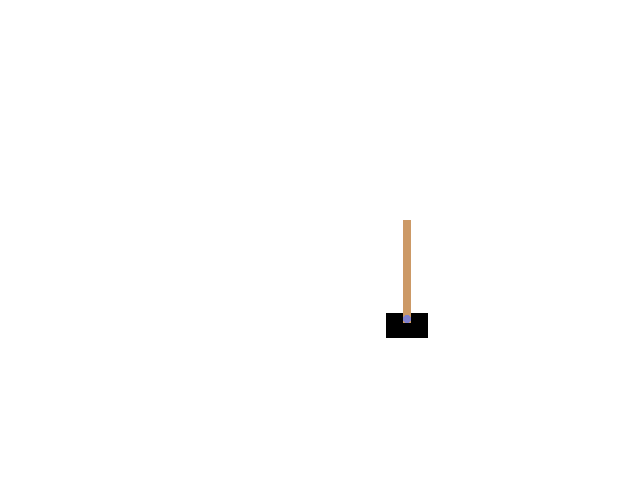
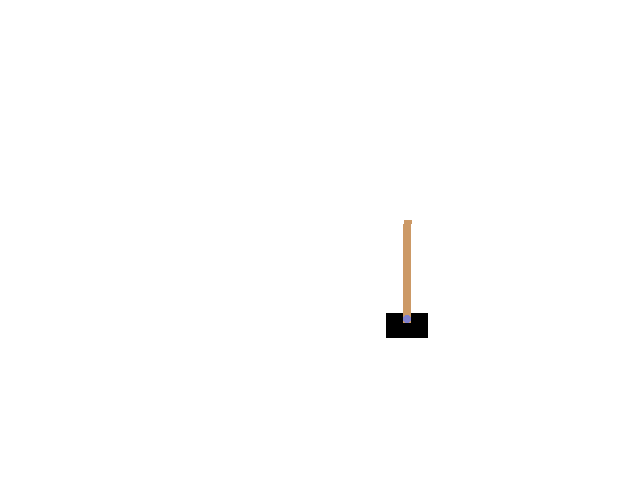
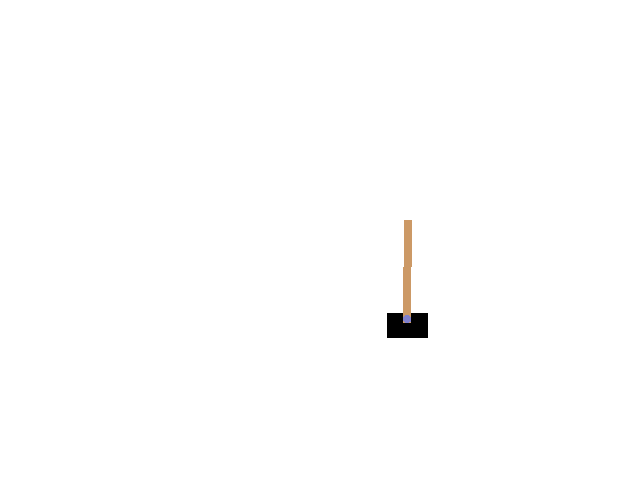
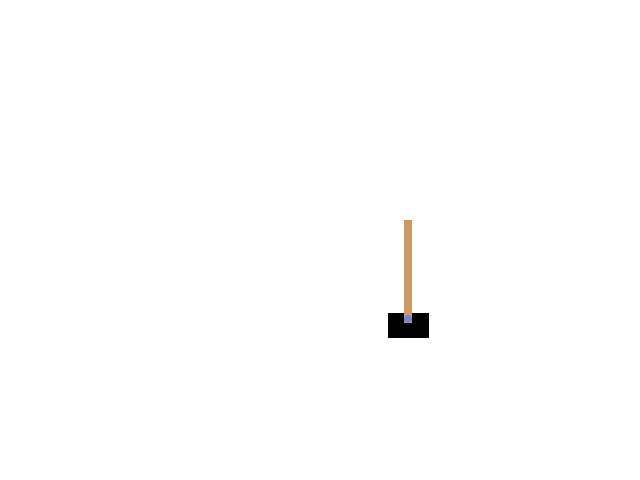
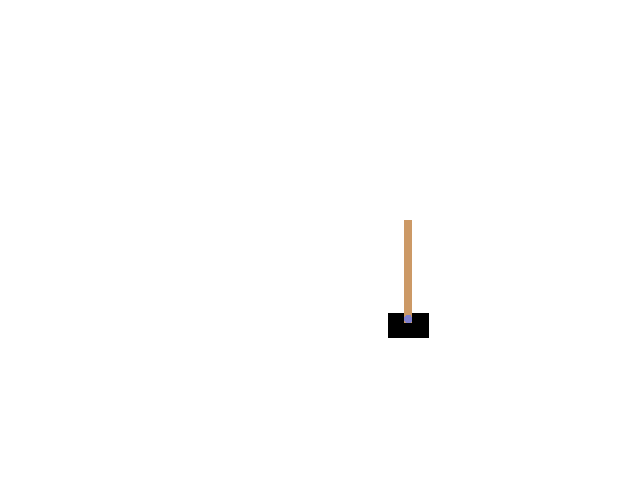
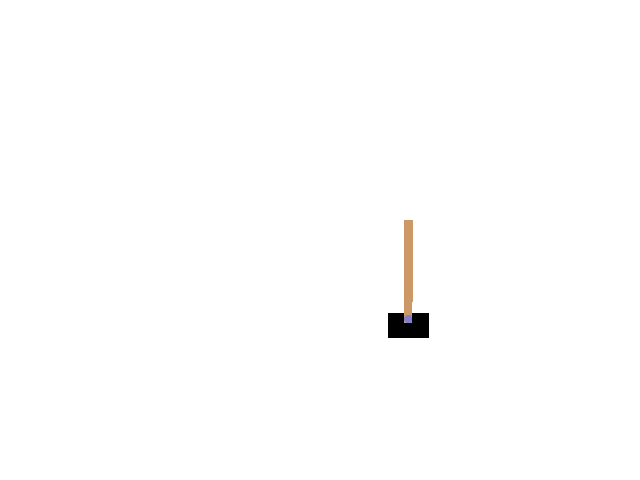
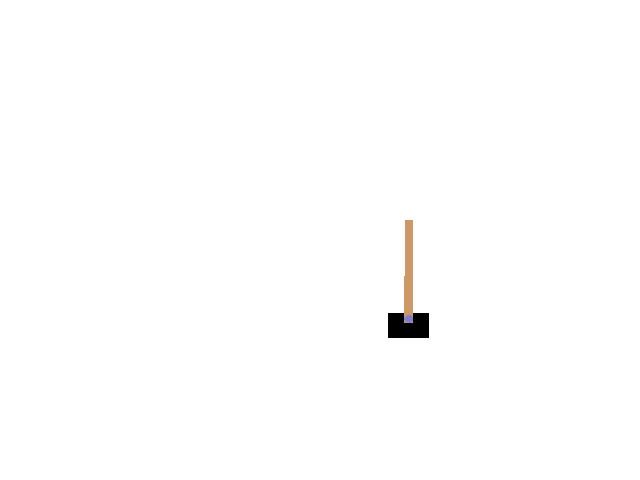
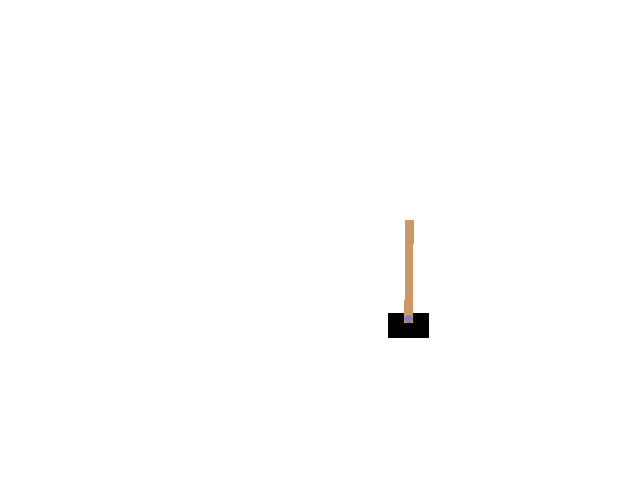
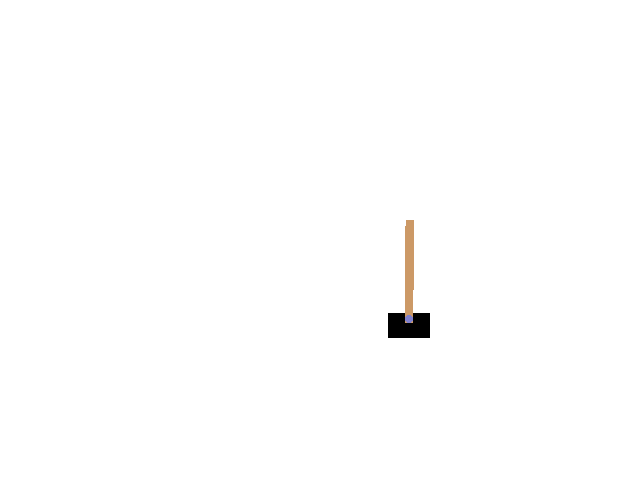
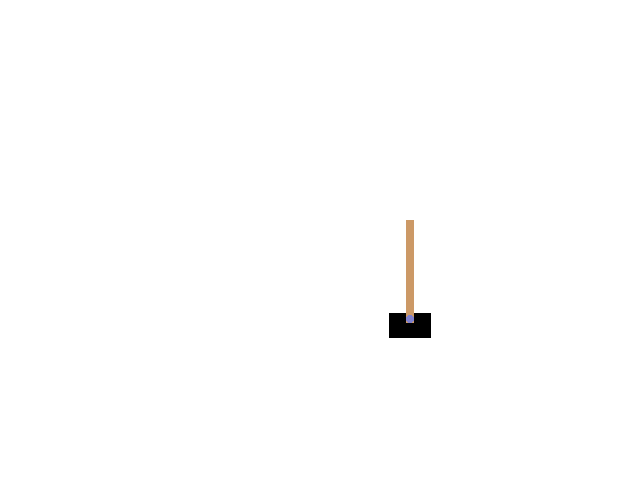
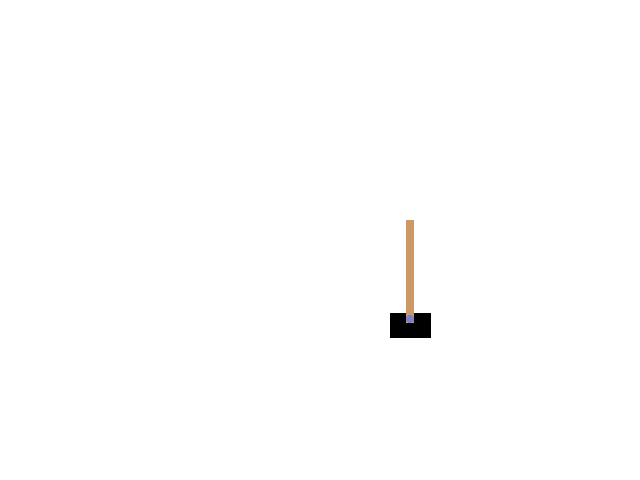
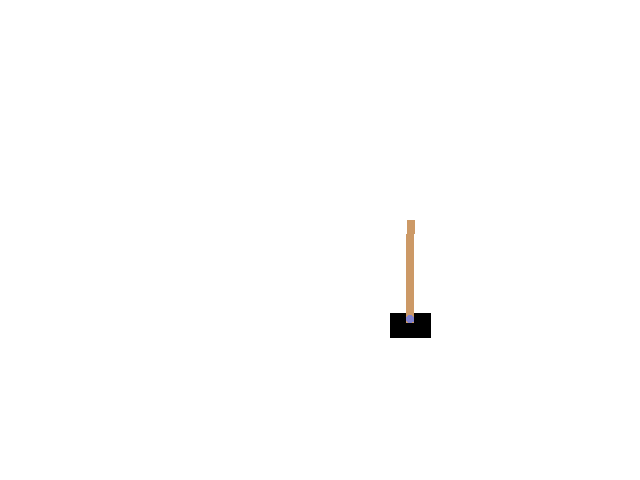
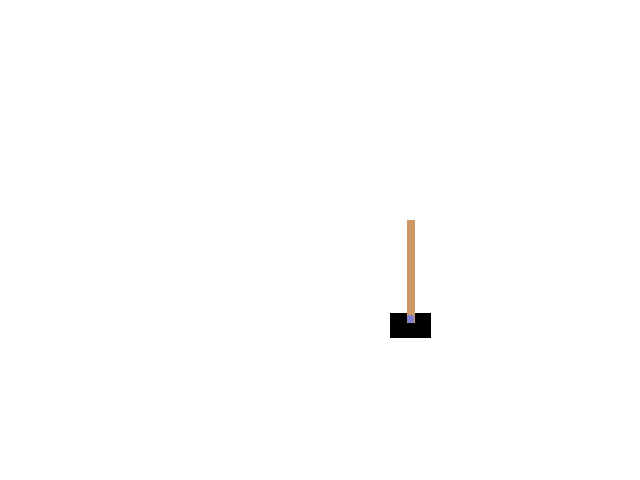
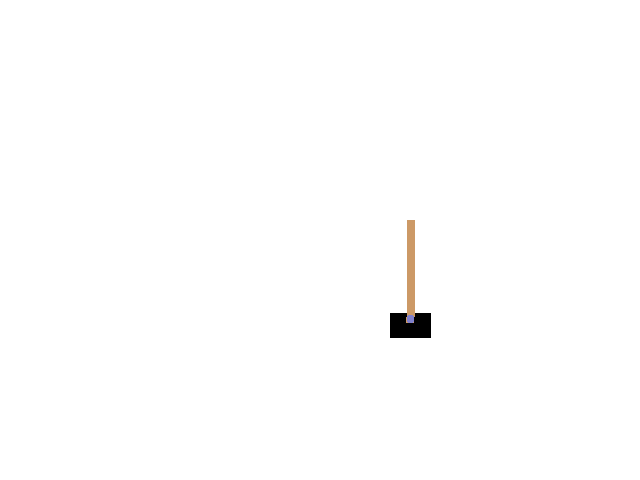
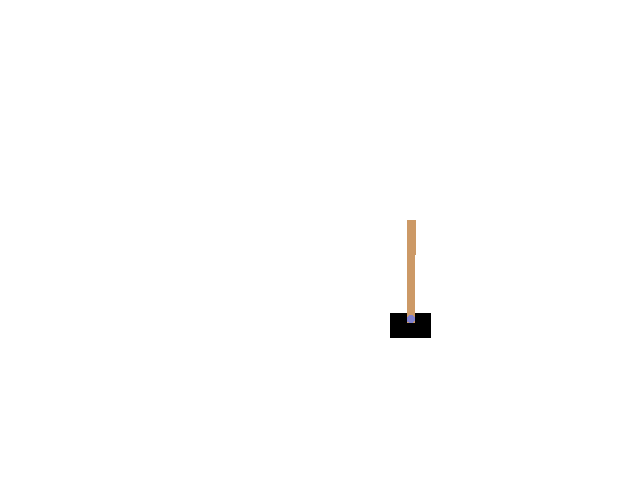
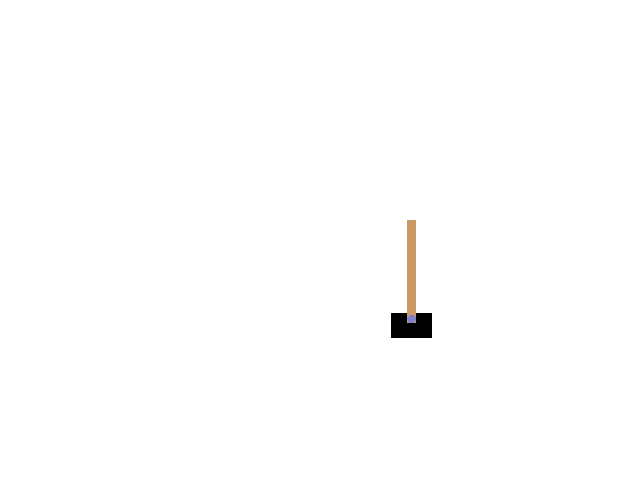
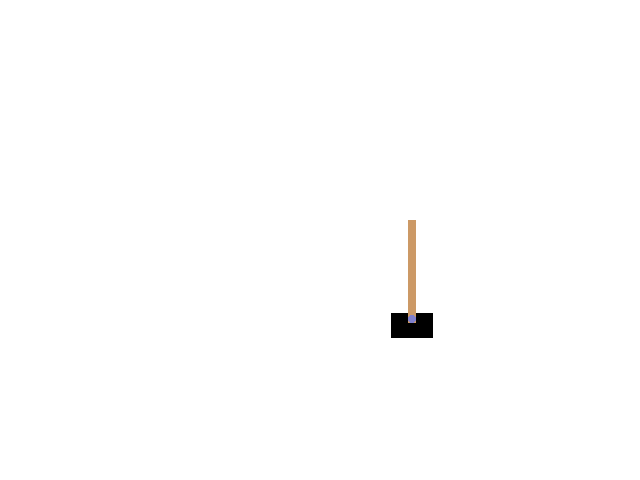
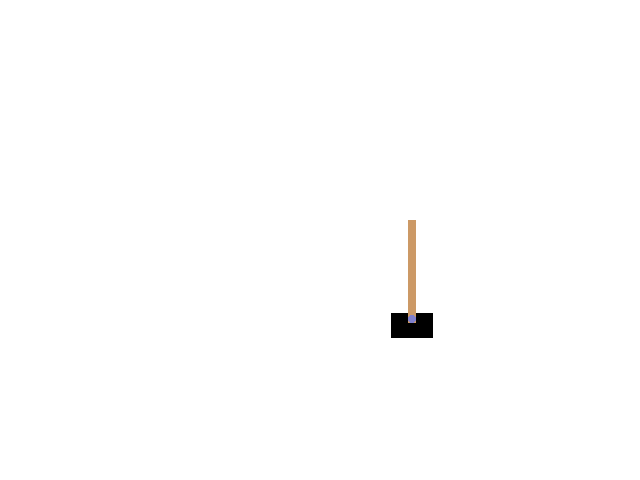
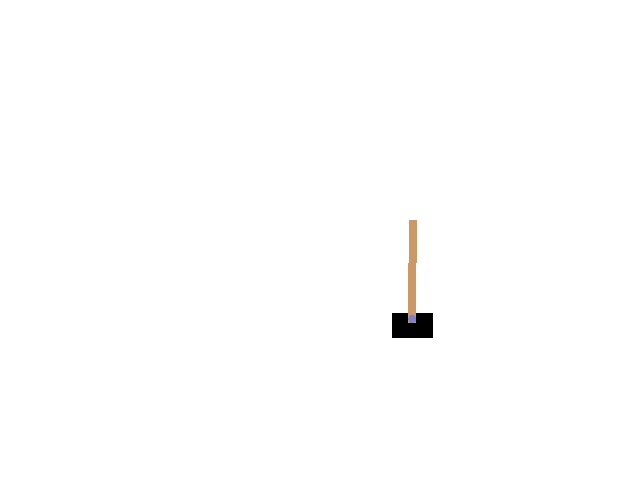
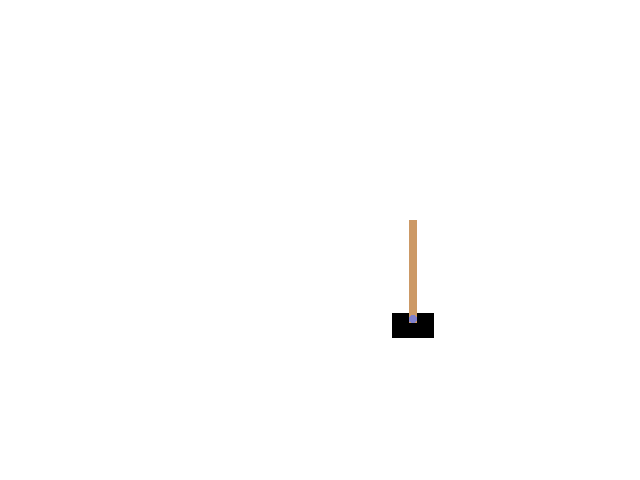
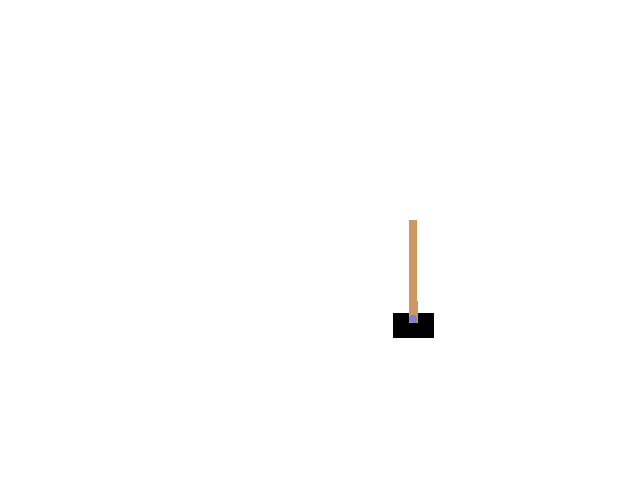
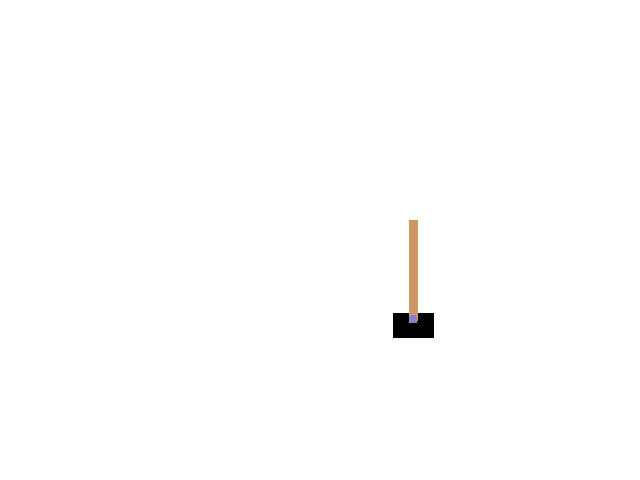
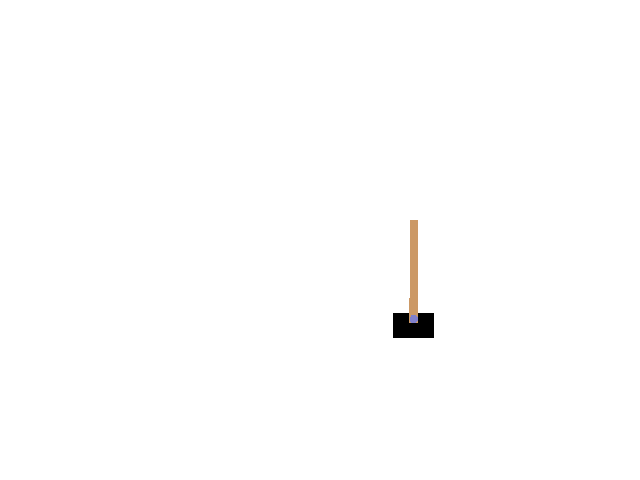
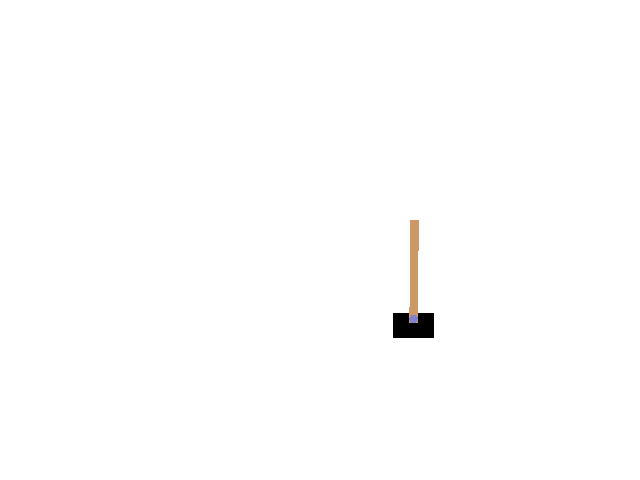
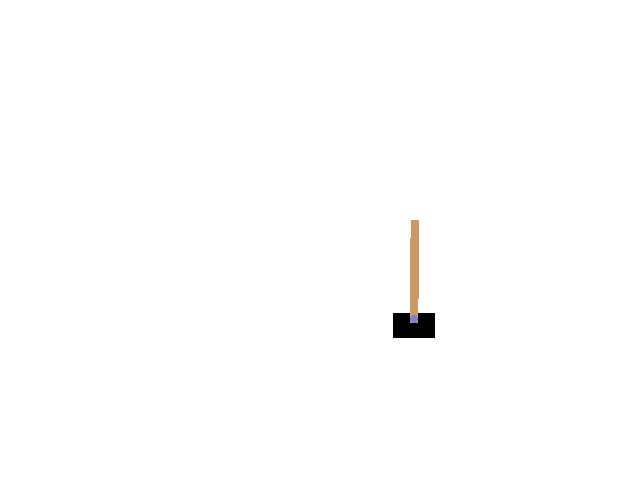
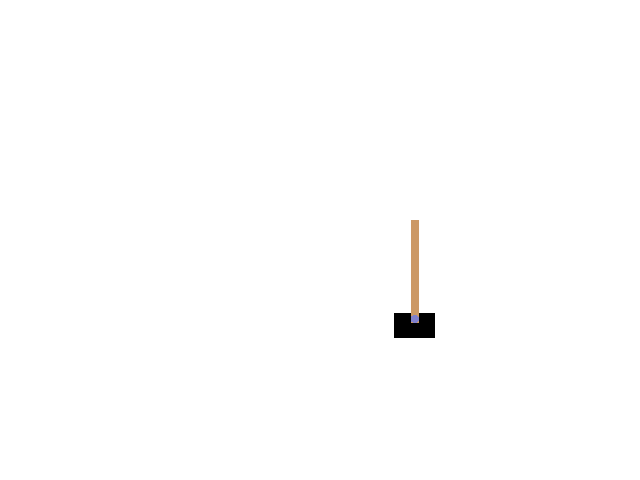
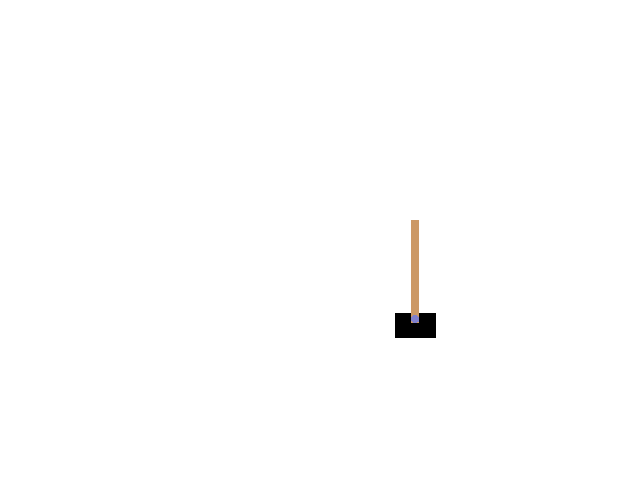
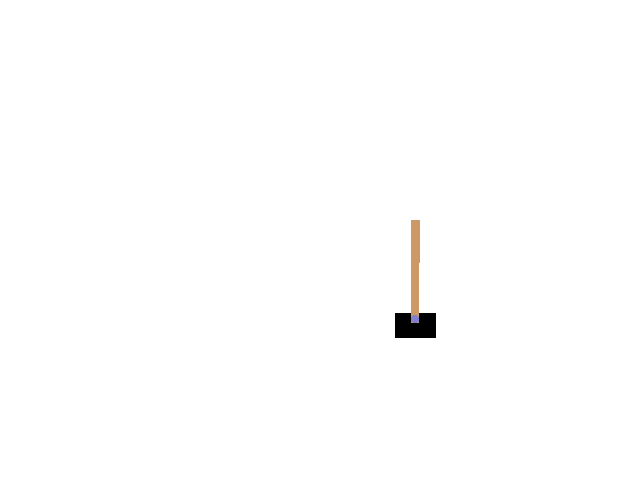
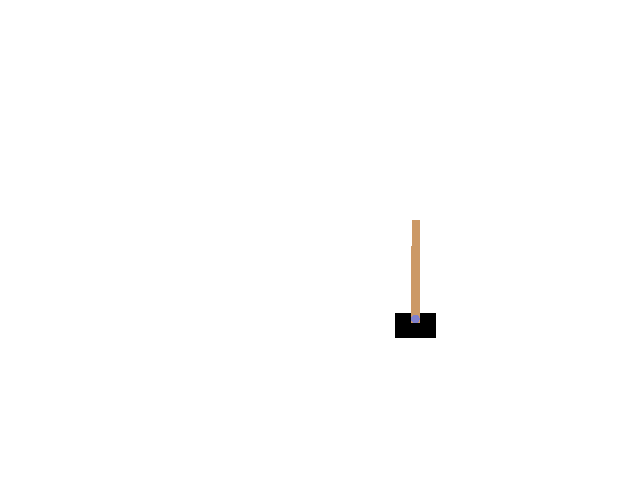
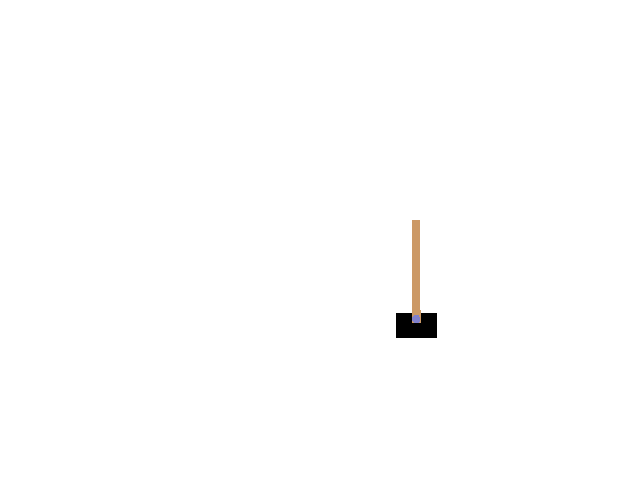
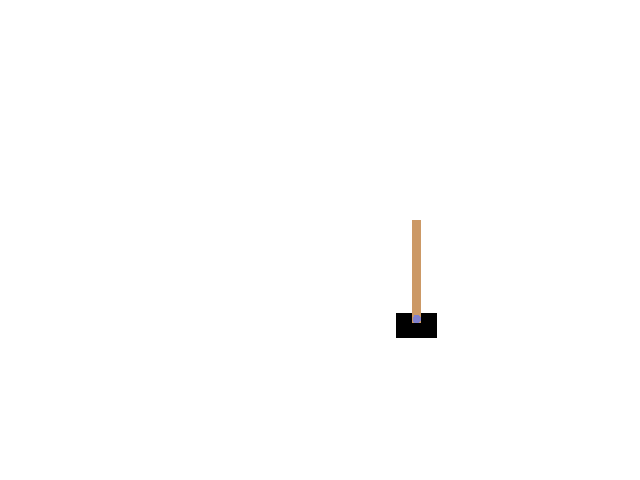
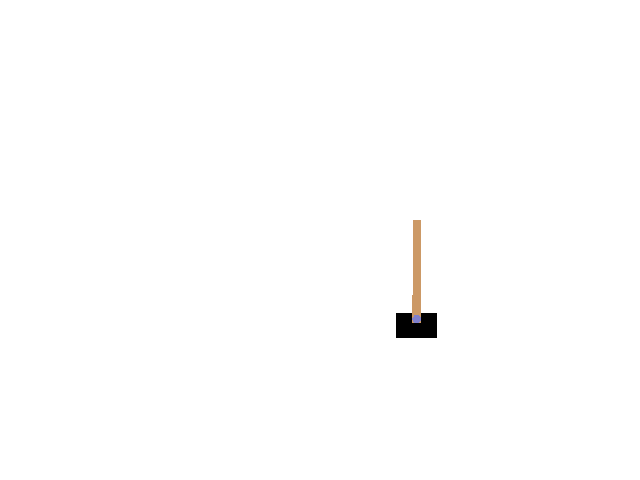
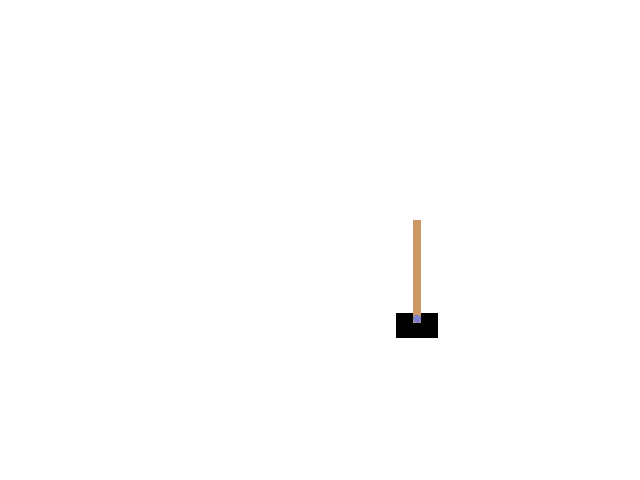
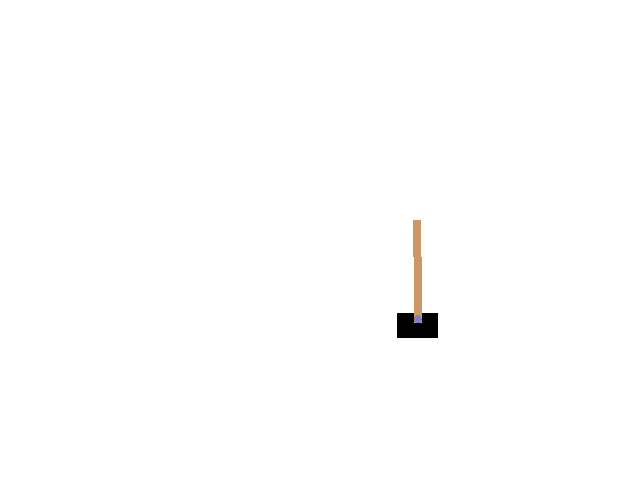
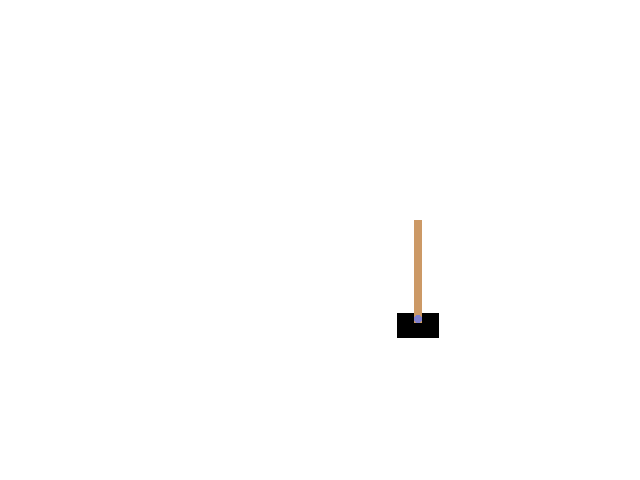
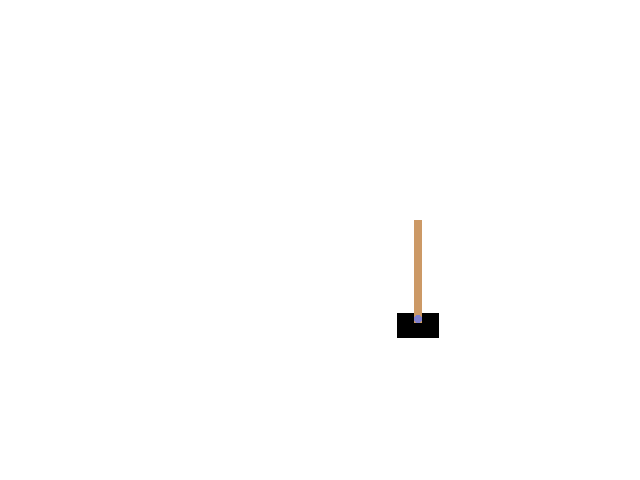
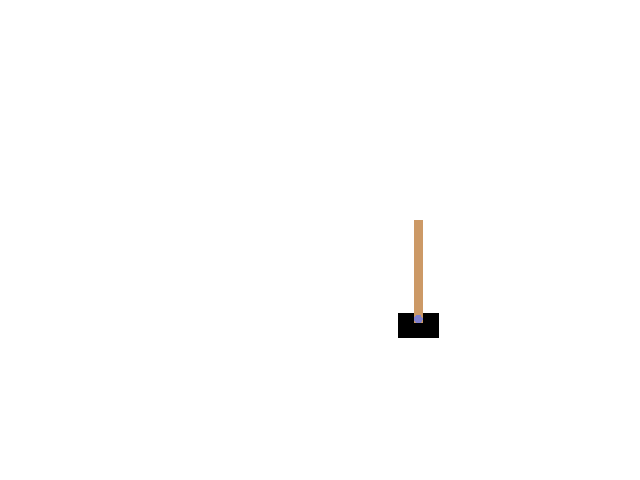
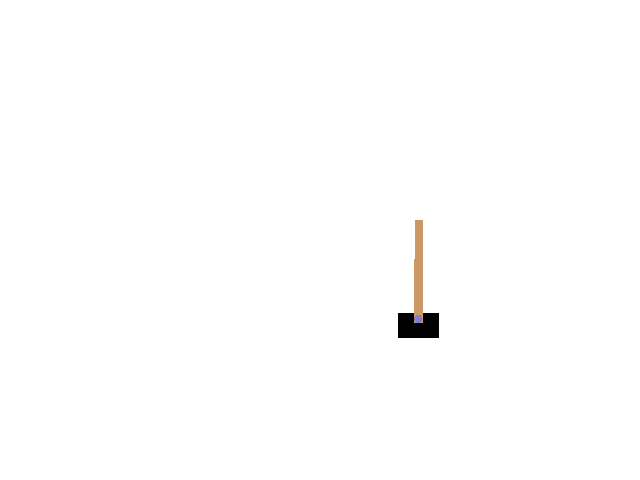
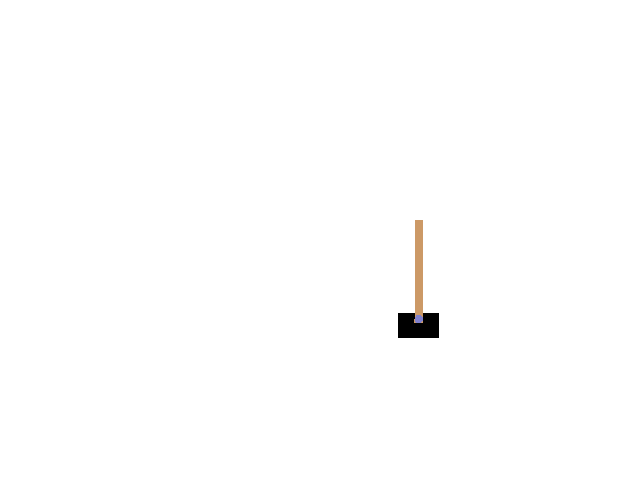
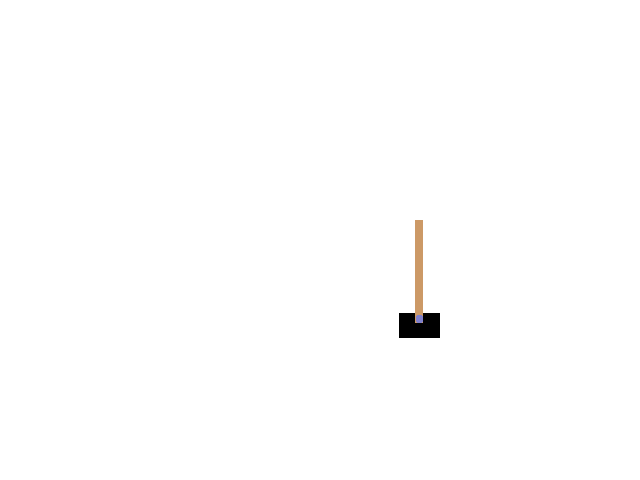
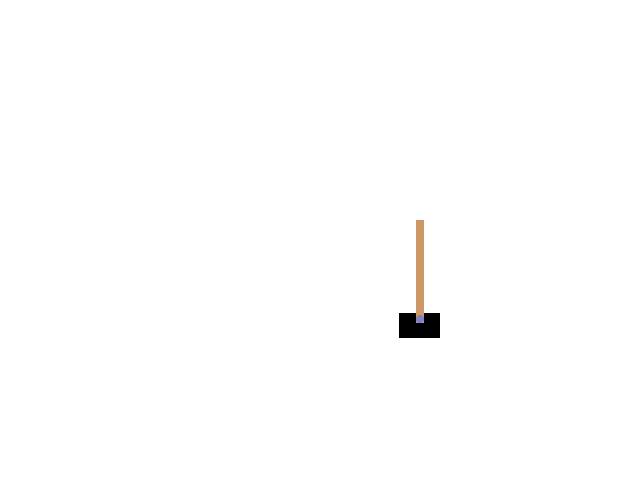
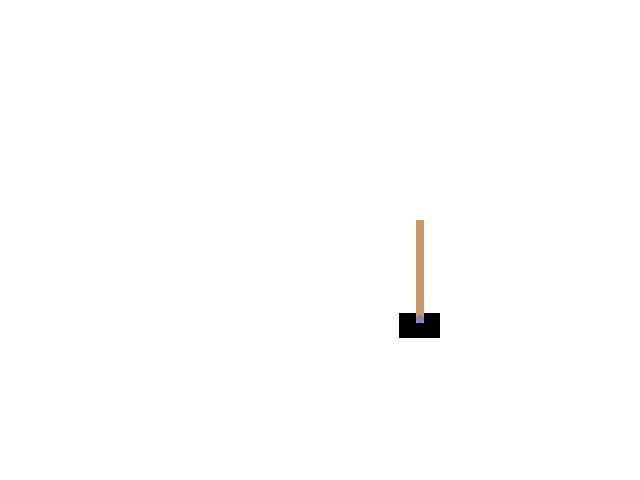
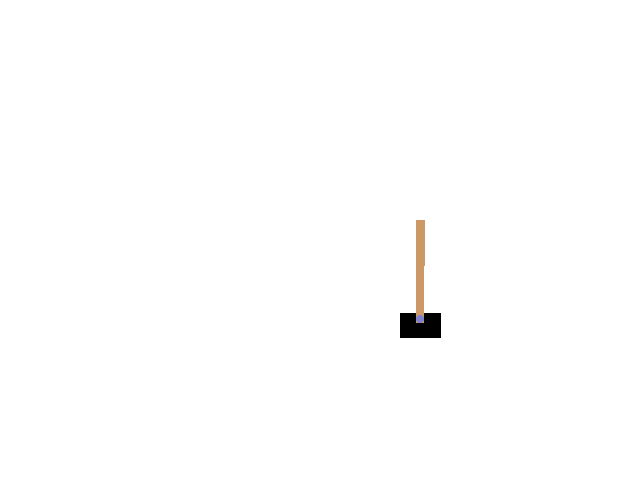
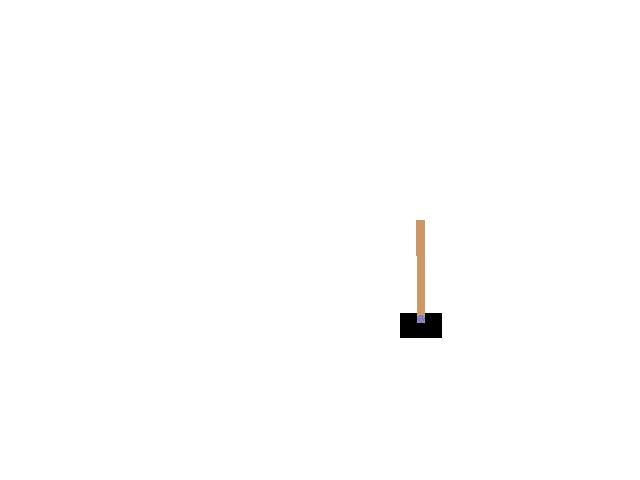
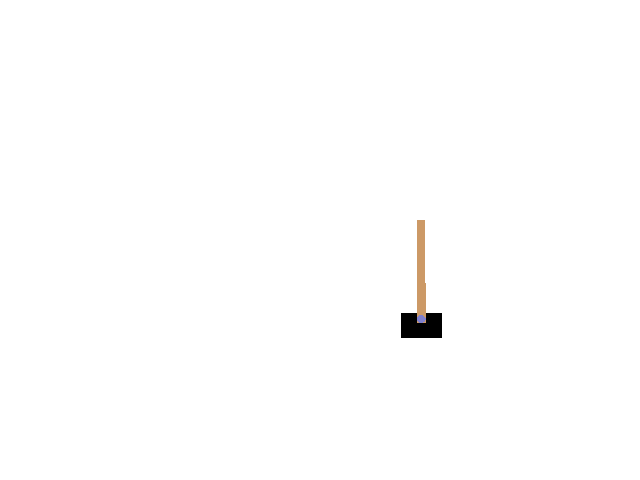
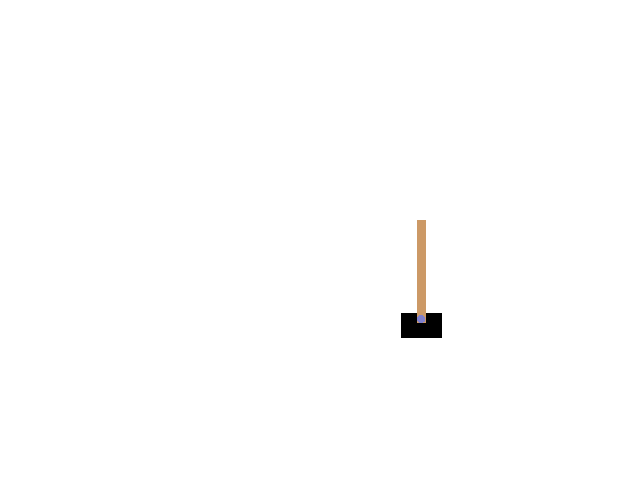
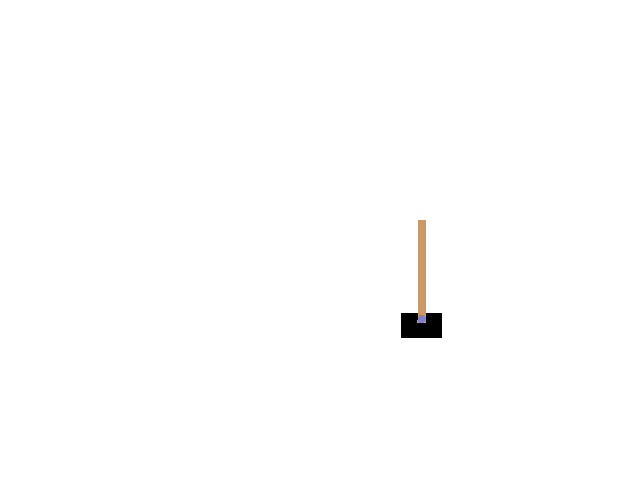
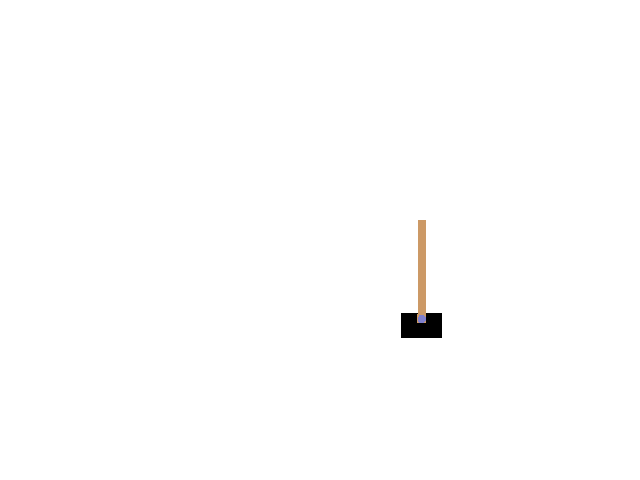
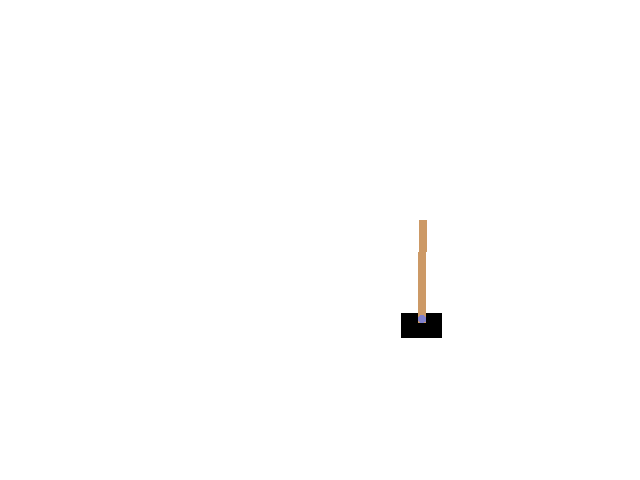
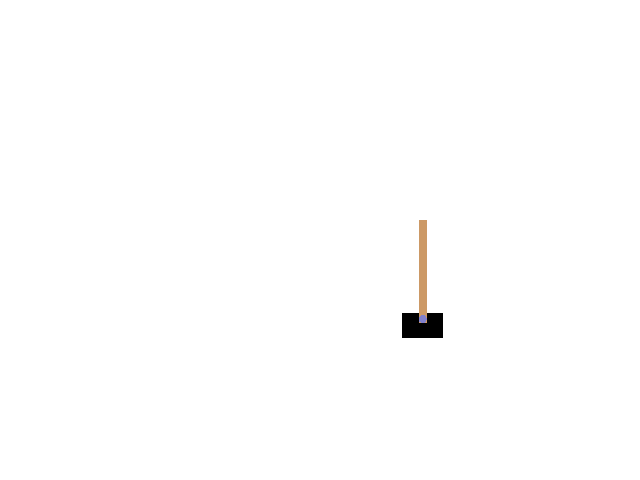
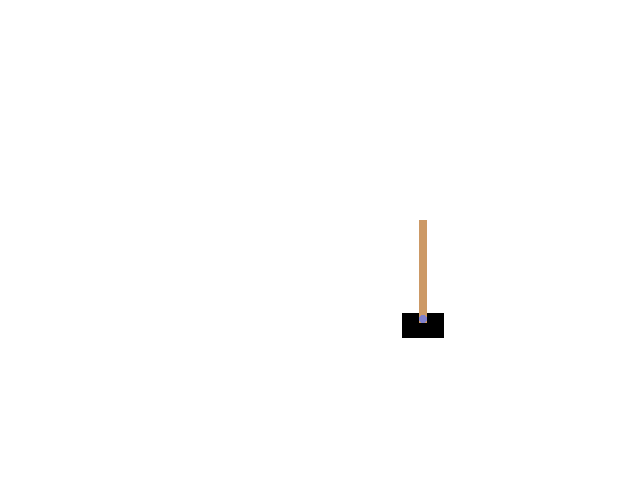
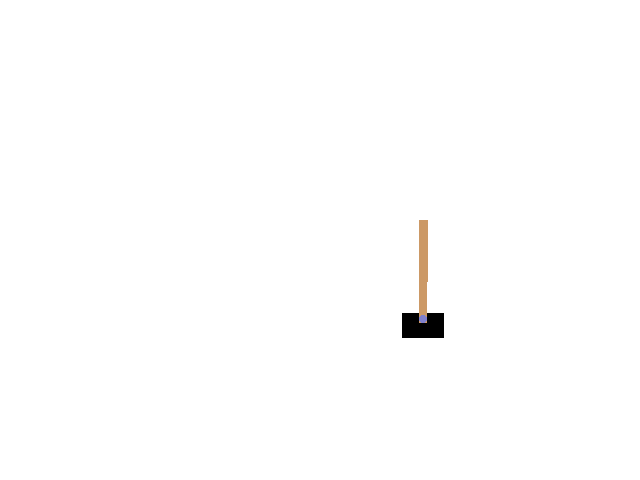
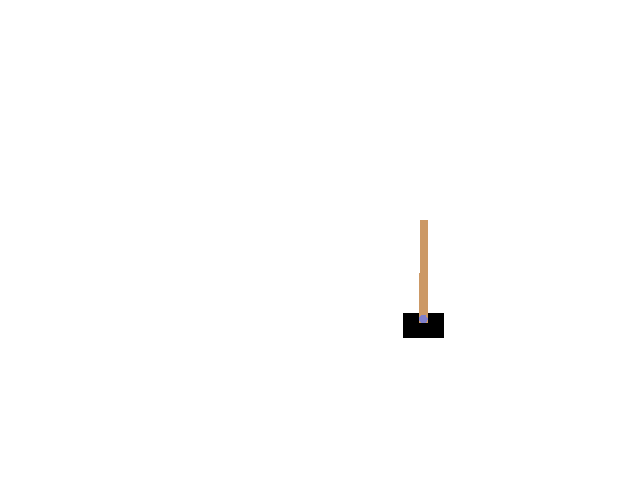
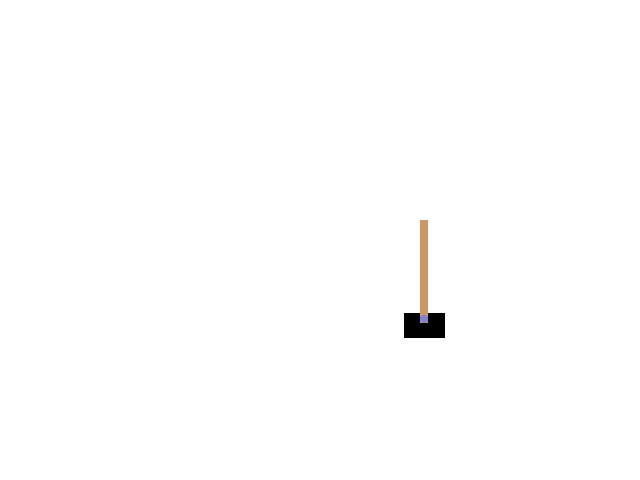
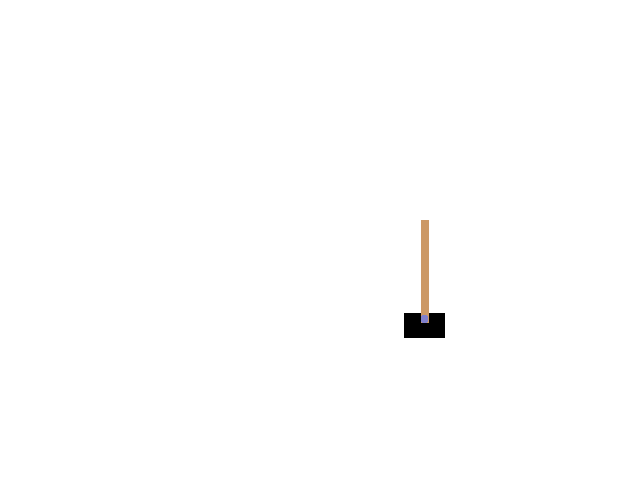
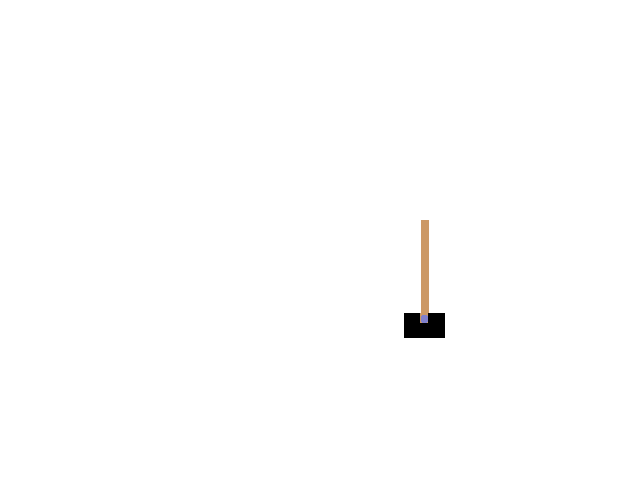
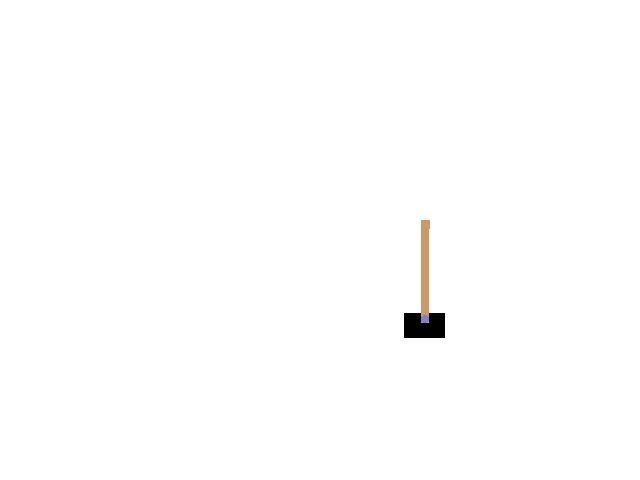
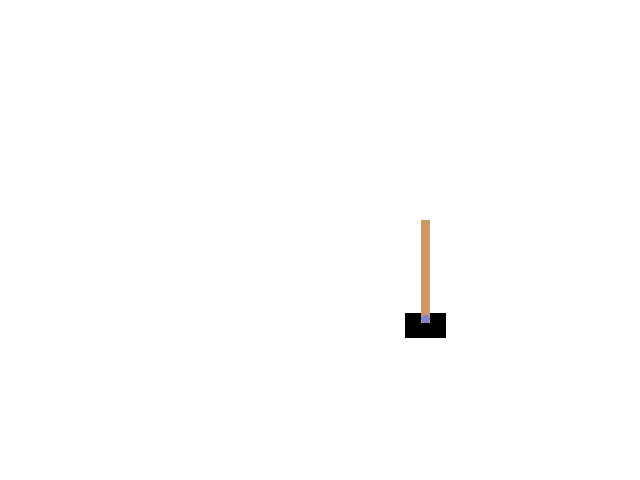
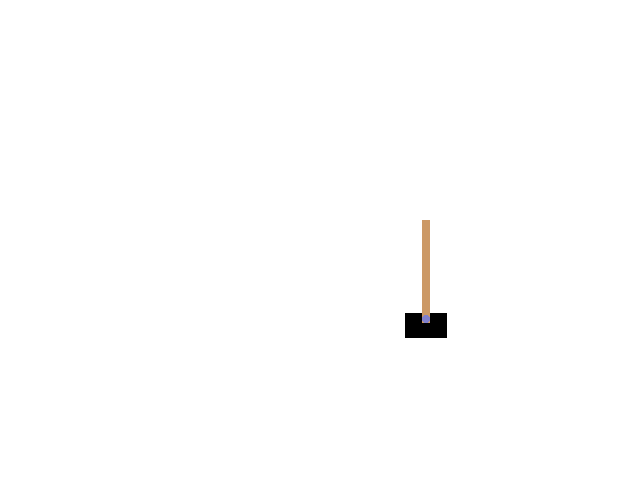
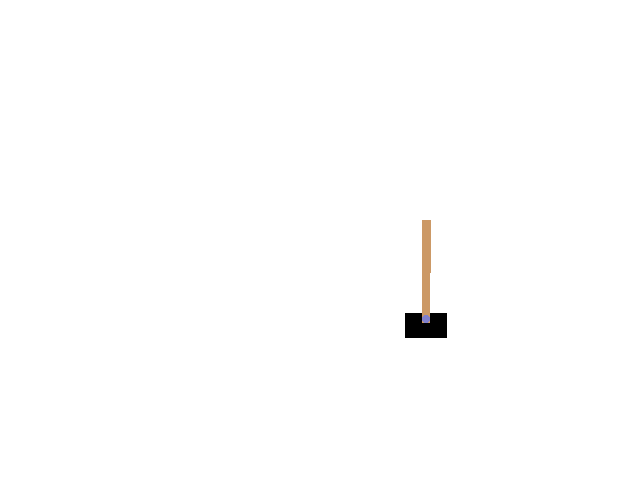
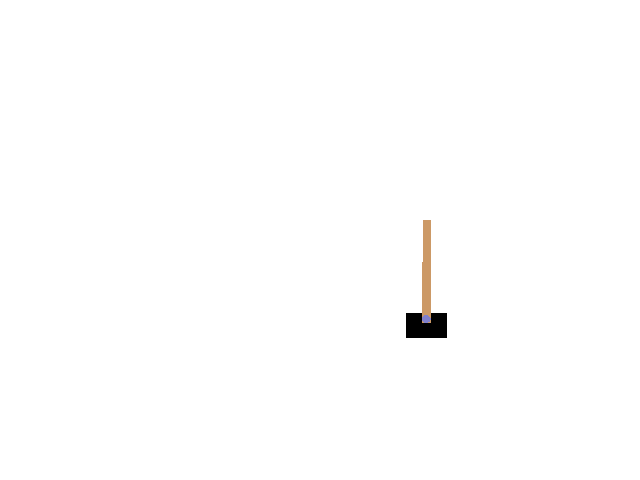
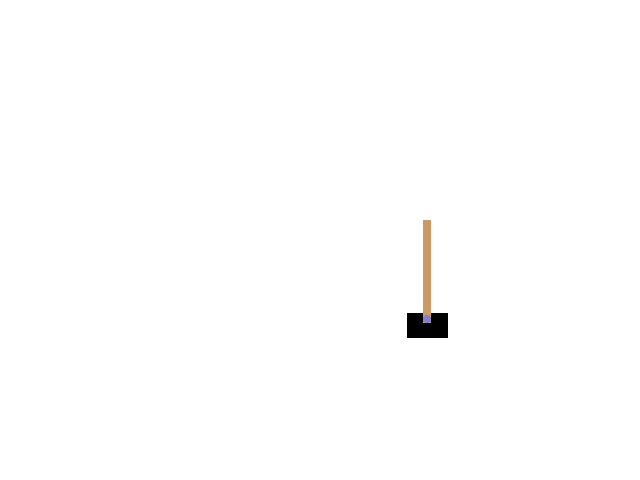
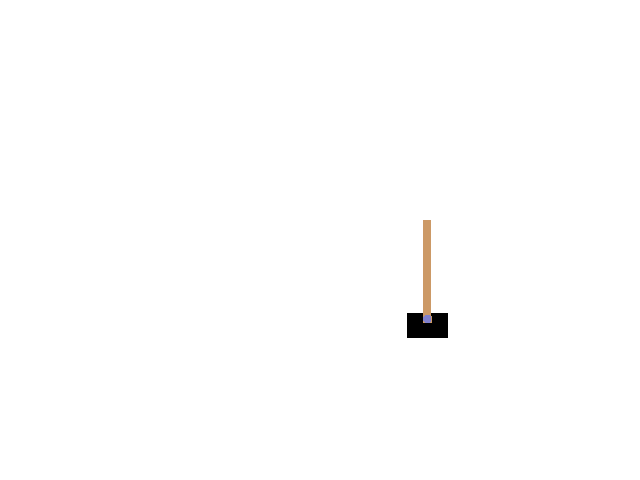
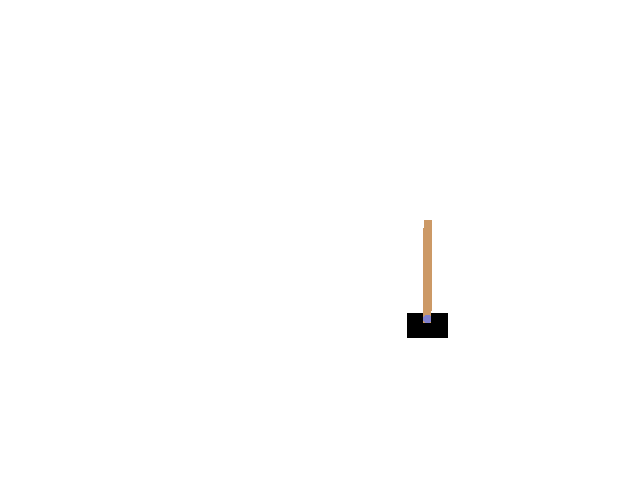
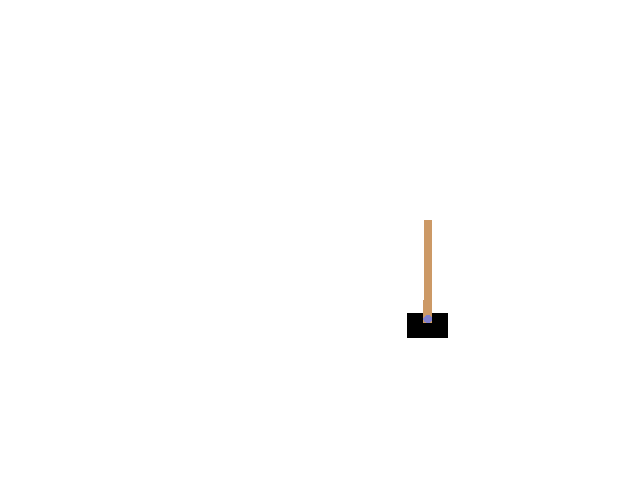
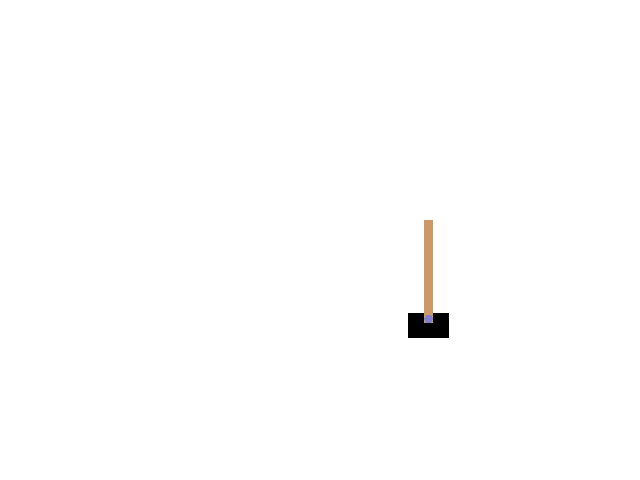
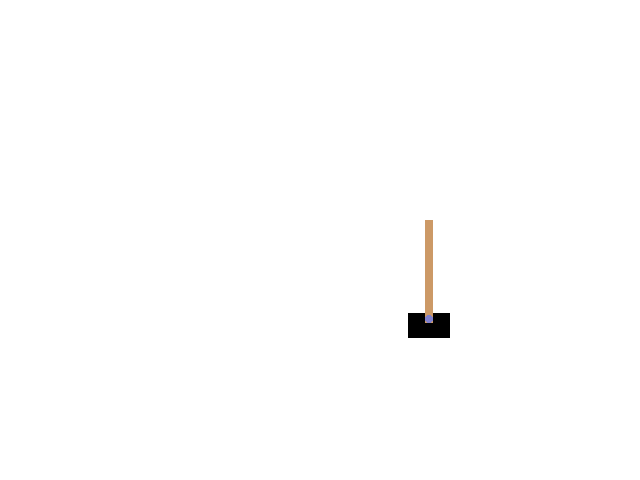
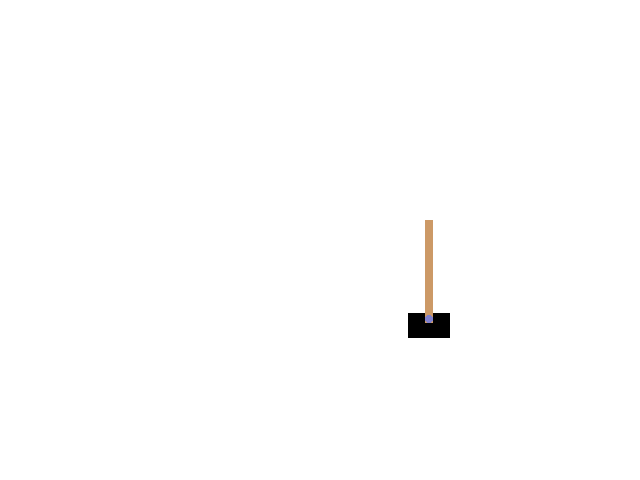
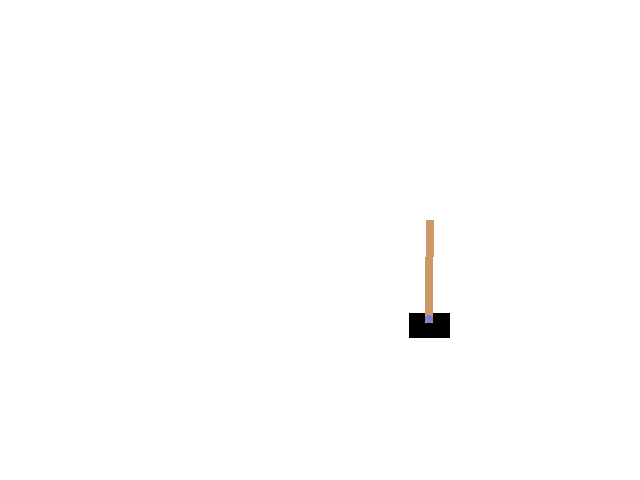
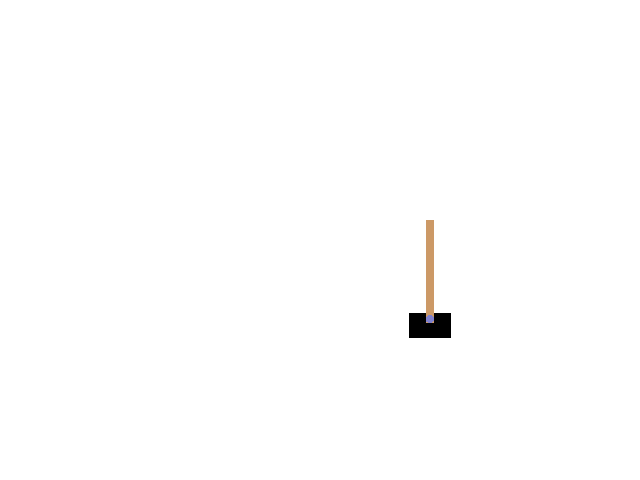
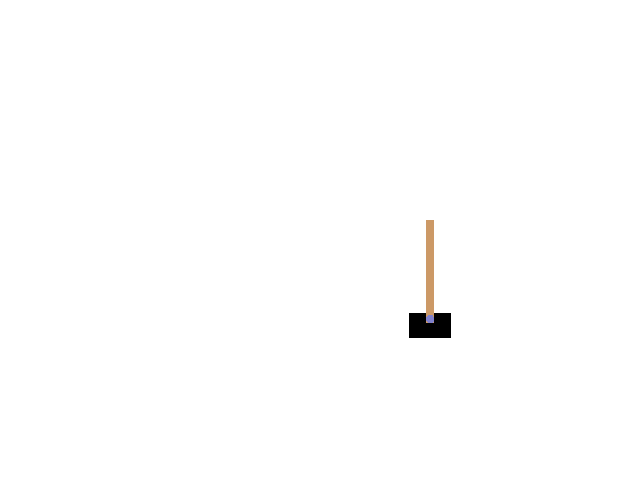
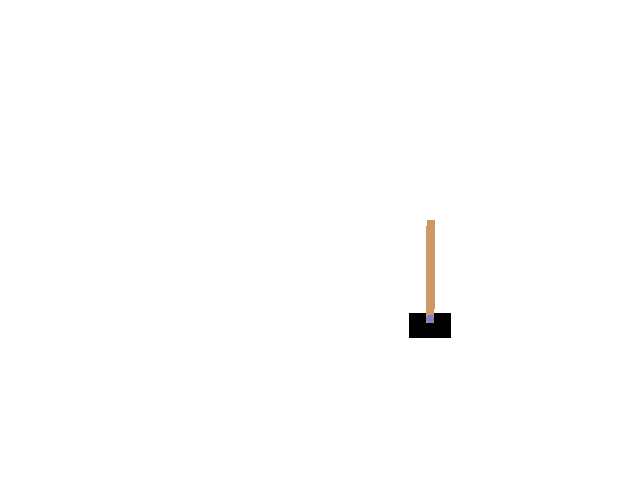
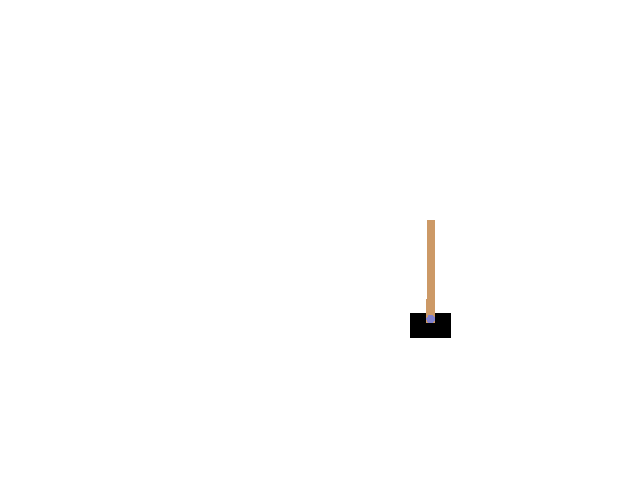
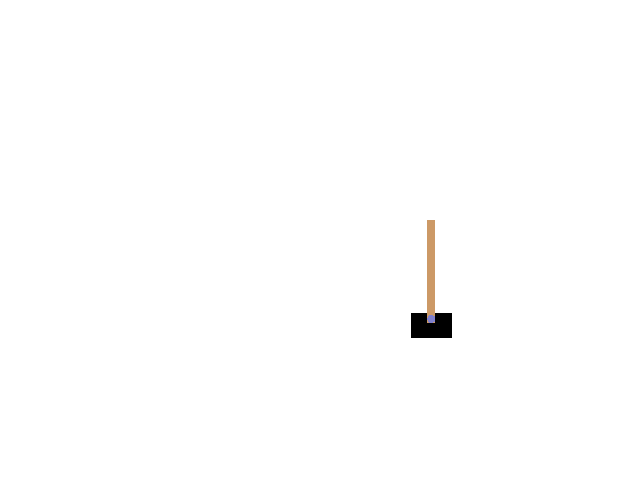
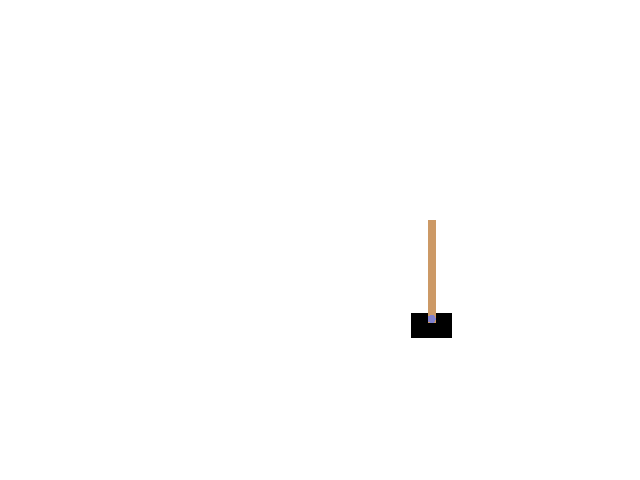
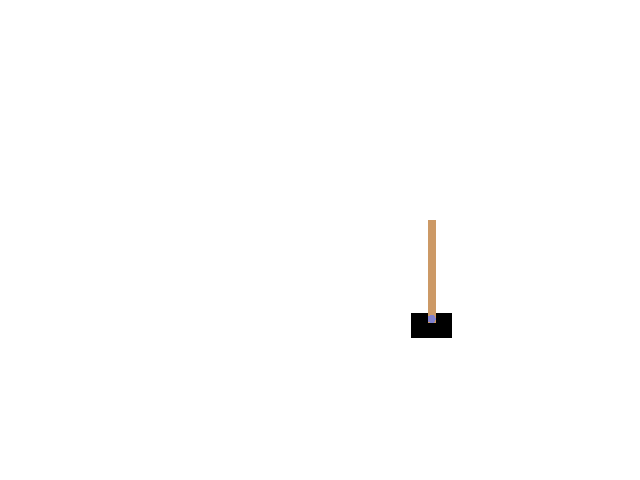
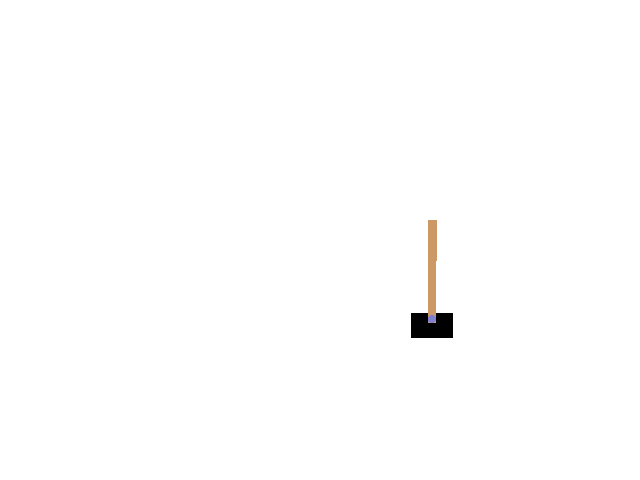
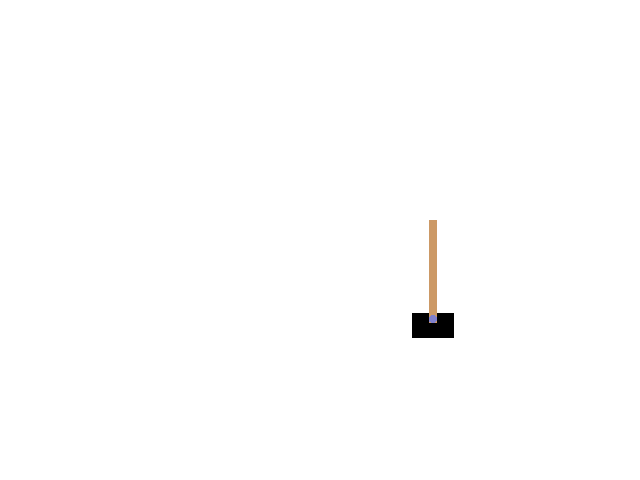
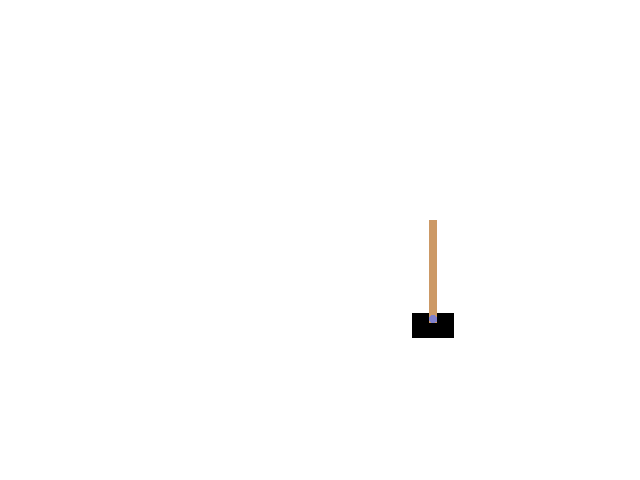
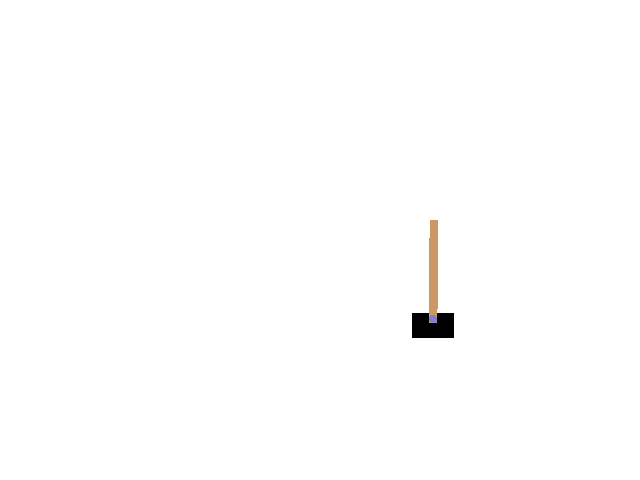
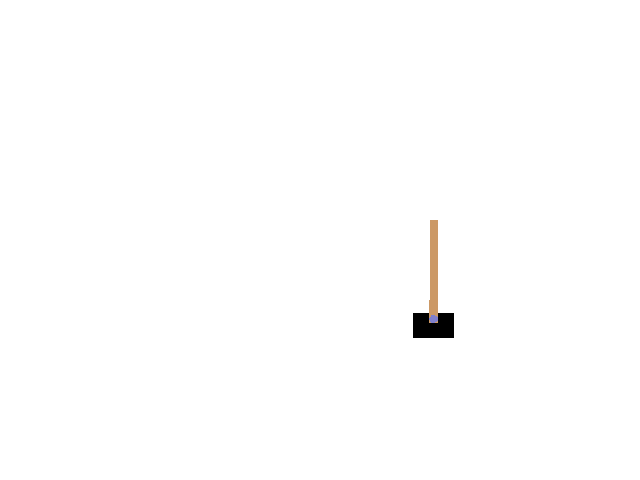
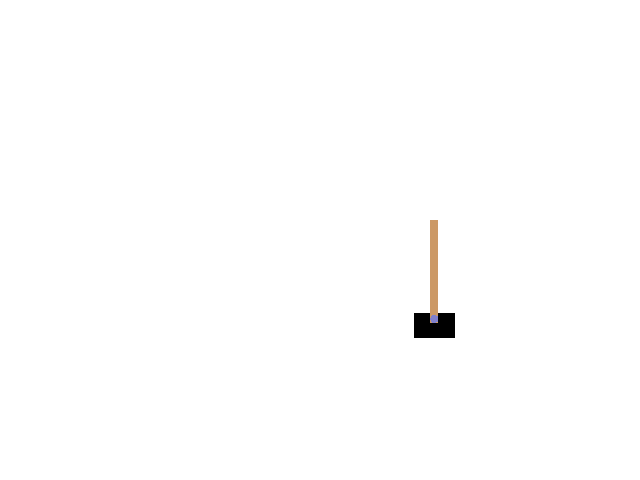
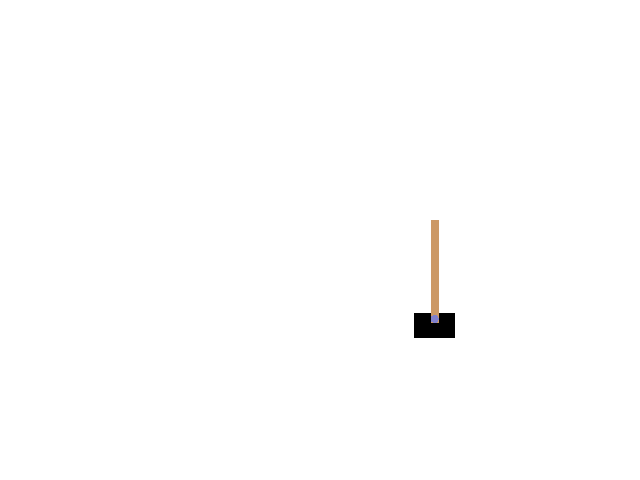
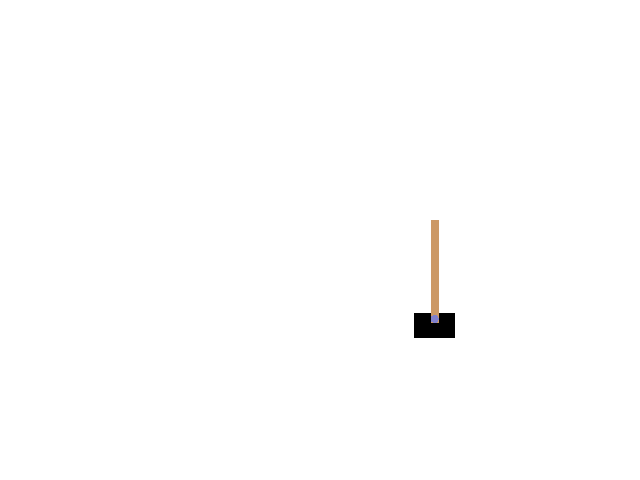
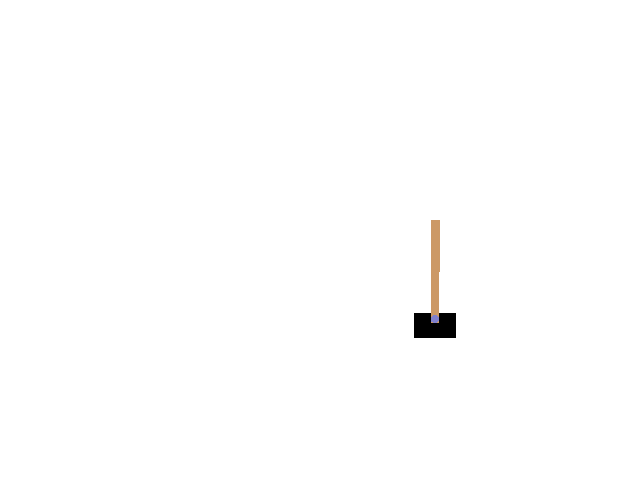
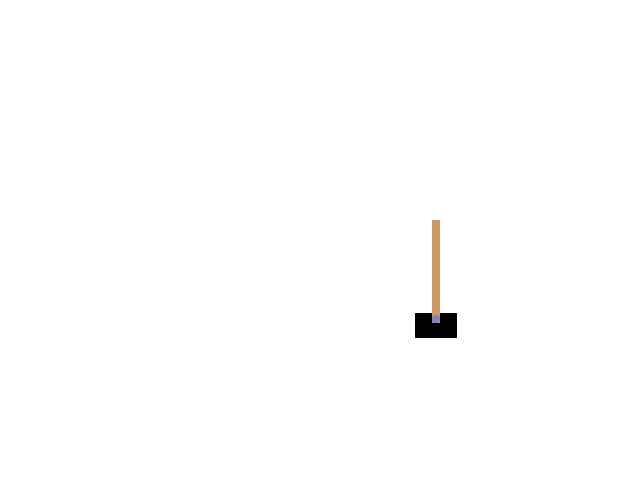
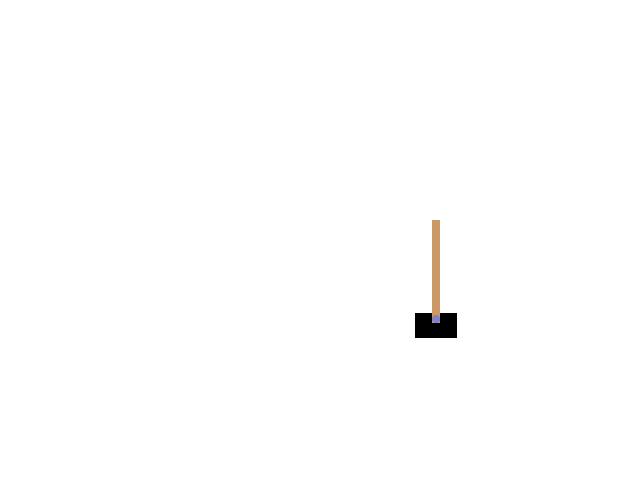
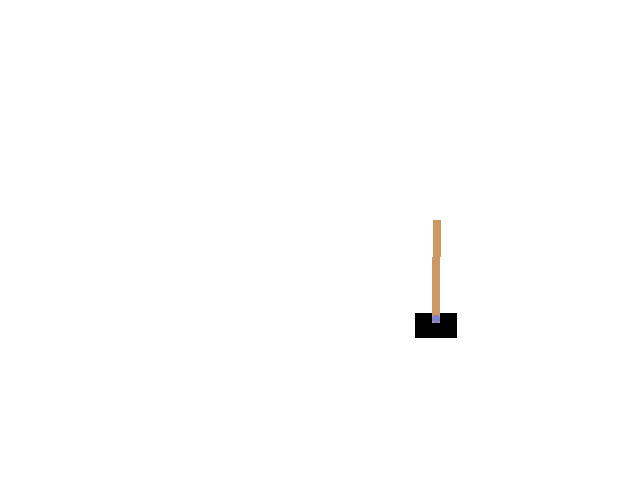
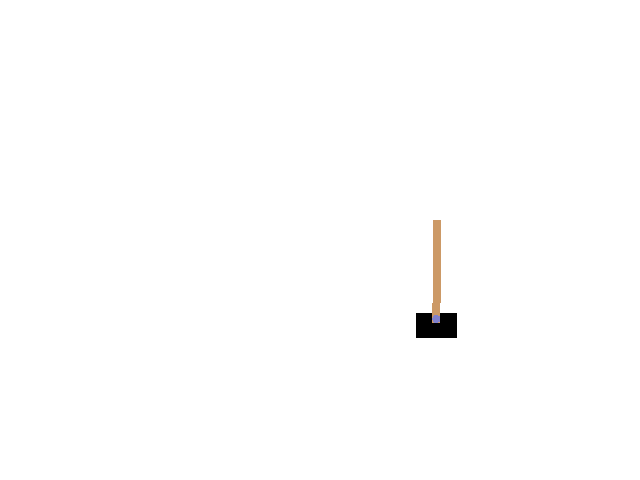
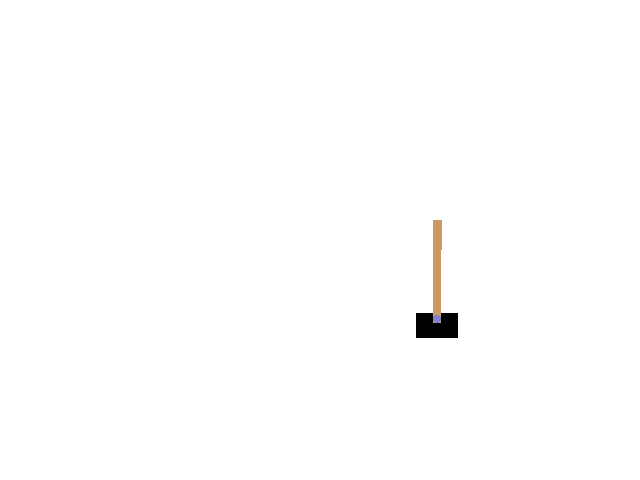
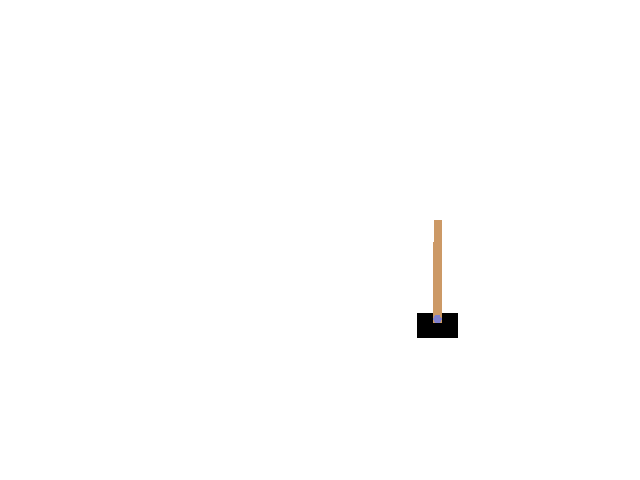
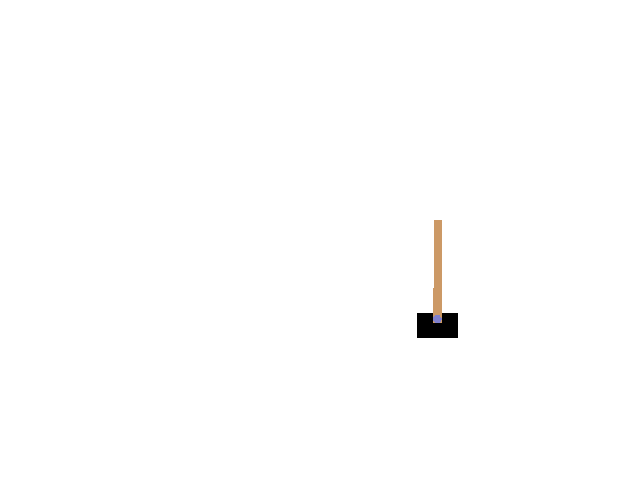
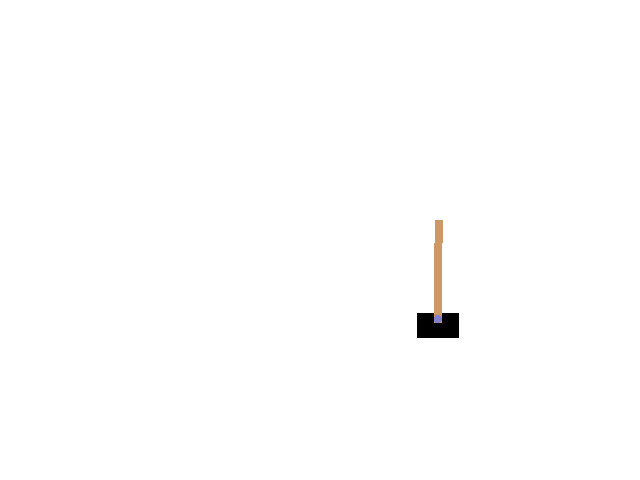
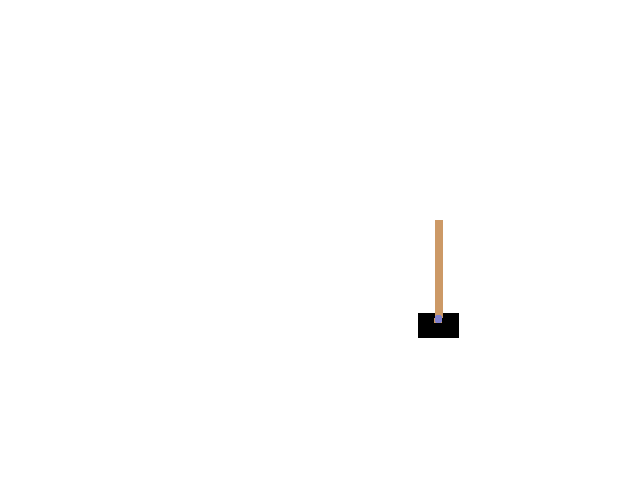
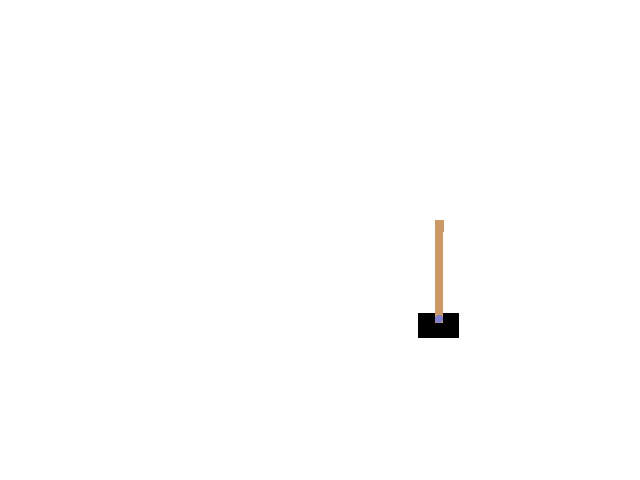
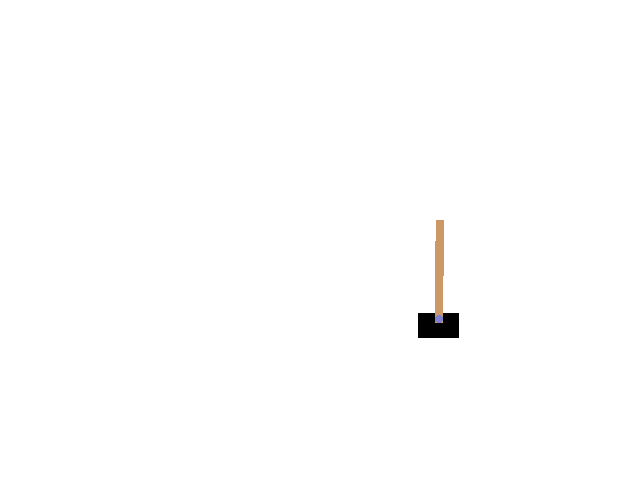
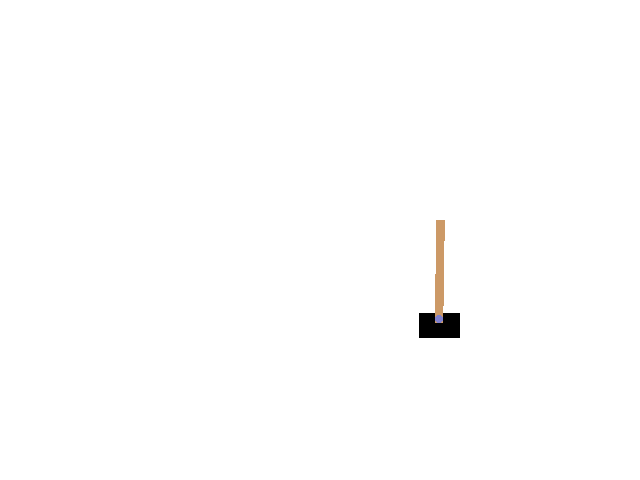
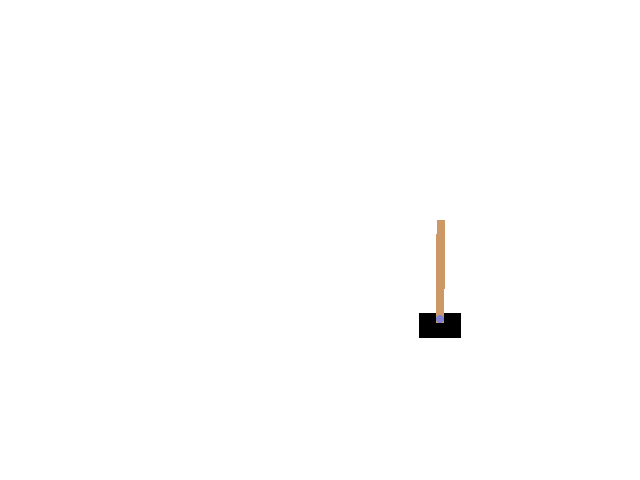
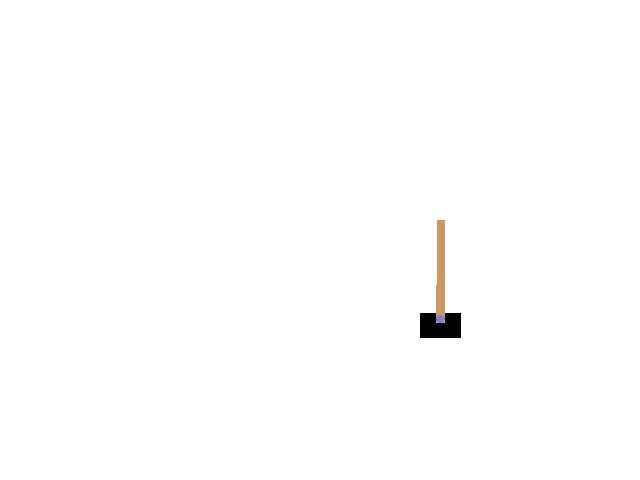
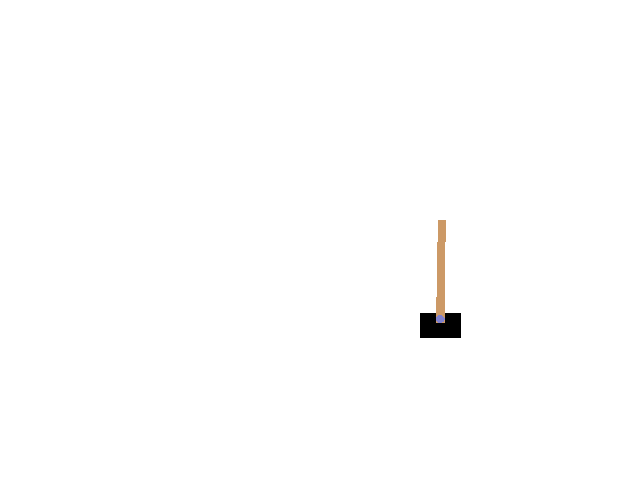
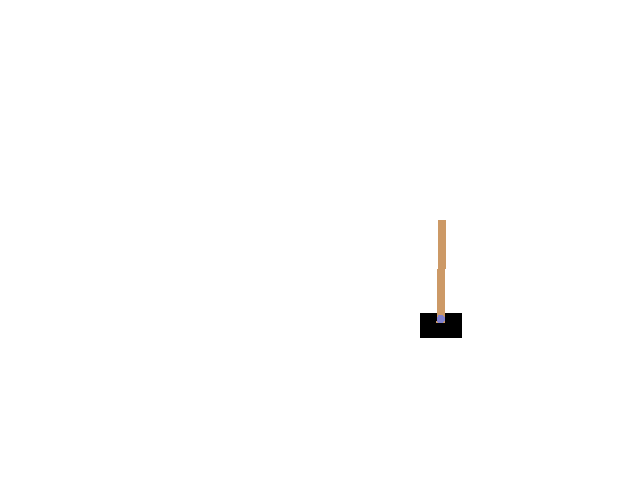
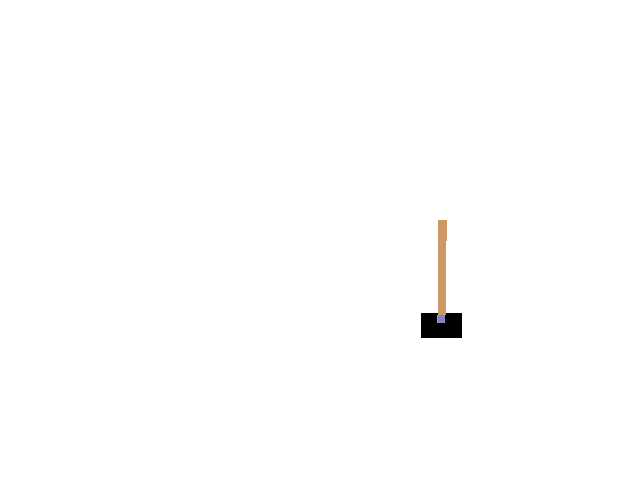
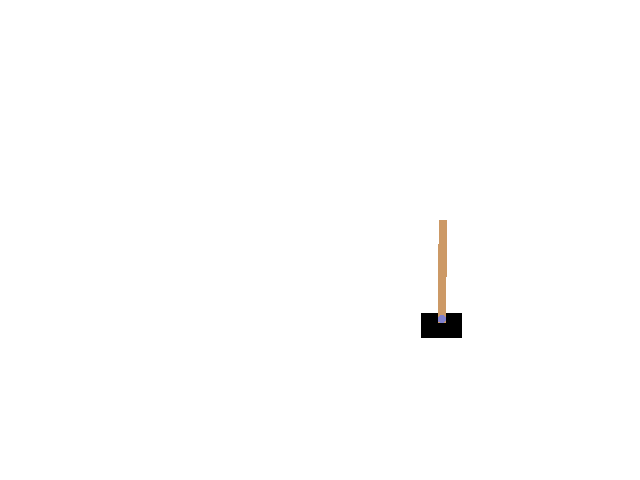
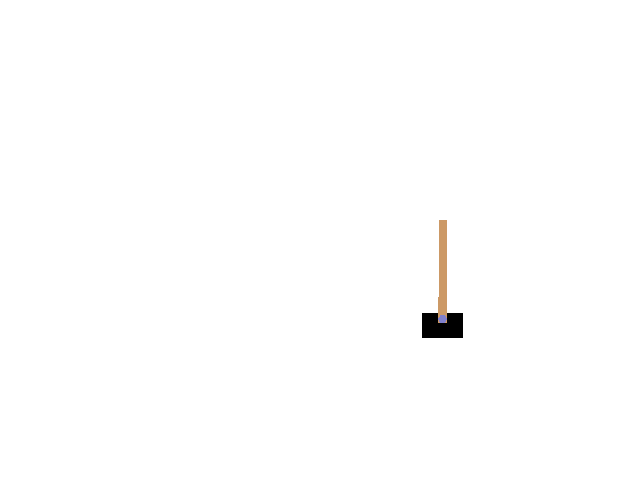
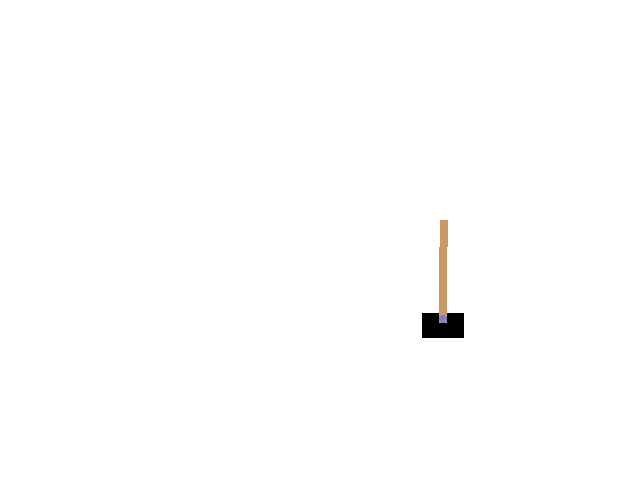
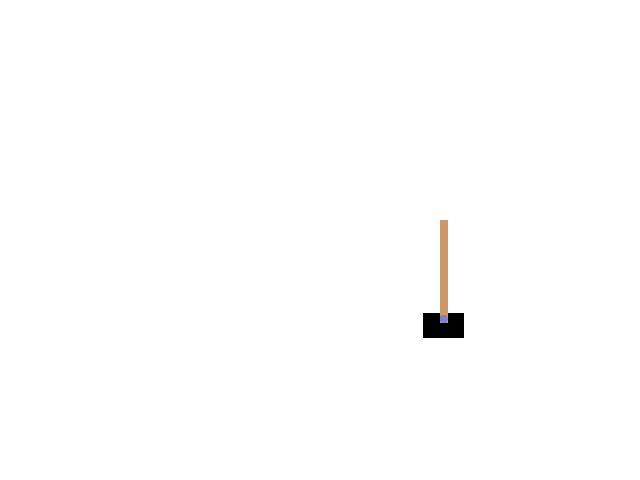
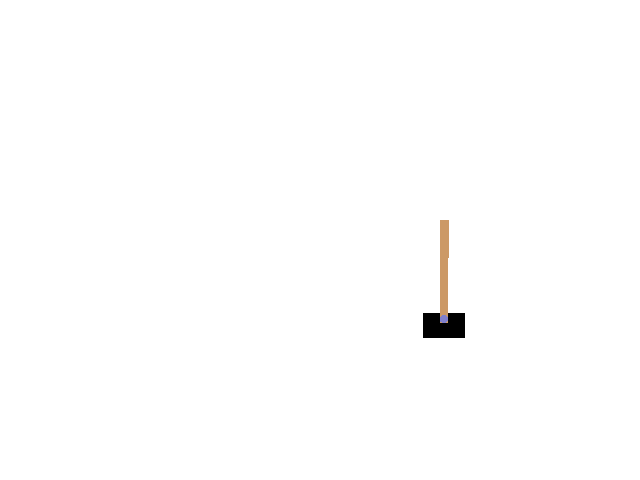
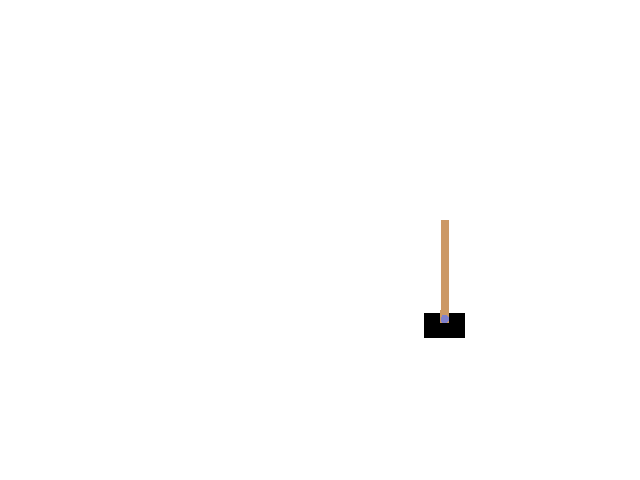
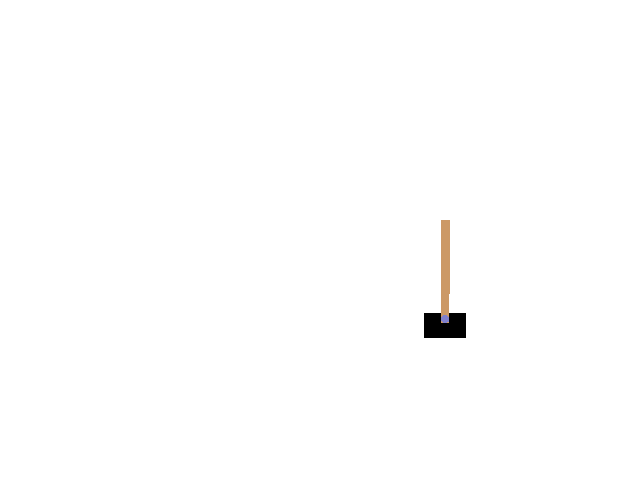
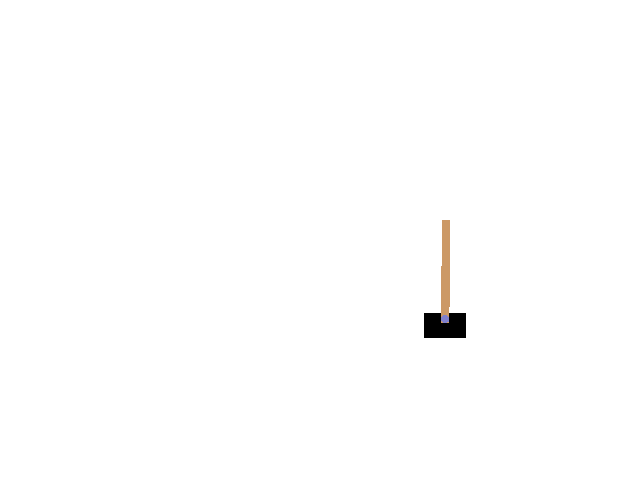
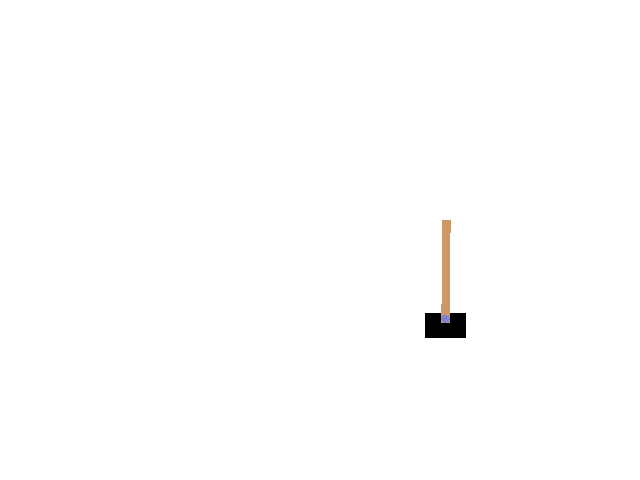
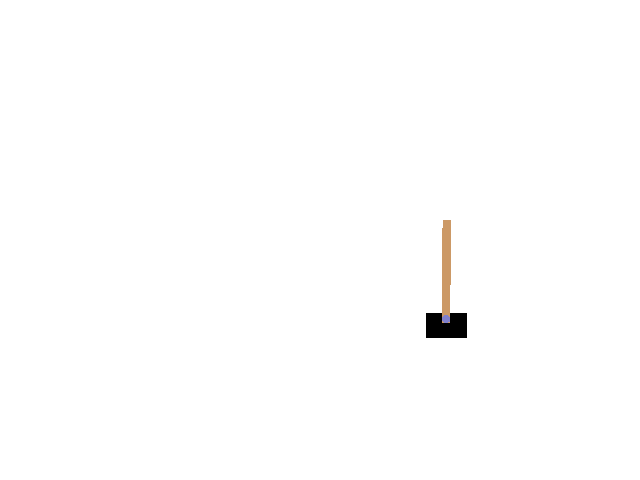
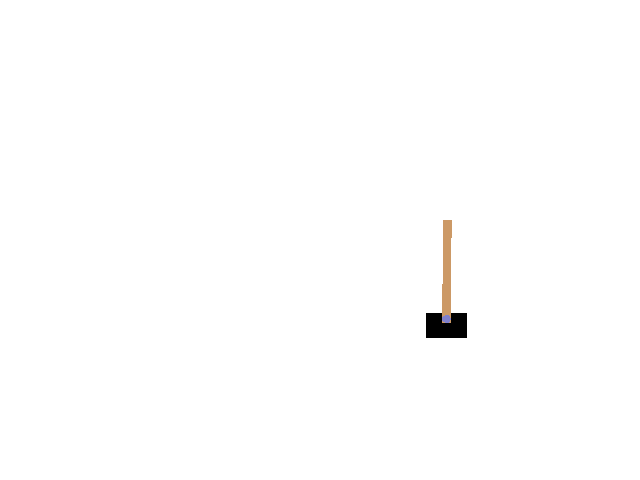
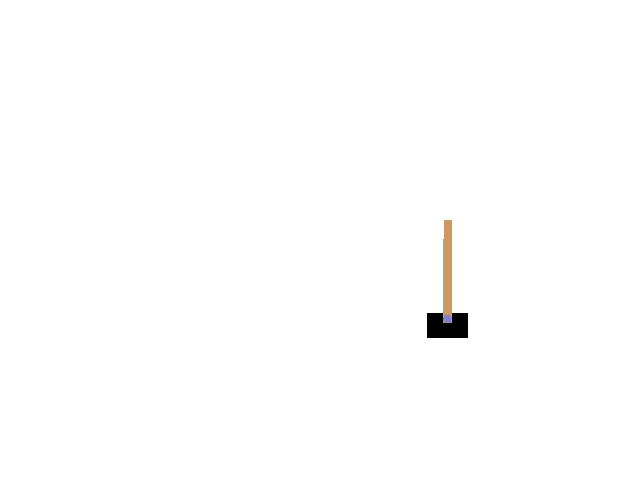
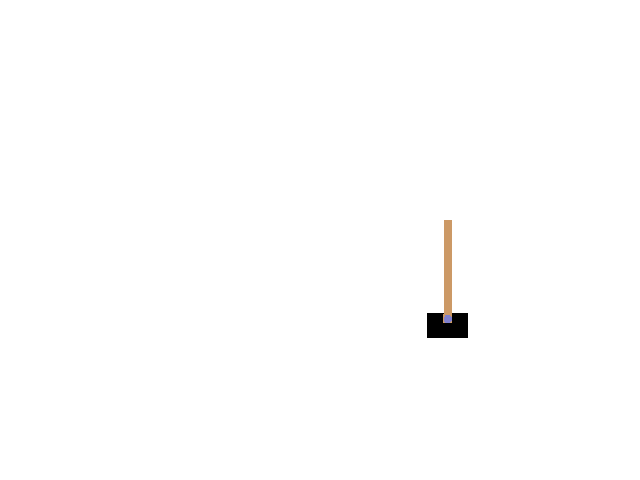
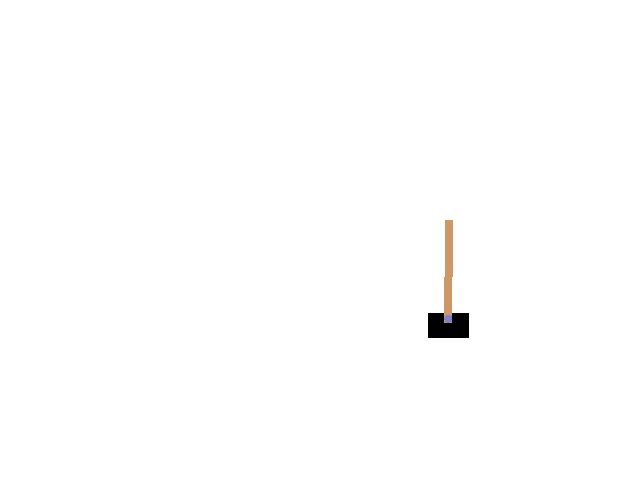
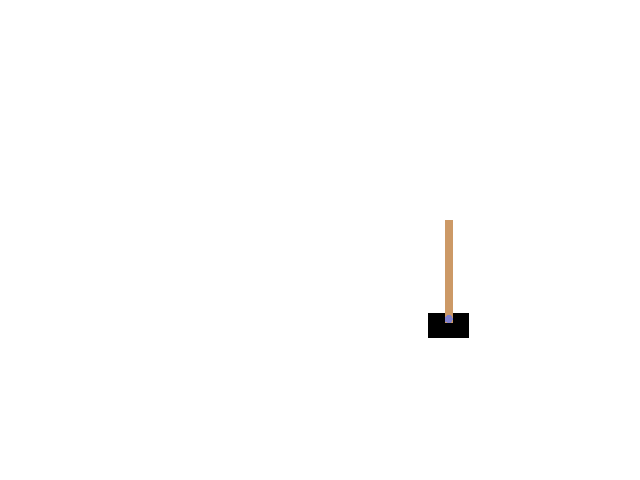
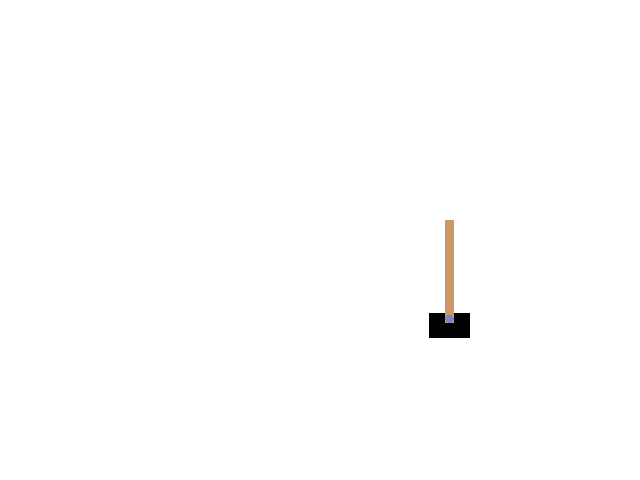
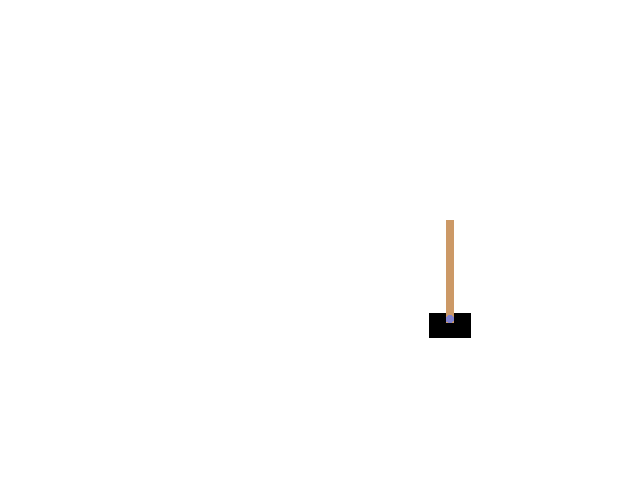
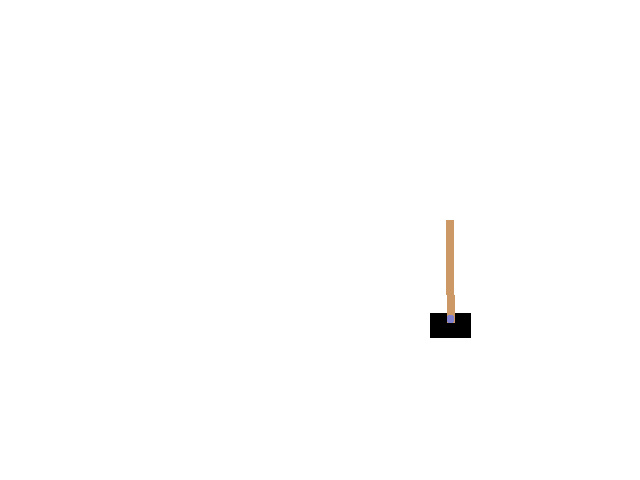
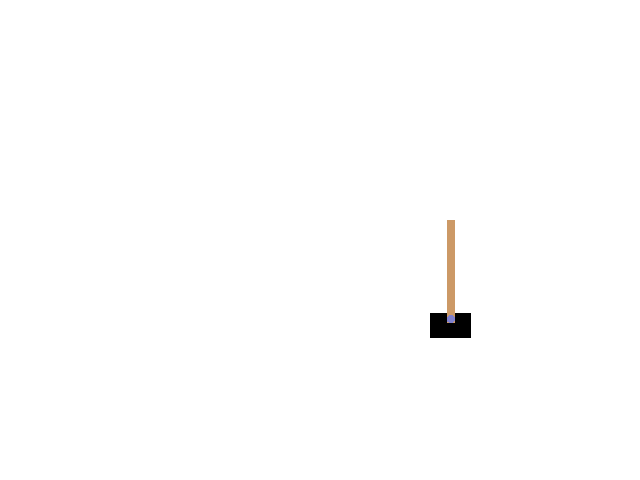
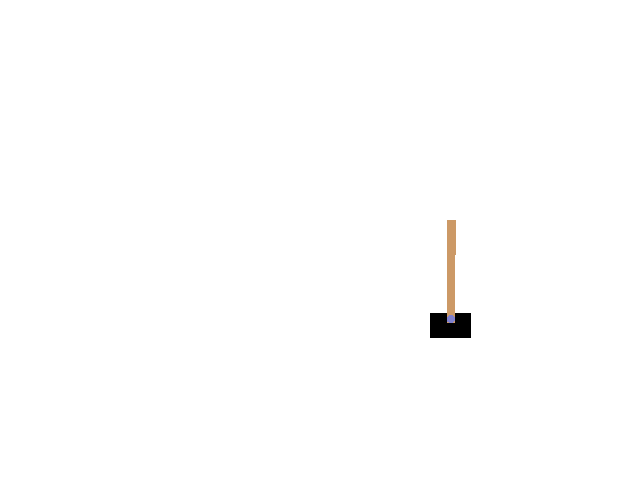
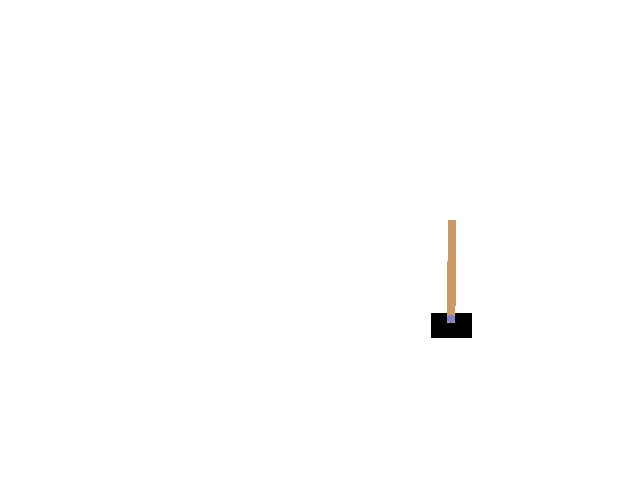
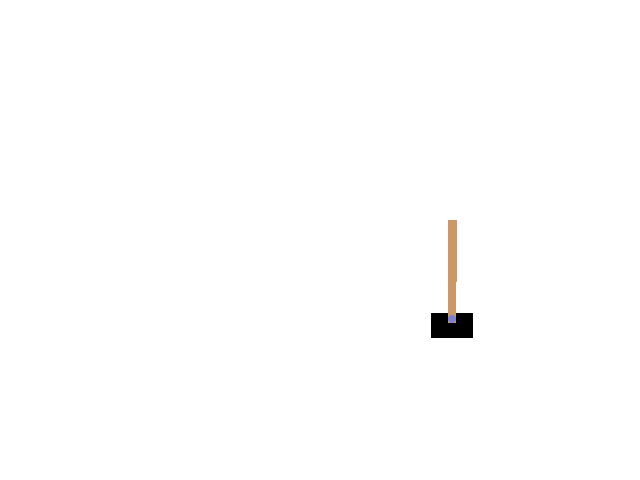
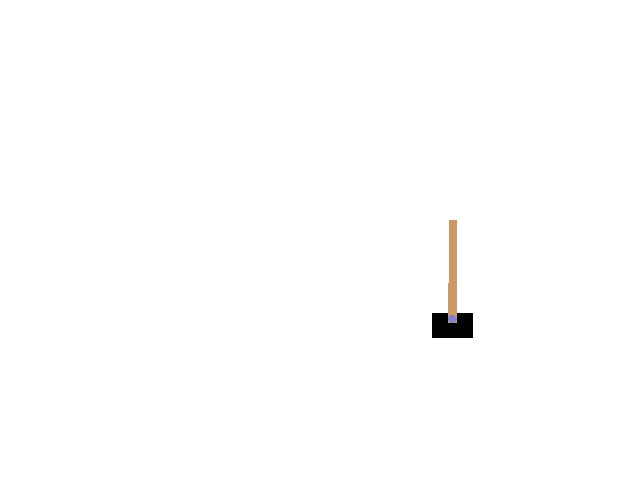
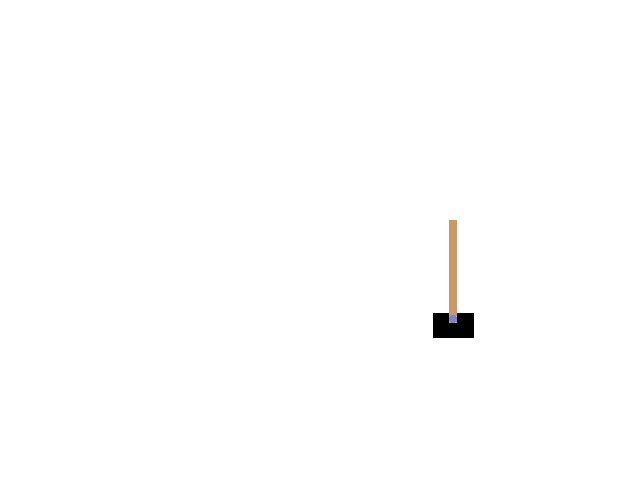
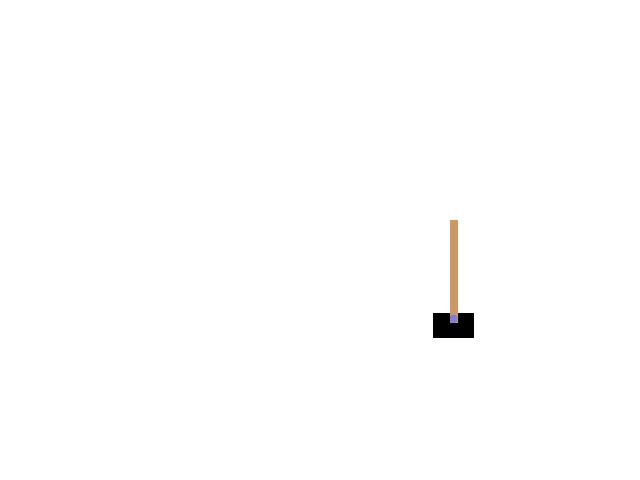
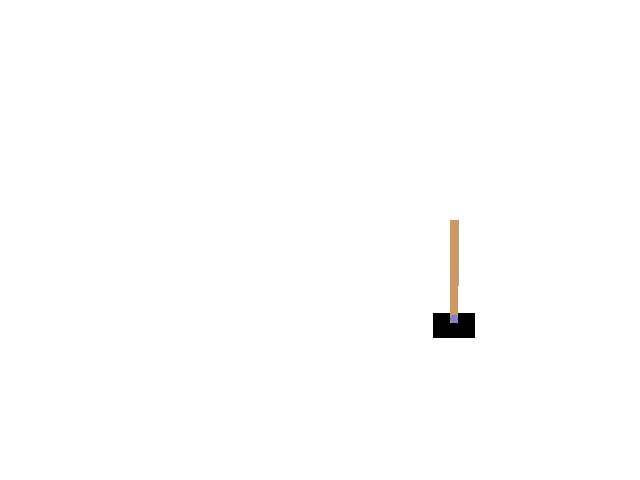
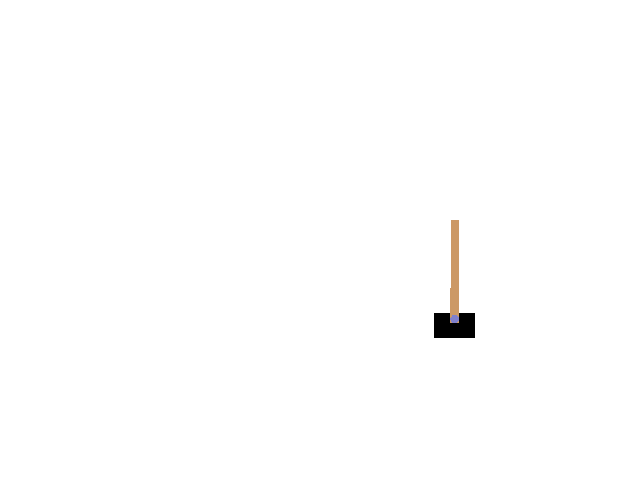
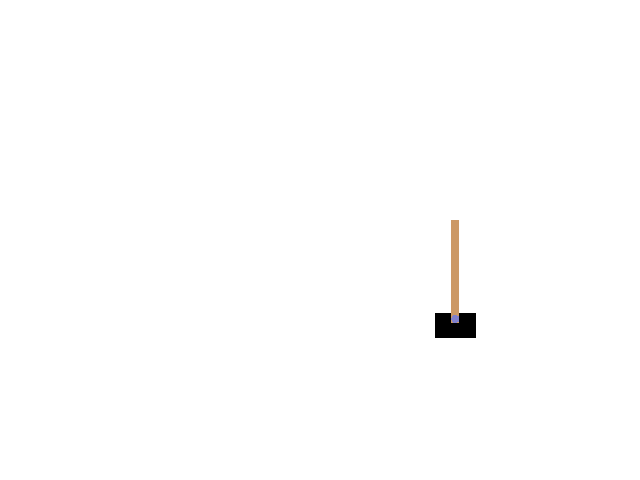
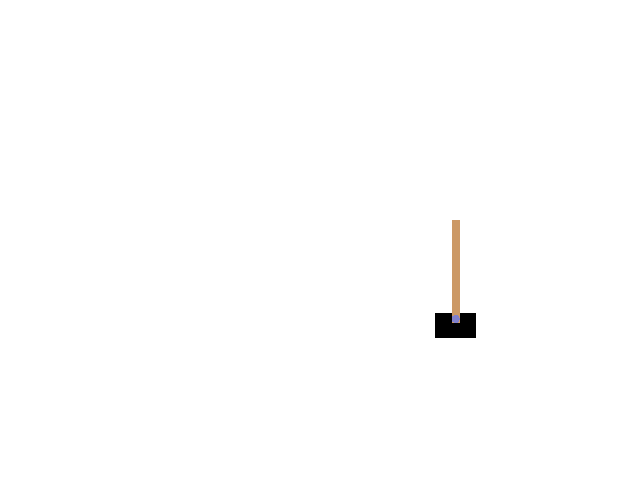
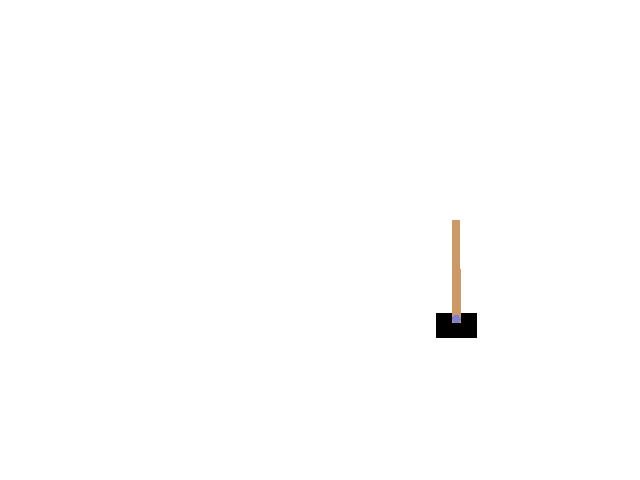
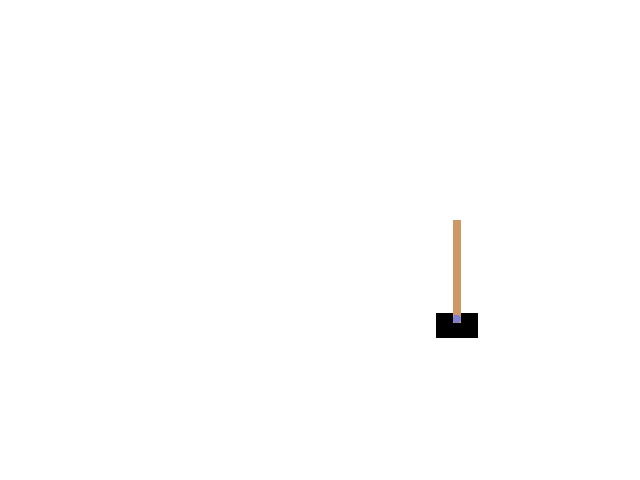
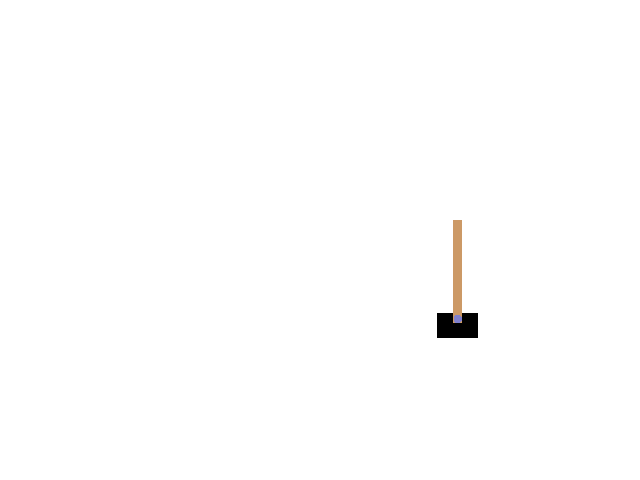
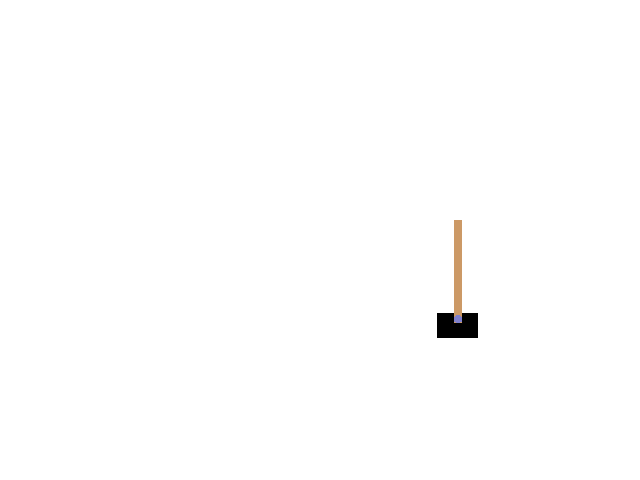
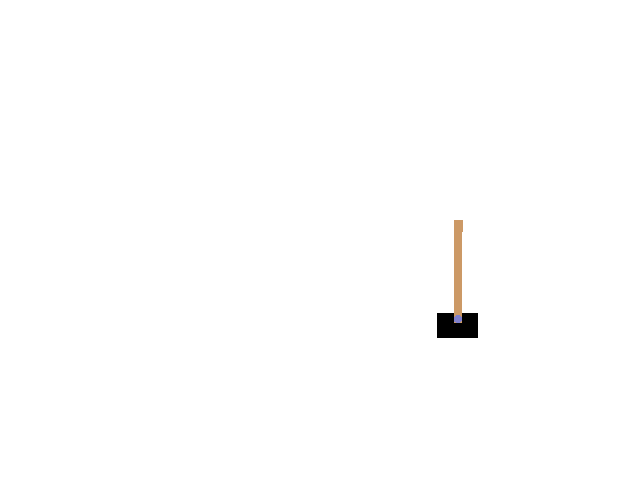
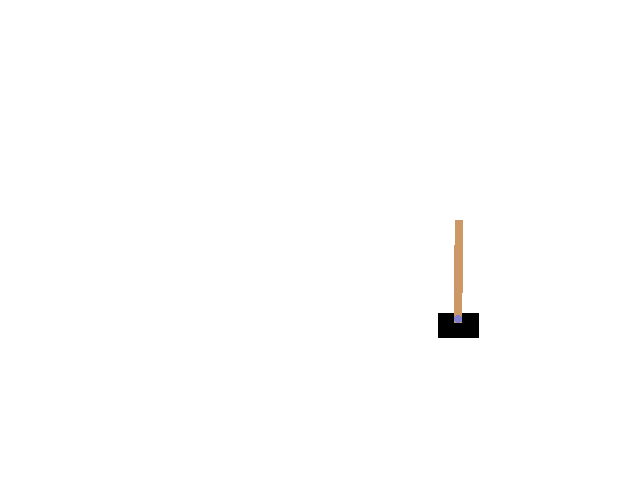
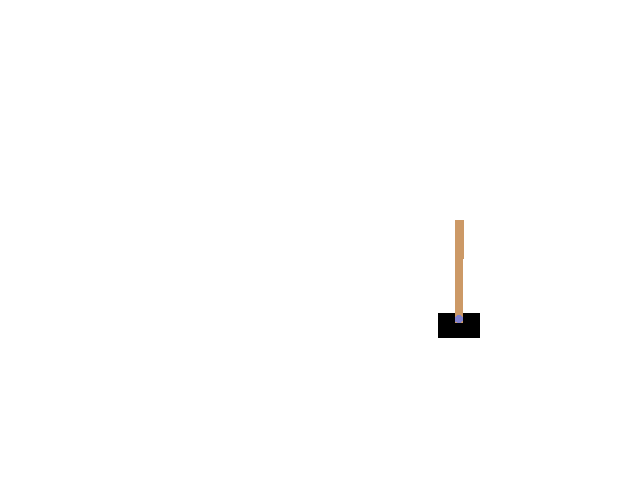
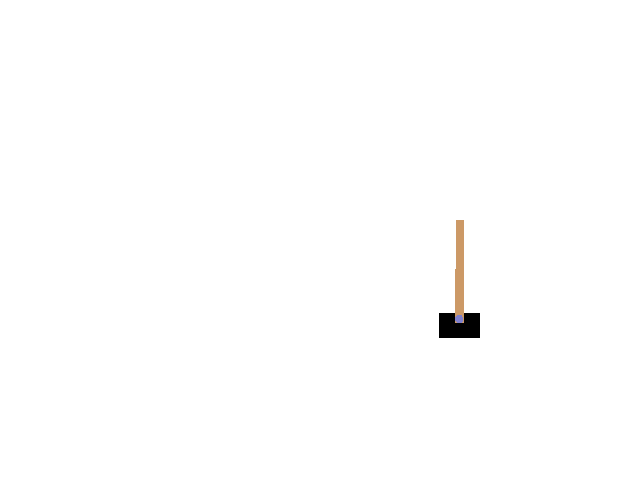
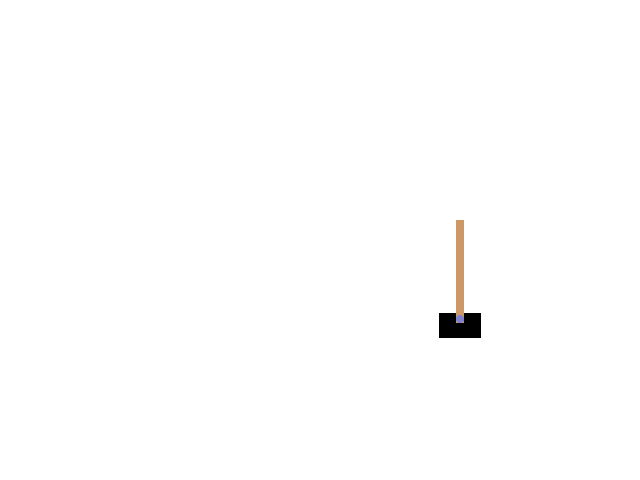
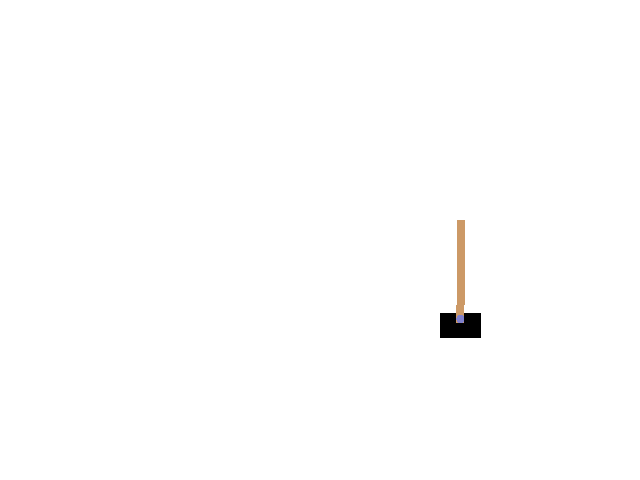
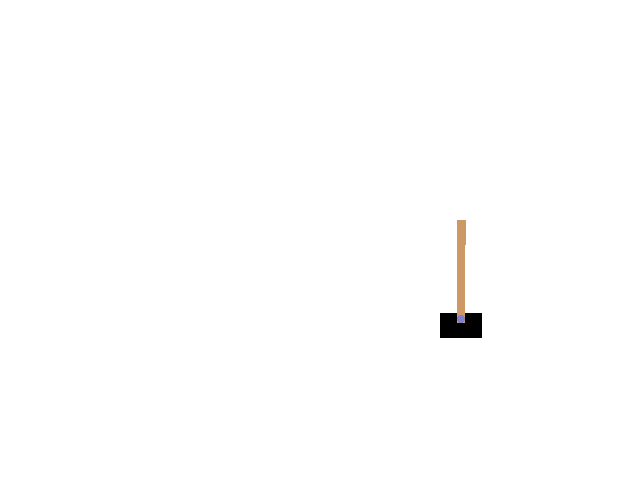
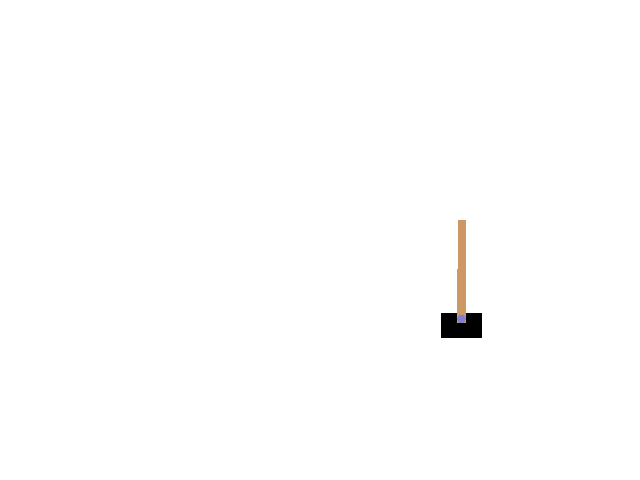
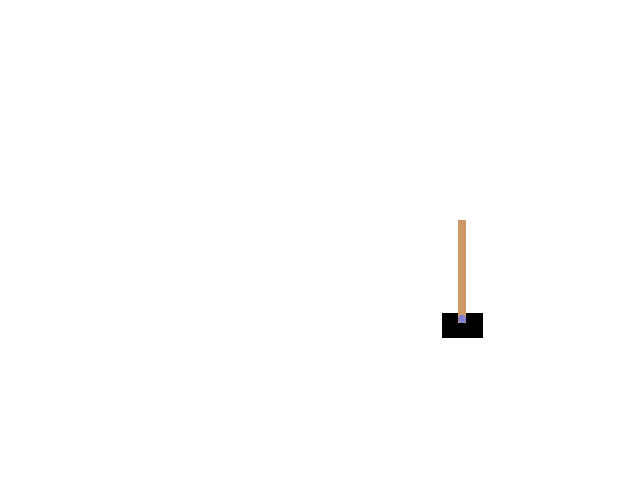
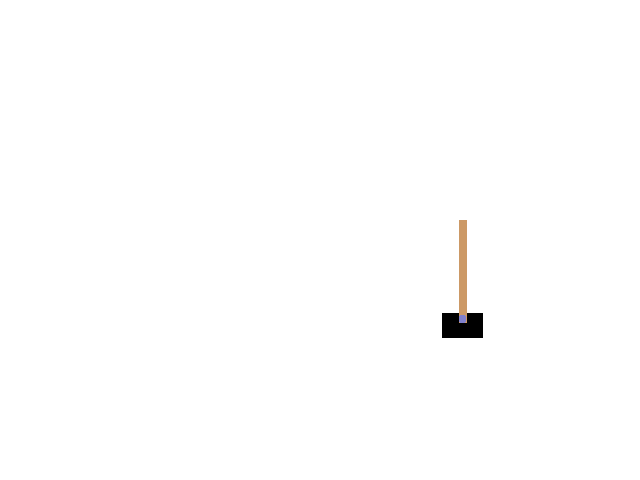

In [32]:

# Create a breakout environment
env = gym.make(environment)
# Reset it, returns the starting frame
frames = []
frame = env.reset()

frame_buffer = init_state_buffer(4, preprocess(frame))

is_done = False
while not is_done:
    action = choose_best_action(model, frame_buffer, env.action_space.n)

    frame, reward, is_done, _ = env.step(action)
    # Render
    frame_buffer = update_state_buffer(frame_buffer, preprocess(frame))
    frames.append(env.render(mode = 'rgb_array'))
env.close()
utils.display_frames_as_gif(frames)


### Fill Replay Memory with random actions

Or use a models decisions if we restart training from a saved model.

In [ ]:
first_state = preprocess(env.reset())
state = init_state_buffer(AGENT_HISTORY_LENGTH, first_state)

for _ in tqdm(range(REPLAY_START_SIZE)):
    if not restart:
        action = env.action_space.sample()
    else: 
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = choose_best_action(model, state, env.action_space.n)
        
    one_hot_action = keras.utils.np_utils.to_categorical(action, num_classes=env.action_space.n)

    for _ in range(ACTION_REPEAT):
        new_frame, reward, is_done, _ = env.step(action)
        new_frame = preprocess(new_frame)
        next_state = update_state_buffer(state, new_frame)
        if is_done:
            break
    memory.add(state, one_hot_action, next_state, reward, is_done)

    state = next_state
    if is_done:
        first_state = preprocess(env.reset())
        state = init_state_buffer(AGENT_HISTORY_LENGTH, first_state)
